In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np
from collections import defaultdict
import math
import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

from trvaep.utils import remove_sparsity

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split
import anndata

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
#loads 
import numpy as np
import torch
import torch.nn as nn

#from .helper_module import Encoder, Decoder

import torch
import torch.nn as nn
#
#from trvaep.utils import one_hot_encoder
from mcmodels.models.trvaep_master.trvaep.utils import one_hot_encoder


                
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, num_classes=None):
        super().__init__()
        self.n_classes = num_classes
        if num_classes is not None:
            layer_sizes[0] += num_classes
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.FC.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
            if use_bn:
                self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
            self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
            if use_dr:
                self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))

        self.linear_means = nn.Linear(layer_sizes[-1], latent_dim)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_dim)

    def forward(self, x, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            x = torch.cat((x, c), dim=-1)
        x = self.FC(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim,
                 use_bn, use_dr, dr_rate, use_mmd=False, num_classes=None, output_active="ReLU"):
        super().__init__()
        self.use_mmd = use_mmd
        self.op_activation = output_active
        self.use_bn = use_bn
        self.use_dr = use_dr
        if num_classes is not None:
            self.n_classes = num_classes
            input_size = latent_dim + num_classes
        else:
            input_size = latent_dim
        self.FC = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            if i + 1 < len(layer_sizes):
                self.FC.add_module(
                    name="L{:d}".format(i), module=nn.Linear(in_size, out_size, bias=False))
                if self.use_bn:
                    self.FC.add_module("B{:d}".format(i), module=nn.BatchNorm1d(out_size, affine=True))
                self.FC.add_module(name="A{:d}".format(i), module=nn.ReLU())
                if self.use_dr:
                    self.FC.add_module(name="D{:d}".format(i), module=nn.Dropout(p=dr_rate))
            else:
                if self.op_activation == "ReLU":
                    self.FC.add_module(
                        name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
                    self.FC.add_module(name="output", module=nn.ReLU())
                if self.op_activation == "linear":
                    self.FC.add_module(name="output".format(i), module=nn.Linear(in_size, out_size))

    def forward(self, z, c=None):
        if c is not None:
            c = one_hot_encoder(c, n_cls=self.n_classes)
            z = torch.cat((z, c), dim=-1)
        x = self.FC(z)
        if self.use_mmd:
            y = self.FC.L0(z)
            if self.use_bn:
                y = self.FC.B0(y)
            y = self.FC.A0(y)
            if self.use_dr:
                y = self.FC.D0(y)
            return x, y
        return x


class CVAE(nn.Module):
    """
            CVAE class. This class contains the implementation Conditional
            Variational Auto-encoder.
            # Parameters

                input_dim: integer
                    Number of input features (i.e. gene in case of scRNA-seq).
                num_classes: integer
                    Number of classes (conditions) the data contain. if `None` the model
                    will be a normal VAE instead of conditional VAE.
                encoder_layer_sizes: List
                    A list of hidden layer sizes for encoder network.
                latent_dim: integer
                    Bottleneck layer (z)  size.
                decoder_layer_sizes: List
                    A list of hidden layer sizes for decoder network.
                alpha: float
                     alpha coefficient for KL loss.
                use_batch_norm: boolean
                    if `True` batch normalization will applied to hidden layers
                dr_rate: float
                    Dropput rate applied to hidden layer, if `dr_rate`==0 no dropput will be applied.
                use_mmd: boolean
                    if `True` then MMD will be applied to first decoder layer.
                beta: float
                    beta coefficient for MMD loss.

        """

    def __init__(self, input_dim, output_dim, num_classes=None, encoder_layer_sizes=[64, 32],
                 latent_dim=10, decoder_layer_sizes=[32, 64], alpha=0.001, use_batch_norm=True,
                 dr_rate=0.2, use_mmd=True, beta=1, output_activation="ReLU"):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_dim) == int
        assert type(decoder_layer_sizes) == list
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_cls = num_classes
        self.use_mmd = use_mmd
        self.beta = beta
        self.dr_rate = dr_rate
        if self.dr_rate > 0:
            self.use_dr = True
        else:
            self.use_dr = False
        self.use_bn = use_batch_norm
        self.alpha = alpha
        self.op_activation = output_activation
        encoder_layer_sizes.insert(0, self.input_dim)#math.floor(self.input_dim / 2)) #self.input_dim)
        print('encoder_layer_sizes',encoder_layer_sizes)
        print('decoder_layer_sizes',decoder_layer_sizes)
        print('latent dim', self.latent_dim)
        print(self.num_cls,'ncls')
        print(self.dr_rate,'dr_rate')
        print(self.use_bn,'ubn')
        print(self.use_dr,'udr')
        decoder_layer_sizes.append(self.output_dim)
        self.encoder = Encoder(encoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.num_cls)
        self.decoder = Decoder(decoder_layer_sizes, self.latent_dim,
                               self.use_bn, self.use_dr, self.dr_rate, self.use_mmd, self.num_cls, self.op_activation)

    def inference(self, n=1, c=None):
        """
                Generate `n` datapoints by sampling from a standard Gaussian and feeding them
                  to decoder.

                # Parameters
                    n: integer
                    c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                # Returns
                    rec_data: 'numpy nd-array'
                        Returns 'numpy nd-array` containing reconstructed 'data' in shape [n, input_dim].
                """
        batch_size = n
        z = torch.randn([batch_size, self.latent_dim])
        if c is not None:
            c = torch.tensor(c)
        recon_x = self.decoder(z, c)
        return recon_x

    def sampling(self, mu, log_var):
        """
               Samples from standard Normal distribution with shape and
               applies reparametrization trick.
               # Parameters
                   mu: `Tensor`
                        mean vector
                   log_var: `Tensor`
                        log_var tensor
               # Returns
                   The computed Tensor of samples.
           """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)

    def get_latent(self, x, c=None, mean=False):
        """
                  Map `x` in to the latent space. This function will feed data
                  in encoder  and return  z for each sample in data.
                  # Parameters
                      x:  numpy nd-array
                          Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                      c: `numpy nd-array`
                        `numpy nd-array` of original desired labels for each sample.
                      mean: boolean
                           if `True` only return mean vector ohterwise z will be fed to sampling function.
                  # Returns
                      latent: `numpy nd-array`
                          Returns array containing latent space encoding of 'x'
              """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        if mean:
            return z_mean.cpu().data.numpy()
        return z_sample.cpu().data.numpy()

    def get_y(self, x, c=None):
        """
                       Map `x` in to the y dimension as described here https://arxiv.org/abs/1910.01791.
                        This function will feed data in encoder  and return  z for each sample in data.
                       # Parameters
                           x:  numpy nd-array
                               Numpy nd-array to be mapped to latent space. `x` has to be in shape [n_obs, input_dim].
                           c: `numpy nd-array`
                             `numpy nd-array` of original desired labels for each sample.
                           mean: boolean
                                if `True` only return mean vector ohterwise z will be fed to sampling function.
                       # Returns
                           latent: `numpy nd-array`
                               Returns array containing latent space encoding of 'x'
                   """
        if c is not None:
            c = torch.tensor(c).to(self.device)
        x = torch.tensor(x).to(self.device)
        z_mean, z_log_var = self.encoder(x, c)
        z_sample = self.sampling(z_mean, z_log_var)
        _, y = self.decoder(z_sample, c)
        return y.cpu().data.numpy()

    def predict(self, x, y, target):
        """
                Predicts how data points `x` with original condition (classes) `y` will look like in `target` condition.
                # Parameters
                    x: `numpy nd-array`
                        nummpy data matrix containing source data points.
                    y: `numpy nd-array`
                        `numpy nd-array` of original labels .
                    target: str
                        target condition for the predcition.
                # Returns
                    output: `numpy nd-array`
                        `numpy nd-array`  of predicted cells in target condition.
                # Example
                ```python
                adata = sc.read("./data/kang_seurat.h5ad")
                sc.pp.normalize_per_cell(adata)
                sc.pp.log1p(adata)
                sc.pp.highly_variable_genes(adata, n_top_genes=1000)
                adata = adata[:, adata.var['highly_variable']]
                n_conditions = adata.obs["condition"].unique().shape[0]
                adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                      & (adata.obs["condition"] == "CTRL"))]
                model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                             encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                             use_mmd=True, beta=10)
                trainer = Trainer(model, adata_train)
                trainer.train_trvae(100, 64)
                data = model.get_y(adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
                adata_latent = sc.AnnData(adata_train)
                adata_latent.obs["cell_type"] = adata_train.obs["cell_type"].tolist()
                adata_latent.obs["condition"] = adata_train.obs["condition"].tolist()
                sc.pp.neighbors(adata_latent)
                sc.tl.umap(adata_latent)
                sc.pl.umap(adata_latent, color=["condition", "cell_type"])
                ground_truth = adata_source = adata[(adata.obs["cell_type"] == "pDC")]
                adata_source = adata[(adata.obs["cell_type"] == "pDC") & (adata.obs["condition"] == "CTRL")]
                predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                                               target="STIM")
                ```
        """

        y = self.label_encoder.transform(np.array(y))
        z = self.get_latent(x, y)
        target_labels = np.array([target])
        target_labels = self.label_encoder.transform(np.tile(target_labels, len(y)))
        predicted = self.reconstruct(z, target_labels, use_latent=True)
        return predicted

    def reconstruct(self, x, c=None, use_latent=False):
        """
        Reconstruct the latent space encoding via the decoder.
        # Parameters
            x: `numpy nd-array`
                nummpy data matrix containing data points.
            c: `numpy nd-array`
                `numpy nd-array` of original labels. Only set in `None` for VAE
                model.
            use_latent: bool
                This flag determines whether the `x` is already in latent space or not.
                if `True`: The `x` is in latent space `x` is in shape [n_obs, latent_dim]).
                if `False`: The `x` is not in latent space (`data.X` is in shape [n_obs, input_dim]).
        # Returns
            rec_data: 'numpy nd-array'
                Returns 'numpy nd-array` containing reconstructed 'data' in shape [n_obs, input_dim].
        """
        if use_latent:
            x = torch.tensor(x).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(x, c)
            else:
                reconstructed = self.decoder(x, c)
            return reconstructed.cpu().data.numpy()
        else:
            z = self.get_latent(x, c)
            z = torch.tensor(z).to(self.device)
            if c is not None:
                c = torch.tensor(c).to(self.device)
            if self.use_mmd:
                reconstructed, _ = self.decoder(z, c)
                return reconstructed
            else:
                reconstructed = self.decoder(z, c)
                return reconstructed.cpu().data.numpy()

    def forward(self, x, y, c=None):
        z_mean, z_log_var = self.encoder(x, c)
        z = self.sampling(z_mean, z_log_var)
        if self.use_mmd:
            recon_x, y = self.decoder(z, c)
            return recon_x, z_mean, z_log_var, y
        else:
            recon_x = self.decoder(z, c)
            return recon_x, z_mean, z_log_var
        
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split


class CustomDatasetFromAdataRegression(Dataset):
    
    def __init__(self, adata, condition_key=None):
        #print(adata.Y.shape)
        self.condtion_key = condition_key
        self.adata = adata
        if sparse.issparse(self.adata.X):
            self.adata = remove_sparsity(self.adata)
        self.data = np.array(self.adata.X)
        self.Y = np.array(self.adata.Y)
        if self.condtion_key is not None:
            self.labels, self.le = label_encoder(self.adata, condition_key=condition_key)
            self.labels = np.array(self.labels)

    def __getitem__(self, index):
        #print(index)
        if self.condtion_key is not None:
            label = self.labels[index]
            label_as_tensor = torch.Tensor(label)
        injection = self.data[index, :]
        projection = self.Y[index,:]
        cell_as_tensor = torch.Tensor(injection)
        if self.condtion_key is not None:
            return injection, projection, label#,index
        else:
            return injection, projection, None#index,None

    def __len__(self):
        return len(self.adata)

    def get_label_ecnoder(self):
        return self.le

from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata



In [4]:
def label_encoder(adata, label_encoder=None, condition_key='condition'):
    if label_encoder is None:
        le = LabelEncoder()
        labels = le.fit_transform(adata.obs[condition_key].tolist())
    else:
        le = label_encoder
        labels = np.zeros(adata.shape[0])
        for condition, label in label_encoder.items():
            labels[adata.obs[condition_key] == condition] = label
    return labels.reshape(-1, 1), le


In [5]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [7]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids[4:5]:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

315
None


In [8]:
# creline = get_cre_status(data_info, msvds)
# experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
# leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# # contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# # ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key)
# thres_ncomp = np.asarray([[1e-10,0]])
# wt_2ormore = get_wt_inds(creline)

#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order_leaves #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)


In [9]:
sid = 315
cre_subset = np.asarray(['Cux2-IRES-Cre', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
exp_toinclude = np.where(np.isin(creline[sid],cre_subset))[0]
msvds[sid].reg_inj_vcount_norm[exp_toinclude].sum(axis = 0).shape

(240,)

In [103]:
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.preprocessing import quantile_transform
def normalize(x):
    keep = np.where(np.linalg.norm(x, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x - np.mean(x, axis = 0))/ np.var(x, axis = 0)**(0.5))



In [17]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        print(pcaX.explained_variance_ratio_.sum())
        print(pcaY.explained_variance_ratio_.sum())
        Xrec = nmfX.inverse_transform(X_nmf)
        Yrec = nmfY.inverse_transform(Y_nmf) 
        print(((X- Xrec)**2).sum() , (X**2).sum())
        print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =1000
        batch_size=20
        
        xnorm = scalerX.fit_transform(X)#normalize(X)
        
        #scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))#normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
    
        
        
        
        
        #an = anndata.AnnData(xnorm)
        #an.Y= ynorm
        xnorm = scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 1e-2
        trainer.n_workers=0
        self = trainer
        self.train_frac = 1.
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        iteration, (x, y,l) = list(enumerate(data_loader_train))[0]
        
        #x = normalize(x)#scalerX.fit_transform(x)
        #y = normalize(y)#scalerY.fit_transform(y)
        
        #print(y.to(self.device))
        ind = 0
        for q in range(niter):
                ind = ind + 1
                #print()
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)
                #print(x, y)
                recon_x, mean, log_var = self.model(x, y,l)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                print(ind, 'iteration', train_loss)

0.8572351738195845
0.9975154050662833
0.0010721778033390102 0.007446737378860348
9.546924325974643 376.0
encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
1 iteration 590.7820434570312
2 iteration 536.016845703125
3 iteration 503.16046142578125
4 iteration 482.386962890625
5 iteration 457.06610107421875
6 iteration 437.5152282714844
7 iteration 413.3241271972656
8 iteration 390.6498718261719
9 iteration 365.7608642578125
10 iteration 345.34417724609375
11 iteration 327.5467529296875
12 iteration 318.50262451171875
13 iteration 305.3813781738281
14 iteration 291.6416320800781
15 iteration 284.511962890625
16 iteration 266.287353515625
17 iteration 254.0591278076172
18 iteration 244.3306121826172
19 iteration 224.42861938476562
20 iteration 212.45297241210938
21 iteration 200.02586364746094
22 iteration 187.24557495117188
23 iteration 175.40957641601562
24 iteration 164.59979248046875
25 iteration 154.54165649414062
26 iteration 1

251 iteration 0.4278338551521301
252 iteration 0.42127370834350586
253 iteration 0.40839657187461853
254 iteration 0.4133906364440918
255 iteration 0.4037453234195709
256 iteration 0.3960515558719635
257 iteration 0.43083587288856506
258 iteration 0.37264031171798706
259 iteration 0.3994207978248596
260 iteration 0.40196895599365234
261 iteration 0.4186338484287262
262 iteration 0.36962997913360596
263 iteration 0.36804503202438354
264 iteration 0.39771726727485657
265 iteration 0.3672669529914856
266 iteration 0.3852616846561432
267 iteration 0.38584911823272705
268 iteration 0.3718801438808441
269 iteration 0.3862619996070862
270 iteration 0.3743722438812256
271 iteration 0.3550223708152771
272 iteration 0.3631550669670105
273 iteration 0.34230977296829224
274 iteration 0.3430193364620209
275 iteration 0.34215599298477173
276 iteration 0.34022146463394165
277 iteration 0.33954930305480957
278 iteration 0.3202464282512665
279 iteration 0.32676011323928833
280 iteration 0.3045193552970

515 iteration 0.1963239461183548
516 iteration 0.2090950459241867
517 iteration 0.20671279728412628
518 iteration 0.18843449652194977
519 iteration 0.19745893776416779
520 iteration 0.19779686629772186
521 iteration 0.18111073970794678
522 iteration 0.21213872730731964
523 iteration 0.1891331672668457
524 iteration 0.20286786556243896
525 iteration 0.1942788064479828
526 iteration 0.18920063972473145
527 iteration 0.1950197070837021
528 iteration 0.17079979181289673
529 iteration 0.20134274661540985
530 iteration 0.19334159791469574
531 iteration 0.18562209606170654
532 iteration 0.19488775730133057
533 iteration 0.19412347674369812
534 iteration 0.18978694081306458
535 iteration 0.2021191120147705
536 iteration 0.20003175735473633
537 iteration 0.2052961140871048
538 iteration 0.18689504265785217
539 iteration 0.20912575721740723
540 iteration 0.18337684869766235
541 iteration 0.2214525192975998
542 iteration 0.1992844194173813
543 iteration 0.1993560791015625
544 iteration 0.21274161

760 iteration 0.19316940009593964
761 iteration 0.1938767433166504
762 iteration 0.22333768010139465
763 iteration 0.18630684912204742
764 iteration 0.21967534720897675
765 iteration 0.1937585175037384
766 iteration 0.22446903586387634
767 iteration 0.19177818298339844
768 iteration 0.22615528106689453
769 iteration 0.1954474002122879
770 iteration 0.19988426566123962
771 iteration 0.225942462682724
772 iteration 0.20246466994285583
773 iteration 0.20488539338111877
774 iteration 0.19868162274360657
775 iteration 0.19461855292320251
776 iteration 0.19678469002246857
777 iteration 0.19844645261764526
778 iteration 0.19733281433582306
779 iteration 0.20188793540000916
780 iteration 0.20893457531929016
781 iteration 0.20397083461284637
782 iteration 0.1999671757221222
783 iteration 0.22428882122039795
784 iteration 0.22215154767036438
785 iteration 0.21007423102855682
786 iteration 0.23933832347393036
787 iteration 0.2102329283952713
788 iteration 0.2319958209991455
789 iteration 0.212724

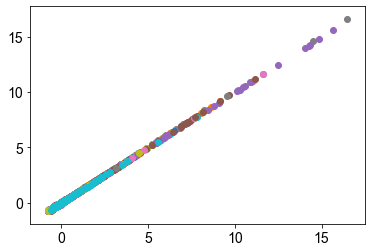

In [18]:
for i in range(20):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

In [50]:
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader

from trvaep.model._losses import MSE_kl, mmd
from trvaep.data_loader import CustomDatasetFromAdata
#from trvaep.utils import train_test_split

def train_test_split(adata, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_data = adata[train_idx, :]
    valid_data = adata[test_idx, :]
    train_data.Y = adata.Y[train_idx, :]
    valid_data.Y = adata.Y[test_idx, :]
    return train_data, valid_data


    
class Trainer:
    def __init__(self, model, adata,
                 condition_key="condition", seed=0, print_every=2000,
                 learning_rate=0.001, validation_itr=20, train_frac=0.85, n_workers=0):
        """
                trVAE Network class. This class contains the implementation of Regularized Conditional
                Variational Auto-encoder network.
                # Parameters
                    model: CVAE
                        a CVAE model object.
                    adata: `~anndata.AnnData`
                    `AnnData` object for training the model.

                    condition_key: str
                       The observation key in which data conditions are stored
                    seed: integer
                        Random seed for training initialization.

                    print_every= integer
                        How often print the loss values after, by default after every 1000 iterations.

                    learning_rate: float
                        Learning rate for the optimizer.

                    validation_itr: integer
                        How often print validation error, by default after every 5 epochs.

                    train_frac= float
                        Train-test split fraction. the model will be trained with train_frac for training
                        and 1-train_frac for validation.
                    n_workers= int
                        num of subsprocess for loading more batches for GPU. value bigger than 1 will require
                        more RAM and may increase the speed.


            """

        self.model = model
        self.adata = adata
        self.condition_key = condition_key
        self.seed = seed
        self.print_loss = print_every
        self.lr = learning_rate
        self.val_check = validation_itr
        self.train_frac = train_frac
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.device = self.device
        self.logs = defaultdict(list)
        self.model.to(self.device)
        self.n_workers = n_workers

    def make_dataset(self):
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        return data_set_train, data_set_valid

    def train_trvae(self, n_epochs=300, batch_size=512, early_patience=50):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train_trvae(100, 64)
                    ```
        """
        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            train_mmd = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)

                recon_x, mean, log_var, y_mmd = self.model(x, y,l)
                vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, x, mean, log_var, self.model.alpha)
                mmd_calculator = mmd(self.model.num_cls, self.model.beta)
                mdd_loss = mmd_calculator(y_mmd, y)
                loss = vae_loss + mdd_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                train_mmd += mdd_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, "
                          "rec_loss: {:9.4f}, KL_loss: {:9.4f}, MMD_loss:  {:9.4f}".format(
                        epoch, n_epochs, iteration, len(data_loader_train) - 1,
                        loss.item(), reconstruction_loss.item(), kl_loss.item(), mdd_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            self.logs["mmd_loss_train"].append(train_mmd / iteration)
            valid_loss, valid_rec, valid_kl, valid_mmd = self.validate(data_loader_valid, use_mmd=True)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)
            self.logs["MMD_loss_valid"].append(valid_mmd)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f},"
                      " KL_loss_valid: {:9.4f}, MMD_loss:  {:9.4f} ".format(
                    epoch, valid_loss, valid_rec, valid_kl, valid_mmd))
        self.model.eval()

    def train(self, n_epochs=100, batch_size=256, early_patience=15):

        """
                    Trains a CVAE model `n_epochs` times with given `batch_size`. This function is using `early stopping`
                    technique to prevent overfitting.
                    # Parameters
                        n_epochs: int
                            number of epochs to iterate and optimize network weights
                        batch_size: int
                            number of samples to be used in each batch for network weights optimization
                        early_patience: int
                            number of consecutive epochs in which network loss is not going lower.
                            After this limit, the network will stop training.
                    # Returns
                        Nothing will be returned
                    # Example
                    ```python
                    adata = sc.read("./data/kang_seurat.h5ad")
                    n_conditions = adata.obs["condition"].unique().shape[0]
                    adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                                          & (adata.obs["condition"] == "CTRL"))]
                    model = CVAE(adata_train.n_vars, num_classes=n_conditions,
                                 encoder_layer_sizes=[64], decoder_layer_sizes=[64], latent_dim=10, alpha=0.0001,
                                 use_mmd=True, beta=10)
                    trainer = Trainer(model, adata_train)
                    trainer.train(100, 64)
                    ```
        """

        es = EarlyStopping(patience=early_patience)
        dataset_train, dataset_valid = self.make_dataset()
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y) in enumerate(data_loader_train):
                if y is not None:
                    x, y = x.to(self.device), y.to(self.device)
                else:
                    x = x.to(self.device)
                if self.model.num_cls is not None:
                    recon_x, mean, log_var = self.model(x, y,l)
                else:
                    recon_x, mean, log_var = self.model(x)
                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x, y, mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

            if es.step(valid_loss):
                print("Training stoped with early stopping")
                break

            if epoch % self.val_check == 0 and epoch != 0:
                print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
                    epoch, valid_loss, valid_rec, valid_kl))
        self.model.eval()

    def validate(self, validation_data, use_mmd=False):
        """
                            Validat a CVAE model using  `validation_data`.
                            # Parameters
                                validation_data: `~anndata.AnnData`
                                    `AnnData` object for validating the model.
                                use_mmd: boolean
                                    If `True` the mmd loss wil be returned
                            # Returns
                                if `use_mmd` is `True` return following four `float`

                                valid_loss: float
                                    sum of all the losses

                                valid_rec: float
                                    reconstruction loss for the validation data

                                valid_kl: float
                                    KL loss for the validation data

                                valid_mmd: float
                                    MMD loss for validation data

                """
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0
            valid_rec = 0
            valid_kl = 0
            valid_mmd = 0
            for iteration, (x, y,l) in enumerate(validation_data):
                if y is not None:
                    x, y,l = x.to(self.device), y.to(self.device),l.to(self.device)

                if self.model.num_cls is not None:
                    if self.model.use_mmd:
                        recon_x, mean, log_var, y_mmd = self.model(x, y,l)
                    else:
                        recon_x, mean, log_var = self.model(x, y,l)
                else:
                    recon_x, mean, log_var = self.model(x)
                valid_vae_loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                if self.model.use_mmd:
                    mms_calculator = mmd(self.model.num_cls, 10)
                    valid_mmd = mms_calculator(y_mmd, l)#y)
                if use_mmd:
                    valid_loss += valid_vae_loss.item() + valid_mmd.item()
                else:
                    valid_loss += valid_vae_loss.item()
                valid_rec += reconstruction_loss.item()
                valid_kl += kl_loss.item()
                if use_mmd:
                    valid_mmd += valid_mmd.item()
        self.model.train()
        if iteration < 1:
            iteration = 1
        if use_mmd:
                return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration, valid_mmd / iteration
        else:
            return valid_loss / iteration, valid_rec / iteration, valid_kl / iteration


# taken from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                        best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                        best * min_delta / 100)


In [59]:
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())

In [61]:
#np.var(X_pca, axis = 0)

array([7.37554073, 7.00945726, 6.18496858, 5.39841869, 5.29749731,
       5.03318135, 4.74455638, 4.72530396, 4.22689195, 4.11354357,
       3.9091112 , 3.87563011, 3.71197099, 3.62412244, 3.47404265,
       3.40326509, 3.34160652, 3.21825969, 3.13766566, 3.09590253])

In [77]:
        xnorm = scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=20
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 5000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/5000 Batch 0000/14, Loss:   65.6495, rec_loss:   65.6466, KL_loss:    0.0028
Epoch 00/5000 Batch 0014/14, Loss:   70.5427, rec_loss:   70.5389, KL_loss:    0.0037
Epoch 01/5000 Batch 0000/14, Loss:   80.6236, rec_loss:   80.6201, KL_loss:    0.0035
Epoch 01/5000 Batch 0014/14, Loss:   54.4245, rec_loss:   54.4216, KL_loss:    0.0029
Epoch 02/5000 Batch 0000/14, Loss:   53.4506, rec_loss:   53.4478, KL_loss:    0.0028
Epoch 02/5000 Batch 0014/14, Loss:   65.7268, rec_loss:   65.7242, KL_loss:    0.0026
Epoch 03/5000 Batch 0000/14, Loss:   59.3979, rec_loss:   59.3943, KL_loss:    0.0035
Epoch 03/5000 Batch 0014/14, Loss:   70.8830, rec_loss:   70.8784, KL_loss:    0.0046
Epoch 04/5000 Batch 0000/14, Loss:   62.2605, rec_loss:   62.2553, KL_loss:    0.0052
Epoch 04/5000 Batch 0014/14, Loss:   69.7853, rec_loss:   69.7804, KL_loss:    0.0050
Epoch 05/5000 Batch 0000/14, Loss

Epoch 47/5000 Batch 0014/14, Loss:   44.0425, rec_loss:   44.0069, KL_loss:    0.0356
Epoch 48/5000 Batch 0000/14, Loss:   53.2405, rec_loss:   53.2132, KL_loss:    0.0273
Epoch 48/5000 Batch 0014/14, Loss:   53.7851, rec_loss:   53.7468, KL_loss:    0.0382
Epoch 49/5000 Batch 0000/14, Loss:   45.3887, rec_loss:   45.3536, KL_loss:    0.0351
Epoch 49/5000 Batch 0014/14, Loss:   61.9181, rec_loss:   61.8805, KL_loss:    0.0376
Epoch 50/5000 Batch 0000/14, Loss:   39.6973, rec_loss:   39.6631, KL_loss:    0.0342
Epoch 50/5000 Batch 0014/14, Loss:   37.5313, rec_loss:   37.4960, KL_loss:    0.0353
Epoch 51/5000 Batch 0000/14, Loss:   58.5660, rec_loss:   58.5248, KL_loss:    0.0412
Epoch 51/5000 Batch 0014/14, Loss:   36.6094, rec_loss:   36.5749, KL_loss:    0.0345
Epoch 52/5000 Batch 0000/14, Loss:   39.0221, rec_loss:   38.9878, KL_loss:    0.0343
Epoch 52/5000 Batch 0014/14, Loss:   77.5382, rec_loss:   77.5072, KL_loss:    0.0310
Epoch 53/5000 Batch 0000/14, Loss:   55.7984, rec_loss

Epoch 95/5000 Batch 0014/14, Loss:   41.4938, rec_loss:   41.4340, KL_loss:    0.0598
Epoch 96/5000 Batch 0000/14, Loss:   31.8540, rec_loss:   31.7968, KL_loss:    0.0572
Epoch 96/5000 Batch 0014/14, Loss:   41.8713, rec_loss:   41.8131, KL_loss:    0.0582
Epoch 97/5000 Batch 0000/14, Loss:   48.6547, rec_loss:   48.5952, KL_loss:    0.0596
Epoch 97/5000 Batch 0014/14, Loss:   52.6629, rec_loss:   52.6089, KL_loss:    0.0540
Epoch 98/5000 Batch 0000/14, Loss:   45.1798, rec_loss:   45.1277, KL_loss:    0.0520
Epoch 98/5000 Batch 0014/14, Loss:   47.7422, rec_loss:   47.6862, KL_loss:    0.0560
Epoch 99/5000 Batch 0000/14, Loss:   35.9653, rec_loss:   35.9120, KL_loss:    0.0533
Epoch 99/5000 Batch 0014/14, Loss:   39.8603, rec_loss:   39.8023, KL_loss:    0.0580
Epoch 100/5000 Batch 0000/14, Loss:   49.0063, rec_loss:   48.9461, KL_loss:    0.0602
Epoch 100/5000 Batch 0014/14, Loss:   48.2096, rec_loss:   48.1438, KL_loss:    0.0658
Epoch 101/5000 Batch 0000/14, Loss:   45.3539, rec_l

Epoch 144/5000 Batch 0014/14, Loss:   40.4031, rec_loss:   40.3424, KL_loss:    0.0607
Epoch 145/5000 Batch 0000/14, Loss:   29.8796, rec_loss:   29.8124, KL_loss:    0.0671
Epoch 145/5000 Batch 0014/14, Loss:   43.8160, rec_loss:   43.7438, KL_loss:    0.0722
Epoch 146/5000 Batch 0000/14, Loss:   53.3514, rec_loss:   53.2916, KL_loss:    0.0599
Epoch 146/5000 Batch 0014/14, Loss:   49.4294, rec_loss:   49.3578, KL_loss:    0.0716
Epoch 147/5000 Batch 0000/14, Loss:   47.9538, rec_loss:   47.8869, KL_loss:    0.0669
Epoch 147/5000 Batch 0014/14, Loss:   46.6956, rec_loss:   46.6300, KL_loss:    0.0656
Epoch 148/5000 Batch 0000/14, Loss:   60.6712, rec_loss:   60.6098, KL_loss:    0.0614
Epoch 148/5000 Batch 0014/14, Loss:   42.1393, rec_loss:   42.0762, KL_loss:    0.0631
Epoch 149/5000 Batch 0000/14, Loss:   38.5160, rec_loss:   38.4499, KL_loss:    0.0660
Epoch 149/5000 Batch 0014/14, Loss:   36.2368, rec_loss:   36.1714, KL_loss:    0.0653
Epoch 150/5000 Batch 0000/14, Loss:   42.59

Epoch 194/5000 Batch 0014/14, Loss:   30.8249, rec_loss:   30.7495, KL_loss:    0.0754
Epoch 195/5000 Batch 0000/14, Loss:   34.3495, rec_loss:   34.2786, KL_loss:    0.0709
Epoch 195/5000 Batch 0014/14, Loss:   40.1481, rec_loss:   40.0734, KL_loss:    0.0747
Epoch 196/5000 Batch 0000/14, Loss:   34.1177, rec_loss:   34.0413, KL_loss:    0.0764
Epoch 196/5000 Batch 0014/14, Loss:   46.0213, rec_loss:   45.9518, KL_loss:    0.0695
Epoch 197/5000 Batch 0000/14, Loss:   50.7068, rec_loss:   50.6364, KL_loss:    0.0704
Epoch 197/5000 Batch 0014/14, Loss:   48.7350, rec_loss:   48.6634, KL_loss:    0.0716
Epoch 198/5000 Batch 0000/14, Loss:   39.0085, rec_loss:   38.9374, KL_loss:    0.0711
Epoch 198/5000 Batch 0014/14, Loss:   45.2337, rec_loss:   45.1596, KL_loss:    0.0741
Epoch 199/5000 Batch 0000/14, Loss:   63.5324, rec_loss:   63.4577, KL_loss:    0.0747
Epoch 199/5000 Batch 0014/14, Loss:   45.2650, rec_loss:   45.1942, KL_loss:    0.0708
Epoch 200/5000 Batch 0000/14, Loss:   52.65

Epoch 243/5000 Batch 0014/14, Loss:   63.5335, rec_loss:   63.4617, KL_loss:    0.0718
Epoch 244/5000 Batch 0000/14, Loss:   35.1698, rec_loss:   35.0945, KL_loss:    0.0753
Epoch 244/5000 Batch 0014/14, Loss:   41.0026, rec_loss:   40.9288, KL_loss:    0.0738
Epoch 245/5000 Batch 0000/14, Loss:   40.8685, rec_loss:   40.7881, KL_loss:    0.0803
Epoch 245/5000 Batch 0014/14, Loss:   30.2696, rec_loss:   30.1927, KL_loss:    0.0769
Epoch 246/5000 Batch 0000/14, Loss:   38.8576, rec_loss:   38.7834, KL_loss:    0.0742
Epoch 246/5000 Batch 0014/14, Loss:   63.4479, rec_loss:   63.3729, KL_loss:    0.0750
Epoch 247/5000 Batch 0000/14, Loss:   50.5952, rec_loss:   50.5148, KL_loss:    0.0803
Epoch 247/5000 Batch 0014/14, Loss:   45.6521, rec_loss:   45.5777, KL_loss:    0.0744
Epoch 248/5000 Batch 0000/14, Loss:   27.4570, rec_loss:   27.3814, KL_loss:    0.0756
Epoch 248/5000 Batch 0014/14, Loss:   38.4032, rec_loss:   38.3258, KL_loss:    0.0774
Epoch 249/5000 Batch 0000/14, Loss:   41.03

Epoch 291/5000 Batch 0014/14, Loss:   38.3830, rec_loss:   38.2985, KL_loss:    0.0845
Epoch 292/5000 Batch 0000/14, Loss:   33.4086, rec_loss:   33.3293, KL_loss:    0.0794
Epoch 292/5000 Batch 0014/14, Loss:   47.4869, rec_loss:   47.4093, KL_loss:    0.0776
Epoch 293/5000 Batch 0000/14, Loss:   42.1345, rec_loss:   42.0572, KL_loss:    0.0773
Epoch 293/5000 Batch 0014/14, Loss:   30.5984, rec_loss:   30.5176, KL_loss:    0.0809
Epoch 294/5000 Batch 0000/14, Loss:   46.3232, rec_loss:   46.2413, KL_loss:    0.0820
Epoch 294/5000 Batch 0014/14, Loss:   35.3679, rec_loss:   35.2893, KL_loss:    0.0786
Epoch 295/5000 Batch 0000/14, Loss:   28.2960, rec_loss:   28.2114, KL_loss:    0.0847
Epoch 295/5000 Batch 0014/14, Loss:   47.9073, rec_loss:   47.8268, KL_loss:    0.0806
Epoch 296/5000 Batch 0000/14, Loss:   39.3141, rec_loss:   39.2367, KL_loss:    0.0774
Epoch 296/5000 Batch 0014/14, Loss:   35.6507, rec_loss:   35.5764, KL_loss:    0.0743
Epoch 297/5000 Batch 0000/14, Loss:   37.07

Epoch 341/5000 Batch 0014/14, Loss:   26.0078, rec_loss:   25.9254, KL_loss:    0.0824
Epoch 342/5000 Batch 0000/14, Loss:   45.9599, rec_loss:   45.8770, KL_loss:    0.0829
Epoch 342/5000 Batch 0014/14, Loss:   53.0910, rec_loss:   53.0066, KL_loss:    0.0844
Epoch 343/5000 Batch 0000/14, Loss:   33.0841, rec_loss:   33.0021, KL_loss:    0.0820
Epoch 343/5000 Batch 0014/14, Loss:   56.5949, rec_loss:   56.5160, KL_loss:    0.0789
Epoch 344/5000 Batch 0000/14, Loss:   45.2154, rec_loss:   45.1361, KL_loss:    0.0794
Epoch 344/5000 Batch 0014/14, Loss:   46.8288, rec_loss:   46.7525, KL_loss:    0.0763
Epoch 345/5000 Batch 0000/14, Loss:   43.8626, rec_loss:   43.7863, KL_loss:    0.0763
Epoch 345/5000 Batch 0014/14, Loss:   21.8743, rec_loss:   21.7878, KL_loss:    0.0864
Epoch 346/5000 Batch 0000/14, Loss:   45.9419, rec_loss:   45.8661, KL_loss:    0.0758
Epoch 346/5000 Batch 0014/14, Loss:   41.4103, rec_loss:   41.3269, KL_loss:    0.0835
Epoch 347/5000 Batch 0000/14, Loss:   41.69

Epoch 389/5000 Batch 0014/14, Loss:   52.2734, rec_loss:   52.1924, KL_loss:    0.0810
Epoch 390/5000 Batch 0000/14, Loss:   42.0043, rec_loss:   41.9201, KL_loss:    0.0842
Epoch 390/5000 Batch 0014/14, Loss:   53.7611, rec_loss:   53.6835, KL_loss:    0.0776
Epoch 391/5000 Batch 0000/14, Loss:   36.9848, rec_loss:   36.9009, KL_loss:    0.0839
Epoch 391/5000 Batch 0014/14, Loss:   54.3887, rec_loss:   54.3087, KL_loss:    0.0800
Epoch 392/5000 Batch 0000/14, Loss:   40.1654, rec_loss:   40.0781, KL_loss:    0.0873
Epoch 392/5000 Batch 0014/14, Loss:   53.6429, rec_loss:   53.5706, KL_loss:    0.0723
Epoch 393/5000 Batch 0000/14, Loss:   33.2490, rec_loss:   33.1623, KL_loss:    0.0867
Epoch 393/5000 Batch 0014/14, Loss:   58.5408, rec_loss:   58.4642, KL_loss:    0.0766
Epoch 394/5000 Batch 0000/14, Loss:   50.4825, rec_loss:   50.3992, KL_loss:    0.0833
Epoch 394/5000 Batch 0014/14, Loss:   45.3436, rec_loss:   45.2636, KL_loss:    0.0800
Epoch 395/5000 Batch 0000/14, Loss:   51.88

Epoch 438/5000 Batch 0014/14, Loss:   24.7151, rec_loss:   24.6257, KL_loss:    0.0894
Epoch 439/5000 Batch 0000/14, Loss:   35.7541, rec_loss:   35.6708, KL_loss:    0.0833
Epoch 439/5000 Batch 0014/14, Loss:   47.4209, rec_loss:   47.3363, KL_loss:    0.0846
Epoch 440/5000 Batch 0000/14, Loss:   36.3611, rec_loss:   36.2758, KL_loss:    0.0853
Epoch 440/5000 Batch 0014/14, Loss:   47.7724, rec_loss:   47.6873, KL_loss:    0.0852
Epoch 441/5000 Batch 0000/14, Loss:   30.3471, rec_loss:   30.2633, KL_loss:    0.0838
Epoch 441/5000 Batch 0014/14, Loss:   33.6738, rec_loss:   33.5921, KL_loss:    0.0817
Epoch 442/5000 Batch 0000/14, Loss:   38.1353, rec_loss:   38.0533, KL_loss:    0.0821
Epoch 442/5000 Batch 0014/14, Loss:   38.3067, rec_loss:   38.2206, KL_loss:    0.0860
Epoch 443/5000 Batch 0000/14, Loss:   39.6732, rec_loss:   39.5862, KL_loss:    0.0870
Epoch 443/5000 Batch 0014/14, Loss:   38.3089, rec_loss:   38.2193, KL_loss:    0.0896
Epoch 444/5000 Batch 0000/14, Loss:   26.56

Epoch 487/5000 Batch 0000/14, Loss:   64.1935, rec_loss:   64.1091, KL_loss:    0.0844
Epoch 487/5000 Batch 0014/14, Loss:   30.1686, rec_loss:   30.0812, KL_loss:    0.0873
Epoch 488/5000 Batch 0000/14, Loss:   41.1539, rec_loss:   41.0661, KL_loss:    0.0878
Epoch 488/5000 Batch 0014/14, Loss:   46.3033, rec_loss:   46.2201, KL_loss:    0.0832
Epoch 489/5000 Batch 0000/14, Loss:   31.6658, rec_loss:   31.5766, KL_loss:    0.0892
Epoch 489/5000 Batch 0014/14, Loss:   36.4967, rec_loss:   36.4108, KL_loss:    0.0858
Epoch 490/5000 Batch 0000/14, Loss:   36.9254, rec_loss:   36.8411, KL_loss:    0.0844
Epoch 490/5000 Batch 0014/14, Loss:   46.6652, rec_loss:   46.5799, KL_loss:    0.0853
Epoch 491/5000 Batch 0000/14, Loss:   52.1956, rec_loss:   52.1120, KL_loss:    0.0836
Epoch 491/5000 Batch 0014/14, Loss:   48.2733, rec_loss:   48.1935, KL_loss:    0.0798
Epoch 492/5000 Batch 0000/14, Loss:   63.4393, rec_loss:   63.3624, KL_loss:    0.0769
Epoch 492/5000 Batch 0014/14, Loss:   65.47

Epoch 534/5000 Batch 0014/14, Loss:   33.2100, rec_loss:   33.1212, KL_loss:    0.0888
Epoch 535/5000 Batch 0000/14, Loss:   53.9243, rec_loss:   53.8418, KL_loss:    0.0825
Epoch 535/5000 Batch 0014/14, Loss:   37.3935, rec_loss:   37.3049, KL_loss:    0.0886
Epoch 536/5000 Batch 0000/14, Loss:   49.5991, rec_loss:   49.5149, KL_loss:    0.0842
Epoch 536/5000 Batch 0014/14, Loss:   36.5004, rec_loss:   36.4172, KL_loss:    0.0832
Epoch 537/5000 Batch 0000/14, Loss:   30.4083, rec_loss:   30.3200, KL_loss:    0.0882
Epoch 537/5000 Batch 0014/14, Loss:   58.0672, rec_loss:   57.9851, KL_loss:    0.0821
Epoch 538/5000 Batch 0000/14, Loss:   38.1984, rec_loss:   38.1159, KL_loss:    0.0825
Epoch 538/5000 Batch 0014/14, Loss:   32.9487, rec_loss:   32.8618, KL_loss:    0.0869
Epoch 539/5000 Batch 0000/14, Loss:   51.0402, rec_loss:   50.9569, KL_loss:    0.0833
Epoch 539/5000 Batch 0014/14, Loss:   43.6215, rec_loss:   43.5388, KL_loss:    0.0828
Epoch 540/5000 Batch 0000/14, Loss:   35.54

Epoch 582/5000 Batch 0014/14, Loss:   41.7498, rec_loss:   41.6648, KL_loss:    0.0850
Epoch 583/5000 Batch 0000/14, Loss:   35.4363, rec_loss:   35.3493, KL_loss:    0.0870
Epoch 583/5000 Batch 0014/14, Loss:   39.7321, rec_loss:   39.6473, KL_loss:    0.0848
Epoch 584/5000 Batch 0000/14, Loss:   45.0615, rec_loss:   44.9737, KL_loss:    0.0878
Epoch 584/5000 Batch 0014/14, Loss:   38.1874, rec_loss:   38.1006, KL_loss:    0.0868
Epoch 585/5000 Batch 0000/14, Loss:   35.8112, rec_loss:   35.7282, KL_loss:    0.0830
Epoch 585/5000 Batch 0014/14, Loss:   28.9274, rec_loss:   28.8411, KL_loss:    0.0864
Epoch 586/5000 Batch 0000/14, Loss:   39.5544, rec_loss:   39.4649, KL_loss:    0.0895
Epoch 586/5000 Batch 0014/14, Loss:   30.9746, rec_loss:   30.8903, KL_loss:    0.0843
Epoch 587/5000 Batch 0000/14, Loss:   42.0992, rec_loss:   42.0108, KL_loss:    0.0884
Epoch 587/5000 Batch 0014/14, Loss:   50.6320, rec_loss:   50.5482, KL_loss:    0.0838
Epoch 588/5000 Batch 0000/14, Loss:   46.73

Epoch 630/5000 Batch 0014/14, Loss:   24.3629, rec_loss:   24.2737, KL_loss:    0.0892
Epoch 631/5000 Batch 0000/14, Loss:   32.6395, rec_loss:   32.5544, KL_loss:    0.0851
Epoch 631/5000 Batch 0014/14, Loss:   29.2989, rec_loss:   29.2102, KL_loss:    0.0887
Epoch 632/5000 Batch 0000/14, Loss:   41.6046, rec_loss:   41.5150, KL_loss:    0.0896
Epoch 632/5000 Batch 0014/14, Loss:   38.9815, rec_loss:   38.9002, KL_loss:    0.0812
Epoch 633/5000 Batch 0000/14, Loss:   31.5639, rec_loss:   31.4755, KL_loss:    0.0884
Epoch 633/5000 Batch 0014/14, Loss:   34.8627, rec_loss:   34.7728, KL_loss:    0.0899
Epoch 634/5000 Batch 0000/14, Loss:   51.9677, rec_loss:   51.8874, KL_loss:    0.0803
Epoch 634/5000 Batch 0014/14, Loss:   29.2657, rec_loss:   29.1818, KL_loss:    0.0839
Epoch 635/5000 Batch 0000/14, Loss:   55.6377, rec_loss:   55.5559, KL_loss:    0.0818
Epoch 635/5000 Batch 0014/14, Loss:   32.2857, rec_loss:   32.2021, KL_loss:    0.0836
Epoch 636/5000 Batch 0000/14, Loss:   50.43

Epoch 678/5000 Batch 0014/14, Loss:   42.8877, rec_loss:   42.8053, KL_loss:    0.0824
Epoch 679/5000 Batch 0000/14, Loss:   37.9855, rec_loss:   37.8984, KL_loss:    0.0871
Epoch 679/5000 Batch 0014/14, Loss:   59.6570, rec_loss:   59.5768, KL_loss:    0.0802
Epoch 680/5000 Batch 0000/14, Loss:   28.1868, rec_loss:   28.0921, KL_loss:    0.0947
Epoch 680/5000 Batch 0014/14, Loss:   45.7935, rec_loss:   45.7069, KL_loss:    0.0865
Epoch 681/5000 Batch 0000/14, Loss:   29.8671, rec_loss:   29.7778, KL_loss:    0.0893
Epoch 681/5000 Batch 0014/14, Loss:   37.2626, rec_loss:   37.1751, KL_loss:    0.0875
Epoch 682/5000 Batch 0000/14, Loss:   48.9519, rec_loss:   48.8683, KL_loss:    0.0836
Epoch 682/5000 Batch 0014/14, Loss:   51.3443, rec_loss:   51.2535, KL_loss:    0.0908
Epoch 683/5000 Batch 0000/14, Loss:   55.4066, rec_loss:   55.3264, KL_loss:    0.0802
Epoch 683/5000 Batch 0014/14, Loss:   67.5379, rec_loss:   67.4530, KL_loss:    0.0849
Epoch 684/5000 Batch 0000/14, Loss:   43.44

Epoch 726/5000 Batch 0014/14, Loss:   37.2121, rec_loss:   37.1254, KL_loss:    0.0866
Epoch 727/5000 Batch 0000/14, Loss:   41.5654, rec_loss:   41.4797, KL_loss:    0.0857
Epoch 727/5000 Batch 0014/14, Loss:   22.4872, rec_loss:   22.3953, KL_loss:    0.0919
Epoch 728/5000 Batch 0000/14, Loss:   45.3158, rec_loss:   45.2337, KL_loss:    0.0821
Epoch 728/5000 Batch 0014/14, Loss:   64.2168, rec_loss:   64.1352, KL_loss:    0.0815
Epoch 729/5000 Batch 0000/14, Loss:   36.5971, rec_loss:   36.5135, KL_loss:    0.0836
Epoch 729/5000 Batch 0014/14, Loss:   27.2456, rec_loss:   27.1570, KL_loss:    0.0886
Epoch 730/5000 Batch 0000/14, Loss:   36.5138, rec_loss:   36.4232, KL_loss:    0.0906
Epoch 730/5000 Batch 0014/14, Loss:   33.3174, rec_loss:   33.2278, KL_loss:    0.0896
Epoch 731/5000 Batch 0000/14, Loss:   33.3932, rec_loss:   33.3091, KL_loss:    0.0841
Epoch 731/5000 Batch 0014/14, Loss:   30.8149, rec_loss:   30.7254, KL_loss:    0.0895
Epoch 732/5000 Batch 0000/14, Loss:   51.20

Epoch 774/5000 Batch 0014/14, Loss:   55.5734, rec_loss:   55.4870, KL_loss:    0.0864
Epoch 775/5000 Batch 0000/14, Loss:   48.9649, rec_loss:   48.8800, KL_loss:    0.0849
Epoch 775/5000 Batch 0014/14, Loss:   46.8858, rec_loss:   46.7945, KL_loss:    0.0913
Epoch 776/5000 Batch 0000/14, Loss:   23.9574, rec_loss:   23.8694, KL_loss:    0.0880
Epoch 776/5000 Batch 0014/14, Loss:   41.7777, rec_loss:   41.6923, KL_loss:    0.0854
Epoch 777/5000 Batch 0000/14, Loss:   47.7434, rec_loss:   47.6566, KL_loss:    0.0868
Epoch 777/5000 Batch 0014/14, Loss:   38.2120, rec_loss:   38.1179, KL_loss:    0.0940
Epoch 778/5000 Batch 0000/14, Loss:   34.1133, rec_loss:   34.0219, KL_loss:    0.0915
Epoch 778/5000 Batch 0014/14, Loss:   32.6030, rec_loss:   32.5120, KL_loss:    0.0910
Epoch 779/5000 Batch 0000/14, Loss:   45.4636, rec_loss:   45.3735, KL_loss:    0.0901
Epoch 779/5000 Batch 0014/14, Loss:   26.5217, rec_loss:   26.4328, KL_loss:    0.0889
Epoch 780/5000 Batch 0000/14, Loss:   30.97

Epoch 822/5000 Batch 0014/14, Loss:   35.9576, rec_loss:   35.8681, KL_loss:    0.0896
Epoch 823/5000 Batch 0000/14, Loss:   49.8470, rec_loss:   49.7624, KL_loss:    0.0846
Epoch 823/5000 Batch 0014/14, Loss:   36.4466, rec_loss:   36.3612, KL_loss:    0.0854
Epoch 824/5000 Batch 0000/14, Loss:   47.5679, rec_loss:   47.4813, KL_loss:    0.0866
Epoch 824/5000 Batch 0014/14, Loss:   35.9989, rec_loss:   35.9142, KL_loss:    0.0847
Epoch 825/5000 Batch 0000/14, Loss:   42.3995, rec_loss:   42.3140, KL_loss:    0.0855
Epoch 825/5000 Batch 0014/14, Loss:   37.1112, rec_loss:   37.0255, KL_loss:    0.0857
Epoch 826/5000 Batch 0000/14, Loss:   43.7183, rec_loss:   43.6318, KL_loss:    0.0865
Epoch 826/5000 Batch 0014/14, Loss:   30.6557, rec_loss:   30.5665, KL_loss:    0.0892
Epoch 827/5000 Batch 0000/14, Loss:   28.1058, rec_loss:   28.0145, KL_loss:    0.0913
Epoch 827/5000 Batch 0014/14, Loss:   51.1542, rec_loss:   51.0693, KL_loss:    0.0848
Epoch 828/5000 Batch 0000/14, Loss:   27.50

Epoch 871/5000 Batch 0014/14, Loss:   43.7414, rec_loss:   43.6541, KL_loss:    0.0873
Epoch 872/5000 Batch 0000/14, Loss:   38.7701, rec_loss:   38.6797, KL_loss:    0.0905
Epoch 872/5000 Batch 0014/14, Loss:   65.2401, rec_loss:   65.1536, KL_loss:    0.0865
Epoch 873/5000 Batch 0000/14, Loss:   52.4830, rec_loss:   52.3995, KL_loss:    0.0835
Epoch 873/5000 Batch 0014/14, Loss:   22.0550, rec_loss:   21.9600, KL_loss:    0.0950
Epoch 874/5000 Batch 0000/14, Loss:   41.0627, rec_loss:   40.9762, KL_loss:    0.0865
Epoch 874/5000 Batch 0014/14, Loss:   29.0439, rec_loss:   28.9532, KL_loss:    0.0907
Epoch 875/5000 Batch 0000/14, Loss:   30.6116, rec_loss:   30.5263, KL_loss:    0.0853
Epoch 875/5000 Batch 0014/14, Loss:   45.1082, rec_loss:   45.0205, KL_loss:    0.0877
Epoch 876/5000 Batch 0000/14, Loss:   37.4455, rec_loss:   37.3571, KL_loss:    0.0884
Epoch 876/5000 Batch 0014/14, Loss:   53.5862, rec_loss:   53.5009, KL_loss:    0.0853
Epoch 877/5000 Batch 0000/14, Loss:   58.91

Epoch 919/5000 Batch 0014/14, Loss:   42.4179, rec_loss:   42.3253, KL_loss:    0.0926
Epoch 920/5000 Batch 0000/14, Loss:   32.0172, rec_loss:   31.9277, KL_loss:    0.0895
Epoch 920/5000 Batch 0014/14, Loss:   38.6475, rec_loss:   38.5571, KL_loss:    0.0904
Epoch 921/5000 Batch 0000/14, Loss:   72.0504, rec_loss:   71.9725, KL_loss:    0.0779
Epoch 921/5000 Batch 0014/14, Loss:   34.1460, rec_loss:   34.0572, KL_loss:    0.0889
Epoch 922/5000 Batch 0000/14, Loss:   39.8713, rec_loss:   39.7851, KL_loss:    0.0862
Epoch 922/5000 Batch 0014/14, Loss:   48.0275, rec_loss:   47.9386, KL_loss:    0.0889
Epoch 923/5000 Batch 0000/14, Loss:   59.6439, rec_loss:   59.5608, KL_loss:    0.0831
Epoch 923/5000 Batch 0014/14, Loss:   44.9888, rec_loss:   44.8974, KL_loss:    0.0914
Epoch 924/5000 Batch 0000/14, Loss:   41.9385, rec_loss:   41.8488, KL_loss:    0.0897
Epoch 924/5000 Batch 0014/14, Loss:   38.3714, rec_loss:   38.2787, KL_loss:    0.0928
Epoch 925/5000 Batch 0000/14, Loss:   32.68

Epoch 967/5000 Batch 0014/14, Loss:   48.7524, rec_loss:   48.6675, KL_loss:    0.0849
Epoch 968/5000 Batch 0000/14, Loss:   27.0089, rec_loss:   26.9224, KL_loss:    0.0865
Epoch 968/5000 Batch 0014/14, Loss:   43.4131, rec_loss:   43.3272, KL_loss:    0.0859
Epoch 969/5000 Batch 0000/14, Loss:   44.8860, rec_loss:   44.8003, KL_loss:    0.0857
Epoch 969/5000 Batch 0014/14, Loss:   45.2128, rec_loss:   45.1275, KL_loss:    0.0853
Epoch 970/5000 Batch 0000/14, Loss:   43.4816, rec_loss:   43.3969, KL_loss:    0.0847
Epoch 970/5000 Batch 0014/14, Loss:   31.8861, rec_loss:   31.7998, KL_loss:    0.0863
Epoch 971/5000 Batch 0000/14, Loss:   27.5439, rec_loss:   27.4556, KL_loss:    0.0883
Epoch 971/5000 Batch 0014/14, Loss:   23.8473, rec_loss:   23.7556, KL_loss:    0.0917
Epoch 972/5000 Batch 0000/14, Loss:   23.8528, rec_loss:   23.7629, KL_loss:    0.0899
Epoch 972/5000 Batch 0014/14, Loss:   32.5413, rec_loss:   32.4550, KL_loss:    0.0863
Epoch 973/5000 Batch 0000/14, Loss:   43.13

Epoch 1015/5000 Batch 0014/14, Loss:   41.4720, rec_loss:   41.3860, KL_loss:    0.0859
Epoch 1016/5000 Batch 0000/14, Loss:   47.8162, rec_loss:   47.7271, KL_loss:    0.0891
Epoch 1016/5000 Batch 0014/14, Loss:   30.6626, rec_loss:   30.5794, KL_loss:    0.0832
Epoch 1017/5000 Batch 0000/14, Loss:   52.8039, rec_loss:   52.7190, KL_loss:    0.0849
Epoch 1017/5000 Batch 0014/14, Loss:   35.8814, rec_loss:   35.7975, KL_loss:    0.0839
Epoch 1018/5000 Batch 0000/14, Loss:   30.5799, rec_loss:   30.4948, KL_loss:    0.0851
Epoch 1018/5000 Batch 0014/14, Loss:   39.4473, rec_loss:   39.3590, KL_loss:    0.0883
Epoch 1019/5000 Batch 0000/14, Loss:   34.9494, rec_loss:   34.8650, KL_loss:    0.0844
Epoch 1019/5000 Batch 0014/14, Loss:   33.3666, rec_loss:   33.2829, KL_loss:    0.0837
Epoch 1020/5000 Batch 0000/14, Loss:   39.3094, rec_loss:   39.2222, KL_loss:    0.0872
Epoch 1020/5000 Batch 0014/14, Loss:   32.8932, rec_loss:   32.8055, KL_loss:    0.0877
Epoch 1021/5000 Batch 0000/14, L

Epoch 1063/5000 Batch 0014/14, Loss:   46.5109, rec_loss:   46.4216, KL_loss:    0.0893
Epoch 1064/5000 Batch 0000/14, Loss:   50.6625, rec_loss:   50.5756, KL_loss:    0.0869
Epoch 1064/5000 Batch 0014/14, Loss:   36.8555, rec_loss:   36.7665, KL_loss:    0.0889
Epoch 1065/5000 Batch 0000/14, Loss:   36.2815, rec_loss:   36.1922, KL_loss:    0.0894
Epoch 1065/5000 Batch 0014/14, Loss:   38.3463, rec_loss:   38.2576, KL_loss:    0.0887
Epoch 1066/5000 Batch 0000/14, Loss:   28.9863, rec_loss:   28.8935, KL_loss:    0.0928
Epoch 1066/5000 Batch 0014/14, Loss:   66.9960, rec_loss:   66.9147, KL_loss:    0.0813
Epoch 1067/5000 Batch 0000/14, Loss:   37.3731, rec_loss:   37.2869, KL_loss:    0.0862
Epoch 1067/5000 Batch 0014/14, Loss:   34.0178, rec_loss:   33.9264, KL_loss:    0.0913
Epoch 1068/5000 Batch 0000/14, Loss:   59.6064, rec_loss:   59.5212, KL_loss:    0.0851
Epoch 1068/5000 Batch 0014/14, Loss:   44.3032, rec_loss:   44.2096, KL_loss:    0.0936
Epoch 1069/5000 Batch 0000/14, L

Epoch 1111/5000 Batch 0014/14, Loss:   59.6292, rec_loss:   59.5412, KL_loss:    0.0879
Epoch 1112/5000 Batch 0000/14, Loss:   30.7819, rec_loss:   30.6989, KL_loss:    0.0830
Epoch 1112/5000 Batch 0014/14, Loss:   37.9950, rec_loss:   37.9031, KL_loss:    0.0919
Epoch 1113/5000 Batch 0000/14, Loss:   47.2390, rec_loss:   47.1530, KL_loss:    0.0860
Epoch 1113/5000 Batch 0014/14, Loss:   36.1058, rec_loss:   36.0143, KL_loss:    0.0915
Epoch 1114/5000 Batch 0000/14, Loss:   26.8396, rec_loss:   26.7476, KL_loss:    0.0920
Epoch 1114/5000 Batch 0014/14, Loss:   31.1710, rec_loss:   31.0791, KL_loss:    0.0919
Epoch 1115/5000 Batch 0000/14, Loss:   41.1380, rec_loss:   41.0509, KL_loss:    0.0872
Epoch 1115/5000 Batch 0014/14, Loss:   33.2851, rec_loss:   33.1911, KL_loss:    0.0940
Epoch 1116/5000 Batch 0000/14, Loss:   37.0027, rec_loss:   36.9119, KL_loss:    0.0908
Epoch 1116/5000 Batch 0014/14, Loss:   39.1074, rec_loss:   39.0175, KL_loss:    0.0899
Epoch 1117/5000 Batch 0000/14, L

Epoch 1159/5000 Batch 0014/14, Loss:   34.8003, rec_loss:   34.7104, KL_loss:    0.0899
Epoch 1160/5000 Batch 0000/14, Loss:   36.6474, rec_loss:   36.5533, KL_loss:    0.0941
Epoch 1160/5000 Batch 0014/14, Loss:   47.0547, rec_loss:   46.9648, KL_loss:    0.0900
Epoch 1161/5000 Batch 0000/14, Loss:   35.2941, rec_loss:   35.2055, KL_loss:    0.0886
Epoch 1161/5000 Batch 0014/14, Loss:   37.9223, rec_loss:   37.8343, KL_loss:    0.0880
Epoch 1162/5000 Batch 0000/14, Loss:   29.6085, rec_loss:   29.5200, KL_loss:    0.0885
Epoch 1162/5000 Batch 0014/14, Loss:   40.1541, rec_loss:   40.0643, KL_loss:    0.0898
Epoch 1163/5000 Batch 0000/14, Loss:   34.3982, rec_loss:   34.3028, KL_loss:    0.0954
Epoch 1163/5000 Batch 0014/14, Loss:   44.1597, rec_loss:   44.0678, KL_loss:    0.0918
Epoch 1164/5000 Batch 0000/14, Loss:   29.1043, rec_loss:   29.0130, KL_loss:    0.0914
Epoch 1164/5000 Batch 0014/14, Loss:   44.9791, rec_loss:   44.8883, KL_loss:    0.0907
Epoch 1165/5000 Batch 0000/14, L

Epoch 1207/5000 Batch 0014/14, Loss:   29.8196, rec_loss:   29.7302, KL_loss:    0.0894
Epoch 1208/5000 Batch 0000/14, Loss:   28.9868, rec_loss:   28.8956, KL_loss:    0.0912
Epoch 1208/5000 Batch 0014/14, Loss:   38.7991, rec_loss:   38.7101, KL_loss:    0.0890
Epoch 1209/5000 Batch 0000/14, Loss:   50.7107, rec_loss:   50.6206, KL_loss:    0.0901
Epoch 1209/5000 Batch 0014/14, Loss:   43.2577, rec_loss:   43.1675, KL_loss:    0.0902
Epoch 1210/5000 Batch 0000/14, Loss:   38.3497, rec_loss:   38.2630, KL_loss:    0.0867
Epoch 1210/5000 Batch 0014/14, Loss:   24.6596, rec_loss:   24.5676, KL_loss:    0.0920
Epoch 1211/5000 Batch 0000/14, Loss:   29.5167, rec_loss:   29.4234, KL_loss:    0.0932
Epoch 1211/5000 Batch 0014/14, Loss:   47.9544, rec_loss:   47.8631, KL_loss:    0.0913
Epoch 1212/5000 Batch 0000/14, Loss:   41.5977, rec_loss:   41.5121, KL_loss:    0.0855
Epoch 1212/5000 Batch 0014/14, Loss:   41.6958, rec_loss:   41.6064, KL_loss:    0.0894
Epoch 1213/5000 Batch 0000/14, L

Epoch 1255/5000 Batch 0014/14, Loss:   53.5485, rec_loss:   53.4618, KL_loss:    0.0867
Epoch 1256/5000 Batch 0000/14, Loss:   42.0005, rec_loss:   41.9085, KL_loss:    0.0919
Epoch 1256/5000 Batch 0014/14, Loss:   46.1880, rec_loss:   46.0987, KL_loss:    0.0893
Epoch 1257/5000 Batch 0000/14, Loss:   35.7747, rec_loss:   35.6867, KL_loss:    0.0879
Epoch 1257/5000 Batch 0014/14, Loss:   39.9264, rec_loss:   39.8346, KL_loss:    0.0918
Epoch 1258/5000 Batch 0000/14, Loss:   36.6509, rec_loss:   36.5584, KL_loss:    0.0925
Epoch 1258/5000 Batch 0014/14, Loss:   45.3566, rec_loss:   45.2624, KL_loss:    0.0942
Epoch 1259/5000 Batch 0000/14, Loss:   38.3438, rec_loss:   38.2517, KL_loss:    0.0921
Epoch 1259/5000 Batch 0014/14, Loss:   44.4674, rec_loss:   44.3780, KL_loss:    0.0894
Epoch 1260/5000 Batch 0000/14, Loss:   28.0778, rec_loss:   27.9850, KL_loss:    0.0928
Epoch 1260/5000 Batch 0014/14, Loss:   47.4414, rec_loss:   47.3417, KL_loss:    0.0997
Epoch 1261/5000 Batch 0000/14, L

Epoch 1302/5000 Batch 0014/14, Loss:   23.2019, rec_loss:   23.1072, KL_loss:    0.0947
Epoch 1303/5000 Batch 0000/14, Loss:   45.0545, rec_loss:   44.9639, KL_loss:    0.0905
Epoch 1303/5000 Batch 0014/14, Loss:   44.0142, rec_loss:   43.9209, KL_loss:    0.0933
Epoch 1304/5000 Batch 0000/14, Loss:   42.4015, rec_loss:   42.3104, KL_loss:    0.0911
Epoch 1304/5000 Batch 0014/14, Loss:   46.3325, rec_loss:   46.2432, KL_loss:    0.0893
Epoch 1305/5000 Batch 0000/14, Loss:   42.6222, rec_loss:   42.5285, KL_loss:    0.0937
Epoch 1305/5000 Batch 0014/14, Loss:   35.6423, rec_loss:   35.5524, KL_loss:    0.0899
Epoch 1306/5000 Batch 0000/14, Loss:   56.9637, rec_loss:   56.8760, KL_loss:    0.0877
Epoch 1306/5000 Batch 0014/14, Loss:   44.8039, rec_loss:   44.7168, KL_loss:    0.0871
Epoch 1307/5000 Batch 0000/14, Loss:   32.5401, rec_loss:   32.4505, KL_loss:    0.0896
Epoch 1307/5000 Batch 0014/14, Loss:   32.8970, rec_loss:   32.8055, KL_loss:    0.0916
Epoch 1308/5000 Batch 0000/14, L

Epoch 1351/5000 Batch 0000/14, Loss:   53.6741, rec_loss:   53.5852, KL_loss:    0.0888
Epoch 1351/5000 Batch 0014/14, Loss:   47.0906, rec_loss:   46.9982, KL_loss:    0.0924
Epoch 1352/5000 Batch 0000/14, Loss:   47.6543, rec_loss:   47.5626, KL_loss:    0.0917
Epoch 1352/5000 Batch 0014/14, Loss:   43.1208, rec_loss:   43.0326, KL_loss:    0.0882
Epoch 1353/5000 Batch 0000/14, Loss:   33.9145, rec_loss:   33.8261, KL_loss:    0.0884
Epoch 1353/5000 Batch 0014/14, Loss:   34.0961, rec_loss:   34.0034, KL_loss:    0.0927
Epoch 1354/5000 Batch 0000/14, Loss:   37.4690, rec_loss:   37.3817, KL_loss:    0.0873
Epoch 1354/5000 Batch 0014/14, Loss:   34.2564, rec_loss:   34.1675, KL_loss:    0.0888
Epoch 1355/5000 Batch 0000/14, Loss:   46.7034, rec_loss:   46.6147, KL_loss:    0.0887
Epoch 1355/5000 Batch 0014/14, Loss:   37.6738, rec_loss:   37.5831, KL_loss:    0.0906
Epoch 1356/5000 Batch 0000/14, Loss:   44.6958, rec_loss:   44.5999, KL_loss:    0.0959
Epoch 1356/5000 Batch 0014/14, L

Epoch 1399/5000 Batch 0014/14, Loss:   34.2887, rec_loss:   34.1974, KL_loss:    0.0913
Epoch 1400/5000 Batch 0000/14, Loss:   48.6367, rec_loss:   48.5499, KL_loss:    0.0868
Epoch 1400/5000 Batch 0014/14, Loss:   26.9279, rec_loss:   26.8405, KL_loss:    0.0874
Epoch 1401/5000 Batch 0000/14, Loss:   39.3666, rec_loss:   39.2738, KL_loss:    0.0928
Epoch 1401/5000 Batch 0014/14, Loss:   44.5045, rec_loss:   44.4137, KL_loss:    0.0909
Epoch 1402/5000 Batch 0000/14, Loss:   41.4026, rec_loss:   41.3152, KL_loss:    0.0875
Epoch 1402/5000 Batch 0014/14, Loss:   58.8116, rec_loss:   58.7231, KL_loss:    0.0885
Epoch 1403/5000 Batch 0000/14, Loss:   39.3981, rec_loss:   39.3031, KL_loss:    0.0950
Epoch 1403/5000 Batch 0014/14, Loss:   29.1747, rec_loss:   29.0867, KL_loss:    0.0880
Epoch 1404/5000 Batch 0000/14, Loss:   31.5046, rec_loss:   31.4113, KL_loss:    0.0933
Epoch 1404/5000 Batch 0014/14, Loss:   41.7127, rec_loss:   41.6229, KL_loss:    0.0898
Epoch 1405/5000 Batch 0000/14, L

Epoch 1446/5000 Batch 0014/14, Loss:   33.3138, rec_loss:   33.2221, KL_loss:    0.0918
Epoch 1447/5000 Batch 0000/14, Loss:   29.2168, rec_loss:   29.1270, KL_loss:    0.0899
Epoch 1447/5000 Batch 0014/14, Loss:   24.3364, rec_loss:   24.2421, KL_loss:    0.0942
Epoch 1448/5000 Batch 0000/14, Loss:   48.5072, rec_loss:   48.4147, KL_loss:    0.0924
Epoch 1448/5000 Batch 0014/14, Loss:   39.9435, rec_loss:   39.8511, KL_loss:    0.0924
Epoch 1449/5000 Batch 0000/14, Loss:   33.4525, rec_loss:   33.3601, KL_loss:    0.0924
Epoch 1449/5000 Batch 0014/14, Loss:   30.0630, rec_loss:   29.9718, KL_loss:    0.0913
Epoch 1450/5000 Batch 0000/14, Loss:   39.0542, rec_loss:   38.9624, KL_loss:    0.0919
Epoch 1450/5000 Batch 0014/14, Loss:   36.2038, rec_loss:   36.1148, KL_loss:    0.0890
Epoch 1451/5000 Batch 0000/14, Loss:   34.9134, rec_loss:   34.8181, KL_loss:    0.0952
Epoch 1451/5000 Batch 0014/14, Loss:   38.5746, rec_loss:   38.4799, KL_loss:    0.0947
Epoch 1452/5000 Batch 0000/14, L

Epoch 1495/5000 Batch 0000/14, Loss:   38.6477, rec_loss:   38.5610, KL_loss:    0.0866
Epoch 1495/5000 Batch 0014/14, Loss:   43.8316, rec_loss:   43.7430, KL_loss:    0.0886
Epoch 1496/5000 Batch 0000/14, Loss:   31.7076, rec_loss:   31.6123, KL_loss:    0.0953
Epoch 1496/5000 Batch 0014/14, Loss:   57.8428, rec_loss:   57.7544, KL_loss:    0.0884
Epoch 1497/5000 Batch 0000/14, Loss:   34.0550, rec_loss:   33.9590, KL_loss:    0.0961
Epoch 1497/5000 Batch 0014/14, Loss:   38.7254, rec_loss:   38.6342, KL_loss:    0.0912
Epoch 1498/5000 Batch 0000/14, Loss:   50.4236, rec_loss:   50.3331, KL_loss:    0.0906
Epoch 1498/5000 Batch 0014/14, Loss:   30.9222, rec_loss:   30.8325, KL_loss:    0.0897
Epoch 1499/5000 Batch 0000/14, Loss:   36.7093, rec_loss:   36.6194, KL_loss:    0.0899
Epoch 1499/5000 Batch 0014/14, Loss:   59.5188, rec_loss:   59.4327, KL_loss:    0.0861
Epoch 1500/5000 Batch 0000/14, Loss:   28.7781, rec_loss:   28.6833, KL_loss:    0.0949
Epoch 1500/5000 Batch 0014/14, L

Epoch 1542/5000 Batch 0014/14, Loss:   55.6808, rec_loss:   55.5932, KL_loss:    0.0875
Epoch 1543/5000 Batch 0000/14, Loss:   33.3747, rec_loss:   33.2834, KL_loss:    0.0913
Epoch 1543/5000 Batch 0014/14, Loss:   40.5828, rec_loss:   40.4925, KL_loss:    0.0904
Epoch 1544/5000 Batch 0000/14, Loss:   30.1660, rec_loss:   30.0765, KL_loss:    0.0895
Epoch 1544/5000 Batch 0014/14, Loss:   35.1687, rec_loss:   35.0771, KL_loss:    0.0916
Epoch 1545/5000 Batch 0000/14, Loss:   32.0234, rec_loss:   31.9329, KL_loss:    0.0906
Epoch 1545/5000 Batch 0014/14, Loss:   25.3203, rec_loss:   25.2303, KL_loss:    0.0900
Epoch 1546/5000 Batch 0000/14, Loss:   28.6346, rec_loss:   28.5454, KL_loss:    0.0892
Epoch 1546/5000 Batch 0014/14, Loss:   45.8115, rec_loss:   45.7250, KL_loss:    0.0864
Epoch 1547/5000 Batch 0000/14, Loss:   43.9086, rec_loss:   43.8180, KL_loss:    0.0906
Epoch 1547/5000 Batch 0014/14, Loss:   35.5667, rec_loss:   35.4791, KL_loss:    0.0876
Epoch 1548/5000 Batch 0000/14, L

Epoch 1590/5000 Batch 0014/14, Loss:   46.1772, rec_loss:   46.0848, KL_loss:    0.0924
Epoch 1591/5000 Batch 0000/14, Loss:   30.7788, rec_loss:   30.6913, KL_loss:    0.0876
Epoch 1591/5000 Batch 0014/14, Loss:   29.4790, rec_loss:   29.3851, KL_loss:    0.0939
Epoch 1592/5000 Batch 0000/14, Loss:   30.9130, rec_loss:   30.8201, KL_loss:    0.0929
Epoch 1592/5000 Batch 0014/14, Loss:   35.0108, rec_loss:   34.9217, KL_loss:    0.0892
Epoch 1593/5000 Batch 0000/14, Loss:   38.2174, rec_loss:   38.1273, KL_loss:    0.0901
Epoch 1593/5000 Batch 0014/14, Loss:   40.6185, rec_loss:   40.5281, KL_loss:    0.0904
Epoch 1594/5000 Batch 0000/14, Loss:   39.1344, rec_loss:   39.0401, KL_loss:    0.0943
Epoch 1594/5000 Batch 0014/14, Loss:   40.7129, rec_loss:   40.6212, KL_loss:    0.0917
Epoch 1595/5000 Batch 0000/14, Loss:   32.3334, rec_loss:   32.2391, KL_loss:    0.0943
Epoch 1595/5000 Batch 0014/14, Loss:   33.7658, rec_loss:   33.6753, KL_loss:    0.0905
Epoch 1596/5000 Batch 0000/14, L

Epoch 1638/5000 Batch 0014/14, Loss:   37.1844, rec_loss:   37.0952, KL_loss:    0.0892
Epoch 1639/5000 Batch 0000/14, Loss:   38.2676, rec_loss:   38.1762, KL_loss:    0.0913
Epoch 1639/5000 Batch 0014/14, Loss:   39.7341, rec_loss:   39.6429, KL_loss:    0.0912
Epoch 1640/5000 Batch 0000/14, Loss:   48.4204, rec_loss:   48.3345, KL_loss:    0.0859
Epoch 1640/5000 Batch 0014/14, Loss:   56.9657, rec_loss:   56.8794, KL_loss:    0.0863
Epoch 1641/5000 Batch 0000/14, Loss:   44.6668, rec_loss:   44.5784, KL_loss:    0.0884
Epoch 1641/5000 Batch 0014/14, Loss:   55.8180, rec_loss:   55.7310, KL_loss:    0.0870
Epoch 1642/5000 Batch 0000/14, Loss:   38.5938, rec_loss:   38.5013, KL_loss:    0.0925
Epoch 1642/5000 Batch 0014/14, Loss:   38.3050, rec_loss:   38.2135, KL_loss:    0.0915
Epoch 1643/5000 Batch 0000/14, Loss:   37.6635, rec_loss:   37.5642, KL_loss:    0.0993
Epoch 1643/5000 Batch 0014/14, Loss:   47.2360, rec_loss:   47.1441, KL_loss:    0.0919
Epoch 1644/5000 Batch 0000/14, L

Epoch 1687/5000 Batch 0000/14, Loss:   32.5734, rec_loss:   32.4800, KL_loss:    0.0935
Epoch 1687/5000 Batch 0014/14, Loss:   26.5708, rec_loss:   26.4764, KL_loss:    0.0944
Epoch 1688/5000 Batch 0000/14, Loss:   28.9323, rec_loss:   28.8345, KL_loss:    0.0978
Epoch 1688/5000 Batch 0014/14, Loss:   57.2193, rec_loss:   57.1327, KL_loss:    0.0867
Epoch 1689/5000 Batch 0000/14, Loss:   31.3062, rec_loss:   31.2187, KL_loss:    0.0875
Epoch 1689/5000 Batch 0014/14, Loss:   42.9128, rec_loss:   42.8251, KL_loss:    0.0877
Epoch 1690/5000 Batch 0000/14, Loss:   42.6598, rec_loss:   42.5727, KL_loss:    0.0872
Epoch 1690/5000 Batch 0014/14, Loss:   53.3625, rec_loss:   53.2729, KL_loss:    0.0896
Epoch 1691/5000 Batch 0000/14, Loss:   37.2389, rec_loss:   37.1467, KL_loss:    0.0922
Epoch 1691/5000 Batch 0014/14, Loss:   56.5400, rec_loss:   56.4530, KL_loss:    0.0870
Epoch 1692/5000 Batch 0000/14, Loss:   32.2930, rec_loss:   32.2032, KL_loss:    0.0899
Epoch 1692/5000 Batch 0014/14, L

Epoch 1736/5000 Batch 0000/14, Loss:   37.7745, rec_loss:   37.6831, KL_loss:    0.0914
Epoch 1736/5000 Batch 0014/14, Loss:   42.2698, rec_loss:   42.1797, KL_loss:    0.0901
Epoch 1737/5000 Batch 0000/14, Loss:   41.9875, rec_loss:   41.8950, KL_loss:    0.0925
Epoch 1737/5000 Batch 0014/14, Loss:   40.7963, rec_loss:   40.7079, KL_loss:    0.0884
Epoch 1738/5000 Batch 0000/14, Loss:   24.3677, rec_loss:   24.2757, KL_loss:    0.0920
Epoch 1738/5000 Batch 0014/14, Loss:   40.5872, rec_loss:   40.4915, KL_loss:    0.0957
Epoch 1739/5000 Batch 0000/14, Loss:   55.0292, rec_loss:   54.9412, KL_loss:    0.0881
Epoch 1739/5000 Batch 0014/14, Loss:   45.5560, rec_loss:   45.4674, KL_loss:    0.0886
Epoch 1740/5000 Batch 0000/14, Loss:   44.9665, rec_loss:   44.8786, KL_loss:    0.0880
Epoch 1740/5000 Batch 0014/14, Loss:   53.5244, rec_loss:   53.4287, KL_loss:    0.0957
Epoch 1741/5000 Batch 0000/14, Loss:   45.1201, rec_loss:   45.0264, KL_loss:    0.0938
Epoch 1741/5000 Batch 0014/14, L

Epoch 1783/5000 Batch 0014/14, Loss:   28.3436, rec_loss:   28.2543, KL_loss:    0.0893
Epoch 1784/5000 Batch 0000/14, Loss:   45.5699, rec_loss:   45.4804, KL_loss:    0.0895
Epoch 1784/5000 Batch 0014/14, Loss:   44.9458, rec_loss:   44.8597, KL_loss:    0.0861
Epoch 1785/5000 Batch 0000/14, Loss:   44.7866, rec_loss:   44.6966, KL_loss:    0.0900
Epoch 1785/5000 Batch 0014/14, Loss:   43.8786, rec_loss:   43.7918, KL_loss:    0.0868
Epoch 1786/5000 Batch 0000/14, Loss:   42.9803, rec_loss:   42.8885, KL_loss:    0.0917
Epoch 1786/5000 Batch 0014/14, Loss:   73.5780, rec_loss:   73.4931, KL_loss:    0.0849
Epoch 1787/5000 Batch 0000/14, Loss:   59.2335, rec_loss:   59.1426, KL_loss:    0.0909
Epoch 1787/5000 Batch 0014/14, Loss:   29.9905, rec_loss:   29.8966, KL_loss:    0.0939
Epoch 1788/5000 Batch 0000/14, Loss:   37.9429, rec_loss:   37.8481, KL_loss:    0.0948
Epoch 1788/5000 Batch 0014/14, Loss:   38.2950, rec_loss:   38.2019, KL_loss:    0.0931
Epoch 1789/5000 Batch 0000/14, L

Epoch 1832/5000 Batch 0014/14, Loss:   44.4019, rec_loss:   44.3109, KL_loss:    0.0910
Epoch 1833/5000 Batch 0000/14, Loss:   40.8916, rec_loss:   40.8075, KL_loss:    0.0841
Epoch 1833/5000 Batch 0014/14, Loss:   37.6453, rec_loss:   37.5537, KL_loss:    0.0915
Epoch 1834/5000 Batch 0000/14, Loss:   24.1977, rec_loss:   24.1054, KL_loss:    0.0922
Epoch 1834/5000 Batch 0014/14, Loss:   51.4894, rec_loss:   51.3984, KL_loss:    0.0910
Epoch 1835/5000 Batch 0000/14, Loss:   44.2872, rec_loss:   44.1980, KL_loss:    0.0892
Epoch 1835/5000 Batch 0014/14, Loss:   28.2964, rec_loss:   28.2036, KL_loss:    0.0928
Epoch 1836/5000 Batch 0000/14, Loss:   53.1796, rec_loss:   53.0936, KL_loss:    0.0859
Epoch 1836/5000 Batch 0014/14, Loss:   37.5669, rec_loss:   37.4790, KL_loss:    0.0879
Epoch 1837/5000 Batch 0000/14, Loss:   40.6420, rec_loss:   40.5498, KL_loss:    0.0923
Epoch 1837/5000 Batch 0014/14, Loss:   67.3388, rec_loss:   67.2513, KL_loss:    0.0875
Epoch 1838/5000 Batch 0000/14, L

Epoch 1881/5000 Batch 0014/14, Loss:   29.3123, rec_loss:   29.2178, KL_loss:    0.0946
Epoch 1882/5000 Batch 0000/14, Loss:   55.9707, rec_loss:   55.8768, KL_loss:    0.0940
Epoch 1882/5000 Batch 0014/14, Loss:   26.3032, rec_loss:   26.2098, KL_loss:    0.0934
Epoch 1883/5000 Batch 0000/14, Loss:   43.4937, rec_loss:   43.3997, KL_loss:    0.0940
Epoch 1883/5000 Batch 0014/14, Loss:   46.8017, rec_loss:   46.7095, KL_loss:    0.0922
Epoch 1884/5000 Batch 0000/14, Loss:   31.9028, rec_loss:   31.8071, KL_loss:    0.0957
Epoch 1884/5000 Batch 0014/14, Loss:   30.5459, rec_loss:   30.4552, KL_loss:    0.0906
Epoch 1885/5000 Batch 0000/14, Loss:   35.4345, rec_loss:   35.3413, KL_loss:    0.0932
Epoch 1885/5000 Batch 0014/14, Loss:   36.9806, rec_loss:   36.8904, KL_loss:    0.0902
Epoch 1886/5000 Batch 0000/14, Loss:   33.2966, rec_loss:   33.2069, KL_loss:    0.0898
Epoch 1886/5000 Batch 0014/14, Loss:   41.4533, rec_loss:   41.3590, KL_loss:    0.0943
Epoch 1887/5000 Batch 0000/14, L

Epoch 1930/5000 Batch 0000/14, Loss:   43.5891, rec_loss:   43.4961, KL_loss:    0.0929
Epoch 1930/5000 Batch 0014/14, Loss:   47.9121, rec_loss:   47.8222, KL_loss:    0.0899
Epoch 1931/5000 Batch 0000/14, Loss:   45.6136, rec_loss:   45.5294, KL_loss:    0.0842
Epoch 1931/5000 Batch 0014/14, Loss:   46.0307, rec_loss:   45.9387, KL_loss:    0.0920
Epoch 1932/5000 Batch 0000/14, Loss:   36.8007, rec_loss:   36.7097, KL_loss:    0.0910
Epoch 1932/5000 Batch 0014/14, Loss:   36.9126, rec_loss:   36.8226, KL_loss:    0.0900
Epoch 1933/5000 Batch 0000/14, Loss:   38.9273, rec_loss:   38.8355, KL_loss:    0.0917
Epoch 1933/5000 Batch 0014/14, Loss:   43.7335, rec_loss:   43.6446, KL_loss:    0.0889
Epoch 1934/5000 Batch 0000/14, Loss:   32.6054, rec_loss:   32.5147, KL_loss:    0.0908
Epoch 1934/5000 Batch 0014/14, Loss:   35.5247, rec_loss:   35.4291, KL_loss:    0.0956
Epoch 1935/5000 Batch 0000/14, Loss:   52.6885, rec_loss:   52.5979, KL_loss:    0.0906
Epoch 1935/5000 Batch 0014/14, L

Epoch 1978/5000 Batch 0014/14, Loss:   48.4968, rec_loss:   48.4036, KL_loss:    0.0932
Epoch 1979/5000 Batch 0000/14, Loss:   24.0377, rec_loss:   23.9432, KL_loss:    0.0945
Epoch 1979/5000 Batch 0014/14, Loss:   35.3590, rec_loss:   35.2672, KL_loss:    0.0918
Epoch 1980/5000 Batch 0000/14, Loss:   29.4621, rec_loss:   29.3674, KL_loss:    0.0946
Epoch 1980/5000 Batch 0014/14, Loss:   40.2411, rec_loss:   40.1470, KL_loss:    0.0941
Epoch 1981/5000 Batch 0000/14, Loss:   43.6753, rec_loss:   43.5879, KL_loss:    0.0874
Epoch 1981/5000 Batch 0014/14, Loss:   52.4106, rec_loss:   52.3239, KL_loss:    0.0867
Epoch 1982/5000 Batch 0000/14, Loss:   23.1422, rec_loss:   23.0485, KL_loss:    0.0937
Epoch 1982/5000 Batch 0014/14, Loss:   25.2297, rec_loss:   25.1377, KL_loss:    0.0920
Epoch 1983/5000 Batch 0000/14, Loss:   35.6694, rec_loss:   35.5822, KL_loss:    0.0872
Epoch 1983/5000 Batch 0014/14, Loss:   35.9965, rec_loss:   35.9021, KL_loss:    0.0944
Epoch 1984/5000 Batch 0000/14, L

Epoch 2026/5000 Batch 0014/14, Loss:   34.6012, rec_loss:   34.5077, KL_loss:    0.0935
Epoch 2027/5000 Batch 0000/14, Loss:   37.5028, rec_loss:   37.4109, KL_loss:    0.0920
Epoch 2027/5000 Batch 0014/14, Loss:   27.2458, rec_loss:   27.1511, KL_loss:    0.0946
Epoch 2028/5000 Batch 0000/14, Loss:   50.5789, rec_loss:   50.4866, KL_loss:    0.0923
Epoch 2028/5000 Batch 0014/14, Loss:   38.0895, rec_loss:   37.9960, KL_loss:    0.0935
Epoch 2029/5000 Batch 0000/14, Loss:   51.4991, rec_loss:   51.4076, KL_loss:    0.0915
Epoch 2029/5000 Batch 0014/14, Loss:   54.0076, rec_loss:   53.9168, KL_loss:    0.0909
Epoch 2030/5000 Batch 0000/14, Loss:   43.6638, rec_loss:   43.5711, KL_loss:    0.0927
Epoch 2030/5000 Batch 0014/14, Loss:   36.6776, rec_loss:   36.5918, KL_loss:    0.0858
Epoch 2031/5000 Batch 0000/14, Loss:   27.6275, rec_loss:   27.5320, KL_loss:    0.0956
Epoch 2031/5000 Batch 0014/14, Loss:   36.2501, rec_loss:   36.1597, KL_loss:    0.0904
Epoch 2032/5000 Batch 0000/14, L

Epoch 2074/5000 Batch 0014/14, Loss:   35.7950, rec_loss:   35.7082, KL_loss:    0.0868
Epoch 2075/5000 Batch 0000/14, Loss:   25.3024, rec_loss:   25.2091, KL_loss:    0.0933
Epoch 2075/5000 Batch 0014/14, Loss:   45.0711, rec_loss:   44.9774, KL_loss:    0.0937
Epoch 2076/5000 Batch 0000/14, Loss:   33.3198, rec_loss:   33.2287, KL_loss:    0.0912
Epoch 2076/5000 Batch 0014/14, Loss:   35.6896, rec_loss:   35.5977, KL_loss:    0.0919
Epoch 2077/5000 Batch 0000/14, Loss:   33.2770, rec_loss:   33.1837, KL_loss:    0.0934
Epoch 2077/5000 Batch 0014/14, Loss:   42.1671, rec_loss:   42.0775, KL_loss:    0.0896
Epoch 2078/5000 Batch 0000/14, Loss:   48.2610, rec_loss:   48.1697, KL_loss:    0.0913
Epoch 2078/5000 Batch 0014/14, Loss:   50.1673, rec_loss:   50.0793, KL_loss:    0.0880
Epoch 2079/5000 Batch 0000/14, Loss:   46.2788, rec_loss:   46.1861, KL_loss:    0.0927
Epoch 2079/5000 Batch 0014/14, Loss:   36.4158, rec_loss:   36.3256, KL_loss:    0.0902
Epoch 2080/5000 Batch 0000/14, L

Epoch 2123/5000 Batch 0014/14, Loss:   48.1459, rec_loss:   48.0598, KL_loss:    0.0861
Epoch 2124/5000 Batch 0000/14, Loss:   36.0960, rec_loss:   36.0069, KL_loss:    0.0891
Epoch 2124/5000 Batch 0014/14, Loss:   44.7167, rec_loss:   44.6291, KL_loss:    0.0876
Epoch 2125/5000 Batch 0000/14, Loss:   22.9077, rec_loss:   22.8166, KL_loss:    0.0911
Epoch 2125/5000 Batch 0014/14, Loss:   30.6510, rec_loss:   30.5618, KL_loss:    0.0893
Epoch 2126/5000 Batch 0000/14, Loss:   39.2802, rec_loss:   39.1946, KL_loss:    0.0856
Epoch 2126/5000 Batch 0014/14, Loss:   41.3930, rec_loss:   41.3047, KL_loss:    0.0883
Epoch 2127/5000 Batch 0000/14, Loss:   39.8996, rec_loss:   39.8096, KL_loss:    0.0901
Epoch 2127/5000 Batch 0014/14, Loss:   26.8032, rec_loss:   26.7113, KL_loss:    0.0918
Epoch 2128/5000 Batch 0000/14, Loss:   40.6940, rec_loss:   40.6061, KL_loss:    0.0879
Epoch 2128/5000 Batch 0014/14, Loss:   49.9242, rec_loss:   49.8319, KL_loss:    0.0923
Epoch 2129/5000 Batch 0000/14, L

Epoch 2170/5000 Batch 0014/14, Loss:   37.7011, rec_loss:   37.6078, KL_loss:    0.0932
Epoch 2171/5000 Batch 0000/14, Loss:   50.8661, rec_loss:   50.7769, KL_loss:    0.0892
Epoch 2171/5000 Batch 0014/14, Loss:   30.9563, rec_loss:   30.8654, KL_loss:    0.0909
Epoch 2172/5000 Batch 0000/14, Loss:   23.1675, rec_loss:   23.0730, KL_loss:    0.0944
Epoch 2172/5000 Batch 0014/14, Loss:   53.2670, rec_loss:   53.1789, KL_loss:    0.0881
Epoch 2173/5000 Batch 0000/14, Loss:   44.6221, rec_loss:   44.5285, KL_loss:    0.0936
Epoch 2173/5000 Batch 0014/14, Loss:   50.5557, rec_loss:   50.4688, KL_loss:    0.0869
Epoch 2174/5000 Batch 0000/14, Loss:   45.2800, rec_loss:   45.1847, KL_loss:    0.0953
Epoch 2174/5000 Batch 0014/14, Loss:   35.0739, rec_loss:   34.9815, KL_loss:    0.0924
Epoch 2175/5000 Batch 0000/14, Loss:   21.2647, rec_loss:   21.1748, KL_loss:    0.0899
Epoch 2175/5000 Batch 0014/14, Loss:   41.1928, rec_loss:   41.0988, KL_loss:    0.0939
Epoch 2176/5000 Batch 0000/14, L

Epoch 2218/5000 Batch 0000/14, Loss:   35.9855, rec_loss:   35.8937, KL_loss:    0.0919
Epoch 2218/5000 Batch 0014/14, Loss:   55.4602, rec_loss:   55.3710, KL_loss:    0.0892
Epoch 2219/5000 Batch 0000/14, Loss:   48.1352, rec_loss:   48.0402, KL_loss:    0.0949
Epoch 2219/5000 Batch 0014/14, Loss:   34.0032, rec_loss:   33.9156, KL_loss:    0.0876
Epoch 2220/5000 Batch 0000/14, Loss:   40.8319, rec_loss:   40.7419, KL_loss:    0.0899
Epoch 2220/5000 Batch 0014/14, Loss:   50.4760, rec_loss:   50.3867, KL_loss:    0.0892
Epoch 2221/5000 Batch 0000/14, Loss:   58.4518, rec_loss:   58.3702, KL_loss:    0.0816
Epoch 2221/5000 Batch 0014/14, Loss:   40.1750, rec_loss:   40.0826, KL_loss:    0.0924
Epoch 2222/5000 Batch 0000/14, Loss:   43.7983, rec_loss:   43.7083, KL_loss:    0.0900
Epoch 2222/5000 Batch 0014/14, Loss:   41.6597, rec_loss:   41.5731, KL_loss:    0.0866
Epoch 2223/5000 Batch 0000/14, Loss:   28.9744, rec_loss:   28.8847, KL_loss:    0.0897
Epoch 2223/5000 Batch 0014/14, L

Epoch 2266/5000 Batch 0014/14, Loss:   35.2936, rec_loss:   35.2011, KL_loss:    0.0925
Epoch 2267/5000 Batch 0000/14, Loss:   52.7091, rec_loss:   52.6197, KL_loss:    0.0894
Epoch 2267/5000 Batch 0014/14, Loss:   38.9892, rec_loss:   38.8979, KL_loss:    0.0913
Epoch 2268/5000 Batch 0000/14, Loss:   40.3800, rec_loss:   40.2889, KL_loss:    0.0910
Epoch 2268/5000 Batch 0014/14, Loss:   42.4387, rec_loss:   42.3471, KL_loss:    0.0916
Epoch 2269/5000 Batch 0000/14, Loss:   34.9230, rec_loss:   34.8329, KL_loss:    0.0901
Epoch 2269/5000 Batch 0014/14, Loss:   45.7650, rec_loss:   45.6796, KL_loss:    0.0854
Epoch 2270/5000 Batch 0000/14, Loss:   30.2613, rec_loss:   30.1701, KL_loss:    0.0912
Epoch 2270/5000 Batch 0014/14, Loss:   34.9260, rec_loss:   34.8354, KL_loss:    0.0906
Epoch 2271/5000 Batch 0000/14, Loss:   43.9110, rec_loss:   43.8173, KL_loss:    0.0937
Epoch 2271/5000 Batch 0014/14, Loss:   38.0504, rec_loss:   37.9634, KL_loss:    0.0870
Epoch 2272/5000 Batch 0000/14, L

Epoch 2315/5000 Batch 0014/14, Loss:   42.3336, rec_loss:   42.2453, KL_loss:    0.0883
Epoch 2316/5000 Batch 0000/14, Loss:   39.6526, rec_loss:   39.5603, KL_loss:    0.0923
Epoch 2316/5000 Batch 0014/14, Loss:   35.4332, rec_loss:   35.3408, KL_loss:    0.0923
Epoch 2317/5000 Batch 0000/14, Loss:   40.1433, rec_loss:   40.0524, KL_loss:    0.0909
Epoch 2317/5000 Batch 0014/14, Loss:   38.8995, rec_loss:   38.8054, KL_loss:    0.0940
Epoch 2318/5000 Batch 0000/14, Loss:   41.6216, rec_loss:   41.5308, KL_loss:    0.0908
Epoch 2318/5000 Batch 0014/14, Loss:   49.3848, rec_loss:   49.2926, KL_loss:    0.0922
Epoch 2319/5000 Batch 0000/14, Loss:   23.8412, rec_loss:   23.7472, KL_loss:    0.0940
Epoch 2319/5000 Batch 0014/14, Loss:   25.4939, rec_loss:   25.4020, KL_loss:    0.0920
Epoch 2320/5000 Batch 0000/14, Loss:   45.1606, rec_loss:   45.0686, KL_loss:    0.0920
Epoch 2320/5000 Batch 0014/14, Loss:   43.0175, rec_loss:   42.9302, KL_loss:    0.0873
Epoch 2321/5000 Batch 0000/14, L

Epoch 2363/5000 Batch 0014/14, Loss:   54.0527, rec_loss:   53.9635, KL_loss:    0.0892
Epoch 2364/5000 Batch 0000/14, Loss:   36.3264, rec_loss:   36.2392, KL_loss:    0.0872
Epoch 2364/5000 Batch 0014/14, Loss:   32.0133, rec_loss:   31.9203, KL_loss:    0.0931
Epoch 2365/5000 Batch 0000/14, Loss:   45.5467, rec_loss:   45.4578, KL_loss:    0.0889
Epoch 2365/5000 Batch 0014/14, Loss:   49.0769, rec_loss:   48.9902, KL_loss:    0.0868
Epoch 2366/5000 Batch 0000/14, Loss:   36.4203, rec_loss:   36.3316, KL_loss:    0.0887
Epoch 2366/5000 Batch 0014/14, Loss:   43.9030, rec_loss:   43.8103, KL_loss:    0.0926
Epoch 2367/5000 Batch 0000/14, Loss:   33.9725, rec_loss:   33.8791, KL_loss:    0.0934
Epoch 2367/5000 Batch 0014/14, Loss:   38.5662, rec_loss:   38.4725, KL_loss:    0.0936
Epoch 2368/5000 Batch 0000/14, Loss:   40.4399, rec_loss:   40.3482, KL_loss:    0.0917
Epoch 2368/5000 Batch 0014/14, Loss:   34.9005, rec_loss:   34.8054, KL_loss:    0.0951
Epoch 2369/5000 Batch 0000/14, L

Epoch 2411/5000 Batch 0014/14, Loss:   32.2064, rec_loss:   32.1142, KL_loss:    0.0922
Epoch 2412/5000 Batch 0000/14, Loss:   46.1678, rec_loss:   46.0761, KL_loss:    0.0916
Epoch 2412/5000 Batch 0014/14, Loss:   31.7058, rec_loss:   31.6135, KL_loss:    0.0924
Epoch 2413/5000 Batch 0000/14, Loss:   33.0221, rec_loss:   32.9326, KL_loss:    0.0895
Epoch 2413/5000 Batch 0014/14, Loss:   30.8710, rec_loss:   30.7756, KL_loss:    0.0954
Epoch 2414/5000 Batch 0000/14, Loss:   43.3787, rec_loss:   43.2858, KL_loss:    0.0929
Epoch 2414/5000 Batch 0014/14, Loss:   22.1569, rec_loss:   22.0612, KL_loss:    0.0958
Epoch 2415/5000 Batch 0000/14, Loss:   39.3780, rec_loss:   39.2870, KL_loss:    0.0911
Epoch 2415/5000 Batch 0014/14, Loss:   44.4218, rec_loss:   44.3295, KL_loss:    0.0923
Epoch 2416/5000 Batch 0000/14, Loss:   29.5348, rec_loss:   29.4447, KL_loss:    0.0901
Epoch 2416/5000 Batch 0014/14, Loss:   40.4828, rec_loss:   40.3892, KL_loss:    0.0936
Epoch 2417/5000 Batch 0000/14, L

Epoch 2459/5000 Batch 0014/14, Loss:   43.7048, rec_loss:   43.6137, KL_loss:    0.0911
Epoch 2460/5000 Batch 0000/14, Loss:   39.5846, rec_loss:   39.4935, KL_loss:    0.0910
Epoch 2460/5000 Batch 0014/14, Loss:   37.2805, rec_loss:   37.1920, KL_loss:    0.0886
Epoch 2461/5000 Batch 0000/14, Loss:   46.3191, rec_loss:   46.2324, KL_loss:    0.0867
Epoch 2461/5000 Batch 0014/14, Loss:   77.5494, rec_loss:   77.4652, KL_loss:    0.0842
Epoch 2462/5000 Batch 0000/14, Loss:   47.8733, rec_loss:   47.7871, KL_loss:    0.0862
Epoch 2462/5000 Batch 0014/14, Loss:   50.4069, rec_loss:   50.3223, KL_loss:    0.0846
Epoch 2463/5000 Batch 0000/14, Loss:   30.3373, rec_loss:   30.2471, KL_loss:    0.0901
Epoch 2463/5000 Batch 0014/14, Loss:   44.2120, rec_loss:   44.1194, KL_loss:    0.0926
Epoch 2464/5000 Batch 0000/14, Loss:   55.7729, rec_loss:   55.6826, KL_loss:    0.0904
Epoch 2464/5000 Batch 0014/14, Loss:   22.6262, rec_loss:   22.5357, KL_loss:    0.0905
Epoch 2465/5000 Batch 0000/14, L

Epoch 2508/5000 Batch 0014/14, Loss:   40.2631, rec_loss:   40.1725, KL_loss:    0.0906
Epoch 2509/5000 Batch 0000/14, Loss:   55.1945, rec_loss:   55.1044, KL_loss:    0.0901
Epoch 2509/5000 Batch 0014/14, Loss:   39.8551, rec_loss:   39.7642, KL_loss:    0.0909
Epoch 2510/5000 Batch 0000/14, Loss:   39.7384, rec_loss:   39.6492, KL_loss:    0.0892
Epoch 2510/5000 Batch 0014/14, Loss:   55.7879, rec_loss:   55.7003, KL_loss:    0.0876
Epoch 2511/5000 Batch 0000/14, Loss:   41.0817, rec_loss:   40.9915, KL_loss:    0.0902
Epoch 2511/5000 Batch 0014/14, Loss:   37.0160, rec_loss:   36.9238, KL_loss:    0.0922
Epoch 2512/5000 Batch 0000/14, Loss:   38.0545, rec_loss:   37.9579, KL_loss:    0.0966
Epoch 2512/5000 Batch 0014/14, Loss:   38.7041, rec_loss:   38.6106, KL_loss:    0.0936
Epoch 2513/5000 Batch 0000/14, Loss:   31.8180, rec_loss:   31.7266, KL_loss:    0.0914
Epoch 2513/5000 Batch 0014/14, Loss:   40.0250, rec_loss:   39.9334, KL_loss:    0.0916
Epoch 2514/5000 Batch 0000/14, L

Epoch 2557/5000 Batch 0014/14, Loss:   32.4269, rec_loss:   32.3406, KL_loss:    0.0864
Epoch 2558/5000 Batch 0000/14, Loss:   46.9257, rec_loss:   46.8368, KL_loss:    0.0889
Epoch 2558/5000 Batch 0014/14, Loss:   31.6956, rec_loss:   31.6056, KL_loss:    0.0901
Epoch 2559/5000 Batch 0000/14, Loss:   58.9474, rec_loss:   58.8567, KL_loss:    0.0908
Epoch 2559/5000 Batch 0014/14, Loss:   39.2745, rec_loss:   39.1828, KL_loss:    0.0917
Epoch 2560/5000 Batch 0000/14, Loss:   57.1003, rec_loss:   57.0083, KL_loss:    0.0920
Epoch 2560/5000 Batch 0014/14, Loss:   44.9526, rec_loss:   44.8644, KL_loss:    0.0882
Epoch 2561/5000 Batch 0000/14, Loss:   32.6478, rec_loss:   32.5533, KL_loss:    0.0946
Epoch 2561/5000 Batch 0014/14, Loss:   28.9063, rec_loss:   28.8163, KL_loss:    0.0900
Epoch 2562/5000 Batch 0000/14, Loss:   61.8076, rec_loss:   61.7217, KL_loss:    0.0859
Epoch 2562/5000 Batch 0014/14, Loss:   35.3517, rec_loss:   35.2614, KL_loss:    0.0903
Epoch 2563/5000 Batch 0000/14, L

Epoch 2605/5000 Batch 0014/14, Loss:   47.5759, rec_loss:   47.4855, KL_loss:    0.0904
Epoch 2606/5000 Batch 0000/14, Loss:   54.3274, rec_loss:   54.2388, KL_loss:    0.0885
Epoch 2606/5000 Batch 0014/14, Loss:   46.6625, rec_loss:   46.5731, KL_loss:    0.0894
Epoch 2607/5000 Batch 0000/14, Loss:   45.9194, rec_loss:   45.8320, KL_loss:    0.0874
Epoch 2607/5000 Batch 0014/14, Loss:   35.2674, rec_loss:   35.1742, KL_loss:    0.0932
Epoch 2608/5000 Batch 0000/14, Loss:   52.0967, rec_loss:   52.0093, KL_loss:    0.0874
Epoch 2608/5000 Batch 0014/14, Loss:   33.4110, rec_loss:   33.3154, KL_loss:    0.0956
Epoch 2609/5000 Batch 0000/14, Loss:   31.8346, rec_loss:   31.7461, KL_loss:    0.0884
Epoch 2609/5000 Batch 0014/14, Loss:   29.9110, rec_loss:   29.8218, KL_loss:    0.0892
Epoch 2610/5000 Batch 0000/14, Loss:   39.8882, rec_loss:   39.7966, KL_loss:    0.0917
Epoch 2610/5000 Batch 0014/14, Loss:   22.5435, rec_loss:   22.4498, KL_loss:    0.0937
Epoch 2611/5000 Batch 0000/14, L

Epoch 2652/5000 Batch 0014/14, Loss:   48.0620, rec_loss:   47.9700, KL_loss:    0.0920
Epoch 2653/5000 Batch 0000/14, Loss:   23.2951, rec_loss:   23.2028, KL_loss:    0.0923
Epoch 2653/5000 Batch 0014/14, Loss:   37.7438, rec_loss:   37.6502, KL_loss:    0.0935
Epoch 2654/5000 Batch 0000/14, Loss:   51.3810, rec_loss:   51.2924, KL_loss:    0.0887
Epoch 2654/5000 Batch 0014/14, Loss:   34.8831, rec_loss:   34.7855, KL_loss:    0.0975
Epoch 2655/5000 Batch 0000/14, Loss:   37.0107, rec_loss:   36.9207, KL_loss:    0.0900
Epoch 2655/5000 Batch 0014/14, Loss:   64.1596, rec_loss:   64.0724, KL_loss:    0.0872
Epoch 2656/5000 Batch 0000/14, Loss:   34.1606, rec_loss:   34.0700, KL_loss:    0.0906
Epoch 2656/5000 Batch 0014/14, Loss:   44.9493, rec_loss:   44.8613, KL_loss:    0.0880
Epoch 2657/5000 Batch 0000/14, Loss:   30.0761, rec_loss:   29.9871, KL_loss:    0.0890
Epoch 2657/5000 Batch 0014/14, Loss:   29.3196, rec_loss:   29.2300, KL_loss:    0.0896
Epoch 2658/5000 Batch 0000/14, L

Epoch 2702/5000 Batch 0000/14, Loss:   42.2260, rec_loss:   42.1349, KL_loss:    0.0911
Epoch 2702/5000 Batch 0014/14, Loss:   30.4213, rec_loss:   30.3301, KL_loss:    0.0912
Epoch 2703/5000 Batch 0000/14, Loss:   53.4821, rec_loss:   53.3914, KL_loss:    0.0907
Epoch 2703/5000 Batch 0014/14, Loss:   46.8116, rec_loss:   46.7284, KL_loss:    0.0832
Epoch 2704/5000 Batch 0000/14, Loss:   24.8499, rec_loss:   24.7597, KL_loss:    0.0902
Epoch 2704/5000 Batch 0014/14, Loss:   37.3505, rec_loss:   37.2609, KL_loss:    0.0896
Epoch 2705/5000 Batch 0000/14, Loss:   42.9006, rec_loss:   42.8113, KL_loss:    0.0892
Epoch 2705/5000 Batch 0014/14, Loss:   50.6074, rec_loss:   50.5197, KL_loss:    0.0878
Epoch 2706/5000 Batch 0000/14, Loss:   41.2056, rec_loss:   41.1161, KL_loss:    0.0895
Epoch 2706/5000 Batch 0014/14, Loss:   35.0766, rec_loss:   34.9878, KL_loss:    0.0889
Epoch 2707/5000 Batch 0000/14, Loss:   46.5796, rec_loss:   46.4903, KL_loss:    0.0893
Epoch 2707/5000 Batch 0014/14, L

Epoch 2750/5000 Batch 0000/14, Loss:   45.9461, rec_loss:   45.8527, KL_loss:    0.0934
Epoch 2750/5000 Batch 0014/14, Loss:   43.2966, rec_loss:   43.2079, KL_loss:    0.0887
Epoch 2751/5000 Batch 0000/14, Loss:   49.2674, rec_loss:   49.1794, KL_loss:    0.0881
Epoch 2751/5000 Batch 0014/14, Loss:   37.4039, rec_loss:   37.3135, KL_loss:    0.0904
Epoch 2752/5000 Batch 0000/14, Loss:   53.0700, rec_loss:   52.9787, KL_loss:    0.0913
Epoch 2752/5000 Batch 0014/14, Loss:   44.6175, rec_loss:   44.5286, KL_loss:    0.0889
Epoch 2753/5000 Batch 0000/14, Loss:   31.3439, rec_loss:   31.2532, KL_loss:    0.0906
Epoch 2753/5000 Batch 0014/14, Loss:   40.6909, rec_loss:   40.5996, KL_loss:    0.0913
Epoch 2754/5000 Batch 0000/14, Loss:   35.6247, rec_loss:   35.5356, KL_loss:    0.0891
Epoch 2754/5000 Batch 0014/14, Loss:   25.1328, rec_loss:   25.0428, KL_loss:    0.0899
Epoch 2755/5000 Batch 0000/14, Loss:   40.6766, rec_loss:   40.5865, KL_loss:    0.0901
Epoch 2755/5000 Batch 0014/14, L

Epoch 2797/5000 Batch 0000/14, Loss:   31.1920, rec_loss:   31.1039, KL_loss:    0.0881
Epoch 2797/5000 Batch 0014/14, Loss:   33.3781, rec_loss:   33.2898, KL_loss:    0.0883
Epoch 2798/5000 Batch 0000/14, Loss:   34.4119, rec_loss:   34.3236, KL_loss:    0.0883
Epoch 2798/5000 Batch 0014/14, Loss:   31.6994, rec_loss:   31.6119, KL_loss:    0.0875
Epoch 2799/5000 Batch 0000/14, Loss:   36.4284, rec_loss:   36.3399, KL_loss:    0.0885
Epoch 2799/5000 Batch 0014/14, Loss:   45.9078, rec_loss:   45.8200, KL_loss:    0.0878
Epoch 2800/5000 Batch 0000/14, Loss:   29.1804, rec_loss:   29.0909, KL_loss:    0.0894
Epoch 2800/5000 Batch 0014/14, Loss:   28.5524, rec_loss:   28.4622, KL_loss:    0.0902
Epoch 2801/5000 Batch 0000/14, Loss:   50.4246, rec_loss:   50.3347, KL_loss:    0.0899
Epoch 2801/5000 Batch 0014/14, Loss:   36.0223, rec_loss:   35.9318, KL_loss:    0.0905
Epoch 2802/5000 Batch 0000/14, Loss:   45.9960, rec_loss:   45.9045, KL_loss:    0.0915
Epoch 2802/5000 Batch 0014/14, L

Epoch 2846/5000 Batch 0014/14, Loss:   39.4836, rec_loss:   39.3897, KL_loss:    0.0938
Epoch 2847/5000 Batch 0000/14, Loss:   28.6433, rec_loss:   28.5539, KL_loss:    0.0894
Epoch 2847/5000 Batch 0014/14, Loss:   25.8528, rec_loss:   25.7642, KL_loss:    0.0886
Epoch 2848/5000 Batch 0000/14, Loss:   52.3159, rec_loss:   52.2287, KL_loss:    0.0872
Epoch 2848/5000 Batch 0014/14, Loss:   45.0570, rec_loss:   44.9658, KL_loss:    0.0911
Epoch 2849/5000 Batch 0000/14, Loss:   35.5358, rec_loss:   35.4469, KL_loss:    0.0889
Epoch 2849/5000 Batch 0014/14, Loss:   35.4843, rec_loss:   35.3912, KL_loss:    0.0931
Epoch 2850/5000 Batch 0000/14, Loss:   53.9968, rec_loss:   53.9122, KL_loss:    0.0847
Epoch 2850/5000 Batch 0014/14, Loss:   27.0487, rec_loss:   26.9584, KL_loss:    0.0903
Epoch 2851/5000 Batch 0000/14, Loss:   42.4679, rec_loss:   42.3766, KL_loss:    0.0913
Epoch 2851/5000 Batch 0014/14, Loss:   31.2896, rec_loss:   31.2013, KL_loss:    0.0883
Epoch 2852/5000 Batch 0000/14, L

Epoch 2894/5000 Batch 0014/14, Loss:   43.9444, rec_loss:   43.8572, KL_loss:    0.0872
Epoch 2895/5000 Batch 0000/14, Loss:   52.8333, rec_loss:   52.7452, KL_loss:    0.0882
Epoch 2895/5000 Batch 0014/14, Loss:   46.9662, rec_loss:   46.8785, KL_loss:    0.0878
Epoch 2896/5000 Batch 0000/14, Loss:   37.5806, rec_loss:   37.4925, KL_loss:    0.0880
Epoch 2896/5000 Batch 0014/14, Loss:   37.9610, rec_loss:   37.8735, KL_loss:    0.0874
Epoch 2897/5000 Batch 0000/14, Loss:   52.8237, rec_loss:   52.7406, KL_loss:    0.0831
Epoch 2897/5000 Batch 0014/14, Loss:   26.9754, rec_loss:   26.8847, KL_loss:    0.0907
Epoch 2898/5000 Batch 0000/14, Loss:   25.2760, rec_loss:   25.1829, KL_loss:    0.0931
Epoch 2898/5000 Batch 0014/14, Loss:   33.9767, rec_loss:   33.8830, KL_loss:    0.0937
Epoch 2899/5000 Batch 0000/14, Loss:   40.2879, rec_loss:   40.1984, KL_loss:    0.0895
Epoch 2899/5000 Batch 0014/14, Loss:   59.7736, rec_loss:   59.6802, KL_loss:    0.0934
Epoch 2900/5000 Batch 0000/14, L

Epoch 2941/5000 Batch 0014/14, Loss:   34.8092, rec_loss:   34.7174, KL_loss:    0.0917
Epoch 2942/5000 Batch 0000/14, Loss:   52.2384, rec_loss:   52.1511, KL_loss:    0.0872
Epoch 2942/5000 Batch 0014/14, Loss:   39.0173, rec_loss:   38.9258, KL_loss:    0.0915
Epoch 2943/5000 Batch 0000/14, Loss:   46.6884, rec_loss:   46.5965, KL_loss:    0.0919
Epoch 2943/5000 Batch 0014/14, Loss:   41.4812, rec_loss:   41.3939, KL_loss:    0.0873
Epoch 2944/5000 Batch 0000/14, Loss:   38.8948, rec_loss:   38.8065, KL_loss:    0.0883
Epoch 2944/5000 Batch 0014/14, Loss:   36.1874, rec_loss:   36.0986, KL_loss:    0.0887
Epoch 2945/5000 Batch 0000/14, Loss:   21.3532, rec_loss:   21.2593, KL_loss:    0.0939
Epoch 2945/5000 Batch 0014/14, Loss:   28.1299, rec_loss:   28.0359, KL_loss:    0.0940
Epoch 2946/5000 Batch 0000/14, Loss:   29.4663, rec_loss:   29.3782, KL_loss:    0.0880
Epoch 2946/5000 Batch 0014/14, Loss:   36.9630, rec_loss:   36.8715, KL_loss:    0.0915
Epoch 2947/5000 Batch 0000/14, L

Epoch 2989/5000 Batch 0014/14, Loss:   50.3801, rec_loss:   50.2917, KL_loss:    0.0884
Epoch 2990/5000 Batch 0000/14, Loss:   39.2169, rec_loss:   39.1258, KL_loss:    0.0912
Epoch 2990/5000 Batch 0014/14, Loss:   41.6691, rec_loss:   41.5807, KL_loss:    0.0883
Epoch 2991/5000 Batch 0000/14, Loss:   39.7432, rec_loss:   39.6570, KL_loss:    0.0863
Epoch 2991/5000 Batch 0014/14, Loss:   30.8660, rec_loss:   30.7800, KL_loss:    0.0861
Epoch 2992/5000 Batch 0000/14, Loss:   34.0657, rec_loss:   33.9751, KL_loss:    0.0907
Epoch 2992/5000 Batch 0014/14, Loss:   31.0712, rec_loss:   30.9795, KL_loss:    0.0917
Epoch 2993/5000 Batch 0000/14, Loss:   26.8208, rec_loss:   26.7296, KL_loss:    0.0912
Epoch 2993/5000 Batch 0014/14, Loss:   44.6341, rec_loss:   44.5423, KL_loss:    0.0918
Epoch 2994/5000 Batch 0000/14, Loss:   31.3693, rec_loss:   31.2796, KL_loss:    0.0897
Epoch 2994/5000 Batch 0014/14, Loss:   48.0338, rec_loss:   47.9435, KL_loss:    0.0903
Epoch 2995/5000 Batch 0000/14, L

Epoch 3037/5000 Batch 0014/14, Loss:   34.7815, rec_loss:   34.6945, KL_loss:    0.0870
Epoch 3038/5000 Batch 0000/14, Loss:   24.8373, rec_loss:   24.7490, KL_loss:    0.0883
Epoch 3038/5000 Batch 0014/14, Loss:   38.2313, rec_loss:   38.1398, KL_loss:    0.0915
Epoch 3039/5000 Batch 0000/14, Loss:   34.2698, rec_loss:   34.1785, KL_loss:    0.0912
Epoch 3039/5000 Batch 0014/14, Loss:   41.2677, rec_loss:   41.1808, KL_loss:    0.0869
Epoch 3040/5000 Batch 0000/14, Loss:   51.9702, rec_loss:   51.8812, KL_loss:    0.0890
Epoch 3040/5000 Batch 0014/14, Loss:   29.4834, rec_loss:   29.3931, KL_loss:    0.0904
Epoch 3041/5000 Batch 0000/14, Loss:   45.7209, rec_loss:   45.6328, KL_loss:    0.0881
Epoch 3041/5000 Batch 0014/14, Loss:   27.1146, rec_loss:   27.0230, KL_loss:    0.0916
Epoch 3042/5000 Batch 0000/14, Loss:   42.7347, rec_loss:   42.6456, KL_loss:    0.0891
Epoch 3042/5000 Batch 0014/14, Loss:   34.4501, rec_loss:   34.3579, KL_loss:    0.0922
Epoch 3043/5000 Batch 0000/14, L

Epoch 3085/5000 Batch 0014/14, Loss:   32.8736, rec_loss:   32.7838, KL_loss:    0.0899
Epoch 3086/5000 Batch 0000/14, Loss:   48.5276, rec_loss:   48.4385, KL_loss:    0.0890
Epoch 3086/5000 Batch 0014/14, Loss:   38.7083, rec_loss:   38.6171, KL_loss:    0.0912
Epoch 3087/5000 Batch 0000/14, Loss:   50.2516, rec_loss:   50.1647, KL_loss:    0.0870
Epoch 3087/5000 Batch 0014/14, Loss:   48.6496, rec_loss:   48.5612, KL_loss:    0.0883
Epoch 3088/5000 Batch 0000/14, Loss:   38.4717, rec_loss:   38.3798, KL_loss:    0.0919
Epoch 3088/5000 Batch 0014/14, Loss:   35.2018, rec_loss:   35.1085, KL_loss:    0.0933
Epoch 3089/5000 Batch 0000/14, Loss:   41.5182, rec_loss:   41.4280, KL_loss:    0.0901
Epoch 3089/5000 Batch 0014/14, Loss:   46.4885, rec_loss:   46.4000, KL_loss:    0.0885
Epoch 3090/5000 Batch 0000/14, Loss:   34.5287, rec_loss:   34.4416, KL_loss:    0.0872
Epoch 3090/5000 Batch 0014/14, Loss:   36.7791, rec_loss:   36.6856, KL_loss:    0.0935
Epoch 3091/5000 Batch 0000/14, L

Epoch 3133/5000 Batch 0014/14, Loss:   37.0893, rec_loss:   36.9991, KL_loss:    0.0902
Epoch 3134/5000 Batch 0000/14, Loss:   27.0424, rec_loss:   26.9509, KL_loss:    0.0915
Epoch 3134/5000 Batch 0014/14, Loss:   40.3829, rec_loss:   40.2937, KL_loss:    0.0892
Epoch 3135/5000 Batch 0000/14, Loss:   48.4291, rec_loss:   48.3419, KL_loss:    0.0872
Epoch 3135/5000 Batch 0014/14, Loss:   51.3708, rec_loss:   51.2847, KL_loss:    0.0861
Epoch 3136/5000 Batch 0000/14, Loss:   41.8272, rec_loss:   41.7359, KL_loss:    0.0913
Epoch 3136/5000 Batch 0014/14, Loss:   30.6337, rec_loss:   30.5443, KL_loss:    0.0894
Epoch 3137/5000 Batch 0000/14, Loss:   39.3543, rec_loss:   39.2658, KL_loss:    0.0886
Epoch 3137/5000 Batch 0014/14, Loss:   37.6304, rec_loss:   37.5410, KL_loss:    0.0894
Epoch 3138/5000 Batch 0000/14, Loss:   48.1590, rec_loss:   48.0698, KL_loss:    0.0892
Epoch 3138/5000 Batch 0014/14, Loss:   30.1995, rec_loss:   30.1082, KL_loss:    0.0913
Epoch 3139/5000 Batch 0000/14, L

Epoch 3180/5000 Batch 0014/14, Loss:   41.4372, rec_loss:   41.3479, KL_loss:    0.0893
Epoch 3181/5000 Batch 0000/14, Loss:   30.5970, rec_loss:   30.5059, KL_loss:    0.0912
Epoch 3181/5000 Batch 0014/14, Loss:   23.8776, rec_loss:   23.7873, KL_loss:    0.0903
Epoch 3182/5000 Batch 0000/14, Loss:   36.1829, rec_loss:   36.0950, KL_loss:    0.0879
Epoch 3182/5000 Batch 0014/14, Loss:   36.7359, rec_loss:   36.6437, KL_loss:    0.0922
Epoch 3183/5000 Batch 0000/14, Loss:   48.8330, rec_loss:   48.7467, KL_loss:    0.0863
Epoch 3183/5000 Batch 0014/14, Loss:   32.2035, rec_loss:   32.1135, KL_loss:    0.0900
Epoch 3184/5000 Batch 0000/14, Loss:   49.6953, rec_loss:   49.6091, KL_loss:    0.0863
Epoch 3184/5000 Batch 0014/14, Loss:   50.6430, rec_loss:   50.5547, KL_loss:    0.0884
Epoch 3185/5000 Batch 0000/14, Loss:   31.4440, rec_loss:   31.3524, KL_loss:    0.0916
Epoch 3185/5000 Batch 0014/14, Loss:   33.8235, rec_loss:   33.7322, KL_loss:    0.0914
Epoch 3186/5000 Batch 0000/14, L

Epoch 3227/5000 Batch 0014/14, Loss:   33.7601, rec_loss:   33.6711, KL_loss:    0.0890
Epoch 3228/5000 Batch 0000/14, Loss:   36.2464, rec_loss:   36.1561, KL_loss:    0.0904
Epoch 3228/5000 Batch 0014/14, Loss:   45.1985, rec_loss:   45.1045, KL_loss:    0.0940
Epoch 3229/5000 Batch 0000/14, Loss:   42.8427, rec_loss:   42.7517, KL_loss:    0.0910
Epoch 3229/5000 Batch 0014/14, Loss:   29.2097, rec_loss:   29.1170, KL_loss:    0.0927
Epoch 3230/5000 Batch 0000/14, Loss:   41.4582, rec_loss:   41.3676, KL_loss:    0.0905
Epoch 3230/5000 Batch 0014/14, Loss:   38.4729, rec_loss:   38.3821, KL_loss:    0.0908
Epoch 3231/5000 Batch 0000/14, Loss:   40.8292, rec_loss:   40.7385, KL_loss:    0.0907
Epoch 3231/5000 Batch 0014/14, Loss:   48.3529, rec_loss:   48.2600, KL_loss:    0.0929
Epoch 3232/5000 Batch 0000/14, Loss:   26.9604, rec_loss:   26.8666, KL_loss:    0.0938
Epoch 3232/5000 Batch 0014/14, Loss:   50.4319, rec_loss:   50.3436, KL_loss:    0.0883
Epoch 3233/5000 Batch 0000/14, L

Epoch 3277/5000 Batch 0000/14, Loss:   35.0046, rec_loss:   34.9169, KL_loss:    0.0877
Epoch 3277/5000 Batch 0014/14, Loss:   31.0623, rec_loss:   30.9697, KL_loss:    0.0926
Epoch 3278/5000 Batch 0000/14, Loss:   34.6249, rec_loss:   34.5305, KL_loss:    0.0944
Epoch 3278/5000 Batch 0014/14, Loss:   54.4557, rec_loss:   54.3709, KL_loss:    0.0848
Epoch 3279/5000 Batch 0000/14, Loss:   57.6720, rec_loss:   57.5800, KL_loss:    0.0920
Epoch 3279/5000 Batch 0014/14, Loss:   40.0006, rec_loss:   39.9117, KL_loss:    0.0889
Epoch 3280/5000 Batch 0000/14, Loss:   38.2403, rec_loss:   38.1492, KL_loss:    0.0911
Epoch 3280/5000 Batch 0014/14, Loss:   35.8951, rec_loss:   35.8060, KL_loss:    0.0891
Epoch 3281/5000 Batch 0000/14, Loss:   40.1275, rec_loss:   40.0379, KL_loss:    0.0895
Epoch 3281/5000 Batch 0014/14, Loss:   27.0598, rec_loss:   26.9709, KL_loss:    0.0889
Epoch 3282/5000 Batch 0000/14, Loss:   32.6782, rec_loss:   32.5861, KL_loss:    0.0921
Epoch 3282/5000 Batch 0014/14, L

Epoch 3326/5000 Batch 0014/14, Loss:   36.0823, rec_loss:   35.9936, KL_loss:    0.0887
Epoch 3327/5000 Batch 0000/14, Loss:   27.5289, rec_loss:   27.4365, KL_loss:    0.0924
Epoch 3327/5000 Batch 0014/14, Loss:   52.7159, rec_loss:   52.6300, KL_loss:    0.0859
Epoch 3328/5000 Batch 0000/14, Loss:   67.7977, rec_loss:   67.7112, KL_loss:    0.0865
Epoch 3328/5000 Batch 0014/14, Loss:   48.2695, rec_loss:   48.1794, KL_loss:    0.0900
Epoch 3329/5000 Batch 0000/14, Loss:   37.2764, rec_loss:   37.1878, KL_loss:    0.0886
Epoch 3329/5000 Batch 0014/14, Loss:   42.0781, rec_loss:   41.9905, KL_loss:    0.0876
Epoch 3330/5000 Batch 0000/14, Loss:   62.6518, rec_loss:   62.5685, KL_loss:    0.0833
Epoch 3330/5000 Batch 0014/14, Loss:   36.9324, rec_loss:   36.8401, KL_loss:    0.0923
Epoch 3331/5000 Batch 0000/14, Loss:   44.4982, rec_loss:   44.4097, KL_loss:    0.0884
Epoch 3331/5000 Batch 0014/14, Loss:   25.0491, rec_loss:   24.9605, KL_loss:    0.0885
Epoch 3332/5000 Batch 0000/14, L

Epoch 3375/5000 Batch 0014/14, Loss:   35.7191, rec_loss:   35.6298, KL_loss:    0.0894
Epoch 3376/5000 Batch 0000/14, Loss:   34.4946, rec_loss:   34.4080, KL_loss:    0.0866
Epoch 3376/5000 Batch 0014/14, Loss:   29.3902, rec_loss:   29.2992, KL_loss:    0.0911
Epoch 3377/5000 Batch 0000/14, Loss:   39.6129, rec_loss:   39.5253, KL_loss:    0.0877
Epoch 3377/5000 Batch 0014/14, Loss:   36.7356, rec_loss:   36.6441, KL_loss:    0.0914
Epoch 3378/5000 Batch 0000/14, Loss:   39.8788, rec_loss:   39.7865, KL_loss:    0.0923
Epoch 3378/5000 Batch 0014/14, Loss:   36.2847, rec_loss:   36.1940, KL_loss:    0.0908
Epoch 3379/5000 Batch 0000/14, Loss:   30.8293, rec_loss:   30.7386, KL_loss:    0.0907
Epoch 3379/5000 Batch 0014/14, Loss:   54.0001, rec_loss:   53.9111, KL_loss:    0.0890
Epoch 3380/5000 Batch 0000/14, Loss:   47.2039, rec_loss:   47.1171, KL_loss:    0.0868
Epoch 3380/5000 Batch 0014/14, Loss:   36.9270, rec_loss:   36.8348, KL_loss:    0.0922
Epoch 3381/5000 Batch 0000/14, L

Epoch 3424/5000 Batch 0014/14, Loss:   40.0213, rec_loss:   39.9341, KL_loss:    0.0872
Epoch 3425/5000 Batch 0000/14, Loss:   28.5604, rec_loss:   28.4677, KL_loss:    0.0927
Epoch 3425/5000 Batch 0014/14, Loss:   30.4619, rec_loss:   30.3695, KL_loss:    0.0924
Epoch 3426/5000 Batch 0000/14, Loss:   33.3921, rec_loss:   33.3059, KL_loss:    0.0863
Epoch 3426/5000 Batch 0014/14, Loss:   27.2923, rec_loss:   27.1980, KL_loss:    0.0943
Epoch 3427/5000 Batch 0000/14, Loss:   40.5823, rec_loss:   40.4932, KL_loss:    0.0891
Epoch 3427/5000 Batch 0014/14, Loss:   34.4982, rec_loss:   34.4104, KL_loss:    0.0878
Epoch 3428/5000 Batch 0000/14, Loss:   37.7791, rec_loss:   37.6902, KL_loss:    0.0889
Epoch 3428/5000 Batch 0014/14, Loss:   46.4726, rec_loss:   46.3845, KL_loss:    0.0881
Epoch 3429/5000 Batch 0000/14, Loss:   34.4333, rec_loss:   34.3441, KL_loss:    0.0892
Epoch 3429/5000 Batch 0014/14, Loss:   47.0551, rec_loss:   46.9684, KL_loss:    0.0867
Epoch 3430/5000 Batch 0000/14, L

Epoch 3474/5000 Batch 0000/14, Loss:   41.5875, rec_loss:   41.5000, KL_loss:    0.0876
Epoch 3474/5000 Batch 0014/14, Loss:   41.4457, rec_loss:   41.3571, KL_loss:    0.0886
Epoch 3475/5000 Batch 0000/14, Loss:   47.5997, rec_loss:   47.5117, KL_loss:    0.0880
Epoch 3475/5000 Batch 0014/14, Loss:   36.4401, rec_loss:   36.3515, KL_loss:    0.0886
Epoch 3476/5000 Batch 0000/14, Loss:   25.2557, rec_loss:   25.1677, KL_loss:    0.0880
Epoch 3476/5000 Batch 0014/14, Loss:   33.9990, rec_loss:   33.9098, KL_loss:    0.0893
Epoch 3477/5000 Batch 0000/14, Loss:   36.3503, rec_loss:   36.2633, KL_loss:    0.0871
Epoch 3477/5000 Batch 0014/14, Loss:   32.6491, rec_loss:   32.5595, KL_loss:    0.0896
Epoch 3478/5000 Batch 0000/14, Loss:   31.1015, rec_loss:   31.0132, KL_loss:    0.0883
Epoch 3478/5000 Batch 0014/14, Loss:   37.5571, rec_loss:   37.4681, KL_loss:    0.0891
Epoch 3479/5000 Batch 0000/14, Loss:   39.3597, rec_loss:   39.2699, KL_loss:    0.0898
Epoch 3479/5000 Batch 0014/14, L

Epoch 3523/5000 Batch 0014/14, Loss:   35.1187, rec_loss:   35.0280, KL_loss:    0.0907
Epoch 3524/5000 Batch 0000/14, Loss:   55.6671, rec_loss:   55.5789, KL_loss:    0.0882
Epoch 3524/5000 Batch 0014/14, Loss:   55.5362, rec_loss:   55.4494, KL_loss:    0.0867
Epoch 3525/5000 Batch 0000/14, Loss:   32.2156, rec_loss:   32.1256, KL_loss:    0.0900
Epoch 3525/5000 Batch 0014/14, Loss:   28.6405, rec_loss:   28.5494, KL_loss:    0.0911
Epoch 3526/5000 Batch 0000/14, Loss:   28.5366, rec_loss:   28.4481, KL_loss:    0.0885
Epoch 3526/5000 Batch 0014/14, Loss:   45.4139, rec_loss:   45.3245, KL_loss:    0.0894
Epoch 3527/5000 Batch 0000/14, Loss:   38.5796, rec_loss:   38.4898, KL_loss:    0.0898
Epoch 3527/5000 Batch 0014/14, Loss:   45.5156, rec_loss:   45.4282, KL_loss:    0.0874
Epoch 3528/5000 Batch 0000/14, Loss:   33.1951, rec_loss:   33.1065, KL_loss:    0.0887
Epoch 3528/5000 Batch 0014/14, Loss:   36.5217, rec_loss:   36.4280, KL_loss:    0.0937
Epoch 3529/5000 Batch 0000/14, L

Epoch 3572/5000 Batch 0014/14, Loss:   23.3211, rec_loss:   23.2291, KL_loss:    0.0920
Epoch 3573/5000 Batch 0000/14, Loss:   28.0202, rec_loss:   27.9288, KL_loss:    0.0914
Epoch 3573/5000 Batch 0014/14, Loss:   37.4586, rec_loss:   37.3699, KL_loss:    0.0887
Epoch 3574/5000 Batch 0000/14, Loss:   49.2319, rec_loss:   49.1438, KL_loss:    0.0881
Epoch 3574/5000 Batch 0014/14, Loss:   26.6416, rec_loss:   26.5524, KL_loss:    0.0892
Epoch 3575/5000 Batch 0000/14, Loss:   36.4211, rec_loss:   36.3334, KL_loss:    0.0877
Epoch 3575/5000 Batch 0014/14, Loss:   33.5612, rec_loss:   33.4706, KL_loss:    0.0906
Epoch 3576/5000 Batch 0000/14, Loss:   54.0157, rec_loss:   53.9291, KL_loss:    0.0866
Epoch 3576/5000 Batch 0014/14, Loss:   39.2110, rec_loss:   39.1214, KL_loss:    0.0896
Epoch 3577/5000 Batch 0000/14, Loss:   27.2228, rec_loss:   27.1302, KL_loss:    0.0926
Epoch 3577/5000 Batch 0014/14, Loss:   28.5745, rec_loss:   28.4849, KL_loss:    0.0897
Epoch 3578/5000 Batch 0000/14, L

Epoch 3619/5000 Batch 0014/14, Loss:   34.3677, rec_loss:   34.2812, KL_loss:    0.0865
Epoch 3620/5000 Batch 0000/14, Loss:   37.4437, rec_loss:   37.3533, KL_loss:    0.0904
Epoch 3620/5000 Batch 0014/14, Loss:   29.3048, rec_loss:   29.2155, KL_loss:    0.0894
Epoch 3621/5000 Batch 0000/14, Loss:   60.6984, rec_loss:   60.6149, KL_loss:    0.0835
Epoch 3621/5000 Batch 0014/14, Loss:   29.5375, rec_loss:   29.4481, KL_loss:    0.0893
Epoch 3622/5000 Batch 0000/14, Loss:   30.6238, rec_loss:   30.5339, KL_loss:    0.0898
Epoch 3622/5000 Batch 0014/14, Loss:   43.2922, rec_loss:   43.2042, KL_loss:    0.0880
Epoch 3623/5000 Batch 0000/14, Loss:   33.6381, rec_loss:   33.5406, KL_loss:    0.0976
Epoch 3623/5000 Batch 0014/14, Loss:   31.3834, rec_loss:   31.2958, KL_loss:    0.0875
Epoch 3624/5000 Batch 0000/14, Loss:   24.4107, rec_loss:   24.3206, KL_loss:    0.0901
Epoch 3624/5000 Batch 0014/14, Loss:   38.1124, rec_loss:   38.0232, KL_loss:    0.0892
Epoch 3625/5000 Batch 0000/14, L

Epoch 3667/5000 Batch 0014/14, Loss:   37.8846, rec_loss:   37.7952, KL_loss:    0.0893
Epoch 3668/5000 Batch 0000/14, Loss:   64.1794, rec_loss:   64.0912, KL_loss:    0.0882
Epoch 3668/5000 Batch 0014/14, Loss:   29.0489, rec_loss:   28.9613, KL_loss:    0.0876
Epoch 3669/5000 Batch 0000/14, Loss:   40.6856, rec_loss:   40.5945, KL_loss:    0.0911
Epoch 3669/5000 Batch 0014/14, Loss:   32.0203, rec_loss:   31.9325, KL_loss:    0.0879
Epoch 3670/5000 Batch 0000/14, Loss:   41.4103, rec_loss:   41.3238, KL_loss:    0.0865
Epoch 3670/5000 Batch 0014/14, Loss:   38.3798, rec_loss:   38.2925, KL_loss:    0.0874
Epoch 3671/5000 Batch 0000/14, Loss:   46.3365, rec_loss:   46.2485, KL_loss:    0.0879
Epoch 3671/5000 Batch 0014/14, Loss:   51.0492, rec_loss:   50.9632, KL_loss:    0.0860
Epoch 3672/5000 Batch 0000/14, Loss:   32.2460, rec_loss:   32.1574, KL_loss:    0.0886
Epoch 3672/5000 Batch 0014/14, Loss:   40.6417, rec_loss:   40.5551, KL_loss:    0.0866
Epoch 3673/5000 Batch 0000/14, L

Epoch 3716/5000 Batch 0000/14, Loss:   38.2464, rec_loss:   38.1584, KL_loss:    0.0880
Epoch 3716/5000 Batch 0014/14, Loss:   32.9812, rec_loss:   32.8925, KL_loss:    0.0887
Epoch 3717/5000 Batch 0000/14, Loss:   38.8187, rec_loss:   38.7286, KL_loss:    0.0901
Epoch 3717/5000 Batch 0014/14, Loss:   22.1724, rec_loss:   22.0777, KL_loss:    0.0947
Epoch 3718/5000 Batch 0000/14, Loss:   44.4053, rec_loss:   44.3184, KL_loss:    0.0869
Epoch 3718/5000 Batch 0014/14, Loss:   27.2088, rec_loss:   27.1157, KL_loss:    0.0931
Epoch 3719/5000 Batch 0000/14, Loss:   53.4072, rec_loss:   53.3184, KL_loss:    0.0888
Epoch 3719/5000 Batch 0014/14, Loss:   24.8276, rec_loss:   24.7368, KL_loss:    0.0908
Epoch 3720/5000 Batch 0000/14, Loss:   47.5965, rec_loss:   47.5072, KL_loss:    0.0893
Epoch 3720/5000 Batch 0014/14, Loss:   45.7372, rec_loss:   45.6479, KL_loss:    0.0893
Epoch 3721/5000 Batch 0000/14, Loss:   43.1153, rec_loss:   43.0248, KL_loss:    0.0905
Epoch 3721/5000 Batch 0014/14, L

Epoch 3764/5000 Batch 0000/14, Loss:   31.7259, rec_loss:   31.6349, KL_loss:    0.0910
Epoch 3764/5000 Batch 0014/14, Loss:   37.9079, rec_loss:   37.8192, KL_loss:    0.0887
Epoch 3765/5000 Batch 0000/14, Loss:   29.3915, rec_loss:   29.3016, KL_loss:    0.0899
Epoch 3765/5000 Batch 0014/14, Loss:   42.8738, rec_loss:   42.7844, KL_loss:    0.0894
Epoch 3766/5000 Batch 0000/14, Loss:   44.4967, rec_loss:   44.4080, KL_loss:    0.0886
Epoch 3766/5000 Batch 0014/14, Loss:   48.1963, rec_loss:   48.1057, KL_loss:    0.0906
Epoch 3767/5000 Batch 0000/14, Loss:   28.1889, rec_loss:   28.1009, KL_loss:    0.0880
Epoch 3767/5000 Batch 0014/14, Loss:   27.0114, rec_loss:   26.9208, KL_loss:    0.0906
Epoch 3768/5000 Batch 0000/14, Loss:   47.4949, rec_loss:   47.4047, KL_loss:    0.0903
Epoch 3768/5000 Batch 0014/14, Loss:   39.9216, rec_loss:   39.8321, KL_loss:    0.0896
Epoch 3769/5000 Batch 0000/14, Loss:   38.4723, rec_loss:   38.3862, KL_loss:    0.0861
Epoch 3769/5000 Batch 0014/14, L

Epoch 3812/5000 Batch 0014/14, Loss:   27.3889, rec_loss:   27.2965, KL_loss:    0.0924
Epoch 3813/5000 Batch 0000/14, Loss:   44.8114, rec_loss:   44.7239, KL_loss:    0.0875
Epoch 3813/5000 Batch 0014/14, Loss:   31.2228, rec_loss:   31.1332, KL_loss:    0.0896
Epoch 3814/5000 Batch 0000/14, Loss:   48.2354, rec_loss:   48.1473, KL_loss:    0.0881
Epoch 3814/5000 Batch 0014/14, Loss:   39.8734, rec_loss:   39.7813, KL_loss:    0.0921
Epoch 3815/5000 Batch 0000/14, Loss:   45.4695, rec_loss:   45.3799, KL_loss:    0.0896
Epoch 3815/5000 Batch 0014/14, Loss:   39.6816, rec_loss:   39.5952, KL_loss:    0.0864
Epoch 3816/5000 Batch 0000/14, Loss:   31.1913, rec_loss:   31.1043, KL_loss:    0.0870
Epoch 3816/5000 Batch 0014/14, Loss:   39.3475, rec_loss:   39.2586, KL_loss:    0.0889
Epoch 3817/5000 Batch 0000/14, Loss:   35.8582, rec_loss:   35.7715, KL_loss:    0.0866
Epoch 3817/5000 Batch 0014/14, Loss:   60.7278, rec_loss:   60.6387, KL_loss:    0.0891
Epoch 3818/5000 Batch 0000/14, L

Epoch 3860/5000 Batch 0000/14, Loss:   38.7384, rec_loss:   38.6475, KL_loss:    0.0910
Epoch 3860/5000 Batch 0014/14, Loss:   29.0181, rec_loss:   28.9293, KL_loss:    0.0888
Epoch 3861/5000 Batch 0000/14, Loss:   37.0034, rec_loss:   36.9162, KL_loss:    0.0872
Epoch 3861/5000 Batch 0014/14, Loss:   32.5695, rec_loss:   32.4819, KL_loss:    0.0876
Epoch 3862/5000 Batch 0000/14, Loss:   53.0098, rec_loss:   52.9220, KL_loss:    0.0878
Epoch 3862/5000 Batch 0014/14, Loss:   37.1347, rec_loss:   37.0449, KL_loss:    0.0898
Epoch 3863/5000 Batch 0000/14, Loss:   37.5369, rec_loss:   37.4486, KL_loss:    0.0883
Epoch 3863/5000 Batch 0014/14, Loss:   33.1287, rec_loss:   33.0383, KL_loss:    0.0904
Epoch 3864/5000 Batch 0000/14, Loss:   51.3190, rec_loss:   51.2315, KL_loss:    0.0875
Epoch 3864/5000 Batch 0014/14, Loss:   29.5185, rec_loss:   29.4299, KL_loss:    0.0886
Epoch 3865/5000 Batch 0000/14, Loss:   37.7212, rec_loss:   37.6330, KL_loss:    0.0882
Epoch 3865/5000 Batch 0014/14, L

Epoch 3908/5000 Batch 0000/14, Loss:   36.1194, rec_loss:   36.0300, KL_loss:    0.0894
Epoch 3908/5000 Batch 0014/14, Loss:   51.9133, rec_loss:   51.8231, KL_loss:    0.0902
Epoch 3909/5000 Batch 0000/14, Loss:   42.1720, rec_loss:   42.0829, KL_loss:    0.0891
Epoch 3909/5000 Batch 0014/14, Loss:   25.5908, rec_loss:   25.4975, KL_loss:    0.0933
Epoch 3910/5000 Batch 0000/14, Loss:   26.2283, rec_loss:   26.1383, KL_loss:    0.0901
Epoch 3910/5000 Batch 0014/14, Loss:   41.9731, rec_loss:   41.8841, KL_loss:    0.0890
Epoch 3911/5000 Batch 0000/14, Loss:   37.0524, rec_loss:   36.9603, KL_loss:    0.0921
Epoch 3911/5000 Batch 0014/14, Loss:   30.9179, rec_loss:   30.8298, KL_loss:    0.0880
Epoch 3912/5000 Batch 0000/14, Loss:   39.5688, rec_loss:   39.4799, KL_loss:    0.0889
Epoch 3912/5000 Batch 0014/14, Loss:   52.4722, rec_loss:   52.3827, KL_loss:    0.0895
Epoch 3913/5000 Batch 0000/14, Loss:   60.5305, rec_loss:   60.4387, KL_loss:    0.0918
Epoch 3913/5000 Batch 0014/14, L

Epoch 3957/5000 Batch 0000/14, Loss:   55.1752, rec_loss:   55.0843, KL_loss:    0.0909
Epoch 3957/5000 Batch 0014/14, Loss:   19.4310, rec_loss:   19.3401, KL_loss:    0.0908
Epoch 3958/5000 Batch 0000/14, Loss:   50.2254, rec_loss:   50.1344, KL_loss:    0.0910
Epoch 3958/5000 Batch 0014/14, Loss:   37.6292, rec_loss:   37.5375, KL_loss:    0.0917
Epoch 3959/5000 Batch 0000/14, Loss:   44.5273, rec_loss:   44.4381, KL_loss:    0.0892
Epoch 3959/5000 Batch 0014/14, Loss:   30.5188, rec_loss:   30.4235, KL_loss:    0.0952
Epoch 3960/5000 Batch 0000/14, Loss:   35.3402, rec_loss:   35.2503, KL_loss:    0.0899
Epoch 3960/5000 Batch 0014/14, Loss:   43.3881, rec_loss:   43.2970, KL_loss:    0.0911
Epoch 3961/5000 Batch 0000/14, Loss:   31.6269, rec_loss:   31.5354, KL_loss:    0.0915
Epoch 3961/5000 Batch 0014/14, Loss:   36.2209, rec_loss:   36.1288, KL_loss:    0.0921
Epoch 3962/5000 Batch 0000/14, Loss:   37.8807, rec_loss:   37.7879, KL_loss:    0.0928
Epoch 3962/5000 Batch 0014/14, L

Epoch 4004/5000 Batch 0000/14, Loss:   33.1423, rec_loss:   33.0480, KL_loss:    0.0943
Epoch 4004/5000 Batch 0014/14, Loss:   32.4131, rec_loss:   32.3237, KL_loss:    0.0894
Epoch 4005/5000 Batch 0000/14, Loss:   25.3284, rec_loss:   25.2339, KL_loss:    0.0946
Epoch 4005/5000 Batch 0014/14, Loss:   37.9349, rec_loss:   37.8465, KL_loss:    0.0884
Epoch 4006/5000 Batch 0000/14, Loss:   40.2580, rec_loss:   40.1677, KL_loss:    0.0903
Epoch 4006/5000 Batch 0014/14, Loss:   36.5250, rec_loss:   36.4356, KL_loss:    0.0893
Epoch 4007/5000 Batch 0000/14, Loss:   31.3562, rec_loss:   31.2637, KL_loss:    0.0926
Epoch 4007/5000 Batch 0014/14, Loss:   48.1307, rec_loss:   48.0398, KL_loss:    0.0908
Epoch 4008/5000 Batch 0000/14, Loss:   41.2417, rec_loss:   41.1533, KL_loss:    0.0884
Epoch 4008/5000 Batch 0014/14, Loss:   44.0855, rec_loss:   43.9953, KL_loss:    0.0902
Epoch 4009/5000 Batch 0000/14, Loss:   32.5132, rec_loss:   32.4227, KL_loss:    0.0906
Epoch 4009/5000 Batch 0014/14, L

Epoch 4054/5000 Batch 0000/14, Loss:   37.4107, rec_loss:   37.3205, KL_loss:    0.0902
Epoch 4054/5000 Batch 0014/14, Loss:   43.8093, rec_loss:   43.7228, KL_loss:    0.0865
Epoch 4055/5000 Batch 0000/14, Loss:   47.4160, rec_loss:   47.3285, KL_loss:    0.0875
Epoch 4055/5000 Batch 0014/14, Loss:   34.5698, rec_loss:   34.4797, KL_loss:    0.0902
Epoch 4056/5000 Batch 0000/14, Loss:   45.6229, rec_loss:   45.5344, KL_loss:    0.0885
Epoch 4056/5000 Batch 0014/14, Loss:   32.2103, rec_loss:   32.1236, KL_loss:    0.0868
Epoch 4057/5000 Batch 0000/14, Loss:   54.2021, rec_loss:   54.1149, KL_loss:    0.0872
Epoch 4057/5000 Batch 0014/14, Loss:   49.0849, rec_loss:   48.9949, KL_loss:    0.0900
Epoch 4058/5000 Batch 0000/14, Loss:   35.6741, rec_loss:   35.5860, KL_loss:    0.0881
Epoch 4058/5000 Batch 0014/14, Loss:   37.3701, rec_loss:   37.2820, KL_loss:    0.0881
Epoch 4059/5000 Batch 0000/14, Loss:   46.1645, rec_loss:   46.0749, KL_loss:    0.0896
Epoch 4059/5000 Batch 0014/14, L

Epoch 4102/5000 Batch 0000/14, Loss:   31.0967, rec_loss:   31.0090, KL_loss:    0.0877
Epoch 4102/5000 Batch 0014/14, Loss:   69.5116, rec_loss:   69.4266, KL_loss:    0.0850
Epoch 4103/5000 Batch 0000/14, Loss:   53.4214, rec_loss:   53.3331, KL_loss:    0.0883
Epoch 4103/5000 Batch 0014/14, Loss:   37.9543, rec_loss:   37.8646, KL_loss:    0.0897
Epoch 4104/5000 Batch 0000/14, Loss:   25.6914, rec_loss:   25.6007, KL_loss:    0.0907
Epoch 4104/5000 Batch 0014/14, Loss:   41.9060, rec_loss:   41.8180, KL_loss:    0.0880
Epoch 4105/5000 Batch 0000/14, Loss:   55.5825, rec_loss:   55.4929, KL_loss:    0.0896
Epoch 4105/5000 Batch 0014/14, Loss:   27.0263, rec_loss:   26.9350, KL_loss:    0.0913
Epoch 4106/5000 Batch 0000/14, Loss:   37.9615, rec_loss:   37.8742, KL_loss:    0.0873
Epoch 4106/5000 Batch 0014/14, Loss:   43.3648, rec_loss:   43.2749, KL_loss:    0.0898
Epoch 4107/5000 Batch 0000/14, Loss:   51.7752, rec_loss:   51.6883, KL_loss:    0.0869
Epoch 4107/5000 Batch 0014/14, L

Epoch 4149/5000 Batch 0000/14, Loss:   45.7292, rec_loss:   45.6382, KL_loss:    0.0910
Epoch 4149/5000 Batch 0014/14, Loss:   39.1664, rec_loss:   39.0730, KL_loss:    0.0934
Epoch 4150/5000 Batch 0000/14, Loss:   38.9999, rec_loss:   38.9093, KL_loss:    0.0906
Epoch 4150/5000 Batch 0014/14, Loss:   42.4980, rec_loss:   42.4076, KL_loss:    0.0904
Epoch 4151/5000 Batch 0000/14, Loss:   48.0708, rec_loss:   47.9824, KL_loss:    0.0884
Epoch 4151/5000 Batch 0014/14, Loss:   37.6471, rec_loss:   37.5537, KL_loss:    0.0934
Epoch 4152/5000 Batch 0000/14, Loss:   50.6757, rec_loss:   50.5875, KL_loss:    0.0882
Epoch 4152/5000 Batch 0014/14, Loss:   46.8177, rec_loss:   46.7267, KL_loss:    0.0909
Epoch 4153/5000 Batch 0000/14, Loss:   44.2893, rec_loss:   44.2015, KL_loss:    0.0878
Epoch 4153/5000 Batch 0014/14, Loss:   22.6667, rec_loss:   22.5753, KL_loss:    0.0914
Epoch 4154/5000 Batch 0000/14, Loss:   40.7889, rec_loss:   40.6975, KL_loss:    0.0914
Epoch 4154/5000 Batch 0014/14, L

Epoch 4198/5000 Batch 0000/14, Loss:   37.4175, rec_loss:   37.3274, KL_loss:    0.0901
Epoch 4198/5000 Batch 0014/14, Loss:   54.6323, rec_loss:   54.5441, KL_loss:    0.0882
Epoch 4199/5000 Batch 0000/14, Loss:   31.6786, rec_loss:   31.5912, KL_loss:    0.0875
Epoch 4199/5000 Batch 0014/14, Loss:   43.8418, rec_loss:   43.7539, KL_loss:    0.0879
Epoch 4200/5000 Batch 0000/14, Loss:   30.8504, rec_loss:   30.7613, KL_loss:    0.0892
Epoch 4200/5000 Batch 0014/14, Loss:   28.5643, rec_loss:   28.4724, KL_loss:    0.0920
Epoch 4201/5000 Batch 0000/14, Loss:   47.3971, rec_loss:   47.3051, KL_loss:    0.0920
Epoch 4201/5000 Batch 0014/14, Loss:   38.7427, rec_loss:   38.6551, KL_loss:    0.0876
Epoch 4202/5000 Batch 0000/14, Loss:   43.2167, rec_loss:   43.1272, KL_loss:    0.0895
Epoch 4202/5000 Batch 0014/14, Loss:   40.6031, rec_loss:   40.5120, KL_loss:    0.0912
Epoch 4203/5000 Batch 0000/14, Loss:   62.1828, rec_loss:   62.0938, KL_loss:    0.0890
Epoch 4203/5000 Batch 0014/14, L

Epoch 4247/5000 Batch 0000/14, Loss:   25.3054, rec_loss:   25.2182, KL_loss:    0.0873
Epoch 4247/5000 Batch 0014/14, Loss:   57.1319, rec_loss:   57.0426, KL_loss:    0.0893
Epoch 4248/5000 Batch 0000/14, Loss:   36.0732, rec_loss:   35.9815, KL_loss:    0.0918
Epoch 4248/5000 Batch 0014/14, Loss:   36.5336, rec_loss:   36.4418, KL_loss:    0.0917
Epoch 4249/5000 Batch 0000/14, Loss:   56.6428, rec_loss:   56.5539, KL_loss:    0.0888
Epoch 4249/5000 Batch 0014/14, Loss:   65.4739, rec_loss:   65.3866, KL_loss:    0.0873
Epoch 4250/5000 Batch 0000/14, Loss:   45.0001, rec_loss:   44.9095, KL_loss:    0.0906
Epoch 4250/5000 Batch 0014/14, Loss:   36.2423, rec_loss:   36.1532, KL_loss:    0.0891
Epoch 4251/5000 Batch 0000/14, Loss:   45.2688, rec_loss:   45.1791, KL_loss:    0.0897
Epoch 4251/5000 Batch 0014/14, Loss:   42.3329, rec_loss:   42.2431, KL_loss:    0.0898
Epoch 4252/5000 Batch 0000/14, Loss:   34.7199, rec_loss:   34.6291, KL_loss:    0.0908
Epoch 4252/5000 Batch 0014/14, L

Epoch 4297/5000 Batch 0000/14, Loss:   36.5643, rec_loss:   36.4743, KL_loss:    0.0900
Epoch 4297/5000 Batch 0014/14, Loss:   53.6822, rec_loss:   53.5928, KL_loss:    0.0894
Epoch 4298/5000 Batch 0000/14, Loss:   37.8954, rec_loss:   37.8068, KL_loss:    0.0885
Epoch 4298/5000 Batch 0014/14, Loss:   27.5165, rec_loss:   27.4225, KL_loss:    0.0940
Epoch 4299/5000 Batch 0000/14, Loss:   54.4910, rec_loss:   54.4003, KL_loss:    0.0907
Epoch 4299/5000 Batch 0014/14, Loss:   32.0934, rec_loss:   32.0021, KL_loss:    0.0913
Epoch 4300/5000 Batch 0000/14, Loss:   46.4266, rec_loss:   46.3361, KL_loss:    0.0905
Epoch 4300/5000 Batch 0014/14, Loss:   27.1599, rec_loss:   27.0706, KL_loss:    0.0892
Epoch 4301/5000 Batch 0000/14, Loss:   50.3423, rec_loss:   50.2514, KL_loss:    0.0909
Epoch 4301/5000 Batch 0014/14, Loss:   31.2099, rec_loss:   31.1206, KL_loss:    0.0893
Epoch 4302/5000 Batch 0000/14, Loss:   25.1462, rec_loss:   25.0558, KL_loss:    0.0904
Epoch 4302/5000 Batch 0014/14, L

Epoch 4345/5000 Batch 0014/14, Loss:   45.1789, rec_loss:   45.0891, KL_loss:    0.0898
Epoch 4346/5000 Batch 0000/14, Loss:   34.5741, rec_loss:   34.4850, KL_loss:    0.0890
Epoch 4346/5000 Batch 0014/14, Loss:   30.9530, rec_loss:   30.8620, KL_loss:    0.0910
Epoch 4347/5000 Batch 0000/14, Loss:   31.0222, rec_loss:   30.9318, KL_loss:    0.0904
Epoch 4347/5000 Batch 0014/14, Loss:   36.3452, rec_loss:   36.2574, KL_loss:    0.0878
Epoch 4348/5000 Batch 0000/14, Loss:   44.6690, rec_loss:   44.5808, KL_loss:    0.0882
Epoch 4348/5000 Batch 0014/14, Loss:   53.8283, rec_loss:   53.7387, KL_loss:    0.0896
Epoch 4349/5000 Batch 0000/14, Loss:   47.6223, rec_loss:   47.5334, KL_loss:    0.0888
Epoch 4349/5000 Batch 0014/14, Loss:   50.2139, rec_loss:   50.1251, KL_loss:    0.0888
Epoch 4350/5000 Batch 0000/14, Loss:   54.3304, rec_loss:   54.2390, KL_loss:    0.0915
Epoch 4350/5000 Batch 0014/14, Loss:   34.4520, rec_loss:   34.3650, KL_loss:    0.0870
Epoch 4351/5000 Batch 0000/14, L

Epoch 4394/5000 Batch 0000/14, Loss:   29.9650, rec_loss:   29.8764, KL_loss:    0.0886
Epoch 4394/5000 Batch 0014/14, Loss:   26.0425, rec_loss:   25.9554, KL_loss:    0.0871
Epoch 4395/5000 Batch 0000/14, Loss:   35.9282, rec_loss:   35.8399, KL_loss:    0.0883
Epoch 4395/5000 Batch 0014/14, Loss:   38.9366, rec_loss:   38.8484, KL_loss:    0.0882
Epoch 4396/5000 Batch 0000/14, Loss:   44.5956, rec_loss:   44.5080, KL_loss:    0.0876
Epoch 4396/5000 Batch 0014/14, Loss:   34.5605, rec_loss:   34.4669, KL_loss:    0.0936
Epoch 4397/5000 Batch 0000/14, Loss:   40.9768, rec_loss:   40.8882, KL_loss:    0.0886
Epoch 4397/5000 Batch 0014/14, Loss:   48.4211, rec_loss:   48.3346, KL_loss:    0.0865
Epoch 4398/5000 Batch 0000/14, Loss:   42.4954, rec_loss:   42.4080, KL_loss:    0.0874
Epoch 4398/5000 Batch 0014/14, Loss:   34.7281, rec_loss:   34.6411, KL_loss:    0.0870
Epoch 4399/5000 Batch 0000/14, Loss:   54.2916, rec_loss:   54.2053, KL_loss:    0.0862
Epoch 4399/5000 Batch 0014/14, L

Epoch 4441/5000 Batch 0014/14, Loss:   48.4616, rec_loss:   48.3732, KL_loss:    0.0884
Epoch 4442/5000 Batch 0000/14, Loss:   65.7010, rec_loss:   65.6114, KL_loss:    0.0895
Epoch 4442/5000 Batch 0014/14, Loss:   31.4651, rec_loss:   31.3755, KL_loss:    0.0896
Epoch 4443/5000 Batch 0000/14, Loss:   32.9116, rec_loss:   32.8244, KL_loss:    0.0872
Epoch 4443/5000 Batch 0014/14, Loss:   36.8217, rec_loss:   36.7340, KL_loss:    0.0877
Epoch 4444/5000 Batch 0000/14, Loss:   41.8423, rec_loss:   41.7514, KL_loss:    0.0910
Epoch 4444/5000 Batch 0014/14, Loss:   33.0827, rec_loss:   32.9947, KL_loss:    0.0880
Epoch 4445/5000 Batch 0000/14, Loss:   38.8901, rec_loss:   38.8052, KL_loss:    0.0850
Epoch 4445/5000 Batch 0014/14, Loss:   33.2709, rec_loss:   33.1812, KL_loss:    0.0897
Epoch 4446/5000 Batch 0000/14, Loss:   38.5723, rec_loss:   38.4831, KL_loss:    0.0893
Epoch 4446/5000 Batch 0014/14, Loss:   35.3784, rec_loss:   35.2886, KL_loss:    0.0898
Epoch 4447/5000 Batch 0000/14, L

Epoch 4488/5000 Batch 0014/14, Loss:   34.8092, rec_loss:   34.7205, KL_loss:    0.0887
Epoch 4489/5000 Batch 0000/14, Loss:   42.7241, rec_loss:   42.6315, KL_loss:    0.0926
Epoch 4489/5000 Batch 0014/14, Loss:   34.8290, rec_loss:   34.7419, KL_loss:    0.0871
Epoch 4490/5000 Batch 0000/14, Loss:   36.2451, rec_loss:   36.1544, KL_loss:    0.0906
Epoch 4490/5000 Batch 0014/14, Loss:   54.4297, rec_loss:   54.3397, KL_loss:    0.0900
Epoch 4491/5000 Batch 0000/14, Loss:   38.4368, rec_loss:   38.3482, KL_loss:    0.0887
Epoch 4491/5000 Batch 0014/14, Loss:   41.4605, rec_loss:   41.3718, KL_loss:    0.0888
Epoch 4492/5000 Batch 0000/14, Loss:   35.8839, rec_loss:   35.7941, KL_loss:    0.0899
Epoch 4492/5000 Batch 0014/14, Loss:   59.7811, rec_loss:   59.6923, KL_loss:    0.0888
Epoch 4493/5000 Batch 0000/14, Loss:   44.0970, rec_loss:   44.0103, KL_loss:    0.0867
Epoch 4493/5000 Batch 0014/14, Loss:   44.5817, rec_loss:   44.4920, KL_loss:    0.0897
Epoch 4494/5000 Batch 0000/14, L

Epoch 4535/5000 Batch 0014/14, Loss:   39.4152, rec_loss:   39.3286, KL_loss:    0.0866
Epoch 4536/5000 Batch 0000/14, Loss:   39.6179, rec_loss:   39.5304, KL_loss:    0.0875
Epoch 4536/5000 Batch 0014/14, Loss:   34.1290, rec_loss:   34.0399, KL_loss:    0.0891
Epoch 4537/5000 Batch 0000/14, Loss:   37.8647, rec_loss:   37.7751, KL_loss:    0.0896
Epoch 4537/5000 Batch 0014/14, Loss:   33.7774, rec_loss:   33.6851, KL_loss:    0.0924
Epoch 4538/5000 Batch 0000/14, Loss:   21.3040, rec_loss:   21.2136, KL_loss:    0.0904
Epoch 4538/5000 Batch 0014/14, Loss:   47.3542, rec_loss:   47.2641, KL_loss:    0.0901
Epoch 4539/5000 Batch 0000/14, Loss:   27.2515, rec_loss:   27.1633, KL_loss:    0.0882
Epoch 4539/5000 Batch 0014/14, Loss:   29.7152, rec_loss:   29.6245, KL_loss:    0.0907
Epoch 4540/5000 Batch 0000/14, Loss:   55.6763, rec_loss:   55.5870, KL_loss:    0.0893
Epoch 4540/5000 Batch 0014/14, Loss:   39.7998, rec_loss:   39.7092, KL_loss:    0.0906
Epoch 4541/5000 Batch 0000/14, L

Epoch 4583/5000 Batch 0014/14, Loss:   40.3617, rec_loss:   40.2708, KL_loss:    0.0908
Epoch 4584/5000 Batch 0000/14, Loss:   28.7815, rec_loss:   28.6929, KL_loss:    0.0886
Epoch 4584/5000 Batch 0014/14, Loss:   53.2134, rec_loss:   53.1270, KL_loss:    0.0864
Epoch 4585/5000 Batch 0000/14, Loss:   37.6494, rec_loss:   37.5599, KL_loss:    0.0896
Epoch 4585/5000 Batch 0014/14, Loss:   25.9041, rec_loss:   25.8176, KL_loss:    0.0865
Epoch 4586/5000 Batch 0000/14, Loss:   36.2373, rec_loss:   36.1491, KL_loss:    0.0882
Epoch 4586/5000 Batch 0014/14, Loss:   37.6444, rec_loss:   37.5571, KL_loss:    0.0872
Epoch 4587/5000 Batch 0000/14, Loss:   34.1982, rec_loss:   34.1096, KL_loss:    0.0886
Epoch 4587/5000 Batch 0014/14, Loss:   34.4659, rec_loss:   34.3781, KL_loss:    0.0878
Epoch 4588/5000 Batch 0000/14, Loss:   32.7266, rec_loss:   32.6338, KL_loss:    0.0928
Epoch 4588/5000 Batch 0014/14, Loss:   51.8907, rec_loss:   51.7994, KL_loss:    0.0913
Epoch 4589/5000 Batch 0000/14, L

Epoch 4630/5000 Batch 0014/14, Loss:   48.8112, rec_loss:   48.7220, KL_loss:    0.0892
Epoch 4631/5000 Batch 0000/14, Loss:   40.9572, rec_loss:   40.8661, KL_loss:    0.0911
Epoch 4631/5000 Batch 0014/14, Loss:   37.1320, rec_loss:   37.0437, KL_loss:    0.0883
Epoch 4632/5000 Batch 0000/14, Loss:   38.9667, rec_loss:   38.8782, KL_loss:    0.0884
Epoch 4632/5000 Batch 0014/14, Loss:   39.5415, rec_loss:   39.4513, KL_loss:    0.0902
Epoch 4633/5000 Batch 0000/14, Loss:   28.9114, rec_loss:   28.8172, KL_loss:    0.0941
Epoch 4633/5000 Batch 0014/14, Loss:   61.9506, rec_loss:   61.8594, KL_loss:    0.0912
Epoch 4634/5000 Batch 0000/14, Loss:   37.2218, rec_loss:   37.1326, KL_loss:    0.0892
Epoch 4634/5000 Batch 0014/14, Loss:   30.7233, rec_loss:   30.6313, KL_loss:    0.0920
Epoch 4635/5000 Batch 0000/14, Loss:   52.4799, rec_loss:   52.3912, KL_loss:    0.0887
Epoch 4635/5000 Batch 0014/14, Loss:   43.2606, rec_loss:   43.1671, KL_loss:    0.0935
Epoch 4636/5000 Batch 0000/14, L

Epoch 4679/5000 Batch 0000/14, Loss:   37.9975, rec_loss:   37.9097, KL_loss:    0.0878
Epoch 4679/5000 Batch 0014/14, Loss:   33.7279, rec_loss:   33.6417, KL_loss:    0.0862
Epoch 4680/5000 Batch 0000/14, Loss:   47.9270, rec_loss:   47.8360, KL_loss:    0.0910
Epoch 4680/5000 Batch 0014/14, Loss:   39.1598, rec_loss:   39.0714, KL_loss:    0.0884
Epoch 4681/5000 Batch 0000/14, Loss:   41.4438, rec_loss:   41.3517, KL_loss:    0.0921
Epoch 4681/5000 Batch 0014/14, Loss:   38.8594, rec_loss:   38.7720, KL_loss:    0.0875
Epoch 4682/5000 Batch 0000/14, Loss:   38.3659, rec_loss:   38.2779, KL_loss:    0.0881
Epoch 4682/5000 Batch 0014/14, Loss:   33.2038, rec_loss:   33.1160, KL_loss:    0.0878
Epoch 4683/5000 Batch 0000/14, Loss:   37.2166, rec_loss:   37.1278, KL_loss:    0.0888
Epoch 4683/5000 Batch 0014/14, Loss:   38.4011, rec_loss:   38.3102, KL_loss:    0.0909
Epoch 4684/5000 Batch 0000/14, Loss:   18.9467, rec_loss:   18.8575, KL_loss:    0.0892
Epoch 4684/5000 Batch 0014/14, L

Epoch 4726/5000 Batch 0014/14, Loss:   42.4296, rec_loss:   42.3383, KL_loss:    0.0913
Epoch 4727/5000 Batch 0000/14, Loss:   41.5624, rec_loss:   41.4756, KL_loss:    0.0868
Epoch 4727/5000 Batch 0014/14, Loss:   45.7063, rec_loss:   45.6158, KL_loss:    0.0905
Epoch 4728/5000 Batch 0000/14, Loss:   27.7078, rec_loss:   27.6143, KL_loss:    0.0935
Epoch 4728/5000 Batch 0014/14, Loss:   28.6043, rec_loss:   28.5173, KL_loss:    0.0871
Epoch 4729/5000 Batch 0000/14, Loss:   40.7116, rec_loss:   40.6225, KL_loss:    0.0891
Epoch 4729/5000 Batch 0014/14, Loss:   30.6428, rec_loss:   30.5552, KL_loss:    0.0876
Epoch 4730/5000 Batch 0000/14, Loss:   36.9895, rec_loss:   36.8985, KL_loss:    0.0910
Epoch 4730/5000 Batch 0014/14, Loss:   35.2780, rec_loss:   35.1909, KL_loss:    0.0871
Epoch 4731/5000 Batch 0000/14, Loss:   29.7517, rec_loss:   29.6604, KL_loss:    0.0913
Epoch 4731/5000 Batch 0014/14, Loss:   36.4711, rec_loss:   36.3844, KL_loss:    0.0867
Epoch 4732/5000 Batch 0000/14, L

Epoch 4774/5000 Batch 0014/14, Loss:   36.9255, rec_loss:   36.8362, KL_loss:    0.0893
Epoch 4775/5000 Batch 0000/14, Loss:   37.9273, rec_loss:   37.8338, KL_loss:    0.0936
Epoch 4775/5000 Batch 0014/14, Loss:   44.1832, rec_loss:   44.0897, KL_loss:    0.0935
Epoch 4776/5000 Batch 0000/14, Loss:   38.5431, rec_loss:   38.4545, KL_loss:    0.0886
Epoch 4776/5000 Batch 0014/14, Loss:   34.6378, rec_loss:   34.5460, KL_loss:    0.0918
Epoch 4777/5000 Batch 0000/14, Loss:   32.1301, rec_loss:   32.0404, KL_loss:    0.0898
Epoch 4777/5000 Batch 0014/14, Loss:   30.4521, rec_loss:   30.3548, KL_loss:    0.0972
Epoch 4778/5000 Batch 0000/14, Loss:   35.7128, rec_loss:   35.6244, KL_loss:    0.0883
Epoch 4778/5000 Batch 0014/14, Loss:   55.7980, rec_loss:   55.7099, KL_loss:    0.0881
Epoch 4779/5000 Batch 0000/14, Loss:   29.7892, rec_loss:   29.6958, KL_loss:    0.0934
Epoch 4779/5000 Batch 0014/14, Loss:   30.6783, rec_loss:   30.5898, KL_loss:    0.0885
Epoch 4780/5000 Batch 0000/14, L

Epoch 4824/5000 Batch 0014/14, Loss:   39.5905, rec_loss:   39.5006, KL_loss:    0.0898
Epoch 4825/5000 Batch 0000/14, Loss:   46.1590, rec_loss:   46.0673, KL_loss:    0.0917
Epoch 4825/5000 Batch 0014/14, Loss:   40.7311, rec_loss:   40.6406, KL_loss:    0.0904
Epoch 4826/5000 Batch 0000/14, Loss:   53.8618, rec_loss:   53.7743, KL_loss:    0.0876
Epoch 4826/5000 Batch 0014/14, Loss:   26.5156, rec_loss:   26.4271, KL_loss:    0.0885
Epoch 4827/5000 Batch 0000/14, Loss:   37.1687, rec_loss:   37.0788, KL_loss:    0.0899
Epoch 4827/5000 Batch 0014/14, Loss:   33.9516, rec_loss:   33.8615, KL_loss:    0.0901
Epoch 4828/5000 Batch 0000/14, Loss:   42.4450, rec_loss:   42.3558, KL_loss:    0.0892
Epoch 4828/5000 Batch 0014/14, Loss:   42.9734, rec_loss:   42.8814, KL_loss:    0.0920
Epoch 4829/5000 Batch 0000/14, Loss:   54.8006, rec_loss:   54.7121, KL_loss:    0.0886
Epoch 4829/5000 Batch 0014/14, Loss:   44.9931, rec_loss:   44.9044, KL_loss:    0.0888
Epoch 4830/5000 Batch 0000/14, L

Epoch 4872/5000 Batch 0014/14, Loss:   34.8886, rec_loss:   34.8004, KL_loss:    0.0883
Epoch 4873/5000 Batch 0000/14, Loss:   38.0795, rec_loss:   37.9913, KL_loss:    0.0883
Epoch 4873/5000 Batch 0014/14, Loss:   48.5991, rec_loss:   48.5119, KL_loss:    0.0872
Epoch 4874/5000 Batch 0000/14, Loss:   27.7181, rec_loss:   27.6274, KL_loss:    0.0907
Epoch 4874/5000 Batch 0014/14, Loss:   37.1615, rec_loss:   37.0734, KL_loss:    0.0881
Epoch 4875/5000 Batch 0000/14, Loss:   38.6478, rec_loss:   38.5580, KL_loss:    0.0897
Epoch 4875/5000 Batch 0014/14, Loss:   39.5027, rec_loss:   39.4141, KL_loss:    0.0886
Epoch 4876/5000 Batch 0000/14, Loss:   32.6518, rec_loss:   32.5587, KL_loss:    0.0931
Epoch 4876/5000 Batch 0014/14, Loss:   33.1028, rec_loss:   33.0154, KL_loss:    0.0874
Epoch 4877/5000 Batch 0000/14, Loss:   24.5207, rec_loss:   24.4339, KL_loss:    0.0868
Epoch 4877/5000 Batch 0014/14, Loss:   40.0727, rec_loss:   39.9823, KL_loss:    0.0904
Epoch 4878/5000 Batch 0000/14, L

Epoch 4919/5000 Batch 0014/14, Loss:   58.3016, rec_loss:   58.2164, KL_loss:    0.0852
Epoch 4920/5000 Batch 0000/14, Loss:   52.8226, rec_loss:   52.7351, KL_loss:    0.0874
Epoch 4920/5000 Batch 0014/14, Loss:   31.5303, rec_loss:   31.4413, KL_loss:    0.0890
Epoch 4921/5000 Batch 0000/14, Loss:   30.7955, rec_loss:   30.7078, KL_loss:    0.0877
Epoch 4921/5000 Batch 0014/14, Loss:   22.6262, rec_loss:   22.5396, KL_loss:    0.0866
Epoch 4922/5000 Batch 0000/14, Loss:   38.3242, rec_loss:   38.2338, KL_loss:    0.0903
Epoch 4922/5000 Batch 0014/14, Loss:   36.2930, rec_loss:   36.2062, KL_loss:    0.0868
Epoch 4923/5000 Batch 0000/14, Loss:   34.3698, rec_loss:   34.2816, KL_loss:    0.0883
Epoch 4923/5000 Batch 0014/14, Loss:   37.3845, rec_loss:   37.2958, KL_loss:    0.0887
Epoch 4924/5000 Batch 0000/14, Loss:   60.5044, rec_loss:   60.4142, KL_loss:    0.0902
Epoch 4924/5000 Batch 0014/14, Loss:   34.0992, rec_loss:   34.0092, KL_loss:    0.0900
Epoch 4925/5000 Batch 0000/14, L

Epoch 4966/5000 Batch 0014/14, Loss:   27.0275, rec_loss:   26.9389, KL_loss:    0.0887
Epoch 4967/5000 Batch 0000/14, Loss:   34.7017, rec_loss:   34.6123, KL_loss:    0.0894
Epoch 4967/5000 Batch 0014/14, Loss:   31.8226, rec_loss:   31.7342, KL_loss:    0.0884
Epoch 4968/5000 Batch 0000/14, Loss:   27.8176, rec_loss:   27.7298, KL_loss:    0.0878
Epoch 4968/5000 Batch 0014/14, Loss:   32.7298, rec_loss:   32.6444, KL_loss:    0.0854
Epoch 4969/5000 Batch 0000/14, Loss:   35.7164, rec_loss:   35.6305, KL_loss:    0.0859
Epoch 4969/5000 Batch 0014/14, Loss:   45.5646, rec_loss:   45.4770, KL_loss:    0.0876
Epoch 4970/5000 Batch 0000/14, Loss:   37.3764, rec_loss:   37.2892, KL_loss:    0.0872
Epoch 4970/5000 Batch 0014/14, Loss:   26.1847, rec_loss:   26.0950, KL_loss:    0.0897
Epoch 4971/5000 Batch 0000/14, Loss:   32.8737, rec_loss:   32.7870, KL_loss:    0.0867
Epoch 4971/5000 Batch 0014/14, Loss:   53.2094, rec_loss:   53.1242, KL_loss:    0.0852
Epoch 4972/5000 Batch 0000/14, L

In [63]:
self.logs['loss_valid']

[162.4106216430664,
 157.96099344889322,
 157.42198689778647,
 158.1232452392578,
 156.71300506591797,
 156.45081837972006,
 154.77747853597006,
 156.89942677815756,
 155.13104502360025,
 158.8835652669271,
 156.8295644124349,
 161.04617818196616,
 158.23888397216797,
 161.9311777750651,
 159.29473876953125,
 162.57433573404947,
 160.0154037475586,
 165.1500727335612,
 162.4615224202474,
 163.57821655273438,
 164.72608947753906,
 169.31502532958984,
 162.05479431152344,
 169.6937510172526,
 167.34874216715494,
 174.89048512776694,
 165.88844299316406,
 172.18966420491537,
 171.31668090820312,
 173.18291219075522,
 173.3132781982422,
 170.85951232910156,
 169.03738149007162,
 170.1859868367513,
 168.7304255167643,
 168.30145517985025,
 172.39568837483725,
 174.67518870035806,
 173.2559026082357,
 176.19656372070312,
 170.1114247639974,
 171.20808919270834,
 171.39796447753906,
 170.1965357462565,
 177.18384552001953,
 173.52444966634116,
 175.4870147705078,
 177.21033477783203,
 175.381

In [43]:
help(self.validate)

Help on method validate in module __main__:

validate(validation_data, use_mmd=False) method of __main__.Trainer instance
    Validat a CVAE model using  `validation_data`.
    # Parameters
        validation_data: `~anndata.AnnData`
            `AnnData` object for validating the model.
        use_mmd: boolean
            If `True` the mmd loss wil be returned
    # Returns
        if `use_mmd` is `True` return following four `float`
    
        valid_loss: float
            sum of all the losses
    
        valid_rec: float
            reconstruction loss for the validation data
    
        valid_kl: float
            KL loss for the validation data
    
        valid_mmd: float
            MMD loss for validation data



In [65]:
np.nanmean(np.asarray([get_loss_paper(scalerY.inverse_transform(recon_x.detach().numpy()[i]), scalerY.inverse_transform(y.detach().numpy()[i])) for i in range(16)])) 

0.8244210068187807

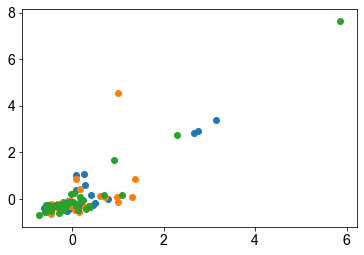

In [76]:
for i in range(3):
    plt.scatter(recon_x.detach().numpy()[i], y.detach().numpy()[i])

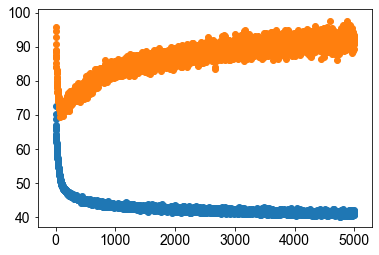

In [79]:
plt.scatter(list(range(5000)),self.logs['loss_train'])
plt.scatter(list(range(5000)),self.logs['loss_valid'])

ValueError: x and y must be the same size

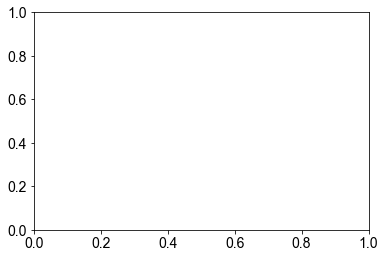

In [78]:
plt.scatter(list(range(500)),self.logs['loss_train'])
plt.scatter(list(range(500)),self.logs['loss_valid'])

In [35]:
np.asarray(self.logs['loss_train']).shape

(500,)

In [84]:
        xnorm = scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 5000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [240, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/5000 Batch 0000/0, Loss:  662.6264, rec_loss:  662.6234, KL_loss:    0.0030
Epoch 01/5000 Batch 0000/0, Loss:  637.5971, rec_loss:  637.5935, KL_loss:    0.0036
Epoch 02/5000 Batch 0000/0, Loss:  619.6415, rec_loss:  619.6349, KL_loss:    0.0066
Epoch 03/5000 Batch 0000/0, Loss:  612.6717, rec_loss:  612.6282, KL_loss:    0.0435
Epoch 04/5000 Batch 0000/0, Loss:  600.3261, rec_loss:  600.2979, KL_loss:    0.0282
Epoch 05/5000 Batch 0000/0, Loss:  587.7452, rec_loss:  587.7243, KL_loss:    0.0209
Epoch 06/5000 Batch 0000/0, Loss:  587.5134, rec_loss:  587.4871, KL_loss:    0.0263
Epoch 07/5000 Batch 0000/0, Loss:  573.6305, rec_loss:  573.5984, KL_loss:    0.0320
Epoch 08/5000 Batch 0000/0, Loss:  574.1419, rec_loss:  574.1235, KL_loss:    0.0184
Epoch 09/5000 Batch 0000/0, Loss:  566.4196, rec_loss:  566.4016, KL_loss:    0.0180
Epoch 10/5000 Batch 0000/0, Loss:  560.313

Epoch 97/5000 Batch 0000/0, Loss:  179.2676, rec_loss:  179.1807, KL_loss:    0.0869
Epoch 98/5000 Batch 0000/0, Loss:  178.1797, rec_loss:  178.0927, KL_loss:    0.0870
Epoch 99/5000 Batch 0000/0, Loss:  176.9928, rec_loss:  176.9057, KL_loss:    0.0871
Epoch 100/5000 Batch 0000/0, Loss:  176.0724, rec_loss:  175.9852, KL_loss:    0.0871
Epoch 101/5000 Batch 0000/0, Loss:  174.8064, rec_loss:  174.7192, KL_loss:    0.0872
Epoch 102/5000 Batch 0000/0, Loss:  173.7847, rec_loss:  173.6974, KL_loss:    0.0872
Epoch 103/5000 Batch 0000/0, Loss:  172.6567, rec_loss:  172.5694, KL_loss:    0.0873
Epoch 104/5000 Batch 0000/0, Loss:  171.7609, rec_loss:  171.6734, KL_loss:    0.0875
Epoch 105/5000 Batch 0000/0, Loss:  170.8299, rec_loss:  170.7425, KL_loss:    0.0875
Epoch 106/5000 Batch 0000/0, Loss:  169.8355, rec_loss:  169.7480, KL_loss:    0.0875
Epoch 107/5000 Batch 0000/0, Loss:  168.8756, rec_loss:  168.7881, KL_loss:    0.0876
Epoch 108/5000 Batch 0000/0, Loss:  167.8485, rec_loss:  

Epoch 195/5000 Batch 0000/0, Loss:  117.3154, rec_loss:  117.2168, KL_loss:    0.0985
Epoch 196/5000 Batch 0000/0, Loss:  117.1895, rec_loss:  117.0908, KL_loss:    0.0987
Epoch 197/5000 Batch 0000/0, Loss:  116.9638, rec_loss:  116.8650, KL_loss:    0.0988
Epoch 198/5000 Batch 0000/0, Loss:  116.2003, rec_loss:  116.1013, KL_loss:    0.0989
Epoch 199/5000 Batch 0000/0, Loss:  116.1552, rec_loss:  116.0561, KL_loss:    0.0991
Epoch 200/5000 Batch 0000/0, Loss:  115.4413, rec_loss:  115.3422, KL_loss:    0.0991
Epoch 201/5000 Batch 0000/0, Loss:  115.1998, rec_loss:  115.1006, KL_loss:    0.0992
Epoch 202/5000 Batch 0000/0, Loss:  114.9762, rec_loss:  114.8768, KL_loss:    0.0994
Epoch 203/5000 Batch 0000/0, Loss:  114.5113, rec_loss:  114.4118, KL_loss:    0.0995
Epoch 204/5000 Batch 0000/0, Loss:  114.1275, rec_loss:  114.0279, KL_loss:    0.0996
Epoch 205/5000 Batch 0000/0, Loss:  113.9008, rec_loss:  113.8011, KL_loss:    0.0997
Epoch 206/5000 Batch 0000/0, Loss:  113.6235, rec_loss

Epoch 293/5000 Batch 0000/0, Loss:   99.2514, rec_loss:   99.1442, KL_loss:    0.1072
Epoch 294/5000 Batch 0000/0, Loss:   99.0825, rec_loss:   98.9752, KL_loss:    0.1073
Epoch 295/5000 Batch 0000/0, Loss:   99.0445, rec_loss:   98.9371, KL_loss:    0.1074
Epoch 296/5000 Batch 0000/0, Loss:   98.7484, rec_loss:   98.6409, KL_loss:    0.1075
Epoch 297/5000 Batch 0000/0, Loss:   98.7528, rec_loss:   98.6452, KL_loss:    0.1076
Epoch 298/5000 Batch 0000/0, Loss:   98.6630, rec_loss:   98.5553, KL_loss:    0.1076
Epoch 299/5000 Batch 0000/0, Loss:   98.5909, rec_loss:   98.4832, KL_loss:    0.1077
Epoch 300/5000 Batch 0000/0, Loss:   98.4833, rec_loss:   98.3755, KL_loss:    0.1078
Epoch 301/5000 Batch 0000/0, Loss:   98.4496, rec_loss:   98.3417, KL_loss:    0.1079
Epoch 302/5000 Batch 0000/0, Loss:   98.2493, rec_loss:   98.1413, KL_loss:    0.1079
Epoch 303/5000 Batch 0000/0, Loss:   98.2094, rec_loss:   98.1014, KL_loss:    0.1080
Epoch 304/5000 Batch 0000/0, Loss:   98.3125, rec_loss

Epoch 391/5000 Batch 0000/0, Loss:   93.7827, rec_loss:   93.6697, KL_loss:    0.1130
Epoch 392/5000 Batch 0000/0, Loss:   93.7559, rec_loss:   93.6427, KL_loss:    0.1131
Epoch 393/5000 Batch 0000/0, Loss:   93.9401, rec_loss:   93.8270, KL_loss:    0.1131
Epoch 394/5000 Batch 0000/0, Loss:   93.9715, rec_loss:   93.8582, KL_loss:    0.1133
Epoch 395/5000 Batch 0000/0, Loss:   93.8920, rec_loss:   93.7788, KL_loss:    0.1133
Epoch 396/5000 Batch 0000/0, Loss:   93.8437, rec_loss:   93.7304, KL_loss:    0.1133
Epoch 397/5000 Batch 0000/0, Loss:   93.5173, rec_loss:   93.4039, KL_loss:    0.1134
Epoch 398/5000 Batch 0000/0, Loss:   93.6223, rec_loss:   93.5089, KL_loss:    0.1134
Epoch 399/5000 Batch 0000/0, Loss:   93.5543, rec_loss:   93.4408, KL_loss:    0.1135
Epoch 400/5000 Batch 0000/0, Loss:   93.5005, rec_loss:   93.3871, KL_loss:    0.1135
Epoch 401/5000 Batch 0000/0, Loss:   93.4564, rec_loss:   93.3428, KL_loss:    0.1136
Epoch 402/5000 Batch 0000/0, Loss:   93.3222, rec_loss

Epoch 492/5000 Batch 0000/0, Loss:   91.3396, rec_loss:   91.2223, KL_loss:    0.1173
Epoch 493/5000 Batch 0000/0, Loss:   91.2841, rec_loss:   91.1667, KL_loss:    0.1173
Epoch 494/5000 Batch 0000/0, Loss:   91.1375, rec_loss:   91.0201, KL_loss:    0.1174
Epoch 495/5000 Batch 0000/0, Loss:   90.9094, rec_loss:   90.7920, KL_loss:    0.1174
Epoch 496/5000 Batch 0000/0, Loss:   90.8368, rec_loss:   90.7193, KL_loss:    0.1175
Epoch 497/5000 Batch 0000/0, Loss:   90.8313, rec_loss:   90.7138, KL_loss:    0.1175
Epoch 498/5000 Batch 0000/0, Loss:   90.7772, rec_loss:   90.6597, KL_loss:    0.1175
Epoch 499/5000 Batch 0000/0, Loss:   90.7429, rec_loss:   90.6253, KL_loss:    0.1176
Epoch 500/5000 Batch 0000/0, Loss:   90.6967, rec_loss:   90.5791, KL_loss:    0.1176
Epoch 501/5000 Batch 0000/0, Loss:   90.7158, rec_loss:   90.5982, KL_loss:    0.1176
Epoch 502/5000 Batch 0000/0, Loss:   90.7794, rec_loss:   90.6618, KL_loss:    0.1176
Epoch 503/5000 Batch 0000/0, Loss:   90.6751, rec_loss

Epoch 592/5000 Batch 0000/0, Loss:   89.1985, rec_loss:   89.0782, KL_loss:    0.1202
Epoch 593/5000 Batch 0000/0, Loss:   89.3223, rec_loss:   89.2020, KL_loss:    0.1203
Epoch 594/5000 Batch 0000/0, Loss:   89.4743, rec_loss:   89.3541, KL_loss:    0.1203
Epoch 595/5000 Batch 0000/0, Loss:   89.7546, rec_loss:   89.6342, KL_loss:    0.1204
Epoch 596/5000 Batch 0000/0, Loss:   89.8796, rec_loss:   89.7593, KL_loss:    0.1203
Epoch 597/5000 Batch 0000/0, Loss:   89.9203, rec_loss:   89.7998, KL_loss:    0.1205
Epoch 598/5000 Batch 0000/0, Loss:   89.7496, rec_loss:   89.6292, KL_loss:    0.1204
Epoch 599/5000 Batch 0000/0, Loss:   89.5199, rec_loss:   89.3994, KL_loss:    0.1205
Epoch 600/5000 Batch 0000/0, Loss:   89.5529, rec_loss:   89.4324, KL_loss:    0.1205
Epoch 601/5000 Batch 0000/0, Loss:   89.4326, rec_loss:   89.3121, KL_loss:    0.1205
Epoch 602/5000 Batch 0000/0, Loss:   89.5136, rec_loss:   89.3931, KL_loss:    0.1206
Epoch 603/5000 Batch 0000/0, Loss:   89.5173, rec_loss

Epoch 688/5000 Batch 0000/0, Loss:   88.6790, rec_loss:   88.5566, KL_loss:    0.1224
Epoch 689/5000 Batch 0000/0, Loss:   88.4747, rec_loss:   88.3523, KL_loss:    0.1223
Epoch 690/5000 Batch 0000/0, Loss:   88.4477, rec_loss:   88.3253, KL_loss:    0.1224
Epoch 691/5000 Batch 0000/0, Loss:   88.6412, rec_loss:   88.5187, KL_loss:    0.1224
Epoch 692/5000 Batch 0000/0, Loss:   88.4640, rec_loss:   88.3416, KL_loss:    0.1224
Epoch 693/5000 Batch 0000/0, Loss:   88.1863, rec_loss:   88.0639, KL_loss:    0.1225
Epoch 694/5000 Batch 0000/0, Loss:   88.1411, rec_loss:   88.0186, KL_loss:    0.1225
Epoch 695/5000 Batch 0000/0, Loss:   88.2363, rec_loss:   88.1138, KL_loss:    0.1225
Epoch 696/5000 Batch 0000/0, Loss:   88.2637, rec_loss:   88.1412, KL_loss:    0.1225
Epoch 697/5000 Batch 0000/0, Loss:   88.2421, rec_loss:   88.1197, KL_loss:    0.1225
Epoch 698/5000 Batch 0000/0, Loss:   88.3036, rec_loss:   88.1811, KL_loss:    0.1225
Epoch 699/5000 Batch 0000/0, Loss:   88.3555, rec_loss

Epoch 788/5000 Batch 0000/0, Loss:   87.2758, rec_loss:   87.1518, KL_loss:    0.1240
Epoch 789/5000 Batch 0000/0, Loss:   87.2671, rec_loss:   87.1431, KL_loss:    0.1240
Epoch 790/5000 Batch 0000/0, Loss:   87.3867, rec_loss:   87.2627, KL_loss:    0.1240
Epoch 791/5000 Batch 0000/0, Loss:   87.3919, rec_loss:   87.2678, KL_loss:    0.1240
Epoch 792/5000 Batch 0000/0, Loss:   87.2759, rec_loss:   87.1519, KL_loss:    0.1240
Epoch 793/5000 Batch 0000/0, Loss:   87.4667, rec_loss:   87.3426, KL_loss:    0.1241
Epoch 794/5000 Batch 0000/0, Loss:   87.7638, rec_loss:   87.6397, KL_loss:    0.1241
Epoch 795/5000 Batch 0000/0, Loss:   87.9810, rec_loss:   87.8569, KL_loss:    0.1241
Epoch 796/5000 Batch 0000/0, Loss:   88.1856, rec_loss:   88.0615, KL_loss:    0.1241
Epoch 797/5000 Batch 0000/0, Loss:   88.2390, rec_loss:   88.1149, KL_loss:    0.1241
Epoch 798/5000 Batch 0000/0, Loss:   88.0448, rec_loss:   87.9206, KL_loss:    0.1241
Epoch 799/5000 Batch 0000/0, Loss:   87.7490, rec_loss

Epoch 885/5000 Batch 0000/0, Loss:   86.9197, rec_loss:   86.7943, KL_loss:    0.1254
Epoch 886/5000 Batch 0000/0, Loss:   86.9706, rec_loss:   86.8452, KL_loss:    0.1254
Epoch 887/5000 Batch 0000/0, Loss:   86.8616, rec_loss:   86.7361, KL_loss:    0.1255
Epoch 888/5000 Batch 0000/0, Loss:   86.8192, rec_loss:   86.6937, KL_loss:    0.1255
Epoch 889/5000 Batch 0000/0, Loss:   86.7354, rec_loss:   86.6099, KL_loss:    0.1255
Epoch 890/5000 Batch 0000/0, Loss:   86.6341, rec_loss:   86.5086, KL_loss:    0.1255
Epoch 891/5000 Batch 0000/0, Loss:   86.8440, rec_loss:   86.7185, KL_loss:    0.1255
Epoch 892/5000 Batch 0000/0, Loss:   87.1461, rec_loss:   87.0206, KL_loss:    0.1256
Epoch 893/5000 Batch 0000/0, Loss:   87.4252, rec_loss:   87.2996, KL_loss:    0.1256
Epoch 894/5000 Batch 0000/0, Loss:   87.4626, rec_loss:   87.3370, KL_loss:    0.1256
Epoch 895/5000 Batch 0000/0, Loss:   87.1898, rec_loss:   87.0642, KL_loss:    0.1256
Epoch 896/5000 Batch 0000/0, Loss:   86.8458, rec_loss

Epoch 982/5000 Batch 0000/0, Loss:   85.9389, rec_loss:   85.8121, KL_loss:    0.1268
Epoch 983/5000 Batch 0000/0, Loss:   85.9881, rec_loss:   85.8613, KL_loss:    0.1268
Epoch 984/5000 Batch 0000/0, Loss:   86.0607, rec_loss:   85.9339, KL_loss:    0.1268
Epoch 985/5000 Batch 0000/0, Loss:   86.1368, rec_loss:   86.0099, KL_loss:    0.1268
Epoch 986/5000 Batch 0000/0, Loss:   86.1567, rec_loss:   86.0299, KL_loss:    0.1268
Epoch 987/5000 Batch 0000/0, Loss:   86.1614, rec_loss:   86.0345, KL_loss:    0.1269
Epoch 988/5000 Batch 0000/0, Loss:   86.3608, rec_loss:   86.2339, KL_loss:    0.1269
Epoch 989/5000 Batch 0000/0, Loss:   86.4517, rec_loss:   86.3249, KL_loss:    0.1269
Epoch 990/5000 Batch 0000/0, Loss:   86.6011, rec_loss:   86.4742, KL_loss:    0.1269
Epoch 991/5000 Batch 0000/0, Loss:   86.6095, rec_loss:   86.4825, KL_loss:    0.1269
Epoch 992/5000 Batch 0000/0, Loss:   86.6180, rec_loss:   86.4911, KL_loss:    0.1270
Epoch 993/5000 Batch 0000/0, Loss:   86.6418, rec_loss

Epoch 1083/5000 Batch 0000/0, Loss:   85.6810, rec_loss:   85.5530, KL_loss:    0.1280
Epoch 1084/5000 Batch 0000/0, Loss:   85.8989, rec_loss:   85.7710, KL_loss:    0.1280
Epoch 1085/5000 Batch 0000/0, Loss:   86.1915, rec_loss:   86.0635, KL_loss:    0.1280
Epoch 1086/5000 Batch 0000/0, Loss:   86.1389, rec_loss:   86.0109, KL_loss:    0.1280
Epoch 1087/5000 Batch 0000/0, Loss:   85.6954, rec_loss:   85.5674, KL_loss:    0.1280
Epoch 1088/5000 Batch 0000/0, Loss:   85.5745, rec_loss:   85.4464, KL_loss:    0.1280
Epoch 1089/5000 Batch 0000/0, Loss:   85.7307, rec_loss:   85.6027, KL_loss:    0.1280
Epoch 1090/5000 Batch 0000/0, Loss:   85.9309, rec_loss:   85.8029, KL_loss:    0.1280
Epoch 1091/5000 Batch 0000/0, Loss:   85.7162, rec_loss:   85.5881, KL_loss:    0.1280
Epoch 1092/5000 Batch 0000/0, Loss:   85.5141, rec_loss:   85.3861, KL_loss:    0.1280
Epoch 1093/5000 Batch 0000/0, Loss:   85.7225, rec_loss:   85.5944, KL_loss:    0.1281
Epoch 1094/5000 Batch 0000/0, Loss:   85.86

Epoch 1181/5000 Batch 0000/0, Loss:   85.1477, rec_loss:   85.0191, KL_loss:    0.1286
Epoch 1182/5000 Batch 0000/0, Loss:   85.0877, rec_loss:   84.9590, KL_loss:    0.1286
Epoch 1183/5000 Batch 0000/0, Loss:   85.0491, rec_loss:   84.9205, KL_loss:    0.1287
Epoch 1184/5000 Batch 0000/0, Loss:   85.1516, rec_loss:   85.0229, KL_loss:    0.1286
Epoch 1185/5000 Batch 0000/0, Loss:   85.2546, rec_loss:   85.1259, KL_loss:    0.1287
Epoch 1186/5000 Batch 0000/0, Loss:   85.1839, rec_loss:   85.0552, KL_loss:    0.1286
Epoch 1187/5000 Batch 0000/0, Loss:   85.0163, rec_loss:   84.8876, KL_loss:    0.1287
Epoch 1188/5000 Batch 0000/0, Loss:   84.9115, rec_loss:   84.7829, KL_loss:    0.1287
Epoch 1189/5000 Batch 0000/0, Loss:   84.9248, rec_loss:   84.7961, KL_loss:    0.1286
Epoch 1190/5000 Batch 0000/0, Loss:   84.9491, rec_loss:   84.8204, KL_loss:    0.1287
Epoch 1191/5000 Batch 0000/0, Loss:   85.0578, rec_loss:   84.9291, KL_loss:    0.1287
Epoch 1192/5000 Batch 0000/0, Loss:   85.15

Epoch 1280/5000 Batch 0000/0, Loss:   84.8858, rec_loss:   84.7563, KL_loss:    0.1296
Epoch 1281/5000 Batch 0000/0, Loss:   85.0499, rec_loss:   84.9203, KL_loss:    0.1296
Epoch 1282/5000 Batch 0000/0, Loss:   85.2555, rec_loss:   85.1259, KL_loss:    0.1296
Epoch 1283/5000 Batch 0000/0, Loss:   85.3225, rec_loss:   85.1929, KL_loss:    0.1296
Epoch 1284/5000 Batch 0000/0, Loss:   85.5154, rec_loss:   85.3858, KL_loss:    0.1296
Epoch 1285/5000 Batch 0000/0, Loss:   85.9796, rec_loss:   85.8500, KL_loss:    0.1297
Epoch 1286/5000 Batch 0000/0, Loss:   85.6603, rec_loss:   85.5305, KL_loss:    0.1297
Epoch 1287/5000 Batch 0000/0, Loss:   85.4712, rec_loss:   85.3415, KL_loss:    0.1297
Epoch 1288/5000 Batch 0000/0, Loss:   85.4769, rec_loss:   85.3472, KL_loss:    0.1297
Epoch 1289/5000 Batch 0000/0, Loss:   85.0003, rec_loss:   84.8705, KL_loss:    0.1297
Epoch 1290/5000 Batch 0000/0, Loss:   85.1615, rec_loss:   85.0317, KL_loss:    0.1297
Epoch 1291/5000 Batch 0000/0, Loss:   85.20

Epoch 1379/5000 Batch 0000/0, Loss:   84.6535, rec_loss:   84.5229, KL_loss:    0.1306
Epoch 1380/5000 Batch 0000/0, Loss:   84.5611, rec_loss:   84.4305, KL_loss:    0.1305
Epoch 1381/5000 Batch 0000/0, Loss:   84.4889, rec_loss:   84.3584, KL_loss:    0.1306
Epoch 1382/5000 Batch 0000/0, Loss:   84.4142, rec_loss:   84.2837, KL_loss:    0.1305
Epoch 1383/5000 Batch 0000/0, Loss:   84.3622, rec_loss:   84.2317, KL_loss:    0.1305
Epoch 1384/5000 Batch 0000/0, Loss:   84.3689, rec_loss:   84.2384, KL_loss:    0.1305
Epoch 1385/5000 Batch 0000/0, Loss:   84.3180, rec_loss:   84.1874, KL_loss:    0.1305
Epoch 1386/5000 Batch 0000/0, Loss:   84.2608, rec_loss:   84.1303, KL_loss:    0.1305
Epoch 1387/5000 Batch 0000/0, Loss:   84.2176, rec_loss:   84.0871, KL_loss:    0.1305
Epoch 1388/5000 Batch 0000/0, Loss:   84.1821, rec_loss:   84.0517, KL_loss:    0.1304
Epoch 1389/5000 Batch 0000/0, Loss:   84.1971, rec_loss:   84.0666, KL_loss:    0.1304
Epoch 1390/5000 Batch 0000/0, Loss:   84.20

Epoch 1478/5000 Batch 0000/0, Loss:   85.4923, rec_loss:   85.3614, KL_loss:    0.1309
Epoch 1479/5000 Batch 0000/0, Loss:   85.4229, rec_loss:   85.2920, KL_loss:    0.1309
Epoch 1480/5000 Batch 0000/0, Loss:   84.8625, rec_loss:   84.7315, KL_loss:    0.1310
Epoch 1481/5000 Batch 0000/0, Loss:   84.3559, rec_loss:   84.2250, KL_loss:    0.1310
Epoch 1482/5000 Batch 0000/0, Loss:   84.4472, rec_loss:   84.3162, KL_loss:    0.1310
Epoch 1483/5000 Batch 0000/0, Loss:   84.7099, rec_loss:   84.5789, KL_loss:    0.1310
Epoch 1484/5000 Batch 0000/0, Loss:   84.5924, rec_loss:   84.4613, KL_loss:    0.1311
Epoch 1485/5000 Batch 0000/0, Loss:   84.2146, rec_loss:   84.0835, KL_loss:    0.1310
Epoch 1486/5000 Batch 0000/0, Loss:   83.8829, rec_loss:   83.7518, KL_loss:    0.1311
Epoch 1487/5000 Batch 0000/0, Loss:   84.0585, rec_loss:   83.9275, KL_loss:    0.1311
Epoch 1488/5000 Batch 0000/0, Loss:   84.1476, rec_loss:   84.0165, KL_loss:    0.1311
Epoch 1489/5000 Batch 0000/0, Loss:   84.04

Epoch 1573/5000 Batch 0000/0, Loss:   83.7596, rec_loss:   83.6279, KL_loss:    0.1316
Epoch 1574/5000 Batch 0000/0, Loss:   83.8262, rec_loss:   83.6946, KL_loss:    0.1316
Epoch 1575/5000 Batch 0000/0, Loss:   83.8573, rec_loss:   83.7257, KL_loss:    0.1317
Epoch 1576/5000 Batch 0000/0, Loss:   83.9525, rec_loss:   83.8209, KL_loss:    0.1316
Epoch 1577/5000 Batch 0000/0, Loss:   83.8843, rec_loss:   83.7527, KL_loss:    0.1317
Epoch 1578/5000 Batch 0000/0, Loss:   83.7767, rec_loss:   83.6450, KL_loss:    0.1317
Epoch 1579/5000 Batch 0000/0, Loss:   83.6456, rec_loss:   83.5139, KL_loss:    0.1317
Epoch 1580/5000 Batch 0000/0, Loss:   83.5289, rec_loss:   83.3973, KL_loss:    0.1316
Epoch 1581/5000 Batch 0000/0, Loss:   83.4713, rec_loss:   83.3396, KL_loss:    0.1316
Epoch 1582/5000 Batch 0000/0, Loss:   83.3628, rec_loss:   83.2312, KL_loss:    0.1316
Epoch 1583/5000 Batch 0000/0, Loss:   83.3391, rec_loss:   83.2075, KL_loss:    0.1316
Epoch 1584/5000 Batch 0000/0, Loss:   83.34

Epoch 1668/5000 Batch 0000/0, Loss:   83.7411, rec_loss:   83.6090, KL_loss:    0.1321
Epoch 1669/5000 Batch 0000/0, Loss:   83.8863, rec_loss:   83.7541, KL_loss:    0.1321
Epoch 1670/5000 Batch 0000/0, Loss:   83.8937, rec_loss:   83.7616, KL_loss:    0.1321
Epoch 1671/5000 Batch 0000/0, Loss:   83.5197, rec_loss:   83.3876, KL_loss:    0.1321
Epoch 1672/5000 Batch 0000/0, Loss:   83.2697, rec_loss:   83.1376, KL_loss:    0.1322
Epoch 1673/5000 Batch 0000/0, Loss:   83.4205, rec_loss:   83.2884, KL_loss:    0.1321
Epoch 1674/5000 Batch 0000/0, Loss:   83.4508, rec_loss:   83.3186, KL_loss:    0.1321
Epoch 1675/5000 Batch 0000/0, Loss:   83.3747, rec_loss:   83.2426, KL_loss:    0.1321
Epoch 1676/5000 Batch 0000/0, Loss:   83.2613, rec_loss:   83.1292, KL_loss:    0.1321
Epoch 1677/5000 Batch 0000/0, Loss:   83.2207, rec_loss:   83.0886, KL_loss:    0.1321
Epoch 1678/5000 Batch 0000/0, Loss:   83.3101, rec_loss:   83.1780, KL_loss:    0.1321
Epoch 1679/5000 Batch 0000/0, Loss:   83.33

Epoch 1763/5000 Batch 0000/0, Loss:   83.3609, rec_loss:   83.2281, KL_loss:    0.1328
Epoch 1764/5000 Batch 0000/0, Loss:   83.6016, rec_loss:   83.4688, KL_loss:    0.1328
Epoch 1765/5000 Batch 0000/0, Loss:   83.6100, rec_loss:   83.4772, KL_loss:    0.1328
Epoch 1766/5000 Batch 0000/0, Loss:   83.4373, rec_loss:   83.3044, KL_loss:    0.1328
Epoch 1767/5000 Batch 0000/0, Loss:   83.2172, rec_loss:   83.0843, KL_loss:    0.1328
Epoch 1768/5000 Batch 0000/0, Loss:   83.2995, rec_loss:   83.1667, KL_loss:    0.1328
Epoch 1769/5000 Batch 0000/0, Loss:   83.3245, rec_loss:   83.1917, KL_loss:    0.1328
Epoch 1770/5000 Batch 0000/0, Loss:   83.4721, rec_loss:   83.3392, KL_loss:    0.1329
Epoch 1771/5000 Batch 0000/0, Loss:   83.5912, rec_loss:   83.4584, KL_loss:    0.1329
Epoch 1772/5000 Batch 0000/0, Loss:   83.5722, rec_loss:   83.4393, KL_loss:    0.1329
Epoch 1773/5000 Batch 0000/0, Loss:   83.5140, rec_loss:   83.3811, KL_loss:    0.1329
Epoch 1774/5000 Batch 0000/0, Loss:   83.36

Epoch 1859/5000 Batch 0000/0, Loss:   82.8583, rec_loss:   82.7254, KL_loss:    0.1329
Epoch 1860/5000 Batch 0000/0, Loss:   82.7829, rec_loss:   82.6500, KL_loss:    0.1328
Epoch 1861/5000 Batch 0000/0, Loss:   82.6828, rec_loss:   82.5499, KL_loss:    0.1329
Epoch 1862/5000 Batch 0000/0, Loss:   82.5559, rec_loss:   82.4230, KL_loss:    0.1328
Epoch 1863/5000 Batch 0000/0, Loss:   82.5158, rec_loss:   82.3829, KL_loss:    0.1328
Epoch 1864/5000 Batch 0000/0, Loss:   82.5937, rec_loss:   82.4609, KL_loss:    0.1328
Epoch 1865/5000 Batch 0000/0, Loss:   82.6599, rec_loss:   82.5271, KL_loss:    0.1328
Epoch 1866/5000 Batch 0000/0, Loss:   82.6869, rec_loss:   82.5541, KL_loss:    0.1328
Epoch 1867/5000 Batch 0000/0, Loss:   82.6860, rec_loss:   82.5532, KL_loss:    0.1328
Epoch 1868/5000 Batch 0000/0, Loss:   83.0264, rec_loss:   82.8937, KL_loss:    0.1328
Epoch 1869/5000 Batch 0000/0, Loss:   83.4054, rec_loss:   83.2726, KL_loss:    0.1327
Epoch 1870/5000 Batch 0000/0, Loss:   83.37

Epoch 1956/5000 Batch 0000/0, Loss:   82.4398, rec_loss:   82.3069, KL_loss:    0.1329
Epoch 1957/5000 Batch 0000/0, Loss:   82.4565, rec_loss:   82.3236, KL_loss:    0.1329
Epoch 1958/5000 Batch 0000/0, Loss:   82.4523, rec_loss:   82.3194, KL_loss:    0.1329
Epoch 1959/5000 Batch 0000/0, Loss:   82.4942, rec_loss:   82.3613, KL_loss:    0.1328
Epoch 1960/5000 Batch 0000/0, Loss:   82.7169, rec_loss:   82.5840, KL_loss:    0.1329
Epoch 1961/5000 Batch 0000/0, Loss:   82.6418, rec_loss:   82.5089, KL_loss:    0.1329
Epoch 1962/5000 Batch 0000/0, Loss:   82.5663, rec_loss:   82.4334, KL_loss:    0.1329
Epoch 1963/5000 Batch 0000/0, Loss:   82.6764, rec_loss:   82.5436, KL_loss:    0.1329
Epoch 1964/5000 Batch 0000/0, Loss:   82.6628, rec_loss:   82.5299, KL_loss:    0.1329
Epoch 1965/5000 Batch 0000/0, Loss:   82.5720, rec_loss:   82.4391, KL_loss:    0.1329
Epoch 1966/5000 Batch 0000/0, Loss:   82.5905, rec_loss:   82.4576, KL_loss:    0.1329
Epoch 1967/5000 Batch 0000/0, Loss:   82.61

Epoch 2054/5000 Batch 0000/0, Loss:   82.3910, rec_loss:   82.2573, KL_loss:    0.1337
Epoch 2055/5000 Batch 0000/0, Loss:   82.3561, rec_loss:   82.2224, KL_loss:    0.1337
Epoch 2056/5000 Batch 0000/0, Loss:   82.4895, rec_loss:   82.3557, KL_loss:    0.1338
Epoch 2057/5000 Batch 0000/0, Loss:   82.4447, rec_loss:   82.3110, KL_loss:    0.1337
Epoch 2058/5000 Batch 0000/0, Loss:   82.3908, rec_loss:   82.2570, KL_loss:    0.1337
Epoch 2059/5000 Batch 0000/0, Loss:   82.2897, rec_loss:   82.1560, KL_loss:    0.1337
Epoch 2060/5000 Batch 0000/0, Loss:   82.1907, rec_loss:   82.0570, KL_loss:    0.1337
Epoch 2061/5000 Batch 0000/0, Loss:   82.1513, rec_loss:   82.0176, KL_loss:    0.1337
Epoch 2062/5000 Batch 0000/0, Loss:   82.1278, rec_loss:   81.9941, KL_loss:    0.1337
Epoch 2063/5000 Batch 0000/0, Loss:   82.1201, rec_loss:   81.9864, KL_loss:    0.1337
Epoch 2064/5000 Batch 0000/0, Loss:   82.2737, rec_loss:   82.1400, KL_loss:    0.1337
Epoch 2065/5000 Batch 0000/0, Loss:   82.47

Epoch 2150/5000 Batch 0000/0, Loss:   82.1646, rec_loss:   82.0304, KL_loss:    0.1342
Epoch 2151/5000 Batch 0000/0, Loss:   82.1867, rec_loss:   82.0525, KL_loss:    0.1342
Epoch 2152/5000 Batch 0000/0, Loss:   82.1770, rec_loss:   82.0428, KL_loss:    0.1342
Epoch 2153/5000 Batch 0000/0, Loss:   82.1584, rec_loss:   82.0242, KL_loss:    0.1342
Epoch 2154/5000 Batch 0000/0, Loss:   82.2014, rec_loss:   82.0671, KL_loss:    0.1342
Epoch 2155/5000 Batch 0000/0, Loss:   82.2378, rec_loss:   82.1036, KL_loss:    0.1342
Epoch 2156/5000 Batch 0000/0, Loss:   82.1761, rec_loss:   82.0419, KL_loss:    0.1342
Epoch 2157/5000 Batch 0000/0, Loss:   82.2960, rec_loss:   82.1618, KL_loss:    0.1342
Epoch 2158/5000 Batch 0000/0, Loss:   82.3016, rec_loss:   82.1674, KL_loss:    0.1341
Epoch 2159/5000 Batch 0000/0, Loss:   82.4623, rec_loss:   82.3281, KL_loss:    0.1342
Epoch 2160/5000 Batch 0000/0, Loss:   82.6481, rec_loss:   82.5139, KL_loss:    0.1341
Epoch 2161/5000 Batch 0000/0, Loss:   82.77

Epoch 2248/5000 Batch 0000/0, Loss:   81.7066, rec_loss:   81.5722, KL_loss:    0.1344
Epoch 2249/5000 Batch 0000/0, Loss:   81.6981, rec_loss:   81.5637, KL_loss:    0.1344
Epoch 2250/5000 Batch 0000/0, Loss:   81.7421, rec_loss:   81.6077, KL_loss:    0.1344
Epoch 2251/5000 Batch 0000/0, Loss:   81.8014, rec_loss:   81.6670, KL_loss:    0.1344
Epoch 2252/5000 Batch 0000/0, Loss:   81.8814, rec_loss:   81.7470, KL_loss:    0.1343
Epoch 2253/5000 Batch 0000/0, Loss:   81.9503, rec_loss:   81.8160, KL_loss:    0.1344
Epoch 2254/5000 Batch 0000/0, Loss:   81.8756, rec_loss:   81.7413, KL_loss:    0.1343
Epoch 2255/5000 Batch 0000/0, Loss:   81.7428, rec_loss:   81.6085, KL_loss:    0.1344
Epoch 2256/5000 Batch 0000/0, Loss:   81.6765, rec_loss:   81.5421, KL_loss:    0.1344
Epoch 2257/5000 Batch 0000/0, Loss:   81.6852, rec_loss:   81.5508, KL_loss:    0.1344
Epoch 2258/5000 Batch 0000/0, Loss:   81.7961, rec_loss:   81.6617, KL_loss:    0.1344
Epoch 2259/5000 Batch 0000/0, Loss:   82.02

Epoch 2346/5000 Batch 0000/0, Loss:   81.5093, rec_loss:   81.3745, KL_loss:    0.1348
Epoch 2347/5000 Batch 0000/0, Loss:   81.4045, rec_loss:   81.2697, KL_loss:    0.1348
Epoch 2348/5000 Batch 0000/0, Loss:   81.4481, rec_loss:   81.3132, KL_loss:    0.1348
Epoch 2349/5000 Batch 0000/0, Loss:   81.4861, rec_loss:   81.3512, KL_loss:    0.1348
Epoch 2350/5000 Batch 0000/0, Loss:   81.5117, rec_loss:   81.3768, KL_loss:    0.1349
Epoch 2351/5000 Batch 0000/0, Loss:   81.6458, rec_loss:   81.5109, KL_loss:    0.1348
Epoch 2352/5000 Batch 0000/0, Loss:   81.8212, rec_loss:   81.6863, KL_loss:    0.1349
Epoch 2353/5000 Batch 0000/0, Loss:   82.2342, rec_loss:   82.0993, KL_loss:    0.1349
Epoch 2354/5000 Batch 0000/0, Loss:   82.2596, rec_loss:   82.1247, KL_loss:    0.1349
Epoch 2355/5000 Batch 0000/0, Loss:   82.6279, rec_loss:   82.4930, KL_loss:    0.1349
Epoch 2356/5000 Batch 0000/0, Loss:   83.2806, rec_loss:   83.1457, KL_loss:    0.1349
Epoch 2357/5000 Batch 0000/0, Loss:   83.92

Epoch 2442/5000 Batch 0000/0, Loss:   81.4581, rec_loss:   81.3227, KL_loss:    0.1354
Epoch 2443/5000 Batch 0000/0, Loss:   81.4511, rec_loss:   81.3157, KL_loss:    0.1354
Epoch 2444/5000 Batch 0000/0, Loss:   81.6668, rec_loss:   81.5314, KL_loss:    0.1354
Epoch 2445/5000 Batch 0000/0, Loss:   81.7910, rec_loss:   81.6556, KL_loss:    0.1354
Epoch 2446/5000 Batch 0000/0, Loss:   81.7222, rec_loss:   81.5868, KL_loss:    0.1354
Epoch 2447/5000 Batch 0000/0, Loss:   81.6212, rec_loss:   81.4857, KL_loss:    0.1354
Epoch 2448/5000 Batch 0000/0, Loss:   81.6489, rec_loss:   81.5135, KL_loss:    0.1354
Epoch 2449/5000 Batch 0000/0, Loss:   81.8420, rec_loss:   81.7066, KL_loss:    0.1354
Epoch 2450/5000 Batch 0000/0, Loss:   81.9958, rec_loss:   81.8604, KL_loss:    0.1354
Epoch 2451/5000 Batch 0000/0, Loss:   82.3347, rec_loss:   82.1993, KL_loss:    0.1355
Epoch 2452/5000 Batch 0000/0, Loss:   82.7981, rec_loss:   82.6626, KL_loss:    0.1355
Epoch 2453/5000 Batch 0000/0, Loss:   83.59

Epoch 2537/5000 Batch 0000/0, Loss:   81.6891, rec_loss:   81.5536, KL_loss:    0.1355
Epoch 2538/5000 Batch 0000/0, Loss:   81.5570, rec_loss:   81.4215, KL_loss:    0.1355
Epoch 2539/5000 Batch 0000/0, Loss:   81.5517, rec_loss:   81.4161, KL_loss:    0.1355
Epoch 2540/5000 Batch 0000/0, Loss:   81.5038, rec_loss:   81.3682, KL_loss:    0.1355
Epoch 2541/5000 Batch 0000/0, Loss:   81.4854, rec_loss:   81.3499, KL_loss:    0.1355
Epoch 2542/5000 Batch 0000/0, Loss:   81.5160, rec_loss:   81.3805, KL_loss:    0.1355
Epoch 2543/5000 Batch 0000/0, Loss:   81.4872, rec_loss:   81.3516, KL_loss:    0.1355
Epoch 2544/5000 Batch 0000/0, Loss:   81.4990, rec_loss:   81.3635, KL_loss:    0.1355
Epoch 2545/5000 Batch 0000/0, Loss:   81.4653, rec_loss:   81.3298, KL_loss:    0.1355
Epoch 2546/5000 Batch 0000/0, Loss:   81.4900, rec_loss:   81.3545, KL_loss:    0.1355
Epoch 2547/5000 Batch 0000/0, Loss:   81.5464, rec_loss:   81.4109, KL_loss:    0.1355
Epoch 2548/5000 Batch 0000/0, Loss:   81.53

Epoch 2632/5000 Batch 0000/0, Loss:   81.8029, rec_loss:   81.6669, KL_loss:    0.1360
Epoch 2633/5000 Batch 0000/0, Loss:   81.6496, rec_loss:   81.5136, KL_loss:    0.1360
Epoch 2634/5000 Batch 0000/0, Loss:   81.9891, rec_loss:   81.8531, KL_loss:    0.1360
Epoch 2635/5000 Batch 0000/0, Loss:   82.1322, rec_loss:   81.9962, KL_loss:    0.1360
Epoch 2636/5000 Batch 0000/0, Loss:   82.0562, rec_loss:   81.9201, KL_loss:    0.1360
Epoch 2637/5000 Batch 0000/0, Loss:   81.4769, rec_loss:   81.3409, KL_loss:    0.1360
Epoch 2638/5000 Batch 0000/0, Loss:   81.3062, rec_loss:   81.1701, KL_loss:    0.1360
Epoch 2639/5000 Batch 0000/0, Loss:   81.3593, rec_loss:   81.2233, KL_loss:    0.1360
Epoch 2640/5000 Batch 0000/0, Loss:   81.4758, rec_loss:   81.3398, KL_loss:    0.1360
Epoch 2641/5000 Batch 0000/0, Loss:   81.5285, rec_loss:   81.3924, KL_loss:    0.1361
Epoch 2642/5000 Batch 0000/0, Loss:   81.3641, rec_loss:   81.2280, KL_loss:    0.1361
Epoch 2643/5000 Batch 0000/0, Loss:   81.22

Epoch 2732/5000 Batch 0000/0, Loss:   80.9319, rec_loss:   80.7956, KL_loss:    0.1363
Epoch 2733/5000 Batch 0000/0, Loss:   81.0182, rec_loss:   80.8819, KL_loss:    0.1363
Epoch 2734/5000 Batch 0000/0, Loss:   81.1559, rec_loss:   81.0196, KL_loss:    0.1364
Epoch 2735/5000 Batch 0000/0, Loss:   81.0499, rec_loss:   80.9136, KL_loss:    0.1363
Epoch 2736/5000 Batch 0000/0, Loss:   80.9650, rec_loss:   80.8287, KL_loss:    0.1363
Epoch 2737/5000 Batch 0000/0, Loss:   80.9628, rec_loss:   80.8265, KL_loss:    0.1363
Epoch 2738/5000 Batch 0000/0, Loss:   81.2031, rec_loss:   81.0669, KL_loss:    0.1363
Epoch 2739/5000 Batch 0000/0, Loss:   81.3315, rec_loss:   81.1952, KL_loss:    0.1363
Epoch 2740/5000 Batch 0000/0, Loss:   81.5894, rec_loss:   81.4531, KL_loss:    0.1363
Epoch 2741/5000 Batch 0000/0, Loss:   82.1092, rec_loss:   81.9729, KL_loss:    0.1363
Epoch 2742/5000 Batch 0000/0, Loss:   82.5561, rec_loss:   82.4198, KL_loss:    0.1363
Epoch 2743/5000 Batch 0000/0, Loss:   83.01

Epoch 2830/5000 Batch 0000/0, Loss:   80.6179, rec_loss:   80.4815, KL_loss:    0.1364
Epoch 2831/5000 Batch 0000/0, Loss:   80.5820, rec_loss:   80.4456, KL_loss:    0.1363
Epoch 2832/5000 Batch 0000/0, Loss:   80.5354, rec_loss:   80.3991, KL_loss:    0.1363
Epoch 2833/5000 Batch 0000/0, Loss:   80.4871, rec_loss:   80.3508, KL_loss:    0.1363
Epoch 2834/5000 Batch 0000/0, Loss:   80.4730, rec_loss:   80.3367, KL_loss:    0.1363
Epoch 2835/5000 Batch 0000/0, Loss:   80.4994, rec_loss:   80.3631, KL_loss:    0.1363
Epoch 2836/5000 Batch 0000/0, Loss:   80.4903, rec_loss:   80.3541, KL_loss:    0.1362
Epoch 2837/5000 Batch 0000/0, Loss:   80.3890, rec_loss:   80.2528, KL_loss:    0.1362
Epoch 2838/5000 Batch 0000/0, Loss:   80.3271, rec_loss:   80.1909, KL_loss:    0.1362
Epoch 2839/5000 Batch 0000/0, Loss:   80.3793, rec_loss:   80.2431, KL_loss:    0.1362
Epoch 2840/5000 Batch 0000/0, Loss:   80.4125, rec_loss:   80.2763, KL_loss:    0.1361
Epoch 2841/5000 Batch 0000/0, Loss:   80.39

Epoch 2925/5000 Batch 0000/0, Loss:   81.4527, rec_loss:   81.3158, KL_loss:    0.1368
Epoch 2926/5000 Batch 0000/0, Loss:   81.0750, rec_loss:   80.9381, KL_loss:    0.1369
Epoch 2927/5000 Batch 0000/0, Loss:   81.0902, rec_loss:   80.9534, KL_loss:    0.1368
Epoch 2928/5000 Batch 0000/0, Loss:   81.1559, rec_loss:   81.0190, KL_loss:    0.1368
Epoch 2929/5000 Batch 0000/0, Loss:   80.9404, rec_loss:   80.8035, KL_loss:    0.1369
Epoch 2930/5000 Batch 0000/0, Loss:   80.8344, rec_loss:   80.6976, KL_loss:    0.1368
Epoch 2931/5000 Batch 0000/0, Loss:   80.7039, rec_loss:   80.5670, KL_loss:    0.1368
Epoch 2932/5000 Batch 0000/0, Loss:   80.6614, rec_loss:   80.5246, KL_loss:    0.1369
Epoch 2933/5000 Batch 0000/0, Loss:   80.5627, rec_loss:   80.4259, KL_loss:    0.1369
Epoch 2934/5000 Batch 0000/0, Loss:   80.5265, rec_loss:   80.3897, KL_loss:    0.1369
Epoch 2935/5000 Batch 0000/0, Loss:   80.5486, rec_loss:   80.4117, KL_loss:    0.1368
Epoch 2936/5000 Batch 0000/0, Loss:   81.01

Epoch 3021/5000 Batch 0000/0, Loss:   80.5465, rec_loss:   80.4099, KL_loss:    0.1366
Epoch 3022/5000 Batch 0000/0, Loss:   80.4111, rec_loss:   80.2744, KL_loss:    0.1366
Epoch 3023/5000 Batch 0000/0, Loss:   80.2143, rec_loss:   80.0777, KL_loss:    0.1366
Epoch 3024/5000 Batch 0000/0, Loss:   80.1176, rec_loss:   79.9810, KL_loss:    0.1366
Epoch 3025/5000 Batch 0000/0, Loss:   80.1779, rec_loss:   80.0413, KL_loss:    0.1366
Epoch 3026/5000 Batch 0000/0, Loss:   80.2717, rec_loss:   80.1351, KL_loss:    0.1366
Epoch 3027/5000 Batch 0000/0, Loss:   80.5617, rec_loss:   80.4251, KL_loss:    0.1366
Epoch 3028/5000 Batch 0000/0, Loss:   80.8572, rec_loss:   80.7206, KL_loss:    0.1366
Epoch 3029/5000 Batch 0000/0, Loss:   81.2219, rec_loss:   81.0853, KL_loss:    0.1366
Epoch 3030/5000 Batch 0000/0, Loss:   81.4160, rec_loss:   81.2794, KL_loss:    0.1366
Epoch 3031/5000 Batch 0000/0, Loss:   81.8617, rec_loss:   81.7251, KL_loss:    0.1366
Epoch 3032/5000 Batch 0000/0, Loss:   81.69

Epoch 3118/5000 Batch 0000/0, Loss:   80.0243, rec_loss:   79.8881, KL_loss:    0.1362
Epoch 3119/5000 Batch 0000/0, Loss:   80.0632, rec_loss:   79.9271, KL_loss:    0.1362
Epoch 3120/5000 Batch 0000/0, Loss:   80.1517, rec_loss:   80.0155, KL_loss:    0.1362
Epoch 3121/5000 Batch 0000/0, Loss:   80.0831, rec_loss:   79.9469, KL_loss:    0.1362
Epoch 3122/5000 Batch 0000/0, Loss:   80.0589, rec_loss:   79.9227, KL_loss:    0.1362
Epoch 3123/5000 Batch 0000/0, Loss:   79.9637, rec_loss:   79.8275, KL_loss:    0.1362
Epoch 3124/5000 Batch 0000/0, Loss:   79.9455, rec_loss:   79.8094, KL_loss:    0.1362
Epoch 3125/5000 Batch 0000/0, Loss:   80.0077, rec_loss:   79.8715, KL_loss:    0.1362
Epoch 3126/5000 Batch 0000/0, Loss:   80.2393, rec_loss:   80.1031, KL_loss:    0.1362
Epoch 3127/5000 Batch 0000/0, Loss:   80.5626, rec_loss:   80.4264, KL_loss:    0.1362
Epoch 3128/5000 Batch 0000/0, Loss:   81.2351, rec_loss:   81.0989, KL_loss:    0.1362
Epoch 3129/5000 Batch 0000/0, Loss:   81.77

Epoch 3214/5000 Batch 0000/0, Loss:   80.0023, rec_loss:   79.8655, KL_loss:    0.1368
Epoch 3215/5000 Batch 0000/0, Loss:   79.8898, rec_loss:   79.7531, KL_loss:    0.1368
Epoch 3216/5000 Batch 0000/0, Loss:   79.8257, rec_loss:   79.6889, KL_loss:    0.1368
Epoch 3217/5000 Batch 0000/0, Loss:   79.8935, rec_loss:   79.7568, KL_loss:    0.1367
Epoch 3218/5000 Batch 0000/0, Loss:   80.0186, rec_loss:   79.8818, KL_loss:    0.1368
Epoch 3219/5000 Batch 0000/0, Loss:   80.2874, rec_loss:   80.1506, KL_loss:    0.1368
Epoch 3220/5000 Batch 0000/0, Loss:   80.5388, rec_loss:   80.4020, KL_loss:    0.1368
Epoch 3221/5000 Batch 0000/0, Loss:   80.8986, rec_loss:   80.7618, KL_loss:    0.1368
Epoch 3222/5000 Batch 0000/0, Loss:   81.6211, rec_loss:   81.4843, KL_loss:    0.1368
Epoch 3223/5000 Batch 0000/0, Loss:   81.9605, rec_loss:   81.8237, KL_loss:    0.1368
Epoch 3224/5000 Batch 0000/0, Loss:   82.5637, rec_loss:   82.4268, KL_loss:    0.1369
Epoch 3225/5000 Batch 0000/0, Loss:   82.02

Epoch 3310/5000 Batch 0000/0, Loss:   79.9365, rec_loss:   79.7989, KL_loss:    0.1376
Epoch 3311/5000 Batch 0000/0, Loss:   80.2535, rec_loss:   80.1160, KL_loss:    0.1376
Epoch 3312/5000 Batch 0000/0, Loss:   80.4245, rec_loss:   80.2869, KL_loss:    0.1376
Epoch 3313/5000 Batch 0000/0, Loss:   80.4189, rec_loss:   80.2813, KL_loss:    0.1376
Epoch 3314/5000 Batch 0000/0, Loss:   80.0761, rec_loss:   79.9385, KL_loss:    0.1376
Epoch 3315/5000 Batch 0000/0, Loss:   79.8869, rec_loss:   79.7493, KL_loss:    0.1376
Epoch 3316/5000 Batch 0000/0, Loss:   79.9159, rec_loss:   79.7783, KL_loss:    0.1376
Epoch 3317/5000 Batch 0000/0, Loss:   80.0032, rec_loss:   79.8656, KL_loss:    0.1376
Epoch 3318/5000 Batch 0000/0, Loss:   80.0713, rec_loss:   79.9337, KL_loss:    0.1376
Epoch 3319/5000 Batch 0000/0, Loss:   80.0093, rec_loss:   79.8717, KL_loss:    0.1376
Epoch 3320/5000 Batch 0000/0, Loss:   80.0225, rec_loss:   79.8848, KL_loss:    0.1376
Epoch 3321/5000 Batch 0000/0, Loss:   80.06

Epoch 3409/5000 Batch 0000/0, Loss:   80.1782, rec_loss:   80.0403, KL_loss:    0.1379
Epoch 3410/5000 Batch 0000/0, Loss:   80.1199, rec_loss:   79.9820, KL_loss:    0.1379
Epoch 3411/5000 Batch 0000/0, Loss:   80.0104, rec_loss:   79.8725, KL_loss:    0.1379
Epoch 3412/5000 Batch 0000/0, Loss:   79.9378, rec_loss:   79.7999, KL_loss:    0.1379
Epoch 3413/5000 Batch 0000/0, Loss:   79.8763, rec_loss:   79.7384, KL_loss:    0.1379
Epoch 3414/5000 Batch 0000/0, Loss:   79.9967, rec_loss:   79.8589, KL_loss:    0.1378
Epoch 3415/5000 Batch 0000/0, Loss:   79.9408, rec_loss:   79.8030, KL_loss:    0.1378
Epoch 3416/5000 Batch 0000/0, Loss:   79.7968, rec_loss:   79.6590, KL_loss:    0.1378
Epoch 3417/5000 Batch 0000/0, Loss:   79.7628, rec_loss:   79.6250, KL_loss:    0.1378
Epoch 3418/5000 Batch 0000/0, Loss:   79.7114, rec_loss:   79.5736, KL_loss:    0.1378
Epoch 3419/5000 Batch 0000/0, Loss:   79.8023, rec_loss:   79.6645, KL_loss:    0.1378
Epoch 3420/5000 Batch 0000/0, Loss:   79.92

Epoch 3504/5000 Batch 0000/0, Loss:   82.6631, rec_loss:   82.5249, KL_loss:    0.1382
Epoch 3505/5000 Batch 0000/0, Loss:   82.0770, rec_loss:   81.9388, KL_loss:    0.1383
Epoch 3506/5000 Batch 0000/0, Loss:   81.9739, rec_loss:   81.8356, KL_loss:    0.1383
Epoch 3507/5000 Batch 0000/0, Loss:   82.0455, rec_loss:   81.9073, KL_loss:    0.1382
Epoch 3508/5000 Batch 0000/0, Loss:   81.3506, rec_loss:   81.2123, KL_loss:    0.1382
Epoch 3509/5000 Batch 0000/0, Loss:   81.5326, rec_loss:   81.3943, KL_loss:    0.1383
Epoch 3510/5000 Batch 0000/0, Loss:   81.2687, rec_loss:   81.1305, KL_loss:    0.1382
Epoch 3511/5000 Batch 0000/0, Loss:   81.0422, rec_loss:   80.9040, KL_loss:    0.1382
Epoch 3512/5000 Batch 0000/0, Loss:   81.0582, rec_loss:   80.9200, KL_loss:    0.1382
Epoch 3513/5000 Batch 0000/0, Loss:   80.8033, rec_loss:   80.6652, KL_loss:    0.1382
Epoch 3514/5000 Batch 0000/0, Loss:   80.7624, rec_loss:   80.6243, KL_loss:    0.1381
Epoch 3515/5000 Batch 0000/0, Loss:   80.64

Epoch 3605/5000 Batch 0000/0, Loss:   79.9381, rec_loss:   79.8006, KL_loss:    0.1376
Epoch 3606/5000 Batch 0000/0, Loss:   79.8409, rec_loss:   79.7033, KL_loss:    0.1375
Epoch 3607/5000 Batch 0000/0, Loss:   79.6619, rec_loss:   79.5244, KL_loss:    0.1376
Epoch 3608/5000 Batch 0000/0, Loss:   79.5617, rec_loss:   79.4242, KL_loss:    0.1375
Epoch 3609/5000 Batch 0000/0, Loss:   79.4685, rec_loss:   79.3309, KL_loss:    0.1375
Epoch 3610/5000 Batch 0000/0, Loss:   79.5199, rec_loss:   79.3824, KL_loss:    0.1375
Epoch 3611/5000 Batch 0000/0, Loss:   79.5984, rec_loss:   79.4610, KL_loss:    0.1375
Epoch 3612/5000 Batch 0000/0, Loss:   79.7033, rec_loss:   79.5658, KL_loss:    0.1375
Epoch 3613/5000 Batch 0000/0, Loss:   79.7470, rec_loss:   79.6095, KL_loss:    0.1375
Epoch 3614/5000 Batch 0000/0, Loss:   79.7801, rec_loss:   79.6426, KL_loss:    0.1375
Epoch 3615/5000 Batch 0000/0, Loss:   79.9282, rec_loss:   79.7907, KL_loss:    0.1375
Epoch 3616/5000 Batch 0000/0, Loss:   79.98

Epoch 3700/5000 Batch 0000/0, Loss:   80.2662, rec_loss:   80.1285, KL_loss:    0.1378


KeyboardInterrupt: 

In [81]:
.8*376

300.8

In [85]:
xnorm

array([[-0.08254851, -0.05720622, -0.31065791, ..., -0.06682884,
         0.        ,  0.        ],
       [-0.08254851, -0.05720622, -0.31065791, ..., -0.06682884,
         0.        ,  0.        ],
       [-0.08254851, -0.05720622, -0.31065791, ..., -0.06682884,
         0.        ,  0.        ],
       ...,
       [-0.08254851, -0.05720622, -0.31065791, ..., -0.06682884,
         0.        ,  0.        ],
       [-0.08254851, -0.05720622,  2.23560759, ..., -0.06682884,
         0.        ,  0.        ],
       [-0.08254851, -0.05720622, -0.31065791, ..., -0.06682884,
         0.        ,  0.        ]])

In [86]:
        xnorm = scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 5000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [240, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/5000 Batch 0000/0, Loss:  669.1914, rec_loss:  669.1890, KL_loss:    0.0024
Epoch 01/5000 Batch 0000/0, Loss:  622.4677, rec_loss:  622.4635, KL_loss:    0.0042
Epoch 02/5000 Batch 0000/0, Loss:  604.0956, rec_loss:  604.0872, KL_loss:    0.0084
Epoch 03/5000 Batch 0000/0, Loss:  574.7881, rec_loss:  574.7767, KL_loss:    0.0115
Epoch 04/5000 Batch 0000/0, Loss:  539.7510, rec_loss:  539.7349, KL_loss:    0.0161
Epoch 05/5000 Batch 0000/0, Loss:  508.3507, rec_loss:  508.3282, KL_loss:    0.0225
Epoch 06/5000 Batch 0000/0, Loss:  480.7220, rec_loss:  480.6927, KL_loss:    0.0293
Epoch 07/5000 Batch 0000/0, Loss:  458.2994, rec_loss:  458.2639, KL_loss:    0.0356
Epoch 08/5000 Batch 0000/0, Loss:  438.5895, rec_loss:  438.5487, KL_loss:    0.0407
Epoch 09/5000 Batch 0000/0, Loss:  417.4525, rec_loss:  417.4074, KL_loss:    0.0451
Epoch 10/5000 Batch 0000/0, Loss:  400.44

Epoch 98/5000 Batch 0000/0, Loss:   79.2857, rec_loss:   79.1849, KL_loss:    0.1009
Epoch 99/5000 Batch 0000/0, Loss:   78.7523, rec_loss:   78.6514, KL_loss:    0.1009
Epoch 100/5000 Batch 0000/0, Loss:   78.0216, rec_loss:   77.9206, KL_loss:    0.1010
Epoch 101/5000 Batch 0000/0, Loss:   76.7689, rec_loss:   76.6677, KL_loss:    0.1012
Epoch 102/5000 Batch 0000/0, Loss:   76.1651, rec_loss:   76.0639, KL_loss:    0.1012
Epoch 103/5000 Batch 0000/0, Loss:   75.4560, rec_loss:   75.3546, KL_loss:    0.1014
Epoch 104/5000 Batch 0000/0, Loss:   74.9524, rec_loss:   74.8509, KL_loss:    0.1015
Epoch 105/5000 Batch 0000/0, Loss:   73.9961, rec_loss:   73.8945, KL_loss:    0.1016
Epoch 106/5000 Batch 0000/0, Loss:   73.0784, rec_loss:   72.9767, KL_loss:    0.1018
Epoch 107/5000 Batch 0000/0, Loss:   72.3926, rec_loss:   72.2908, KL_loss:    0.1018
Epoch 108/5000 Batch 0000/0, Loss:   71.6177, rec_loss:   71.5158, KL_loss:    0.1019
Epoch 109/5000 Batch 0000/0, Loss:   70.9638, rec_loss: 

Epoch 197/5000 Batch 0000/0, Loss:   39.7321, rec_loss:   39.6219, KL_loss:    0.1102
Epoch 198/5000 Batch 0000/0, Loss:   39.4624, rec_loss:   39.3521, KL_loss:    0.1103
Epoch 199/5000 Batch 0000/0, Loss:   39.4005, rec_loss:   39.2902, KL_loss:    0.1103
Epoch 200/5000 Batch 0000/0, Loss:   39.0884, rec_loss:   38.9780, KL_loss:    0.1104
Epoch 201/5000 Batch 0000/0, Loss:   38.9397, rec_loss:   38.8292, KL_loss:    0.1105
Epoch 202/5000 Batch 0000/0, Loss:   39.4876, rec_loss:   39.3771, KL_loss:    0.1105
Epoch 203/5000 Batch 0000/0, Loss:   39.4089, rec_loss:   39.2983, KL_loss:    0.1106
Epoch 204/5000 Batch 0000/0, Loss:   39.0022, rec_loss:   38.8915, KL_loss:    0.1107
Epoch 205/5000 Batch 0000/0, Loss:   38.7839, rec_loss:   38.6731, KL_loss:    0.1108
Epoch 206/5000 Batch 0000/0, Loss:   38.6591, rec_loss:   38.5483, KL_loss:    0.1108
Epoch 207/5000 Batch 0000/0, Loss:   38.8165, rec_loss:   38.7056, KL_loss:    0.1109
Epoch 208/5000 Batch 0000/0, Loss:   39.6269, rec_loss

Epoch 293/5000 Batch 0000/0, Loss:   28.5682, rec_loss:   28.4517, KL_loss:    0.1164
Epoch 294/5000 Batch 0000/0, Loss:   28.3720, rec_loss:   28.2556, KL_loss:    0.1164
Epoch 295/5000 Batch 0000/0, Loss:   27.7434, rec_loss:   27.6269, KL_loss:    0.1165
Epoch 296/5000 Batch 0000/0, Loss:   27.5185, rec_loss:   27.4019, KL_loss:    0.1166
Epoch 297/5000 Batch 0000/0, Loss:   27.6845, rec_loss:   27.5679, KL_loss:    0.1166
Epoch 298/5000 Batch 0000/0, Loss:   27.9291, rec_loss:   27.8125, KL_loss:    0.1167
Epoch 299/5000 Batch 0000/0, Loss:   27.6316, rec_loss:   27.5149, KL_loss:    0.1167
Epoch 300/5000 Batch 0000/0, Loss:   27.1859, rec_loss:   27.0692, KL_loss:    0.1167
Epoch 301/5000 Batch 0000/0, Loss:   27.1130, rec_loss:   26.9962, KL_loss:    0.1168
Epoch 302/5000 Batch 0000/0, Loss:   27.1325, rec_loss:   27.0156, KL_loss:    0.1169
Epoch 303/5000 Batch 0000/0, Loss:   27.2481, rec_loss:   27.1312, KL_loss:    0.1169
Epoch 304/5000 Batch 0000/0, Loss:   26.9384, rec_loss

Epoch 390/5000 Batch 0000/0, Loss:   24.1826, rec_loss:   24.0619, KL_loss:    0.1206
Epoch 391/5000 Batch 0000/0, Loss:   23.2901, rec_loss:   23.1694, KL_loss:    0.1207
Epoch 392/5000 Batch 0000/0, Loss:   24.0186, rec_loss:   23.8979, KL_loss:    0.1207
Epoch 393/5000 Batch 0000/0, Loss:   23.3736, rec_loss:   23.2527, KL_loss:    0.1209
Epoch 394/5000 Batch 0000/0, Loss:   22.9046, rec_loss:   22.7837, KL_loss:    0.1209
Epoch 395/5000 Batch 0000/0, Loss:   23.0946, rec_loss:   22.9737, KL_loss:    0.1209
Epoch 396/5000 Batch 0000/0, Loss:   22.7809, rec_loss:   22.6599, KL_loss:    0.1210
Epoch 397/5000 Batch 0000/0, Loss:   22.4380, rec_loss:   22.3169, KL_loss:    0.1210
Epoch 398/5000 Batch 0000/0, Loss:   22.4911, rec_loss:   22.3700, KL_loss:    0.1211
Epoch 399/5000 Batch 0000/0, Loss:   22.2300, rec_loss:   22.1089, KL_loss:    0.1211
Epoch 400/5000 Batch 0000/0, Loss:   22.0748, rec_loss:   21.9537, KL_loss:    0.1211
Epoch 401/5000 Batch 0000/0, Loss:   21.9238, rec_loss

Epoch 490/5000 Batch 0000/0, Loss:   18.1671, rec_loss:   18.0442, KL_loss:    0.1229
Epoch 491/5000 Batch 0000/0, Loss:   18.3313, rec_loss:   18.2084, KL_loss:    0.1229
Epoch 492/5000 Batch 0000/0, Loss:   18.6002, rec_loss:   18.4773, KL_loss:    0.1229
Epoch 493/5000 Batch 0000/0, Loss:   19.0099, rec_loss:   18.8870, KL_loss:    0.1229
Epoch 494/5000 Batch 0000/0, Loss:   19.2236, rec_loss:   19.1007, KL_loss:    0.1229
Epoch 495/5000 Batch 0000/0, Loss:   19.8437, rec_loss:   19.7208, KL_loss:    0.1230
Epoch 496/5000 Batch 0000/0, Loss:   20.7646, rec_loss:   20.6417, KL_loss:    0.1229
Epoch 497/5000 Batch 0000/0, Loss:   20.5605, rec_loss:   20.4375, KL_loss:    0.1230
Epoch 498/5000 Batch 0000/0, Loss:   19.3229, rec_loss:   19.1999, KL_loss:    0.1230
Epoch 499/5000 Batch 0000/0, Loss:   18.6846, rec_loss:   18.5616, KL_loss:    0.1230
Epoch 500/5000 Batch 0000/0, Loss:   18.6028, rec_loss:   18.4797, KL_loss:    0.1231
Epoch 501/5000 Batch 0000/0, Loss:   18.8462, rec_loss

Epoch 590/5000 Batch 0000/0, Loss:   15.8209, rec_loss:   15.6963, KL_loss:    0.1247
Epoch 591/5000 Batch 0000/0, Loss:   16.1187, rec_loss:   15.9940, KL_loss:    0.1247
Epoch 592/5000 Batch 0000/0, Loss:   16.4917, rec_loss:   16.3671, KL_loss:    0.1247
Epoch 593/5000 Batch 0000/0, Loss:   17.2655, rec_loss:   17.1408, KL_loss:    0.1247
Epoch 594/5000 Batch 0000/0, Loss:   17.3909, rec_loss:   17.2662, KL_loss:    0.1246
Epoch 595/5000 Batch 0000/0, Loss:   16.7879, rec_loss:   16.6632, KL_loss:    0.1247
Epoch 596/5000 Batch 0000/0, Loss:   16.2866, rec_loss:   16.1619, KL_loss:    0.1247
Epoch 597/5000 Batch 0000/0, Loss:   16.3014, rec_loss:   16.1767, KL_loss:    0.1247
Epoch 598/5000 Batch 0000/0, Loss:   16.1806, rec_loss:   16.0558, KL_loss:    0.1247
Epoch 599/5000 Batch 0000/0, Loss:   16.3581, rec_loss:   16.2333, KL_loss:    0.1248
Epoch 600/5000 Batch 0000/0, Loss:   16.2853, rec_loss:   16.1605, KL_loss:    0.1248
Epoch 601/5000 Batch 0000/0, Loss:   16.1658, rec_loss

Epoch 688/5000 Batch 0000/0, Loss:   14.7078, rec_loss:   14.5814, KL_loss:    0.1264
Epoch 689/5000 Batch 0000/0, Loss:   14.4225, rec_loss:   14.2960, KL_loss:    0.1264
Epoch 690/5000 Batch 0000/0, Loss:   14.2602, rec_loss:   14.1338, KL_loss:    0.1264
Epoch 691/5000 Batch 0000/0, Loss:   14.2616, rec_loss:   14.1352, KL_loss:    0.1264
Epoch 692/5000 Batch 0000/0, Loss:   14.2139, rec_loss:   14.0875, KL_loss:    0.1264
Epoch 693/5000 Batch 0000/0, Loss:   14.2473, rec_loss:   14.1209, KL_loss:    0.1264
Epoch 694/5000 Batch 0000/0, Loss:   14.4405, rec_loss:   14.3142, KL_loss:    0.1264
Epoch 695/5000 Batch 0000/0, Loss:   14.6209, rec_loss:   14.4945, KL_loss:    0.1263
Epoch 696/5000 Batch 0000/0, Loss:   14.7716, rec_loss:   14.6452, KL_loss:    0.1263
Epoch 697/5000 Batch 0000/0, Loss:   14.6176, rec_loss:   14.4912, KL_loss:    0.1263
Epoch 698/5000 Batch 0000/0, Loss:   14.5368, rec_loss:   14.4105, KL_loss:    0.1263
Epoch 699/5000 Batch 0000/0, Loss:   14.3980, rec_loss

Epoch 789/5000 Batch 0000/0, Loss:   14.7268, rec_loss:   14.5997, KL_loss:    0.1271
Epoch 790/5000 Batch 0000/0, Loss:   15.2090, rec_loss:   15.0819, KL_loss:    0.1271
Epoch 791/5000 Batch 0000/0, Loss:   14.6455, rec_loss:   14.5184, KL_loss:    0.1272
Epoch 792/5000 Batch 0000/0, Loss:   13.8407, rec_loss:   13.7135, KL_loss:    0.1272
Epoch 793/5000 Batch 0000/0, Loss:   13.4891, rec_loss:   13.3619, KL_loss:    0.1272
Epoch 794/5000 Batch 0000/0, Loss:   13.6571, rec_loss:   13.5299, KL_loss:    0.1272
Epoch 795/5000 Batch 0000/0, Loss:   13.6257, rec_loss:   13.4985, KL_loss:    0.1272
Epoch 796/5000 Batch 0000/0, Loss:   13.6597, rec_loss:   13.5325, KL_loss:    0.1273
Epoch 797/5000 Batch 0000/0, Loss:   13.4869, rec_loss:   13.3596, KL_loss:    0.1273
Epoch 798/5000 Batch 0000/0, Loss:   13.1058, rec_loss:   12.9784, KL_loss:    0.1273
Epoch 799/5000 Batch 0000/0, Loss:   12.9067, rec_loss:   12.7794, KL_loss:    0.1273
Epoch 800/5000 Batch 0000/0, Loss:   13.0323, rec_loss

Epoch 885/5000 Batch 0000/0, Loss:   13.0396, rec_loss:   12.9113, KL_loss:    0.1284
Epoch 886/5000 Batch 0000/0, Loss:   12.4047, rec_loss:   12.2763, KL_loss:    0.1284
Epoch 887/5000 Batch 0000/0, Loss:   12.2787, rec_loss:   12.1503, KL_loss:    0.1284
Epoch 888/5000 Batch 0000/0, Loss:   12.7197, rec_loss:   12.5913, KL_loss:    0.1284
Epoch 889/5000 Batch 0000/0, Loss:   12.5700, rec_loss:   12.4416, KL_loss:    0.1284
Epoch 890/5000 Batch 0000/0, Loss:   12.1058, rec_loss:   11.9773, KL_loss:    0.1284
Epoch 891/5000 Batch 0000/0, Loss:   11.9498, rec_loss:   11.8214, KL_loss:    0.1285
Epoch 892/5000 Batch 0000/0, Loss:   11.8350, rec_loss:   11.7065, KL_loss:    0.1285
Epoch 893/5000 Batch 0000/0, Loss:   11.7888, rec_loss:   11.6603, KL_loss:    0.1285
Epoch 894/5000 Batch 0000/0, Loss:   11.9094, rec_loss:   11.7809, KL_loss:    0.1285
Epoch 895/5000 Batch 0000/0, Loss:   12.0571, rec_loss:   11.9286, KL_loss:    0.1285
Epoch 896/5000 Batch 0000/0, Loss:   12.1442, rec_loss

Epoch 981/5000 Batch 0000/0, Loss:   10.8553, rec_loss:   10.7264, KL_loss:    0.1289
Epoch 982/5000 Batch 0000/0, Loss:   10.7339, rec_loss:   10.6049, KL_loss:    0.1290
Epoch 983/5000 Batch 0000/0, Loss:   10.6245, rec_loss:   10.4956, KL_loss:    0.1289
Epoch 984/5000 Batch 0000/0, Loss:   10.7425, rec_loss:   10.6136, KL_loss:    0.1289
Epoch 985/5000 Batch 0000/0, Loss:   10.9199, rec_loss:   10.7910, KL_loss:    0.1289
Epoch 986/5000 Batch 0000/0, Loss:   11.1737, rec_loss:   11.0448, KL_loss:    0.1289
Epoch 987/5000 Batch 0000/0, Loss:   11.2816, rec_loss:   11.1527, KL_loss:    0.1289
Epoch 988/5000 Batch 0000/0, Loss:   11.2916, rec_loss:   11.1627, KL_loss:    0.1289
Epoch 989/5000 Batch 0000/0, Loss:   11.0604, rec_loss:   10.9314, KL_loss:    0.1289
Epoch 990/5000 Batch 0000/0, Loss:   10.9318, rec_loss:   10.8028, KL_loss:    0.1290
Epoch 991/5000 Batch 0000/0, Loss:   10.7730, rec_loss:   10.6440, KL_loss:    0.1290
Epoch 992/5000 Batch 0000/0, Loss:   10.8188, rec_loss

Epoch 1077/5000 Batch 0000/0, Loss:   10.5277, rec_loss:   10.3981, KL_loss:    0.1296
Epoch 1078/5000 Batch 0000/0, Loss:   10.4948, rec_loss:   10.3653, KL_loss:    0.1296
Epoch 1079/5000 Batch 0000/0, Loss:   10.4618, rec_loss:   10.3322, KL_loss:    0.1296
Epoch 1080/5000 Batch 0000/0, Loss:   10.3200, rec_loss:   10.1905, KL_loss:    0.1296
Epoch 1081/5000 Batch 0000/0, Loss:    9.9730, rec_loss:    9.8434, KL_loss:    0.1296
Epoch 1082/5000 Batch 0000/0, Loss:    9.8184, rec_loss:    9.6888, KL_loss:    0.1296
Epoch 1083/5000 Batch 0000/0, Loss:    9.9951, rec_loss:    9.8655, KL_loss:    0.1296
Epoch 1084/5000 Batch 0000/0, Loss:   10.0414, rec_loss:    9.9118, KL_loss:    0.1296
Epoch 1085/5000 Batch 0000/0, Loss:   10.0516, rec_loss:    9.9220, KL_loss:    0.1296
Epoch 1086/5000 Batch 0000/0, Loss:   10.0200, rec_loss:    9.8904, KL_loss:    0.1296
Epoch 1087/5000 Batch 0000/0, Loss:    9.9159, rec_loss:    9.7863, KL_loss:    0.1296
Epoch 1088/5000 Batch 0000/0, Loss:   10.05

Epoch 1173/5000 Batch 0000/0, Loss:    9.0275, rec_loss:    8.8976, KL_loss:    0.1299
Epoch 1174/5000 Batch 0000/0, Loss:    9.0791, rec_loss:    8.9492, KL_loss:    0.1299
Epoch 1175/5000 Batch 0000/0, Loss:    8.9549, rec_loss:    8.8250, KL_loss:    0.1299
Epoch 1176/5000 Batch 0000/0, Loss:    8.9039, rec_loss:    8.7740, KL_loss:    0.1299
Epoch 1177/5000 Batch 0000/0, Loss:    8.8516, rec_loss:    8.7217, KL_loss:    0.1299
Epoch 1178/5000 Batch 0000/0, Loss:    8.8571, rec_loss:    8.7273, KL_loss:    0.1299
Epoch 1179/5000 Batch 0000/0, Loss:    8.8186, rec_loss:    8.6888, KL_loss:    0.1298
Epoch 1180/5000 Batch 0000/0, Loss:    8.8919, rec_loss:    8.7620, KL_loss:    0.1298
Epoch 1181/5000 Batch 0000/0, Loss:    9.0648, rec_loss:    8.9350, KL_loss:    0.1298
Epoch 1182/5000 Batch 0000/0, Loss:    9.3970, rec_loss:    9.2671, KL_loss:    0.1299
Epoch 1183/5000 Batch 0000/0, Loss:    9.6986, rec_loss:    9.5687, KL_loss:    0.1298
Epoch 1184/5000 Batch 0000/0, Loss:    9.86

Epoch 1272/5000 Batch 0000/0, Loss:    8.9963, rec_loss:    8.8657, KL_loss:    0.1305
Epoch 1273/5000 Batch 0000/0, Loss:    9.0118, rec_loss:    8.8813, KL_loss:    0.1305
Epoch 1274/5000 Batch 0000/0, Loss:    9.0677, rec_loss:    8.9371, KL_loss:    0.1305
Epoch 1275/5000 Batch 0000/0, Loss:    8.9085, rec_loss:    8.7780, KL_loss:    0.1305
Epoch 1276/5000 Batch 0000/0, Loss:    8.9591, rec_loss:    8.8285, KL_loss:    0.1305
Epoch 1277/5000 Batch 0000/0, Loss:    8.7908, rec_loss:    8.6604, KL_loss:    0.1305
Epoch 1278/5000 Batch 0000/0, Loss:    8.6579, rec_loss:    8.5274, KL_loss:    0.1305
Epoch 1279/5000 Batch 0000/0, Loss:    8.5331, rec_loss:    8.4026, KL_loss:    0.1305
Epoch 1280/5000 Batch 0000/0, Loss:    8.5090, rec_loss:    8.3784, KL_loss:    0.1305
Epoch 1281/5000 Batch 0000/0, Loss:    8.5954, rec_loss:    8.4648, KL_loss:    0.1306
Epoch 1282/5000 Batch 0000/0, Loss:    8.7367, rec_loss:    8.6062, KL_loss:    0.1305
Epoch 1283/5000 Batch 0000/0, Loss:    9.01

Epoch 1367/5000 Batch 0000/0, Loss:    8.0896, rec_loss:    7.9589, KL_loss:    0.1306
Epoch 1368/5000 Batch 0000/0, Loss:    8.0668, rec_loss:    7.9362, KL_loss:    0.1306
Epoch 1369/5000 Batch 0000/0, Loss:    8.0486, rec_loss:    7.9180, KL_loss:    0.1306
Epoch 1370/5000 Batch 0000/0, Loss:    8.0832, rec_loss:    7.9526, KL_loss:    0.1306
Epoch 1371/5000 Batch 0000/0, Loss:    8.1157, rec_loss:    7.9850, KL_loss:    0.1307
Epoch 1372/5000 Batch 0000/0, Loss:    8.1448, rec_loss:    8.0142, KL_loss:    0.1307
Epoch 1373/5000 Batch 0000/0, Loss:    8.2720, rec_loss:    8.1413, KL_loss:    0.1307
Epoch 1374/5000 Batch 0000/0, Loss:    8.2268, rec_loss:    8.0962, KL_loss:    0.1306
Epoch 1375/5000 Batch 0000/0, Loss:    8.3280, rec_loss:    8.1973, KL_loss:    0.1307
Epoch 1376/5000 Batch 0000/0, Loss:    8.3082, rec_loss:    8.1776, KL_loss:    0.1307
Epoch 1377/5000 Batch 0000/0, Loss:    8.3176, rec_loss:    8.1869, KL_loss:    0.1307
Epoch 1378/5000 Batch 0000/0, Loss:    8.26

Epoch 1462/5000 Batch 0000/0, Loss:    7.9900, rec_loss:    7.8586, KL_loss:    0.1314
Epoch 1463/5000 Batch 0000/0, Loss:    8.0092, rec_loss:    7.8778, KL_loss:    0.1314
Epoch 1464/5000 Batch 0000/0, Loss:    8.0220, rec_loss:    7.8905, KL_loss:    0.1314
Epoch 1465/5000 Batch 0000/0, Loss:    7.9648, rec_loss:    7.8334, KL_loss:    0.1314
Epoch 1466/5000 Batch 0000/0, Loss:    7.8435, rec_loss:    7.7121, KL_loss:    0.1314
Epoch 1467/5000 Batch 0000/0, Loss:    7.6975, rec_loss:    7.5660, KL_loss:    0.1314
Epoch 1468/5000 Batch 0000/0, Loss:    7.5835, rec_loss:    7.4520, KL_loss:    0.1315
Epoch 1469/5000 Batch 0000/0, Loss:    7.5349, rec_loss:    7.4035, KL_loss:    0.1315
Epoch 1470/5000 Batch 0000/0, Loss:    7.5596, rec_loss:    7.4281, KL_loss:    0.1315
Epoch 1471/5000 Batch 0000/0, Loss:    7.6125, rec_loss:    7.4810, KL_loss:    0.1315
Epoch 1472/5000 Batch 0000/0, Loss:    7.7177, rec_loss:    7.5862, KL_loss:    0.1315
Epoch 1473/5000 Batch 0000/0, Loss:    7.81

Epoch 1557/5000 Batch 0000/0, Loss:    7.9351, rec_loss:    7.8036, KL_loss:    0.1315
Epoch 1558/5000 Batch 0000/0, Loss:    7.7023, rec_loss:    7.5708, KL_loss:    0.1315
Epoch 1559/5000 Batch 0000/0, Loss:    7.5902, rec_loss:    7.4587, KL_loss:    0.1315
Epoch 1560/5000 Batch 0000/0, Loss:    7.5777, rec_loss:    7.4462, KL_loss:    0.1315
Epoch 1561/5000 Batch 0000/0, Loss:    7.6433, rec_loss:    7.5118, KL_loss:    0.1315
Epoch 1562/5000 Batch 0000/0, Loss:    7.6601, rec_loss:    7.5286, KL_loss:    0.1315
Epoch 1563/5000 Batch 0000/0, Loss:    7.6229, rec_loss:    7.4915, KL_loss:    0.1315
Epoch 1564/5000 Batch 0000/0, Loss:    7.6274, rec_loss:    7.4960, KL_loss:    0.1315
Epoch 1565/5000 Batch 0000/0, Loss:    7.6288, rec_loss:    7.4973, KL_loss:    0.1315
Epoch 1566/5000 Batch 0000/0, Loss:    7.6904, rec_loss:    7.5589, KL_loss:    0.1315
Epoch 1567/5000 Batch 0000/0, Loss:    7.7328, rec_loss:    7.6013, KL_loss:    0.1315
Epoch 1568/5000 Batch 0000/0, Loss:    7.78

Epoch 1652/5000 Batch 0000/0, Loss:    7.5446, rec_loss:    7.4130, KL_loss:    0.1317
Epoch 1653/5000 Batch 0000/0, Loss:    7.5009, rec_loss:    7.3692, KL_loss:    0.1316
Epoch 1654/5000 Batch 0000/0, Loss:    7.5470, rec_loss:    7.4153, KL_loss:    0.1316
Epoch 1655/5000 Batch 0000/0, Loss:    7.5923, rec_loss:    7.4607, KL_loss:    0.1316
Epoch 1656/5000 Batch 0000/0, Loss:    7.5642, rec_loss:    7.4325, KL_loss:    0.1316
Epoch 1657/5000 Batch 0000/0, Loss:    7.5316, rec_loss:    7.4000, KL_loss:    0.1316
Epoch 1658/5000 Batch 0000/0, Loss:    7.5379, rec_loss:    7.4063, KL_loss:    0.1316
Epoch 1659/5000 Batch 0000/0, Loss:    7.5629, rec_loss:    7.4313, KL_loss:    0.1316
Epoch 1660/5000 Batch 0000/0, Loss:    7.5229, rec_loss:    7.3914, KL_loss:    0.1315
Epoch 1661/5000 Batch 0000/0, Loss:    7.4002, rec_loss:    7.2687, KL_loss:    0.1315
Epoch 1662/5000 Batch 0000/0, Loss:    7.3321, rec_loss:    7.2006, KL_loss:    0.1315
Epoch 1663/5000 Batch 0000/0, Loss:    7.29

Epoch 1749/5000 Batch 0000/0, Loss:    7.2681, rec_loss:    7.1363, KL_loss:    0.1318
Epoch 1750/5000 Batch 0000/0, Loss:    7.2479, rec_loss:    7.1161, KL_loss:    0.1318
Epoch 1751/5000 Batch 0000/0, Loss:    7.2075, rec_loss:    7.0756, KL_loss:    0.1318
Epoch 1752/5000 Batch 0000/0, Loss:    7.1507, rec_loss:    7.0188, KL_loss:    0.1318
Epoch 1753/5000 Batch 0000/0, Loss:    7.0985, rec_loss:    6.9667, KL_loss:    0.1318
Epoch 1754/5000 Batch 0000/0, Loss:    7.0821, rec_loss:    6.9503, KL_loss:    0.1318
Epoch 1755/5000 Batch 0000/0, Loss:    7.0769, rec_loss:    6.9451, KL_loss:    0.1318
Epoch 1756/5000 Batch 0000/0, Loss:    7.0590, rec_loss:    6.9272, KL_loss:    0.1318
Epoch 1757/5000 Batch 0000/0, Loss:    7.0512, rec_loss:    6.9194, KL_loss:    0.1318
Epoch 1758/5000 Batch 0000/0, Loss:    7.0804, rec_loss:    6.9487, KL_loss:    0.1318
Epoch 1759/5000 Batch 0000/0, Loss:    7.1148, rec_loss:    6.9830, KL_loss:    0.1318
Epoch 1760/5000 Batch 0000/0, Loss:    7.18

Epoch 1847/5000 Batch 0000/0, Loss:    7.1311, rec_loss:    6.9991, KL_loss:    0.1320
Epoch 1848/5000 Batch 0000/0, Loss:    7.1685, rec_loss:    7.0365, KL_loss:    0.1320
Epoch 1849/5000 Batch 0000/0, Loss:    7.2037, rec_loss:    7.0717, KL_loss:    0.1319
Epoch 1850/5000 Batch 0000/0, Loss:    7.2065, rec_loss:    7.0746, KL_loss:    0.1319
Epoch 1851/5000 Batch 0000/0, Loss:    7.2136, rec_loss:    7.0817, KL_loss:    0.1319
Epoch 1852/5000 Batch 0000/0, Loss:    7.3670, rec_loss:    7.2351, KL_loss:    0.1319
Epoch 1853/5000 Batch 0000/0, Loss:    7.5405, rec_loss:    7.4086, KL_loss:    0.1319
Epoch 1854/5000 Batch 0000/0, Loss:    7.5438, rec_loss:    7.4120, KL_loss:    0.1319
Epoch 1855/5000 Batch 0000/0, Loss:    7.4684, rec_loss:    7.3366, KL_loss:    0.1318
Epoch 1856/5000 Batch 0000/0, Loss:    7.3496, rec_loss:    7.2177, KL_loss:    0.1318
Epoch 1857/5000 Batch 0000/0, Loss:    7.2945, rec_loss:    7.1627, KL_loss:    0.1318
Epoch 1858/5000 Batch 0000/0, Loss:    7.21

Epoch 1945/5000 Batch 0000/0, Loss:    7.0834, rec_loss:    6.9517, KL_loss:    0.1317
Epoch 1946/5000 Batch 0000/0, Loss:    6.9625, rec_loss:    6.8308, KL_loss:    0.1317
Epoch 1947/5000 Batch 0000/0, Loss:    6.9168, rec_loss:    6.7852, KL_loss:    0.1317
Epoch 1948/5000 Batch 0000/0, Loss:    6.9220, rec_loss:    6.7903, KL_loss:    0.1317
Epoch 1949/5000 Batch 0000/0, Loss:    6.9254, rec_loss:    6.7937, KL_loss:    0.1317
Epoch 1950/5000 Batch 0000/0, Loss:    6.9987, rec_loss:    6.8670, KL_loss:    0.1317
Epoch 1951/5000 Batch 0000/0, Loss:    7.1019, rec_loss:    6.9703, KL_loss:    0.1317
Epoch 1952/5000 Batch 0000/0, Loss:    7.2166, rec_loss:    7.0849, KL_loss:    0.1316
Epoch 1953/5000 Batch 0000/0, Loss:    7.2894, rec_loss:    7.1578, KL_loss:    0.1316
Epoch 1954/5000 Batch 0000/0, Loss:    7.3877, rec_loss:    7.2561, KL_loss:    0.1316
Epoch 1955/5000 Batch 0000/0, Loss:    7.5401, rec_loss:    7.4085, KL_loss:    0.1317
Epoch 1956/5000 Batch 0000/0, Loss:    7.58

Epoch 2044/5000 Batch 0000/0, Loss:    6.9826, rec_loss:    6.8511, KL_loss:    0.1316
Epoch 2045/5000 Batch 0000/0, Loss:    7.0091, rec_loss:    6.8775, KL_loss:    0.1316
Epoch 2046/5000 Batch 0000/0, Loss:    6.8976, rec_loss:    6.7660, KL_loss:    0.1316
Epoch 2047/5000 Batch 0000/0, Loss:    6.8217, rec_loss:    6.6900, KL_loss:    0.1316
Epoch 2048/5000 Batch 0000/0, Loss:    6.7701, rec_loss:    6.6385, KL_loss:    0.1316
Epoch 2049/5000 Batch 0000/0, Loss:    6.7399, rec_loss:    6.6083, KL_loss:    0.1316
Epoch 2050/5000 Batch 0000/0, Loss:    6.7712, rec_loss:    6.6396, KL_loss:    0.1316
Epoch 2051/5000 Batch 0000/0, Loss:    6.7805, rec_loss:    6.6489, KL_loss:    0.1316
Epoch 2052/5000 Batch 0000/0, Loss:    6.8204, rec_loss:    6.6888, KL_loss:    0.1316
Epoch 2053/5000 Batch 0000/0, Loss:    6.7944, rec_loss:    6.6628, KL_loss:    0.1316
Epoch 2054/5000 Batch 0000/0, Loss:    6.8673, rec_loss:    6.7357, KL_loss:    0.1316
Epoch 2055/5000 Batch 0000/0, Loss:    6.86

Epoch 2143/5000 Batch 0000/0, Loss:    6.8461, rec_loss:    6.7144, KL_loss:    0.1317
Epoch 2144/5000 Batch 0000/0, Loss:    7.0079, rec_loss:    6.8763, KL_loss:    0.1317
Epoch 2145/5000 Batch 0000/0, Loss:    7.0766, rec_loss:    6.9449, KL_loss:    0.1317
Epoch 2146/5000 Batch 0000/0, Loss:    7.1345, rec_loss:    7.0029, KL_loss:    0.1316
Epoch 2147/5000 Batch 0000/0, Loss:    7.1468, rec_loss:    7.0151, KL_loss:    0.1317
Epoch 2148/5000 Batch 0000/0, Loss:    7.0148, rec_loss:    6.8832, KL_loss:    0.1316
Epoch 2149/5000 Batch 0000/0, Loss:    6.9913, rec_loss:    6.8596, KL_loss:    0.1317
Epoch 2150/5000 Batch 0000/0, Loss:    6.9253, rec_loss:    6.7936, KL_loss:    0.1316
Epoch 2151/5000 Batch 0000/0, Loss:    6.9932, rec_loss:    6.8616, KL_loss:    0.1317
Epoch 2152/5000 Batch 0000/0, Loss:    7.2071, rec_loss:    7.0754, KL_loss:    0.1316
Epoch 2153/5000 Batch 0000/0, Loss:    7.3821, rec_loss:    7.2505, KL_loss:    0.1316
Epoch 2154/5000 Batch 0000/0, Loss:    7.54

Epoch 2239/5000 Batch 0000/0, Loss:    7.6908, rec_loss:    7.5587, KL_loss:    0.1321
Epoch 2240/5000 Batch 0000/0, Loss:    7.3311, rec_loss:    7.1989, KL_loss:    0.1321
Epoch 2241/5000 Batch 0000/0, Loss:    7.0386, rec_loss:    6.9065, KL_loss:    0.1321
Epoch 2242/5000 Batch 0000/0, Loss:    7.0487, rec_loss:    6.9165, KL_loss:    0.1321
Epoch 2243/5000 Batch 0000/0, Loss:    7.2022, rec_loss:    7.0700, KL_loss:    0.1322
Epoch 2244/5000 Batch 0000/0, Loss:    7.3089, rec_loss:    7.1767, KL_loss:    0.1321
Epoch 2245/5000 Batch 0000/0, Loss:    7.3371, rec_loss:    7.2050, KL_loss:    0.1322
Epoch 2246/5000 Batch 0000/0, Loss:    7.0522, rec_loss:    6.9201, KL_loss:    0.1322
Epoch 2247/5000 Batch 0000/0, Loss:    6.7281, rec_loss:    6.5959, KL_loss:    0.1322
Epoch 2248/5000 Batch 0000/0, Loss:    6.6549, rec_loss:    6.5227, KL_loss:    0.1322
Epoch 2249/5000 Batch 0000/0, Loss:    6.7387, rec_loss:    6.6065, KL_loss:    0.1322
Epoch 2250/5000 Batch 0000/0, Loss:    6.93

Epoch 2336/5000 Batch 0000/0, Loss:    6.8062, rec_loss:    6.6743, KL_loss:    0.1318
Epoch 2337/5000 Batch 0000/0, Loss:    6.8179, rec_loss:    6.6860, KL_loss:    0.1318
Epoch 2338/5000 Batch 0000/0, Loss:    6.8123, rec_loss:    6.6805, KL_loss:    0.1319
Epoch 2339/5000 Batch 0000/0, Loss:    6.7984, rec_loss:    6.6665, KL_loss:    0.1319
Epoch 2340/5000 Batch 0000/0, Loss:    6.9357, rec_loss:    6.8038, KL_loss:    0.1319
Epoch 2341/5000 Batch 0000/0, Loss:    7.0497, rec_loss:    6.9178, KL_loss:    0.1319
Epoch 2342/5000 Batch 0000/0, Loss:    7.1613, rec_loss:    7.0294, KL_loss:    0.1319
Epoch 2343/5000 Batch 0000/0, Loss:    7.2398, rec_loss:    7.1078, KL_loss:    0.1319
Epoch 2344/5000 Batch 0000/0, Loss:    7.2078, rec_loss:    7.0759, KL_loss:    0.1319
Epoch 2345/5000 Batch 0000/0, Loss:    7.1591, rec_loss:    7.0271, KL_loss:    0.1320
Epoch 2346/5000 Batch 0000/0, Loss:    7.1798, rec_loss:    7.0478, KL_loss:    0.1320
Epoch 2347/5000 Batch 0000/0, Loss:    7.38

Epoch 2435/5000 Batch 0000/0, Loss:    6.9968, rec_loss:    6.8650, KL_loss:    0.1318
Epoch 2436/5000 Batch 0000/0, Loss:    7.0714, rec_loss:    6.9395, KL_loss:    0.1318
Epoch 2437/5000 Batch 0000/0, Loss:    7.1049, rec_loss:    6.9730, KL_loss:    0.1318
Epoch 2438/5000 Batch 0000/0, Loss:    7.1377, rec_loss:    7.0058, KL_loss:    0.1319
Epoch 2439/5000 Batch 0000/0, Loss:    7.1524, rec_loss:    7.0205, KL_loss:    0.1319
Epoch 2440/5000 Batch 0000/0, Loss:    7.0409, rec_loss:    6.9090, KL_loss:    0.1319
Epoch 2441/5000 Batch 0000/0, Loss:    7.1165, rec_loss:    6.9845, KL_loss:    0.1320
Epoch 2442/5000 Batch 0000/0, Loss:    7.4089, rec_loss:    7.2769, KL_loss:    0.1320
Epoch 2443/5000 Batch 0000/0, Loss:    7.7055, rec_loss:    7.5734, KL_loss:    0.1321
Epoch 2444/5000 Batch 0000/0, Loss:    7.7422, rec_loss:    7.6102, KL_loss:    0.1321
Epoch 2445/5000 Batch 0000/0, Loss:    7.5694, rec_loss:    7.4373, KL_loss:    0.1321
Epoch 2446/5000 Batch 0000/0, Loss:    7.16

Epoch 2534/5000 Batch 0000/0, Loss:    6.4397, rec_loss:    6.3082, KL_loss:    0.1315
Epoch 2535/5000 Batch 0000/0, Loss:    6.5803, rec_loss:    6.4489, KL_loss:    0.1314
Epoch 2536/5000 Batch 0000/0, Loss:    6.7102, rec_loss:    6.5787, KL_loss:    0.1315
Epoch 2537/5000 Batch 0000/0, Loss:    6.8461, rec_loss:    6.7147, KL_loss:    0.1314
Epoch 2538/5000 Batch 0000/0, Loss:    6.8841, rec_loss:    6.7527, KL_loss:    0.1314
Epoch 2539/5000 Batch 0000/0, Loss:    6.8749, rec_loss:    6.7435, KL_loss:    0.1314
Epoch 2540/5000 Batch 0000/0, Loss:    6.7707, rec_loss:    6.6392, KL_loss:    0.1314
Epoch 2541/5000 Batch 0000/0, Loss:    6.7043, rec_loss:    6.5729, KL_loss:    0.1315
Epoch 2542/5000 Batch 0000/0, Loss:    6.5496, rec_loss:    6.4181, KL_loss:    0.1315
Epoch 2543/5000 Batch 0000/0, Loss:    6.4505, rec_loss:    6.3190, KL_loss:    0.1315
Epoch 2544/5000 Batch 0000/0, Loss:    6.4062, rec_loss:    6.2748, KL_loss:    0.1315
Epoch 2545/5000 Batch 0000/0, Loss:    6.40

Epoch 2629/5000 Batch 0000/0, Loss:    6.6939, rec_loss:    6.5622, KL_loss:    0.1317
Epoch 2630/5000 Batch 0000/0, Loss:    6.4373, rec_loss:    6.3056, KL_loss:    0.1317
Epoch 2631/5000 Batch 0000/0, Loss:    6.3002, rec_loss:    6.1685, KL_loss:    0.1317
Epoch 2632/5000 Batch 0000/0, Loss:    6.2101, rec_loss:    6.0783, KL_loss:    0.1317
Epoch 2633/5000 Batch 0000/0, Loss:    6.2409, rec_loss:    6.1092, KL_loss:    0.1317
Epoch 2634/5000 Batch 0000/0, Loss:    6.3639, rec_loss:    6.2322, KL_loss:    0.1317
Epoch 2635/5000 Batch 0000/0, Loss:    6.3764, rec_loss:    6.2447, KL_loss:    0.1317
Epoch 2636/5000 Batch 0000/0, Loss:    6.2553, rec_loss:    6.1236, KL_loss:    0.1317
Epoch 2637/5000 Batch 0000/0, Loss:    6.1955, rec_loss:    6.0637, KL_loss:    0.1317
Epoch 2638/5000 Batch 0000/0, Loss:    6.1761, rec_loss:    6.0444, KL_loss:    0.1318
Epoch 2639/5000 Batch 0000/0, Loss:    6.1885, rec_loss:    6.0567, KL_loss:    0.1318
Epoch 2640/5000 Batch 0000/0, Loss:    6.13

Epoch 2724/5000 Batch 0000/0, Loss:    6.8174, rec_loss:    6.6856, KL_loss:    0.1318
Epoch 2725/5000 Batch 0000/0, Loss:    6.7384, rec_loss:    6.6065, KL_loss:    0.1319
Epoch 2726/5000 Batch 0000/0, Loss:    6.7683, rec_loss:    6.6364, KL_loss:    0.1319
Epoch 2727/5000 Batch 0000/0, Loss:    6.8300, rec_loss:    6.6981, KL_loss:    0.1320
Epoch 2728/5000 Batch 0000/0, Loss:    6.8952, rec_loss:    6.7631, KL_loss:    0.1320
Epoch 2729/5000 Batch 0000/0, Loss:    6.8190, rec_loss:    6.6869, KL_loss:    0.1321
Epoch 2730/5000 Batch 0000/0, Loss:    6.6253, rec_loss:    6.4932, KL_loss:    0.1321
Epoch 2731/5000 Batch 0000/0, Loss:    6.4404, rec_loss:    6.3082, KL_loss:    0.1322
Epoch 2732/5000 Batch 0000/0, Loss:    6.3808, rec_loss:    6.2486, KL_loss:    0.1322
Epoch 2733/5000 Batch 0000/0, Loss:    6.3122, rec_loss:    6.1800, KL_loss:    0.1322
Epoch 2734/5000 Batch 0000/0, Loss:    6.3017, rec_loss:    6.1695, KL_loss:    0.1323
Epoch 2735/5000 Batch 0000/0, Loss:    6.23

Epoch 2820/5000 Batch 0000/0, Loss:    7.0985, rec_loss:    6.9661, KL_loss:    0.1324
Epoch 2821/5000 Batch 0000/0, Loss:    7.0470, rec_loss:    6.9145, KL_loss:    0.1324
Epoch 2822/5000 Batch 0000/0, Loss:    6.8846, rec_loss:    6.7522, KL_loss:    0.1324
Epoch 2823/5000 Batch 0000/0, Loss:    6.6717, rec_loss:    6.5392, KL_loss:    0.1325
Epoch 2824/5000 Batch 0000/0, Loss:    6.4524, rec_loss:    6.3199, KL_loss:    0.1325
Epoch 2825/5000 Batch 0000/0, Loss:    6.4637, rec_loss:    6.3312, KL_loss:    0.1325
Epoch 2826/5000 Batch 0000/0, Loss:    6.6315, rec_loss:    6.4990, KL_loss:    0.1325
Epoch 2827/5000 Batch 0000/0, Loss:    6.4721, rec_loss:    6.3396, KL_loss:    0.1325
Epoch 2828/5000 Batch 0000/0, Loss:    6.2247, rec_loss:    6.0923, KL_loss:    0.1325
Epoch 2829/5000 Batch 0000/0, Loss:    6.0847, rec_loss:    5.9522, KL_loss:    0.1325
Epoch 2830/5000 Batch 0000/0, Loss:    6.1214, rec_loss:    5.9889, KL_loss:    0.1325
Epoch 2831/5000 Batch 0000/0, Loss:    6.21

Epoch 2915/5000 Batch 0000/0, Loss:    6.2690, rec_loss:    6.1368, KL_loss:    0.1322
Epoch 2916/5000 Batch 0000/0, Loss:    6.1028, rec_loss:    5.9706, KL_loss:    0.1322
Epoch 2917/5000 Batch 0000/0, Loss:    6.0873, rec_loss:    5.9551, KL_loss:    0.1322
Epoch 2918/5000 Batch 0000/0, Loss:    6.0968, rec_loss:    5.9646, KL_loss:    0.1321
Epoch 2919/5000 Batch 0000/0, Loss:    6.0333, rec_loss:    5.9011, KL_loss:    0.1321
Epoch 2920/5000 Batch 0000/0, Loss:    5.9965, rec_loss:    5.8644, KL_loss:    0.1321
Epoch 2921/5000 Batch 0000/0, Loss:    5.8976, rec_loss:    5.7655, KL_loss:    0.1321
Epoch 2922/5000 Batch 0000/0, Loss:    5.8093, rec_loss:    5.6772, KL_loss:    0.1321
Epoch 2923/5000 Batch 0000/0, Loss:    5.8003, rec_loss:    5.6681, KL_loss:    0.1321
Epoch 2924/5000 Batch 0000/0, Loss:    5.7606, rec_loss:    5.6285, KL_loss:    0.1321
Epoch 2925/5000 Batch 0000/0, Loss:    5.7726, rec_loss:    5.6405, KL_loss:    0.1321
Epoch 2926/5000 Batch 0000/0, Loss:    5.74

Epoch 3010/5000 Batch 0000/0, Loss:    6.7480, rec_loss:    6.6162, KL_loss:    0.1317
Epoch 3011/5000 Batch 0000/0, Loss:    6.5292, rec_loss:    6.3975, KL_loss:    0.1317
Epoch 3012/5000 Batch 0000/0, Loss:    6.4709, rec_loss:    6.3392, KL_loss:    0.1318
Epoch 3013/5000 Batch 0000/0, Loss:    6.4865, rec_loss:    6.3547, KL_loss:    0.1318
Epoch 3014/5000 Batch 0000/0, Loss:    6.4694, rec_loss:    6.3375, KL_loss:    0.1318
Epoch 3015/5000 Batch 0000/0, Loss:    6.4323, rec_loss:    6.3004, KL_loss:    0.1319
Epoch 3016/5000 Batch 0000/0, Loss:    6.3292, rec_loss:    6.1973, KL_loss:    0.1319
Epoch 3017/5000 Batch 0000/0, Loss:    6.1303, rec_loss:    5.9984, KL_loss:    0.1319
Epoch 3018/5000 Batch 0000/0, Loss:    5.9190, rec_loss:    5.7871, KL_loss:    0.1320
Epoch 3019/5000 Batch 0000/0, Loss:    5.9108, rec_loss:    5.7788, KL_loss:    0.1320
Epoch 3020/5000 Batch 0000/0, Loss:    5.9952, rec_loss:    5.8632, KL_loss:    0.1320
Epoch 3021/5000 Batch 0000/0, Loss:    5.94

Epoch 3107/5000 Batch 0000/0, Loss:    5.9702, rec_loss:    5.8378, KL_loss:    0.1324
Epoch 3108/5000 Batch 0000/0, Loss:    5.9211, rec_loss:    5.7887, KL_loss:    0.1325
Epoch 3109/5000 Batch 0000/0, Loss:    5.9287, rec_loss:    5.7963, KL_loss:    0.1324
Epoch 3110/5000 Batch 0000/0, Loss:    5.9326, rec_loss:    5.8002, KL_loss:    0.1324
Epoch 3111/5000 Batch 0000/0, Loss:    5.9329, rec_loss:    5.8005, KL_loss:    0.1324
Epoch 3112/5000 Batch 0000/0, Loss:    5.8650, rec_loss:    5.7327, KL_loss:    0.1324
Epoch 3113/5000 Batch 0000/0, Loss:    5.7298, rec_loss:    5.5974, KL_loss:    0.1324
Epoch 3114/5000 Batch 0000/0, Loss:    5.6139, rec_loss:    5.4816, KL_loss:    0.1324
Epoch 3115/5000 Batch 0000/0, Loss:    5.6105, rec_loss:    5.4782, KL_loss:    0.1323
Epoch 3116/5000 Batch 0000/0, Loss:    5.6055, rec_loss:    5.4732, KL_loss:    0.1323
Epoch 3117/5000 Batch 0000/0, Loss:    5.6465, rec_loss:    5.5142, KL_loss:    0.1323
Epoch 3118/5000 Batch 0000/0, Loss:    5.58

Epoch 3202/5000 Batch 0000/0, Loss:    5.6975, rec_loss:    5.5654, KL_loss:    0.1322
Epoch 3203/5000 Batch 0000/0, Loss:    5.6876, rec_loss:    5.5554, KL_loss:    0.1322
Epoch 3204/5000 Batch 0000/0, Loss:    5.6959, rec_loss:    5.5637, KL_loss:    0.1322
Epoch 3205/5000 Batch 0000/0, Loss:    5.6442, rec_loss:    5.5120, KL_loss:    0.1322
Epoch 3206/5000 Batch 0000/0, Loss:    5.5352, rec_loss:    5.4030, KL_loss:    0.1322
Epoch 3207/5000 Batch 0000/0, Loss:    5.4825, rec_loss:    5.3503, KL_loss:    0.1322
Epoch 3208/5000 Batch 0000/0, Loss:    5.5019, rec_loss:    5.3697, KL_loss:    0.1322
Epoch 3209/5000 Batch 0000/0, Loss:    5.5559, rec_loss:    5.4237, KL_loss:    0.1322
Epoch 3210/5000 Batch 0000/0, Loss:    5.6401, rec_loss:    5.5080, KL_loss:    0.1322
Epoch 3211/5000 Batch 0000/0, Loss:    5.6409, rec_loss:    5.5088, KL_loss:    0.1321
Epoch 3212/5000 Batch 0000/0, Loss:    5.6736, rec_loss:    5.5415, KL_loss:    0.1322
Epoch 3213/5000 Batch 0000/0, Loss:    5.69

Epoch 3300/5000 Batch 0000/0, Loss:    5.6661, rec_loss:    5.5340, KL_loss:    0.1321
Epoch 3301/5000 Batch 0000/0, Loss:    5.6729, rec_loss:    5.5408, KL_loss:    0.1321
Epoch 3302/5000 Batch 0000/0, Loss:    5.7319, rec_loss:    5.5998, KL_loss:    0.1321
Epoch 3303/5000 Batch 0000/0, Loss:    5.7556, rec_loss:    5.6235, KL_loss:    0.1322
Epoch 3304/5000 Batch 0000/0, Loss:    5.8869, rec_loss:    5.7548, KL_loss:    0.1321
Epoch 3305/5000 Batch 0000/0, Loss:    6.0633, rec_loss:    5.9311, KL_loss:    0.1322
Epoch 3306/5000 Batch 0000/0, Loss:    6.4032, rec_loss:    6.2711, KL_loss:    0.1322
Epoch 3307/5000 Batch 0000/0, Loss:    6.6639, rec_loss:    6.5317, KL_loss:    0.1322
Epoch 3308/5000 Batch 0000/0, Loss:    6.8570, rec_loss:    6.7248, KL_loss:    0.1322
Epoch 3309/5000 Batch 0000/0, Loss:    7.0088, rec_loss:    6.8766, KL_loss:    0.1322
Epoch 3310/5000 Batch 0000/0, Loss:    7.1162, rec_loss:    6.9839, KL_loss:    0.1323
Epoch 3311/5000 Batch 0000/0, Loss:    6.92

Epoch 3395/5000 Batch 0000/0, Loss:    5.5511, rec_loss:    5.4188, KL_loss:    0.1324
Epoch 3396/5000 Batch 0000/0, Loss:    5.4873, rec_loss:    5.3549, KL_loss:    0.1324
Epoch 3397/5000 Batch 0000/0, Loss:    5.4158, rec_loss:    5.2835, KL_loss:    0.1324
Epoch 3398/5000 Batch 0000/0, Loss:    5.4397, rec_loss:    5.3073, KL_loss:    0.1324
Epoch 3399/5000 Batch 0000/0, Loss:    5.4307, rec_loss:    5.2983, KL_loss:    0.1324
Epoch 3400/5000 Batch 0000/0, Loss:    5.4306, rec_loss:    5.2981, KL_loss:    0.1324
Epoch 3401/5000 Batch 0000/0, Loss:    5.3627, rec_loss:    5.2303, KL_loss:    0.1324
Epoch 3402/5000 Batch 0000/0, Loss:    5.3030, rec_loss:    5.1706, KL_loss:    0.1324
Epoch 3403/5000 Batch 0000/0, Loss:    5.2937, rec_loss:    5.1613, KL_loss:    0.1324
Epoch 3404/5000 Batch 0000/0, Loss:    5.2812, rec_loss:    5.1488, KL_loss:    0.1324
Epoch 3405/5000 Batch 0000/0, Loss:    5.2950, rec_loss:    5.1626, KL_loss:    0.1323
Epoch 3406/5000 Batch 0000/0, Loss:    5.25

Epoch 3490/5000 Batch 0000/0, Loss:    5.2740, rec_loss:    5.1417, KL_loss:    0.1323
Epoch 3491/5000 Batch 0000/0, Loss:    5.2957, rec_loss:    5.1634, KL_loss:    0.1322
Epoch 3492/5000 Batch 0000/0, Loss:    5.3199, rec_loss:    5.1876, KL_loss:    0.1323
Epoch 3493/5000 Batch 0000/0, Loss:    5.2908, rec_loss:    5.1585, KL_loss:    0.1322
Epoch 3494/5000 Batch 0000/0, Loss:    5.2810, rec_loss:    5.1487, KL_loss:    0.1323
Epoch 3495/5000 Batch 0000/0, Loss:    5.2505, rec_loss:    5.1182, KL_loss:    0.1322
Epoch 3496/5000 Batch 0000/0, Loss:    5.3020, rec_loss:    5.1698, KL_loss:    0.1323
Epoch 3497/5000 Batch 0000/0, Loss:    5.3056, rec_loss:    5.1733, KL_loss:    0.1322
Epoch 3498/5000 Batch 0000/0, Loss:    5.3164, rec_loss:    5.1841, KL_loss:    0.1322
Epoch 3499/5000 Batch 0000/0, Loss:    5.3112, rec_loss:    5.1790, KL_loss:    0.1322
Epoch 3500/5000 Batch 0000/0, Loss:    5.3072, rec_loss:    5.1750, KL_loss:    0.1322
Epoch 3501/5000 Batch 0000/0, Loss:    5.27

Epoch 3586/5000 Batch 0000/0, Loss:    5.9354, rec_loss:    5.8033, KL_loss:    0.1321
Epoch 3587/5000 Batch 0000/0, Loss:    5.9649, rec_loss:    5.8329, KL_loss:    0.1320
Epoch 3588/5000 Batch 0000/0, Loss:    5.8277, rec_loss:    5.6956, KL_loss:    0.1320
Epoch 3589/5000 Batch 0000/0, Loss:    5.7005, rec_loss:    5.5685, KL_loss:    0.1320
Epoch 3590/5000 Batch 0000/0, Loss:    5.6139, rec_loss:    5.4819, KL_loss:    0.1320
Epoch 3591/5000 Batch 0000/0, Loss:    5.5458, rec_loss:    5.4138, KL_loss:    0.1320
Epoch 3592/5000 Batch 0000/0, Loss:    5.4068, rec_loss:    5.2748, KL_loss:    0.1320
Epoch 3593/5000 Batch 0000/0, Loss:    5.3471, rec_loss:    5.2151, KL_loss:    0.1320
Epoch 3594/5000 Batch 0000/0, Loss:    5.3776, rec_loss:    5.2456, KL_loss:    0.1320
Epoch 3595/5000 Batch 0000/0, Loss:    5.3907, rec_loss:    5.2587, KL_loss:    0.1320
Epoch 3596/5000 Batch 0000/0, Loss:    5.3771, rec_loss:    5.2452, KL_loss:    0.1320
Epoch 3597/5000 Batch 0000/0, Loss:    5.30

Epoch 3681/5000 Batch 0000/0, Loss:    5.0579, rec_loss:    4.9258, KL_loss:    0.1322
Epoch 3682/5000 Batch 0000/0, Loss:    5.0435, rec_loss:    4.9114, KL_loss:    0.1322
Epoch 3683/5000 Batch 0000/0, Loss:    5.0869, rec_loss:    4.9547, KL_loss:    0.1322
Epoch 3684/5000 Batch 0000/0, Loss:    5.0999, rec_loss:    4.9677, KL_loss:    0.1322
Epoch 3685/5000 Batch 0000/0, Loss:    5.1662, rec_loss:    5.0340, KL_loss:    0.1322
Epoch 3686/5000 Batch 0000/0, Loss:    5.1746, rec_loss:    5.0424, KL_loss:    0.1322
Epoch 3687/5000 Batch 0000/0, Loss:    5.2132, rec_loss:    5.0810, KL_loss:    0.1322
Epoch 3688/5000 Batch 0000/0, Loss:    5.1800, rec_loss:    5.0477, KL_loss:    0.1322
Epoch 3689/5000 Batch 0000/0, Loss:    5.1687, rec_loss:    5.0364, KL_loss:    0.1323
Epoch 3690/5000 Batch 0000/0, Loss:    5.1272, rec_loss:    4.9949, KL_loss:    0.1323
Epoch 3691/5000 Batch 0000/0, Loss:    5.1027, rec_loss:    4.9705, KL_loss:    0.1323
Epoch 3692/5000 Batch 0000/0, Loss:    5.15

Epoch 3776/5000 Batch 0000/0, Loss:    5.2199, rec_loss:    5.0878, KL_loss:    0.1322
Epoch 3777/5000 Batch 0000/0, Loss:    5.0974, rec_loss:    4.9652, KL_loss:    0.1322
Epoch 3778/5000 Batch 0000/0, Loss:    5.0776, rec_loss:    4.9455, KL_loss:    0.1321
Epoch 3779/5000 Batch 0000/0, Loss:    5.1196, rec_loss:    4.9875, KL_loss:    0.1321
Epoch 3780/5000 Batch 0000/0, Loss:    5.1293, rec_loss:    4.9973, KL_loss:    0.1321
Epoch 3781/5000 Batch 0000/0, Loss:    5.1720, rec_loss:    5.0400, KL_loss:    0.1321
Epoch 3782/5000 Batch 0000/0, Loss:    5.1675, rec_loss:    5.0354, KL_loss:    0.1320
Epoch 3783/5000 Batch 0000/0, Loss:    5.1305, rec_loss:    4.9985, KL_loss:    0.1320
Epoch 3784/5000 Batch 0000/0, Loss:    5.1312, rec_loss:    4.9992, KL_loss:    0.1320
Epoch 3785/5000 Batch 0000/0, Loss:    5.1141, rec_loss:    4.9821, KL_loss:    0.1320
Epoch 3786/5000 Batch 0000/0, Loss:    5.1040, rec_loss:    4.9721, KL_loss:    0.1319
Epoch 3787/5000 Batch 0000/0, Loss:    5.09

Epoch 3873/5000 Batch 0000/0, Loss:    5.2414, rec_loss:    5.1096, KL_loss:    0.1318
Epoch 3874/5000 Batch 0000/0, Loss:    5.2081, rec_loss:    5.0763, KL_loss:    0.1317
Epoch 3875/5000 Batch 0000/0, Loss:    5.2101, rec_loss:    5.0784, KL_loss:    0.1318
Epoch 3876/5000 Batch 0000/0, Loss:    5.1913, rec_loss:    5.0596, KL_loss:    0.1317
Epoch 3877/5000 Batch 0000/0, Loss:    5.2276, rec_loss:    5.0959, KL_loss:    0.1317
Epoch 3878/5000 Batch 0000/0, Loss:    5.2455, rec_loss:    5.1138, KL_loss:    0.1317
Epoch 3879/5000 Batch 0000/0, Loss:    5.2634, rec_loss:    5.1317, KL_loss:    0.1317
Epoch 3880/5000 Batch 0000/0, Loss:    5.2547, rec_loss:    5.1230, KL_loss:    0.1317
Epoch 3881/5000 Batch 0000/0, Loss:    5.2745, rec_loss:    5.1428, KL_loss:    0.1317
Epoch 3882/5000 Batch 0000/0, Loss:    5.3379, rec_loss:    5.2062, KL_loss:    0.1317
Epoch 3883/5000 Batch 0000/0, Loss:    5.4050, rec_loss:    5.2733, KL_loss:    0.1317
Epoch 3884/5000 Batch 0000/0, Loss:    5.48

Epoch 3970/5000 Batch 0000/0, Loss:    5.0000, rec_loss:    4.8684, KL_loss:    0.1316
Epoch 3971/5000 Batch 0000/0, Loss:    4.9535, rec_loss:    4.8219, KL_loss:    0.1316
Epoch 3972/5000 Batch 0000/0, Loss:    4.9390, rec_loss:    4.8074, KL_loss:    0.1316
Epoch 3973/5000 Batch 0000/0, Loss:    4.9236, rec_loss:    4.7920, KL_loss:    0.1316
Epoch 3974/5000 Batch 0000/0, Loss:    4.8972, rec_loss:    4.7655, KL_loss:    0.1316
Epoch 3975/5000 Batch 0000/0, Loss:    4.8768, rec_loss:    4.7452, KL_loss:    0.1316
Epoch 3976/5000 Batch 0000/0, Loss:    4.8714, rec_loss:    4.7398, KL_loss:    0.1316
Epoch 3977/5000 Batch 0000/0, Loss:    4.8651, rec_loss:    4.7334, KL_loss:    0.1317
Epoch 3978/5000 Batch 0000/0, Loss:    4.8685, rec_loss:    4.7368, KL_loss:    0.1317
Epoch 3979/5000 Batch 0000/0, Loss:    4.9057, rec_loss:    4.7740, KL_loss:    0.1317
Epoch 3980/5000 Batch 0000/0, Loss:    4.9862, rec_loss:    4.8545, KL_loss:    0.1317
Epoch 3981/5000 Batch 0000/0, Loss:    5.05

Epoch 4066/5000 Batch 0000/0, Loss:    5.2271, rec_loss:    5.0951, KL_loss:    0.1321
Epoch 4067/5000 Batch 0000/0, Loss:    5.1396, rec_loss:    5.0075, KL_loss:    0.1321
Epoch 4068/5000 Batch 0000/0, Loss:    5.1004, rec_loss:    4.9683, KL_loss:    0.1321
Epoch 4069/5000 Batch 0000/0, Loss:    5.1670, rec_loss:    5.0349, KL_loss:    0.1322
Epoch 4070/5000 Batch 0000/0, Loss:    5.1876, rec_loss:    5.0554, KL_loss:    0.1322
Epoch 4071/5000 Batch 0000/0, Loss:    5.1962, rec_loss:    5.0639, KL_loss:    0.1322
Epoch 4072/5000 Batch 0000/0, Loss:    5.1044, rec_loss:    4.9722, KL_loss:    0.1322
Epoch 4073/5000 Batch 0000/0, Loss:    4.9861, rec_loss:    4.8538, KL_loss:    0.1322
Epoch 4074/5000 Batch 0000/0, Loss:    4.8825, rec_loss:    4.7503, KL_loss:    0.1322
Epoch 4075/5000 Batch 0000/0, Loss:    4.8503, rec_loss:    4.7181, KL_loss:    0.1322
Epoch 4076/5000 Batch 0000/0, Loss:    4.9048, rec_loss:    4.7725, KL_loss:    0.1322
Epoch 4077/5000 Batch 0000/0, Loss:    4.97

Epoch 4165/5000 Batch 0000/0, Loss:    4.7594, rec_loss:    4.6281, KL_loss:    0.1313
Epoch 4166/5000 Batch 0000/0, Loss:    4.7868, rec_loss:    4.6556, KL_loss:    0.1312
Epoch 4167/5000 Batch 0000/0, Loss:    4.7772, rec_loss:    4.6460, KL_loss:    0.1312
Epoch 4168/5000 Batch 0000/0, Loss:    4.7739, rec_loss:    4.6427, KL_loss:    0.1312
Epoch 4169/5000 Batch 0000/0, Loss:    4.7624, rec_loss:    4.6312, KL_loss:    0.1312
Epoch 4170/5000 Batch 0000/0, Loss:    4.7850, rec_loss:    4.6538, KL_loss:    0.1312
Epoch 4171/5000 Batch 0000/0, Loss:    4.8043, rec_loss:    4.6731, KL_loss:    0.1312
Epoch 4172/5000 Batch 0000/0, Loss:    4.8428, rec_loss:    4.7117, KL_loss:    0.1311
Epoch 4173/5000 Batch 0000/0, Loss:    4.8943, rec_loss:    4.7631, KL_loss:    0.1311
Epoch 4174/5000 Batch 0000/0, Loss:    4.9757, rec_loss:    4.8446, KL_loss:    0.1311
Epoch 4175/5000 Batch 0000/0, Loss:    5.1090, rec_loss:    4.9779, KL_loss:    0.1311
Epoch 4176/5000 Batch 0000/0, Loss:    5.24

Epoch 4264/5000 Batch 0000/0, Loss:    5.2727, rec_loss:    5.1412, KL_loss:    0.1315
Epoch 4265/5000 Batch 0000/0, Loss:    5.5429, rec_loss:    5.4114, KL_loss:    0.1315
Epoch 4266/5000 Batch 0000/0, Loss:    5.9009, rec_loss:    5.7694, KL_loss:    0.1316
Epoch 4267/5000 Batch 0000/0, Loss:    6.2849, rec_loss:    6.1533, KL_loss:    0.1316
Epoch 4268/5000 Batch 0000/0, Loss:    6.3373, rec_loss:    6.2056, KL_loss:    0.1317
Epoch 4269/5000 Batch 0000/0, Loss:    6.4159, rec_loss:    6.2842, KL_loss:    0.1317
Epoch 4270/5000 Batch 0000/0, Loss:    6.4029, rec_loss:    6.2712, KL_loss:    0.1318
Epoch 4271/5000 Batch 0000/0, Loss:    6.4269, rec_loss:    6.2952, KL_loss:    0.1317
Epoch 4272/5000 Batch 0000/0, Loss:    6.4488, rec_loss:    6.3170, KL_loss:    0.1318
Epoch 4273/5000 Batch 0000/0, Loss:    6.2609, rec_loss:    6.1292, KL_loss:    0.1318
Epoch 4274/5000 Batch 0000/0, Loss:    5.9729, rec_loss:    5.8410, KL_loss:    0.1318
Epoch 4275/5000 Batch 0000/0, Loss:    5.76

Epoch 4359/5000 Batch 0000/0, Loss:    5.2741, rec_loss:    5.1425, KL_loss:    0.1316
Epoch 4360/5000 Batch 0000/0, Loss:    5.2902, rec_loss:    5.1586, KL_loss:    0.1316
Epoch 4361/5000 Batch 0000/0, Loss:    5.1803, rec_loss:    5.0487, KL_loss:    0.1316
Epoch 4362/5000 Batch 0000/0, Loss:    5.0904, rec_loss:    4.9588, KL_loss:    0.1315
Epoch 4363/5000 Batch 0000/0, Loss:    5.0256, rec_loss:    4.8940, KL_loss:    0.1316
Epoch 4364/5000 Batch 0000/0, Loss:    5.0232, rec_loss:    4.8917, KL_loss:    0.1315
Epoch 4365/5000 Batch 0000/0, Loss:    5.0462, rec_loss:    4.9147, KL_loss:    0.1315
Epoch 4366/5000 Batch 0000/0, Loss:    5.0143, rec_loss:    4.8828, KL_loss:    0.1315
Epoch 4367/5000 Batch 0000/0, Loss:    5.0462, rec_loss:    4.9147, KL_loss:    0.1315
Epoch 4368/5000 Batch 0000/0, Loss:    5.0523, rec_loss:    4.9209, KL_loss:    0.1314
Epoch 4369/5000 Batch 0000/0, Loss:    5.0073, rec_loss:    4.8759, KL_loss:    0.1314
Epoch 4370/5000 Batch 0000/0, Loss:    4.92

Epoch 4456/5000 Batch 0000/0, Loss:    5.0367, rec_loss:    4.9056, KL_loss:    0.1312
Epoch 4457/5000 Batch 0000/0, Loss:    5.0148, rec_loss:    4.8836, KL_loss:    0.1312
Epoch 4458/5000 Batch 0000/0, Loss:    4.9567, rec_loss:    4.8256, KL_loss:    0.1311
Epoch 4459/5000 Batch 0000/0, Loss:    4.9670, rec_loss:    4.8358, KL_loss:    0.1311
Epoch 4460/5000 Batch 0000/0, Loss:    5.0286, rec_loss:    4.8975, KL_loss:    0.1311
Epoch 4461/5000 Batch 0000/0, Loss:    5.1457, rec_loss:    5.0146, KL_loss:    0.1311
Epoch 4462/5000 Batch 0000/0, Loss:    5.2386, rec_loss:    5.1076, KL_loss:    0.1310
Epoch 4463/5000 Batch 0000/0, Loss:    5.2625, rec_loss:    5.1315, KL_loss:    0.1311
Epoch 4464/5000 Batch 0000/0, Loss:    5.2026, rec_loss:    5.0716, KL_loss:    0.1310
Epoch 4465/5000 Batch 0000/0, Loss:    5.0834, rec_loss:    4.9524, KL_loss:    0.1310
Epoch 4466/5000 Batch 0000/0, Loss:    4.9893, rec_loss:    4.8583, KL_loss:    0.1310
Epoch 4467/5000 Batch 0000/0, Loss:    4.92

Epoch 4552/5000 Batch 0000/0, Loss:    4.8507, rec_loss:    4.7196, KL_loss:    0.1310
Epoch 4553/5000 Batch 0000/0, Loss:    4.8500, rec_loss:    4.7190, KL_loss:    0.1310
Epoch 4554/5000 Batch 0000/0, Loss:    4.8244, rec_loss:    4.6934, KL_loss:    0.1310
Epoch 4555/5000 Batch 0000/0, Loss:    4.8736, rec_loss:    4.7427, KL_loss:    0.1309
Epoch 4556/5000 Batch 0000/0, Loss:    4.9281, rec_loss:    4.7972, KL_loss:    0.1309
Epoch 4557/5000 Batch 0000/0, Loss:    4.9445, rec_loss:    4.8136, KL_loss:    0.1308
Epoch 4558/5000 Batch 0000/0, Loss:    5.0044, rec_loss:    4.8735, KL_loss:    0.1308
Epoch 4559/5000 Batch 0000/0, Loss:    5.1209, rec_loss:    4.9901, KL_loss:    0.1308
Epoch 4560/5000 Batch 0000/0, Loss:    5.2209, rec_loss:    5.0901, KL_loss:    0.1308
Epoch 4561/5000 Batch 0000/0, Loss:    5.3405, rec_loss:    5.2098, KL_loss:    0.1308
Epoch 4562/5000 Batch 0000/0, Loss:    5.3406, rec_loss:    5.2098, KL_loss:    0.1308
Epoch 4563/5000 Batch 0000/0, Loss:    5.27

Epoch 4650/5000 Batch 0000/0, Loss:    5.3920, rec_loss:    5.2612, KL_loss:    0.1308
Epoch 4651/5000 Batch 0000/0, Loss:    5.6142, rec_loss:    5.4833, KL_loss:    0.1309
Epoch 4652/5000 Batch 0000/0, Loss:    5.9377, rec_loss:    5.8069, KL_loss:    0.1309
Epoch 4653/5000 Batch 0000/0, Loss:    6.3250, rec_loss:    6.1941, KL_loss:    0.1309
Epoch 4654/5000 Batch 0000/0, Loss:    6.8630, rec_loss:    6.7321, KL_loss:    0.1309
Epoch 4655/5000 Batch 0000/0, Loss:    7.3205, rec_loss:    7.1895, KL_loss:    0.1310
Epoch 4656/5000 Batch 0000/0, Loss:    7.8886, rec_loss:    7.7576, KL_loss:    0.1309
Epoch 4657/5000 Batch 0000/0, Loss:    7.7407, rec_loss:    7.6097, KL_loss:    0.1310
Epoch 4658/5000 Batch 0000/0, Loss:    7.1661, rec_loss:    7.0351, KL_loss:    0.1310
Epoch 4659/5000 Batch 0000/0, Loss:    6.8993, rec_loss:    6.7682, KL_loss:    0.1311
Epoch 4660/5000 Batch 0000/0, Loss:    7.2197, rec_loss:    7.0885, KL_loss:    0.1311
Epoch 4661/5000 Batch 0000/0, Loss:    7.54

Epoch 4748/5000 Batch 0000/0, Loss:    4.8896, rec_loss:    4.7583, KL_loss:    0.1313
Epoch 4749/5000 Batch 0000/0, Loss:    4.9603, rec_loss:    4.8290, KL_loss:    0.1313
Epoch 4750/5000 Batch 0000/0, Loss:    5.0141, rec_loss:    4.8828, KL_loss:    0.1313
Epoch 4751/5000 Batch 0000/0, Loss:    5.0238, rec_loss:    4.8925, KL_loss:    0.1313
Epoch 4752/5000 Batch 0000/0, Loss:    5.0227, rec_loss:    4.8914, KL_loss:    0.1313
Epoch 4753/5000 Batch 0000/0, Loss:    5.0300, rec_loss:    4.8987, KL_loss:    0.1313
Epoch 4754/5000 Batch 0000/0, Loss:    5.0070, rec_loss:    4.8757, KL_loss:    0.1313
Epoch 4755/5000 Batch 0000/0, Loss:    5.0266, rec_loss:    4.8953, KL_loss:    0.1313
Epoch 4756/5000 Batch 0000/0, Loss:    5.0338, rec_loss:    4.9025, KL_loss:    0.1313
Epoch 4757/5000 Batch 0000/0, Loss:    5.0434, rec_loss:    4.9121, KL_loss:    0.1313
Epoch 4758/5000 Batch 0000/0, Loss:    4.9853, rec_loss:    4.8540, KL_loss:    0.1313
Epoch 4759/5000 Batch 0000/0, Loss:    4.91

Epoch 4845/5000 Batch 0000/0, Loss:    4.7255, rec_loss:    4.5950, KL_loss:    0.1305
Epoch 4846/5000 Batch 0000/0, Loss:    4.6803, rec_loss:    4.5498, KL_loss:    0.1305
Epoch 4847/5000 Batch 0000/0, Loss:    4.6966, rec_loss:    4.5661, KL_loss:    0.1305
Epoch 4848/5000 Batch 0000/0, Loss:    4.7036, rec_loss:    4.5731, KL_loss:    0.1305
Epoch 4849/5000 Batch 0000/0, Loss:    4.6920, rec_loss:    4.5614, KL_loss:    0.1305
Epoch 4850/5000 Batch 0000/0, Loss:    4.6195, rec_loss:    4.4890, KL_loss:    0.1305
Epoch 4851/5000 Batch 0000/0, Loss:    4.5702, rec_loss:    4.4397, KL_loss:    0.1305
Epoch 4852/5000 Batch 0000/0, Loss:    4.5340, rec_loss:    4.4035, KL_loss:    0.1305
Epoch 4853/5000 Batch 0000/0, Loss:    4.5223, rec_loss:    4.3917, KL_loss:    0.1306
Epoch 4854/5000 Batch 0000/0, Loss:    4.5458, rec_loss:    4.4152, KL_loss:    0.1306
Epoch 4855/5000 Batch 0000/0, Loss:    4.5415, rec_loss:    4.4110, KL_loss:    0.1306
Epoch 4856/5000 Batch 0000/0, Loss:    4.57

Epoch 4940/5000 Batch 0000/0, Loss:    5.0158, rec_loss:    4.8853, KL_loss:    0.1304
Epoch 4941/5000 Batch 0000/0, Loss:    4.9323, rec_loss:    4.8018, KL_loss:    0.1305
Epoch 4942/5000 Batch 0000/0, Loss:    4.8123, rec_loss:    4.6818, KL_loss:    0.1305
Epoch 4943/5000 Batch 0000/0, Loss:    4.8060, rec_loss:    4.6755, KL_loss:    0.1305
Epoch 4944/5000 Batch 0000/0, Loss:    4.8087, rec_loss:    4.6782, KL_loss:    0.1305
Epoch 4945/5000 Batch 0000/0, Loss:    4.7795, rec_loss:    4.6490, KL_loss:    0.1305
Epoch 4946/5000 Batch 0000/0, Loss:    4.7362, rec_loss:    4.6057, KL_loss:    0.1305
Epoch 4947/5000 Batch 0000/0, Loss:    4.6860, rec_loss:    4.5555, KL_loss:    0.1305
Epoch 4948/5000 Batch 0000/0, Loss:    4.6318, rec_loss:    4.5013, KL_loss:    0.1305
Epoch 4949/5000 Batch 0000/0, Loss:    4.6111, rec_loss:    4.4806, KL_loss:    0.1305
Epoch 4950/5000 Batch 0000/0, Loss:    4.5860, rec_loss:    4.4555, KL_loss:    0.1305
Epoch 4951/5000 Batch 0000/0, Loss:    4.57

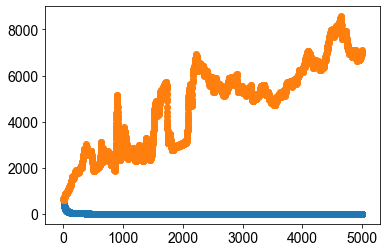

In [87]:
plt.scatter(list(range(5000)),self.logs['loss_train'])
plt.scatter(list(range(5000)),self.logs['loss_valid'])

In [89]:
def normalize(x):
    keep = np.where(np.linalg.norm(X, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x - np.mean(x, axis = 0))/ np.var(x, axis = 0)**(0.5))


In [91]:
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 5000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/5000 Batch 0000/0, Loss:  271.4688, rec_loss:  271.4661, KL_loss:    0.0027
Epoch 01/5000 Batch 0000/0, Loss:  251.5580, rec_loss:  251.5529, KL_loss:    0.0050
Epoch 02/5000 Batch 0000/0, Loss:  245.1967, rec_loss:  245.1874, KL_loss:    0.0093
Epoch 03/5000 Batch 0000/0, Loss:  234.7858, rec_loss:  234.7721, KL_loss:    0.0137
Epoch 04/5000 Batch 0000/0, Loss:  221.4691, rec_loss:  221.4503, KL_loss:    0.0188
Epoch 05/5000 Batch 0000/0, Loss:  210.5742, rec_loss:  210.5457, KL_loss:    0.0285
Epoch 06/5000 Batch 0000/0, Loss:  207.7317, rec_loss:  207.6674, KL_loss:    0.0644
Epoch 07/5000 Batch 0000/0, Loss:  187.8148, rec_loss:  187.7758, KL_loss:    0.0390
Epoch 08/5000 Batch 0000/0, Loss:  181.0934, rec_loss:  181.0502, KL_loss:    0.0432
Epoch 09/5000 Batch 0000/0, Loss:  173.9779, rec_loss:  173.9298, KL_loss:    0.0482
Epoch 10/5000 Batch 0000/0, Loss:  165.24

Epoch 99/5000 Batch 0000/0, Loss:   24.2788, rec_loss:   24.1839, KL_loss:    0.0949
Epoch 100/5000 Batch 0000/0, Loss:   24.0577, rec_loss:   23.9627, KL_loss:    0.0950
Epoch 101/5000 Batch 0000/0, Loss:   23.9043, rec_loss:   23.8092, KL_loss:    0.0951
Epoch 102/5000 Batch 0000/0, Loss:   23.6960, rec_loss:   23.6008, KL_loss:    0.0952
Epoch 103/5000 Batch 0000/0, Loss:   23.4111, rec_loss:   23.3159, KL_loss:    0.0953
Epoch 104/5000 Batch 0000/0, Loss:   23.0722, rec_loss:   22.9768, KL_loss:    0.0954
Epoch 105/5000 Batch 0000/0, Loss:   23.0337, rec_loss:   22.9383, KL_loss:    0.0954
Epoch 106/5000 Batch 0000/0, Loss:   22.9580, rec_loss:   22.8624, KL_loss:    0.0956
Epoch 107/5000 Batch 0000/0, Loss:   22.7946, rec_loss:   22.6990, KL_loss:    0.0956
Epoch 108/5000 Batch 0000/0, Loss:   22.6281, rec_loss:   22.5323, KL_loss:    0.0958
Epoch 109/5000 Batch 0000/0, Loss:   22.2223, rec_loss:   22.1265, KL_loss:    0.0958
Epoch 110/5000 Batch 0000/0, Loss:   21.8374, rec_loss:

Epoch 195/5000 Batch 0000/0, Loss:   13.0501, rec_loss:   12.9469, KL_loss:    0.1032
Epoch 196/5000 Batch 0000/0, Loss:   13.1663, rec_loss:   13.0629, KL_loss:    0.1034
Epoch 197/5000 Batch 0000/0, Loss:   12.8059, rec_loss:   12.7024, KL_loss:    0.1035
Epoch 198/5000 Batch 0000/0, Loss:   12.3201, rec_loss:   12.2165, KL_loss:    0.1036
Epoch 199/5000 Batch 0000/0, Loss:   12.5189, rec_loss:   12.4152, KL_loss:    0.1037
Epoch 200/5000 Batch 0000/0, Loss:   12.4885, rec_loss:   12.3847, KL_loss:    0.1038
Epoch 201/5000 Batch 0000/0, Loss:   12.1428, rec_loss:   12.0389, KL_loss:    0.1039
Epoch 202/5000 Batch 0000/0, Loss:   12.1611, rec_loss:   12.0572, KL_loss:    0.1040
Epoch 203/5000 Batch 0000/0, Loss:   12.1310, rec_loss:   12.0270, KL_loss:    0.1040
Epoch 204/5000 Batch 0000/0, Loss:   11.9791, rec_loss:   11.8750, KL_loss:    0.1041
Epoch 205/5000 Batch 0000/0, Loss:   11.8984, rec_loss:   11.7943, KL_loss:    0.1041
Epoch 206/5000 Batch 0000/0, Loss:   11.8186, rec_loss

Epoch 291/5000 Batch 0000/0, Loss:    9.7377, rec_loss:    9.6305, KL_loss:    0.1072
Epoch 292/5000 Batch 0000/0, Loss:    9.4071, rec_loss:    9.2999, KL_loss:    0.1072
Epoch 293/5000 Batch 0000/0, Loss:    9.3127, rec_loss:    9.2054, KL_loss:    0.1073
Epoch 294/5000 Batch 0000/0, Loss:    9.3793, rec_loss:    9.2719, KL_loss:    0.1074
Epoch 295/5000 Batch 0000/0, Loss:    9.3316, rec_loss:    9.2241, KL_loss:    0.1075
Epoch 296/5000 Batch 0000/0, Loss:    9.1984, rec_loss:    9.0909, KL_loss:    0.1075
Epoch 297/5000 Batch 0000/0, Loss:    8.9730, rec_loss:    8.8654, KL_loss:    0.1076
Epoch 298/5000 Batch 0000/0, Loss:    8.9822, rec_loss:    8.8746, KL_loss:    0.1076
Epoch 299/5000 Batch 0000/0, Loss:    8.8612, rec_loss:    8.7535, KL_loss:    0.1077
Epoch 300/5000 Batch 0000/0, Loss:    8.8388, rec_loss:    8.7310, KL_loss:    0.1078
Epoch 301/5000 Batch 0000/0, Loss:    8.7935, rec_loss:    8.6857, KL_loss:    0.1078
Epoch 302/5000 Batch 0000/0, Loss:    8.7042, rec_loss

Epoch 387/5000 Batch 0000/0, Loss:    6.9376, rec_loss:    6.8277, KL_loss:    0.1100
Epoch 388/5000 Batch 0000/0, Loss:    6.9131, rec_loss:    6.8032, KL_loss:    0.1099
Epoch 389/5000 Batch 0000/0, Loss:    6.8574, rec_loss:    6.7475, KL_loss:    0.1099
Epoch 390/5000 Batch 0000/0, Loss:    6.8218, rec_loss:    6.7118, KL_loss:    0.1099
Epoch 391/5000 Batch 0000/0, Loss:    6.8078, rec_loss:    6.6979, KL_loss:    0.1099
Epoch 392/5000 Batch 0000/0, Loss:    6.7626, rec_loss:    6.6527, KL_loss:    0.1099
Epoch 393/5000 Batch 0000/0, Loss:    6.7434, rec_loss:    6.6335, KL_loss:    0.1099
Epoch 394/5000 Batch 0000/0, Loss:    6.7034, rec_loss:    6.5935, KL_loss:    0.1099
Epoch 395/5000 Batch 0000/0, Loss:    6.6919, rec_loss:    6.5821, KL_loss:    0.1099
Epoch 396/5000 Batch 0000/0, Loss:    6.6980, rec_loss:    6.5882, KL_loss:    0.1099
Epoch 397/5000 Batch 0000/0, Loss:    6.7367, rec_loss:    6.6269, KL_loss:    0.1099
Epoch 398/5000 Batch 0000/0, Loss:    6.7513, rec_loss

Epoch 483/5000 Batch 0000/0, Loss:    5.8020, rec_loss:    5.6903, KL_loss:    0.1117
Epoch 484/5000 Batch 0000/0, Loss:    5.7008, rec_loss:    5.5891, KL_loss:    0.1117
Epoch 485/5000 Batch 0000/0, Loss:    5.9132, rec_loss:    5.8015, KL_loss:    0.1117
Epoch 486/5000 Batch 0000/0, Loss:    5.9313, rec_loss:    5.8195, KL_loss:    0.1118
Epoch 487/5000 Batch 0000/0, Loss:    5.7144, rec_loss:    5.6026, KL_loss:    0.1118
Epoch 488/5000 Batch 0000/0, Loss:    5.6204, rec_loss:    5.5085, KL_loss:    0.1118
Epoch 489/5000 Batch 0000/0, Loss:    5.7128, rec_loss:    5.6010, KL_loss:    0.1119
Epoch 490/5000 Batch 0000/0, Loss:    5.6639, rec_loss:    5.5521, KL_loss:    0.1119
Epoch 491/5000 Batch 0000/0, Loss:    5.5569, rec_loss:    5.4450, KL_loss:    0.1119
Epoch 492/5000 Batch 0000/0, Loss:    5.5859, rec_loss:    5.4739, KL_loss:    0.1119
Epoch 493/5000 Batch 0000/0, Loss:    5.6490, rec_loss:    5.5371, KL_loss:    0.1119
Epoch 494/5000 Batch 0000/0, Loss:    5.5968, rec_loss

Epoch 581/5000 Batch 0000/0, Loss:    4.8896, rec_loss:    4.7766, KL_loss:    0.1130
Epoch 582/5000 Batch 0000/0, Loss:    4.9383, rec_loss:    4.8253, KL_loss:    0.1130
Epoch 583/5000 Batch 0000/0, Loss:    5.0274, rec_loss:    4.9143, KL_loss:    0.1130
Epoch 584/5000 Batch 0000/0, Loss:    4.9563, rec_loss:    4.8432, KL_loss:    0.1131
Epoch 585/5000 Batch 0000/0, Loss:    4.8776, rec_loss:    4.7645, KL_loss:    0.1131
Epoch 586/5000 Batch 0000/0, Loss:    4.8409, rec_loss:    4.7278, KL_loss:    0.1131
Epoch 587/5000 Batch 0000/0, Loss:    4.8396, rec_loss:    4.7265, KL_loss:    0.1131
Epoch 588/5000 Batch 0000/0, Loss:    4.7950, rec_loss:    4.6819, KL_loss:    0.1131
Epoch 589/5000 Batch 0000/0, Loss:    4.7283, rec_loss:    4.6151, KL_loss:    0.1131
Epoch 590/5000 Batch 0000/0, Loss:    4.7386, rec_loss:    4.6255, KL_loss:    0.1132
Epoch 591/5000 Batch 0000/0, Loss:    4.7123, rec_loss:    4.5991, KL_loss:    0.1132
Epoch 592/5000 Batch 0000/0, Loss:    4.6586, rec_loss

Epoch 678/5000 Batch 0000/0, Loss:    4.1645, rec_loss:    4.0503, KL_loss:    0.1141
Epoch 679/5000 Batch 0000/0, Loss:    4.1709, rec_loss:    4.0569, KL_loss:    0.1141
Epoch 680/5000 Batch 0000/0, Loss:    4.2180, rec_loss:    4.1040, KL_loss:    0.1141
Epoch 681/5000 Batch 0000/0, Loss:    4.2353, rec_loss:    4.1212, KL_loss:    0.1141
Epoch 682/5000 Batch 0000/0, Loss:    4.3062, rec_loss:    4.1921, KL_loss:    0.1140
Epoch 683/5000 Batch 0000/0, Loss:    4.3018, rec_loss:    4.1877, KL_loss:    0.1140
Epoch 684/5000 Batch 0000/0, Loss:    4.2677, rec_loss:    4.1537, KL_loss:    0.1140
Epoch 685/5000 Batch 0000/0, Loss:    4.2583, rec_loss:    4.1443, KL_loss:    0.1140
Epoch 686/5000 Batch 0000/0, Loss:    4.2089, rec_loss:    4.0949, KL_loss:    0.1140
Epoch 687/5000 Batch 0000/0, Loss:    4.1637, rec_loss:    4.0497, KL_loss:    0.1140
Epoch 688/5000 Batch 0000/0, Loss:    4.0725, rec_loss:    3.9585, KL_loss:    0.1140
Epoch 689/5000 Batch 0000/0, Loss:    3.9904, rec_loss

Epoch 778/5000 Batch 0000/0, Loss:    3.7513, rec_loss:    3.6362, KL_loss:    0.1151
Epoch 779/5000 Batch 0000/0, Loss:    3.7651, rec_loss:    3.6500, KL_loss:    0.1151
Epoch 780/5000 Batch 0000/0, Loss:    3.8235, rec_loss:    3.7084, KL_loss:    0.1151
Epoch 781/5000 Batch 0000/0, Loss:    3.8401, rec_loss:    3.7250, KL_loss:    0.1151
Epoch 782/5000 Batch 0000/0, Loss:    3.8787, rec_loss:    3.7636, KL_loss:    0.1151
Epoch 783/5000 Batch 0000/0, Loss:    3.8332, rec_loss:    3.7181, KL_loss:    0.1151
Epoch 784/5000 Batch 0000/0, Loss:    3.7492, rec_loss:    3.6341, KL_loss:    0.1151
Epoch 785/5000 Batch 0000/0, Loss:    3.7009, rec_loss:    3.5858, KL_loss:    0.1151
Epoch 786/5000 Batch 0000/0, Loss:    3.6956, rec_loss:    3.5804, KL_loss:    0.1151
Epoch 787/5000 Batch 0000/0, Loss:    3.7774, rec_loss:    3.6623, KL_loss:    0.1151
Epoch 788/5000 Batch 0000/0, Loss:    3.9712, rec_loss:    3.8561, KL_loss:    0.1151
Epoch 789/5000 Batch 0000/0, Loss:    4.2059, rec_loss

Epoch 877/5000 Batch 0000/0, Loss:    3.4602, rec_loss:    3.3447, KL_loss:    0.1155
Epoch 878/5000 Batch 0000/0, Loss:    3.5423, rec_loss:    3.4267, KL_loss:    0.1155
Epoch 879/5000 Batch 0000/0, Loss:    3.6645, rec_loss:    3.5490, KL_loss:    0.1155
Epoch 880/5000 Batch 0000/0, Loss:    3.8043, rec_loss:    3.6887, KL_loss:    0.1155
Epoch 881/5000 Batch 0000/0, Loss:    4.0006, rec_loss:    3.8851, KL_loss:    0.1156
Epoch 882/5000 Batch 0000/0, Loss:    4.1498, rec_loss:    4.0341, KL_loss:    0.1156
Epoch 883/5000 Batch 0000/0, Loss:    4.1076, rec_loss:    3.9920, KL_loss:    0.1156
Epoch 884/5000 Batch 0000/0, Loss:    4.1034, rec_loss:    3.9877, KL_loss:    0.1157
Epoch 885/5000 Batch 0000/0, Loss:    3.9141, rec_loss:    3.7984, KL_loss:    0.1157
Epoch 886/5000 Batch 0000/0, Loss:    3.8529, rec_loss:    3.7371, KL_loss:    0.1158
Epoch 887/5000 Batch 0000/0, Loss:    3.8243, rec_loss:    3.7085, KL_loss:    0.1158
Epoch 888/5000 Batch 0000/0, Loss:    3.8587, rec_loss

Epoch 973/5000 Batch 0000/0, Loss:    3.4623, rec_loss:    3.3460, KL_loss:    0.1163
Epoch 974/5000 Batch 0000/0, Loss:    3.4096, rec_loss:    3.2933, KL_loss:    0.1163
Epoch 975/5000 Batch 0000/0, Loss:    3.4323, rec_loss:    3.3159, KL_loss:    0.1163
Epoch 976/5000 Batch 0000/0, Loss:    3.4632, rec_loss:    3.3468, KL_loss:    0.1164
Epoch 977/5000 Batch 0000/0, Loss:    3.4129, rec_loss:    3.2966, KL_loss:    0.1164
Epoch 978/5000 Batch 0000/0, Loss:    3.3553, rec_loss:    3.2389, KL_loss:    0.1164
Epoch 979/5000 Batch 0000/0, Loss:    3.2567, rec_loss:    3.1403, KL_loss:    0.1164
Epoch 980/5000 Batch 0000/0, Loss:    3.1969, rec_loss:    3.0805, KL_loss:    0.1164
Epoch 981/5000 Batch 0000/0, Loss:    3.1804, rec_loss:    3.0640, KL_loss:    0.1164
Epoch 982/5000 Batch 0000/0, Loss:    3.1949, rec_loss:    3.0785, KL_loss:    0.1164
Epoch 983/5000 Batch 0000/0, Loss:    3.2347, rec_loss:    3.1183, KL_loss:    0.1164
Epoch 984/5000 Batch 0000/0, Loss:    3.2257, rec_loss

Epoch 1068/5000 Batch 0000/0, Loss:    3.0224, rec_loss:    2.9056, KL_loss:    0.1168
Epoch 1069/5000 Batch 0000/0, Loss:    3.0306, rec_loss:    2.9138, KL_loss:    0.1168
Epoch 1070/5000 Batch 0000/0, Loss:    3.0749, rec_loss:    2.9582, KL_loss:    0.1168
Epoch 1071/5000 Batch 0000/0, Loss:    3.1558, rec_loss:    3.0390, KL_loss:    0.1168
Epoch 1072/5000 Batch 0000/0, Loss:    3.2550, rec_loss:    3.1382, KL_loss:    0.1168
Epoch 1073/5000 Batch 0000/0, Loss:    3.3380, rec_loss:    3.2213, KL_loss:    0.1168
Epoch 1074/5000 Batch 0000/0, Loss:    3.3607, rec_loss:    3.2439, KL_loss:    0.1168
Epoch 1075/5000 Batch 0000/0, Loss:    3.3036, rec_loss:    3.1868, KL_loss:    0.1168
Epoch 1076/5000 Batch 0000/0, Loss:    3.2303, rec_loss:    3.1135, KL_loss:    0.1168
Epoch 1077/5000 Batch 0000/0, Loss:    3.2288, rec_loss:    3.1121, KL_loss:    0.1168
Epoch 1078/5000 Batch 0000/0, Loss:    3.3768, rec_loss:    3.2600, KL_loss:    0.1168
Epoch 1079/5000 Batch 0000/0, Loss:    3.54

KeyboardInterrupt: 

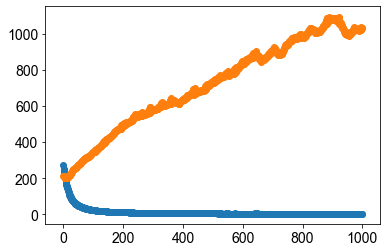

In [93]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])

In [94]:
        #decrease batch size
        xnorm = normalize(X)#scalerX.fit_transform(X)
        ynorm = normalize(Y)#np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=30
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 5000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [227, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/5000 Batch 0000/9, Loss:  170.7618, rec_loss:  170.7588, KL_loss:    0.0030
Epoch 00/5000 Batch 0009/9, Loss:  261.0148, rec_loss:  260.9987, KL_loss:    0.0161
Epoch 01/5000 Batch 0000/9, Loss:  219.5961, rec_loss:  219.5764, KL_loss:    0.0197
Epoch 01/5000 Batch 0009/9, Loss:  281.7173, rec_loss:  281.6781, KL_loss:    0.0393
Epoch 02/5000 Batch 0000/9, Loss:  236.9806, rec_loss:  236.9324, KL_loss:    0.0482
Epoch 02/5000 Batch 0009/9, Loss:  242.7487, rec_loss:  242.6998, KL_loss:    0.0489
Epoch 03/5000 Batch 0000/9, Loss:   98.3208, rec_loss:   98.2669, KL_loss:    0.0539
Epoch 03/5000 Batch 0009/9, Loss:  185.2822, rec_loss:  185.2137, KL_loss:    0.0685
Epoch 04/5000 Batch 0000/9, Loss:  125.8534, rec_loss:  125.7872, KL_loss:    0.0662
Epoch 04/5000 Batch 0009/9, Loss:  140.2596, rec_loss:  140.1851, KL_loss:    0.0745
Epoch 05/5000 Batch 0000/9, Loss:   91.14

Epoch 49/5000 Batch 0009/9, Loss:   51.4436, rec_loss:   51.3090, KL_loss:    0.1345
Epoch 50/5000 Batch 0000/9, Loss:   48.6833, rec_loss:   48.5598, KL_loss:    0.1235
Epoch 50/5000 Batch 0009/9, Loss:   54.8547, rec_loss:   54.7331, KL_loss:    0.1216
Epoch 51/5000 Batch 0000/9, Loss:   44.0257, rec_loss:   43.8980, KL_loss:    0.1276
Epoch 51/5000 Batch 0009/9, Loss:   51.7469, rec_loss:   51.6135, KL_loss:    0.1334
Epoch 52/5000 Batch 0000/9, Loss:   53.5522, rec_loss:   53.4184, KL_loss:    0.1338
Epoch 52/5000 Batch 0009/9, Loss:   57.3520, rec_loss:   57.2276, KL_loss:    0.1244
Epoch 53/5000 Batch 0000/9, Loss:   34.7239, rec_loss:   34.5949, KL_loss:    0.1290
Epoch 53/5000 Batch 0009/9, Loss:   43.9031, rec_loss:   43.7695, KL_loss:    0.1336
Epoch 54/5000 Batch 0000/9, Loss:   58.2168, rec_loss:   58.0836, KL_loss:    0.1332
Epoch 54/5000 Batch 0009/9, Loss:   61.3270, rec_loss:   61.1937, KL_loss:    0.1332
Epoch 55/5000 Batch 0000/9, Loss:   37.4751, rec_loss:   37.3431,

Epoch 99/5000 Batch 0009/9, Loss:   36.0291, rec_loss:   35.8834, KL_loss:    0.1457
Epoch 100/5000 Batch 0000/9, Loss:   42.0449, rec_loss:   41.8856, KL_loss:    0.1593
Epoch 100/5000 Batch 0009/9, Loss:   53.2112, rec_loss:   53.0684, KL_loss:    0.1427
Epoch 101/5000 Batch 0000/9, Loss:   43.7437, rec_loss:   43.5886, KL_loss:    0.1551
Epoch 101/5000 Batch 0009/9, Loss:   43.2448, rec_loss:   43.0956, KL_loss:    0.1492
Epoch 102/5000 Batch 0000/9, Loss:   43.7330, rec_loss:   43.5723, KL_loss:    0.1607
Epoch 102/5000 Batch 0009/9, Loss:   33.6227, rec_loss:   33.4787, KL_loss:    0.1440
Epoch 103/5000 Batch 0000/9, Loss:   34.6587, rec_loss:   34.5116, KL_loss:    0.1471
Epoch 103/5000 Batch 0009/9, Loss:   62.4334, rec_loss:   62.2765, KL_loss:    0.1569
Epoch 104/5000 Batch 0000/9, Loss:   43.0489, rec_loss:   42.8966, KL_loss:    0.1523
Epoch 104/5000 Batch 0009/9, Loss:   57.3991, rec_loss:   57.2418, KL_loss:    0.1572
Epoch 105/5000 Batch 0000/9, Loss:   64.3014, rec_loss:

Epoch 147/5000 Batch 0009/9, Loss:   29.2171, rec_loss:   29.0553, KL_loss:    0.1617
Epoch 148/5000 Batch 0000/9, Loss:   53.0598, rec_loss:   52.8939, KL_loss:    0.1659
Epoch 148/5000 Batch 0009/9, Loss:   42.3123, rec_loss:   42.1465, KL_loss:    0.1657
Epoch 149/5000 Batch 0000/9, Loss:   30.7338, rec_loss:   30.5781, KL_loss:    0.1557
Epoch 149/5000 Batch 0009/9, Loss:   44.0490, rec_loss:   43.8799, KL_loss:    0.1691
Epoch 150/5000 Batch 0000/9, Loss:   30.7553, rec_loss:   30.5948, KL_loss:    0.1605
Epoch 150/5000 Batch 0009/9, Loss:   42.9159, rec_loss:   42.7688, KL_loss:    0.1471
Epoch 151/5000 Batch 0000/9, Loss:   24.7987, rec_loss:   24.6259, KL_loss:    0.1728
Epoch 151/5000 Batch 0009/9, Loss:   57.9198, rec_loss:   57.7621, KL_loss:    0.1577
Epoch 152/5000 Batch 0000/9, Loss:   30.1313, rec_loss:   29.9679, KL_loss:    0.1634
Epoch 152/5000 Batch 0009/9, Loss:   46.4148, rec_loss:   46.2501, KL_loss:    0.1647
Epoch 153/5000 Batch 0000/9, Loss:   31.4557, rec_loss

Epoch 195/5000 Batch 0009/9, Loss:   41.6679, rec_loss:   41.4725, KL_loss:    0.1954
Epoch 196/5000 Batch 0000/9, Loss:   39.6727, rec_loss:   39.4876, KL_loss:    0.1852
Epoch 196/5000 Batch 0009/9, Loss:   42.5501, rec_loss:   42.3637, KL_loss:    0.1864
Epoch 197/5000 Batch 0000/9, Loss:   29.0920, rec_loss:   28.9041, KL_loss:    0.1879
Epoch 197/5000 Batch 0009/9, Loss:   35.4060, rec_loss:   35.2443, KL_loss:    0.1617
Epoch 198/5000 Batch 0000/9, Loss:   39.3806, rec_loss:   39.2156, KL_loss:    0.1650
Epoch 198/5000 Batch 0009/9, Loss:   34.9056, rec_loss:   34.7347, KL_loss:    0.1709
Epoch 199/5000 Batch 0000/9, Loss:   21.2076, rec_loss:   21.0317, KL_loss:    0.1759
Epoch 199/5000 Batch 0009/9, Loss:   39.5789, rec_loss:   39.3957, KL_loss:    0.1832
Epoch 200/5000 Batch 0000/9, Loss:   21.5097, rec_loss:   21.3314, KL_loss:    0.1784
Epoch 200/5000 Batch 0009/9, Loss:   30.6057, rec_loss:   30.4338, KL_loss:    0.1719
Epoch 201/5000 Batch 0000/9, Loss:   30.3570, rec_loss

Epoch 243/5000 Batch 0009/9, Loss:   32.9022, rec_loss:   32.7159, KL_loss:    0.1863
Epoch 244/5000 Batch 0000/9, Loss:   30.8760, rec_loss:   30.6936, KL_loss:    0.1824
Epoch 244/5000 Batch 0009/9, Loss:   47.6947, rec_loss:   47.4965, KL_loss:    0.1982
Epoch 245/5000 Batch 0000/9, Loss:   23.7219, rec_loss:   23.5518, KL_loss:    0.1701
Epoch 245/5000 Batch 0009/9, Loss:   33.7393, rec_loss:   33.5626, KL_loss:    0.1767
Epoch 246/5000 Batch 0000/9, Loss:   23.7749, rec_loss:   23.5631, KL_loss:    0.2118
Epoch 246/5000 Batch 0009/9, Loss:   33.7051, rec_loss:   33.5275, KL_loss:    0.1776
Epoch 247/5000 Batch 0000/9, Loss:   19.8296, rec_loss:   19.6164, KL_loss:    0.2132
Epoch 247/5000 Batch 0009/9, Loss:   39.3213, rec_loss:   39.1596, KL_loss:    0.1618
Epoch 248/5000 Batch 0000/9, Loss:   33.0575, rec_loss:   32.8390, KL_loss:    0.2186
Epoch 248/5000 Batch 0009/9, Loss:   35.7700, rec_loss:   35.5675, KL_loss:    0.2025
Epoch 249/5000 Batch 0000/9, Loss:   24.1711, rec_loss

Epoch 291/5000 Batch 0009/9, Loss:   28.0136, rec_loss:   27.8160, KL_loss:    0.1976
Epoch 292/5000 Batch 0000/9, Loss:   25.6585, rec_loss:   25.4576, KL_loss:    0.2009
Epoch 292/5000 Batch 0009/9, Loss:   27.4764, rec_loss:   27.2613, KL_loss:    0.2151
Epoch 293/5000 Batch 0000/9, Loss:   25.3613, rec_loss:   25.1559, KL_loss:    0.2054
Epoch 293/5000 Batch 0009/9, Loss:   36.5490, rec_loss:   36.3525, KL_loss:    0.1965
Epoch 294/5000 Batch 0000/9, Loss:   21.8429, rec_loss:   21.6373, KL_loss:    0.2056
Epoch 294/5000 Batch 0009/9, Loss:   38.6498, rec_loss:   38.4516, KL_loss:    0.1982
Epoch 295/5000 Batch 0000/9, Loss:   25.3993, rec_loss:   25.2138, KL_loss:    0.1854
Epoch 295/5000 Batch 0009/9, Loss:   31.1973, rec_loss:   30.9665, KL_loss:    0.2308
Epoch 296/5000 Batch 0000/9, Loss:   24.7606, rec_loss:   24.5756, KL_loss:    0.1850
Epoch 296/5000 Batch 0009/9, Loss:   36.6747, rec_loss:   36.4796, KL_loss:    0.1952
Epoch 297/5000 Batch 0000/9, Loss:   25.7424, rec_loss

Epoch 339/5000 Batch 0009/9, Loss:   40.2997, rec_loss:   40.0511, KL_loss:    0.2486
Epoch 340/5000 Batch 0000/9, Loss:   22.1535, rec_loss:   21.9468, KL_loss:    0.2067
Epoch 340/5000 Batch 0009/9, Loss:   38.6738, rec_loss:   38.4521, KL_loss:    0.2217
Epoch 341/5000 Batch 0000/9, Loss:   23.9800, rec_loss:   23.7457, KL_loss:    0.2343
Epoch 341/5000 Batch 0009/9, Loss:   30.4725, rec_loss:   30.2819, KL_loss:    0.1906
Epoch 342/5000 Batch 0000/9, Loss:   24.8511, rec_loss:   24.6177, KL_loss:    0.2333
Epoch 342/5000 Batch 0009/9, Loss:   23.9706, rec_loss:   23.7459, KL_loss:    0.2247
Epoch 343/5000 Batch 0000/9, Loss:   32.2359, rec_loss:   32.0104, KL_loss:    0.2254
Epoch 343/5000 Batch 0009/9, Loss:   32.1325, rec_loss:   31.9160, KL_loss:    0.2165
Epoch 344/5000 Batch 0000/9, Loss:   20.8744, rec_loss:   20.6562, KL_loss:    0.2181
Epoch 344/5000 Batch 0009/9, Loss:   28.5635, rec_loss:   28.3470, KL_loss:    0.2165
Epoch 345/5000 Batch 0000/9, Loss:   26.2035, rec_loss

Epoch 387/5000 Batch 0009/9, Loss:   37.0127, rec_loss:   36.7798, KL_loss:    0.2330
Epoch 388/5000 Batch 0000/9, Loss:   20.8289, rec_loss:   20.6088, KL_loss:    0.2201
Epoch 388/5000 Batch 0009/9, Loss:   47.7833, rec_loss:   47.5348, KL_loss:    0.2486
Epoch 389/5000 Batch 0000/9, Loss:   30.2792, rec_loss:   30.0369, KL_loss:    0.2423
Epoch 389/5000 Batch 0009/9, Loss:   31.6892, rec_loss:   31.4395, KL_loss:    0.2497
Epoch 390/5000 Batch 0000/9, Loss:   26.5078, rec_loss:   26.2590, KL_loss:    0.2488
Epoch 390/5000 Batch 0009/9, Loss:   25.3895, rec_loss:   25.1746, KL_loss:    0.2150
Epoch 391/5000 Batch 0000/9, Loss:   20.7482, rec_loss:   20.5010, KL_loss:    0.2472
Epoch 391/5000 Batch 0009/9, Loss:   43.1426, rec_loss:   42.8832, KL_loss:    0.2594
Epoch 392/5000 Batch 0000/9, Loss:   29.7348, rec_loss:   29.4987, KL_loss:    0.2361
Epoch 392/5000 Batch 0009/9, Loss:   26.6006, rec_loss:   26.3687, KL_loss:    0.2319
Epoch 393/5000 Batch 0000/9, Loss:   17.4343, rec_loss

Epoch 435/5000 Batch 0009/9, Loss:   22.6059, rec_loss:   22.3638, KL_loss:    0.2422
Epoch 436/5000 Batch 0000/9, Loss:   24.2010, rec_loss:   23.9556, KL_loss:    0.2454
Epoch 436/5000 Batch 0009/9, Loss:   40.5506, rec_loss:   40.2762, KL_loss:    0.2744
Epoch 437/5000 Batch 0000/9, Loss:   22.4308, rec_loss:   22.1888, KL_loss:    0.2421
Epoch 437/5000 Batch 0009/9, Loss:   17.4904, rec_loss:   17.2494, KL_loss:    0.2409
Epoch 438/5000 Batch 0000/9, Loss:   31.3072, rec_loss:   31.0408, KL_loss:    0.2664
Epoch 438/5000 Batch 0009/9, Loss:   31.7558, rec_loss:   31.5032, KL_loss:    0.2526
Epoch 439/5000 Batch 0000/9, Loss:   21.8548, rec_loss:   21.5741, KL_loss:    0.2807
Epoch 439/5000 Batch 0009/9, Loss:   33.5446, rec_loss:   33.3036, KL_loss:    0.2411
Epoch 440/5000 Batch 0000/9, Loss:   35.2284, rec_loss:   34.9949, KL_loss:    0.2335
Epoch 440/5000 Batch 0009/9, Loss:   26.4739, rec_loss:   26.2082, KL_loss:    0.2658
Epoch 441/5000 Batch 0000/9, Loss:   22.1561, rec_loss

Epoch 483/5000 Batch 0009/9, Loss:   29.1805, rec_loss:   28.9398, KL_loss:    0.2407
Epoch 484/5000 Batch 0000/9, Loss:   22.0154, rec_loss:   21.7419, KL_loss:    0.2734
Epoch 484/5000 Batch 0009/9, Loss:   19.1465, rec_loss:   18.8927, KL_loss:    0.2538
Epoch 485/5000 Batch 0000/9, Loss:   29.9158, rec_loss:   29.6593, KL_loss:    0.2565
Epoch 485/5000 Batch 0009/9, Loss:   26.6967, rec_loss:   26.4376, KL_loss:    0.2591
Epoch 486/5000 Batch 0000/9, Loss:   21.4291, rec_loss:   21.1826, KL_loss:    0.2465
Epoch 486/5000 Batch 0009/9, Loss:   24.6061, rec_loss:   24.3519, KL_loss:    0.2542
Epoch 487/5000 Batch 0000/9, Loss:   38.8665, rec_loss:   38.5940, KL_loss:    0.2725
Epoch 487/5000 Batch 0009/9, Loss:   28.5694, rec_loss:   28.3054, KL_loss:    0.2639
Epoch 488/5000 Batch 0000/9, Loss:   29.3134, rec_loss:   29.0435, KL_loss:    0.2698
Epoch 488/5000 Batch 0009/9, Loss:   26.2533, rec_loss:   26.0013, KL_loss:    0.2520
Epoch 489/5000 Batch 0000/9, Loss:   26.0078, rec_loss

Epoch 531/5000 Batch 0009/9, Loss:   30.5410, rec_loss:   30.2618, KL_loss:    0.2792
Epoch 532/5000 Batch 0000/9, Loss:   23.9045, rec_loss:   23.6429, KL_loss:    0.2617
Epoch 532/5000 Batch 0009/9, Loss:   39.4352, rec_loss:   39.1268, KL_loss:    0.3084
Epoch 533/5000 Batch 0000/9, Loss:   26.6729, rec_loss:   26.4095, KL_loss:    0.2633
Epoch 533/5000 Batch 0009/9, Loss:   39.3118, rec_loss:   39.0282, KL_loss:    0.2836
Epoch 534/5000 Batch 0000/9, Loss:   22.0179, rec_loss:   21.7682, KL_loss:    0.2498
Epoch 534/5000 Batch 0009/9, Loss:   34.9501, rec_loss:   34.6882, KL_loss:    0.2619
Epoch 535/5000 Batch 0000/9, Loss:   25.4064, rec_loss:   25.1587, KL_loss:    0.2478
Epoch 535/5000 Batch 0009/9, Loss:   24.6275, rec_loss:   24.3849, KL_loss:    0.2426
Epoch 536/5000 Batch 0000/9, Loss:   17.5036, rec_loss:   17.2166, KL_loss:    0.2870
Epoch 536/5000 Batch 0009/9, Loss:   22.1780, rec_loss:   21.9382, KL_loss:    0.2398
Epoch 537/5000 Batch 0000/9, Loss:   27.3866, rec_loss

Epoch 579/5000 Batch 0009/9, Loss:   22.1398, rec_loss:   21.8707, KL_loss:    0.2691
Epoch 580/5000 Batch 0000/9, Loss:   20.6735, rec_loss:   20.4057, KL_loss:    0.2678
Epoch 580/5000 Batch 0009/9, Loss:   27.8332, rec_loss:   27.5553, KL_loss:    0.2779
Epoch 581/5000 Batch 0000/9, Loss:   18.5732, rec_loss:   18.3062, KL_loss:    0.2670
Epoch 581/5000 Batch 0009/9, Loss:   24.4200, rec_loss:   24.1154, KL_loss:    0.3046
Epoch 582/5000 Batch 0000/9, Loss:   26.0012, rec_loss:   25.7243, KL_loss:    0.2769
Epoch 582/5000 Batch 0009/9, Loss:   39.1490, rec_loss:   38.8851, KL_loss:    0.2639
Epoch 583/5000 Batch 0000/9, Loss:   22.9969, rec_loss:   22.7179, KL_loss:    0.2790
Epoch 583/5000 Batch 0009/9, Loss:   35.1909, rec_loss:   34.9191, KL_loss:    0.2718
Epoch 584/5000 Batch 0000/9, Loss:   21.4497, rec_loss:   21.1663, KL_loss:    0.2834
Epoch 584/5000 Batch 0009/9, Loss:   34.5562, rec_loss:   34.3100, KL_loss:    0.2462
Epoch 585/5000 Batch 0000/9, Loss:   23.7149, rec_loss

Epoch 627/5000 Batch 0009/9, Loss:   21.3185, rec_loss:   21.0464, KL_loss:    0.2721
Epoch 628/5000 Batch 0000/9, Loss:   27.3418, rec_loss:   27.0469, KL_loss:    0.2950
Epoch 628/5000 Batch 0009/9, Loss:   23.4503, rec_loss:   23.1718, KL_loss:    0.2785
Epoch 629/5000 Batch 0000/9, Loss:   19.2206, rec_loss:   18.9336, KL_loss:    0.2870
Epoch 629/5000 Batch 0009/9, Loss:   21.2411, rec_loss:   20.9648, KL_loss:    0.2763
Epoch 630/5000 Batch 0000/9, Loss:   25.7984, rec_loss:   25.4899, KL_loss:    0.3085
Epoch 630/5000 Batch 0009/9, Loss:   31.3287, rec_loss:   31.0615, KL_loss:    0.2673
Epoch 631/5000 Batch 0000/9, Loss:   32.2544, rec_loss:   31.9683, KL_loss:    0.2861
Epoch 631/5000 Batch 0009/9, Loss:   20.4805, rec_loss:   20.2264, KL_loss:    0.2541
Epoch 632/5000 Batch 0000/9, Loss:   15.8375, rec_loss:   15.5841, KL_loss:    0.2534
Epoch 632/5000 Batch 0009/9, Loss:   24.8329, rec_loss:   24.5395, KL_loss:    0.2934
Epoch 633/5000 Batch 0000/9, Loss:   22.3485, rec_loss

Epoch 675/5000 Batch 0009/9, Loss:   24.3456, rec_loss:   24.0113, KL_loss:    0.3344
Epoch 676/5000 Batch 0000/9, Loss:   28.4503, rec_loss:   28.1510, KL_loss:    0.2993
Epoch 676/5000 Batch 0009/9, Loss:   19.6377, rec_loss:   19.3409, KL_loss:    0.2968
Epoch 677/5000 Batch 0000/9, Loss:   21.0771, rec_loss:   20.8101, KL_loss:    0.2669
Epoch 677/5000 Batch 0009/9, Loss:   27.1074, rec_loss:   26.7992, KL_loss:    0.3083
Epoch 678/5000 Batch 0000/9, Loss:   29.1407, rec_loss:   28.8403, KL_loss:    0.3004
Epoch 678/5000 Batch 0009/9, Loss:   17.7636, rec_loss:   17.4828, KL_loss:    0.2807
Epoch 679/5000 Batch 0000/9, Loss:   20.6264, rec_loss:   20.3193, KL_loss:    0.3071
Epoch 679/5000 Batch 0009/9, Loss:   23.5348, rec_loss:   23.2083, KL_loss:    0.3265
Epoch 680/5000 Batch 0000/9, Loss:   20.7570, rec_loss:   20.4968, KL_loss:    0.2602
Epoch 680/5000 Batch 0009/9, Loss:   27.0991, rec_loss:   26.8049, KL_loss:    0.2941
Epoch 681/5000 Batch 0000/9, Loss:   28.3909, rec_loss

Epoch 723/5000 Batch 0009/9, Loss:   18.5844, rec_loss:   18.3013, KL_loss:    0.2831
Epoch 724/5000 Batch 0000/9, Loss:   17.5435, rec_loss:   17.2403, KL_loss:    0.3032
Epoch 724/5000 Batch 0009/9, Loss:   21.0701, rec_loss:   20.7544, KL_loss:    0.3157
Epoch 725/5000 Batch 0000/9, Loss:   31.7568, rec_loss:   31.4673, KL_loss:    0.2895
Epoch 725/5000 Batch 0009/9, Loss:   21.8870, rec_loss:   21.5614, KL_loss:    0.3256
Epoch 726/5000 Batch 0000/9, Loss:   21.4374, rec_loss:   21.1646, KL_loss:    0.2728
Epoch 726/5000 Batch 0009/9, Loss:   16.2867, rec_loss:   16.0036, KL_loss:    0.2831
Epoch 727/5000 Batch 0000/9, Loss:   23.1502, rec_loss:   22.8741, KL_loss:    0.2761
Epoch 727/5000 Batch 0009/9, Loss:   20.6161, rec_loss:   20.3112, KL_loss:    0.3049
Epoch 728/5000 Batch 0000/9, Loss:   25.9834, rec_loss:   25.6826, KL_loss:    0.3008
Epoch 728/5000 Batch 0009/9, Loss:   22.1450, rec_loss:   21.8443, KL_loss:    0.3007
Epoch 729/5000 Batch 0000/9, Loss:   30.8293, rec_loss

Epoch 771/5000 Batch 0009/9, Loss:   19.8643, rec_loss:   19.5797, KL_loss:    0.2847
Epoch 772/5000 Batch 0000/9, Loss:   22.2280, rec_loss:   21.9324, KL_loss:    0.2956
Epoch 772/5000 Batch 0009/9, Loss:   23.3154, rec_loss:   23.0066, KL_loss:    0.3088
Epoch 773/5000 Batch 0000/9, Loss:   19.5252, rec_loss:   19.2099, KL_loss:    0.3153
Epoch 773/5000 Batch 0009/9, Loss:   23.6313, rec_loss:   23.3258, KL_loss:    0.3055
Epoch 774/5000 Batch 0000/9, Loss:   16.3020, rec_loss:   16.0017, KL_loss:    0.3003
Epoch 774/5000 Batch 0009/9, Loss:   26.6061, rec_loss:   26.3039, KL_loss:    0.3022
Epoch 775/5000 Batch 0000/9, Loss:   23.7676, rec_loss:   23.4696, KL_loss:    0.2979
Epoch 775/5000 Batch 0009/9, Loss:   22.4011, rec_loss:   22.0870, KL_loss:    0.3140
Epoch 776/5000 Batch 0000/9, Loss:   21.9397, rec_loss:   21.6552, KL_loss:    0.2845
Epoch 776/5000 Batch 0009/9, Loss:   22.9774, rec_loss:   22.6551, KL_loss:    0.3223
Epoch 777/5000 Batch 0000/9, Loss:   22.8830, rec_loss

Epoch 819/5000 Batch 0009/9, Loss:   23.2487, rec_loss:   22.9096, KL_loss:    0.3392
Epoch 820/5000 Batch 0000/9, Loss:   23.6297, rec_loss:   23.2884, KL_loss:    0.3413
Epoch 820/5000 Batch 0009/9, Loss:   22.9474, rec_loss:   22.6148, KL_loss:    0.3326
Epoch 821/5000 Batch 0000/9, Loss:   17.5028, rec_loss:   17.2013, KL_loss:    0.3014
Epoch 821/5000 Batch 0009/9, Loss:   27.3582, rec_loss:   27.0319, KL_loss:    0.3263
Epoch 822/5000 Batch 0000/9, Loss:   14.8914, rec_loss:   14.6167, KL_loss:    0.2748
Epoch 822/5000 Batch 0009/9, Loss:   17.5273, rec_loss:   17.2238, KL_loss:    0.3035
Epoch 823/5000 Batch 0000/9, Loss:   22.5534, rec_loss:   22.2319, KL_loss:    0.3215
Epoch 823/5000 Batch 0009/9, Loss:   19.5263, rec_loss:   19.2160, KL_loss:    0.3103
Epoch 824/5000 Batch 0000/9, Loss:   21.8056, rec_loss:   21.4728, KL_loss:    0.3328
Epoch 824/5000 Batch 0009/9, Loss:   30.9514, rec_loss:   30.6535, KL_loss:    0.2979
Epoch 825/5000 Batch 0000/9, Loss:   21.5299, rec_loss

Epoch 867/5000 Batch 0009/9, Loss:   16.7151, rec_loss:   16.4020, KL_loss:    0.3130
Epoch 868/5000 Batch 0000/9, Loss:   20.9016, rec_loss:   20.5914, KL_loss:    0.3102
Epoch 868/5000 Batch 0009/9, Loss:   20.4898, rec_loss:   20.1778, KL_loss:    0.3120
Epoch 869/5000 Batch 0000/9, Loss:   26.6751, rec_loss:   26.3851, KL_loss:    0.2899
Epoch 869/5000 Batch 0009/9, Loss:   27.6706, rec_loss:   27.3520, KL_loss:    0.3186
Epoch 870/5000 Batch 0000/9, Loss:   19.2282, rec_loss:   18.9305, KL_loss:    0.2977
Epoch 870/5000 Batch 0009/9, Loss:   27.2676, rec_loss:   26.9706, KL_loss:    0.2970
Epoch 871/5000 Batch 0000/9, Loss:   18.0873, rec_loss:   17.7813, KL_loss:    0.3059
Epoch 871/5000 Batch 0009/9, Loss:   20.2484, rec_loss:   19.9146, KL_loss:    0.3338
Epoch 872/5000 Batch 0000/9, Loss:   20.7589, rec_loss:   20.4657, KL_loss:    0.2932
Epoch 872/5000 Batch 0009/9, Loss:   37.7848, rec_loss:   37.4277, KL_loss:    0.3571
Epoch 873/5000 Batch 0000/9, Loss:   16.0464, rec_loss

Epoch 915/5000 Batch 0009/9, Loss:   30.1383, rec_loss:   29.8509, KL_loss:    0.2874
Epoch 916/5000 Batch 0000/9, Loss:   35.6084, rec_loss:   35.2794, KL_loss:    0.3290
Epoch 916/5000 Batch 0009/9, Loss:   24.3126, rec_loss:   23.9761, KL_loss:    0.3365
Epoch 917/5000 Batch 0000/9, Loss:   22.1460, rec_loss:   21.7752, KL_loss:    0.3708
Epoch 917/5000 Batch 0009/9, Loss:   22.7838, rec_loss:   22.4585, KL_loss:    0.3253
Epoch 918/5000 Batch 0000/9, Loss:   19.4173, rec_loss:   19.0907, KL_loss:    0.3266
Epoch 918/5000 Batch 0009/9, Loss:   29.2470, rec_loss:   28.9376, KL_loss:    0.3094
Epoch 919/5000 Batch 0000/9, Loss:   23.9366, rec_loss:   23.6347, KL_loss:    0.3019
Epoch 919/5000 Batch 0009/9, Loss:   25.4522, rec_loss:   25.1057, KL_loss:    0.3466
Epoch 920/5000 Batch 0000/9, Loss:   31.3565, rec_loss:   31.0237, KL_loss:    0.3329
Epoch 920/5000 Batch 0009/9, Loss:   17.2205, rec_loss:   16.9224, KL_loss:    0.2981
Epoch 921/5000 Batch 0000/9, Loss:   11.7876, rec_loss

Epoch 963/5000 Batch 0009/9, Loss:   20.5984, rec_loss:   20.2762, KL_loss:    0.3222
Epoch 964/5000 Batch 0000/9, Loss:   18.0109, rec_loss:   17.6966, KL_loss:    0.3143
Epoch 964/5000 Batch 0009/9, Loss:   26.6434, rec_loss:   26.3251, KL_loss:    0.3183
Epoch 965/5000 Batch 0000/9, Loss:   20.3037, rec_loss:   19.9716, KL_loss:    0.3321
Epoch 965/5000 Batch 0009/9, Loss:   24.9493, rec_loss:   24.6602, KL_loss:    0.2891
Epoch 966/5000 Batch 0000/9, Loss:   19.4135, rec_loss:   19.0718, KL_loss:    0.3418
Epoch 966/5000 Batch 0009/9, Loss:   19.9035, rec_loss:   19.5749, KL_loss:    0.3286
Epoch 967/5000 Batch 0000/9, Loss:   25.5728, rec_loss:   25.2430, KL_loss:    0.3298
Epoch 967/5000 Batch 0009/9, Loss:   32.7372, rec_loss:   32.4316, KL_loss:    0.3056
Epoch 968/5000 Batch 0000/9, Loss:   24.6594, rec_loss:   24.3120, KL_loss:    0.3474
Epoch 968/5000 Batch 0009/9, Loss:   18.5527, rec_loss:   18.2514, KL_loss:    0.3014
Epoch 969/5000 Batch 0000/9, Loss:   15.3670, rec_loss

Epoch 1011/5000 Batch 0009/9, Loss:   19.6166, rec_loss:   19.2877, KL_loss:    0.3288
Epoch 1012/5000 Batch 0000/9, Loss:   26.1202, rec_loss:   25.8120, KL_loss:    0.3082
Epoch 1012/5000 Batch 0009/9, Loss:   28.9134, rec_loss:   28.5440, KL_loss:    0.3694
Epoch 1013/5000 Batch 0000/9, Loss:   22.2245, rec_loss:   21.8794, KL_loss:    0.3451
Epoch 1013/5000 Batch 0009/9, Loss:   14.5120, rec_loss:   14.1960, KL_loss:    0.3160
Epoch 1014/5000 Batch 0000/9, Loss:   25.0383, rec_loss:   24.6868, KL_loss:    0.3515
Epoch 1014/5000 Batch 0009/9, Loss:   39.4379, rec_loss:   39.0870, KL_loss:    0.3509
Epoch 1015/5000 Batch 0000/9, Loss:   31.8787, rec_loss:   31.5338, KL_loss:    0.3449
Epoch 1015/5000 Batch 0009/9, Loss:   25.0345, rec_loss:   24.7503, KL_loss:    0.2842
Epoch 1016/5000 Batch 0000/9, Loss:   26.0020, rec_loss:   25.6656, KL_loss:    0.3364
Epoch 1016/5000 Batch 0009/9, Loss:   30.4860, rec_loss:   30.1614, KL_loss:    0.3246
Epoch 1017/5000 Batch 0000/9, Loss:   20.08

Epoch 1059/5000 Batch 0009/9, Loss:   27.1695, rec_loss:   26.8505, KL_loss:    0.3189
Epoch 1060/5000 Batch 0000/9, Loss:   19.7253, rec_loss:   19.4255, KL_loss:    0.2998
Epoch 1060/5000 Batch 0009/9, Loss:   22.9364, rec_loss:   22.6042, KL_loss:    0.3322
Epoch 1061/5000 Batch 0000/9, Loss:   18.2658, rec_loss:   17.9215, KL_loss:    0.3443
Epoch 1061/5000 Batch 0009/9, Loss:   15.9386, rec_loss:   15.6363, KL_loss:    0.3023
Epoch 1062/5000 Batch 0000/9, Loss:   16.4853, rec_loss:   16.1484, KL_loss:    0.3370
Epoch 1062/5000 Batch 0009/9, Loss:   21.4700, rec_loss:   21.1287, KL_loss:    0.3414
Epoch 1063/5000 Batch 0000/9, Loss:   22.2973, rec_loss:   21.9804, KL_loss:    0.3169
Epoch 1063/5000 Batch 0009/9, Loss:   28.8752, rec_loss:   28.5231, KL_loss:    0.3521
Epoch 1064/5000 Batch 0000/9, Loss:   17.7783, rec_loss:   17.4656, KL_loss:    0.3127
Epoch 1064/5000 Batch 0009/9, Loss:   18.5484, rec_loss:   18.2379, KL_loss:    0.3105
Epoch 1065/5000 Batch 0000/9, Loss:   13.02

Epoch 1107/5000 Batch 0009/9, Loss:   18.6408, rec_loss:   18.2964, KL_loss:    0.3444
Epoch 1108/5000 Batch 0000/9, Loss:   20.5480, rec_loss:   20.1983, KL_loss:    0.3497
Epoch 1108/5000 Batch 0009/9, Loss:   20.3384, rec_loss:   20.0242, KL_loss:    0.3142
Epoch 1109/5000 Batch 0000/9, Loss:   21.9728, rec_loss:   21.6181, KL_loss:    0.3547
Epoch 1109/5000 Batch 0009/9, Loss:   21.4807, rec_loss:   21.1383, KL_loss:    0.3424
Epoch 1110/5000 Batch 0000/9, Loss:   15.7409, rec_loss:   15.3963, KL_loss:    0.3446
Epoch 1110/5000 Batch 0009/9, Loss:   18.1508, rec_loss:   17.8584, KL_loss:    0.2924
Epoch 1111/5000 Batch 0000/9, Loss:   21.2192, rec_loss:   20.8970, KL_loss:    0.3222
Epoch 1111/5000 Batch 0009/9, Loss:   15.9445, rec_loss:   15.6241, KL_loss:    0.3204
Epoch 1112/5000 Batch 0000/9, Loss:   25.8460, rec_loss:   25.5114, KL_loss:    0.3345
Epoch 1112/5000 Batch 0009/9, Loss:   20.0278, rec_loss:   19.6965, KL_loss:    0.3313
Epoch 1113/5000 Batch 0000/9, Loss:   17.66

Epoch 1155/5000 Batch 0009/9, Loss:   20.4910, rec_loss:   20.1732, KL_loss:    0.3178
Epoch 1156/5000 Batch 0000/9, Loss:   20.4148, rec_loss:   20.0668, KL_loss:    0.3480
Epoch 1156/5000 Batch 0009/9, Loss:   17.4485, rec_loss:   17.1510, KL_loss:    0.2975
Epoch 1157/5000 Batch 0000/9, Loss:   24.7151, rec_loss:   24.3720, KL_loss:    0.3431
Epoch 1157/5000 Batch 0009/9, Loss:   31.9200, rec_loss:   31.5945, KL_loss:    0.3255
Epoch 1158/5000 Batch 0000/9, Loss:   23.9681, rec_loss:   23.6383, KL_loss:    0.3298
Epoch 1158/5000 Batch 0009/9, Loss:   20.4917, rec_loss:   20.1399, KL_loss:    0.3518
Epoch 1159/5000 Batch 0000/9, Loss:   10.9455, rec_loss:   10.6115, KL_loss:    0.3340
Epoch 1159/5000 Batch 0009/9, Loss:   16.7548, rec_loss:   16.4170, KL_loss:    0.3378
Epoch 1160/5000 Batch 0000/9, Loss:   20.2964, rec_loss:   19.9689, KL_loss:    0.3274
Epoch 1160/5000 Batch 0009/9, Loss:   18.4267, rec_loss:   18.1193, KL_loss:    0.3073
Epoch 1161/5000 Batch 0000/9, Loss:   20.35

Epoch 1203/5000 Batch 0009/9, Loss:   23.2079, rec_loss:   22.8701, KL_loss:    0.3378
Epoch 1204/5000 Batch 0000/9, Loss:   21.9931, rec_loss:   21.6523, KL_loss:    0.3409
Epoch 1204/5000 Batch 0009/9, Loss:   28.2041, rec_loss:   27.8505, KL_loss:    0.3536
Epoch 1205/5000 Batch 0000/9, Loss:   20.6637, rec_loss:   20.3309, KL_loss:    0.3328
Epoch 1205/5000 Batch 0009/9, Loss:   26.5138, rec_loss:   26.1553, KL_loss:    0.3585
Epoch 1206/5000 Batch 0000/9, Loss:   26.4021, rec_loss:   26.0828, KL_loss:    0.3194
Epoch 1206/5000 Batch 0009/9, Loss:   27.4985, rec_loss:   27.2009, KL_loss:    0.2976
Epoch 1207/5000 Batch 0000/9, Loss:   16.0734, rec_loss:   15.7076, KL_loss:    0.3659
Epoch 1207/5000 Batch 0009/9, Loss:   23.1404, rec_loss:   22.8551, KL_loss:    0.2853
Epoch 1208/5000 Batch 0000/9, Loss:   17.5570, rec_loss:   17.2313, KL_loss:    0.3257
Epoch 1208/5000 Batch 0009/9, Loss:   21.7531, rec_loss:   21.4236, KL_loss:    0.3295
Epoch 1209/5000 Batch 0000/9, Loss:   20.29

Epoch 1251/5000 Batch 0009/9, Loss:   26.5955, rec_loss:   26.2990, KL_loss:    0.2965
Epoch 1252/5000 Batch 0000/9, Loss:   15.7870, rec_loss:   15.4632, KL_loss:    0.3238
Epoch 1252/5000 Batch 0009/9, Loss:   30.3434, rec_loss:   29.9769, KL_loss:    0.3665
Epoch 1253/5000 Batch 0000/9, Loss:   30.1482, rec_loss:   29.7872, KL_loss:    0.3610
Epoch 1253/5000 Batch 0009/9, Loss:   14.7342, rec_loss:   14.3879, KL_loss:    0.3464
Epoch 1254/5000 Batch 0000/9, Loss:   21.1985, rec_loss:   20.8653, KL_loss:    0.3332
Epoch 1254/5000 Batch 0009/9, Loss:   17.0953, rec_loss:   16.7162, KL_loss:    0.3791
Epoch 1255/5000 Batch 0000/9, Loss:   18.4235, rec_loss:   18.1052, KL_loss:    0.3183
Epoch 1255/5000 Batch 0009/9, Loss:   14.8196, rec_loss:   14.4490, KL_loss:    0.3706
Epoch 1256/5000 Batch 0000/9, Loss:   21.4093, rec_loss:   21.0393, KL_loss:    0.3701
Epoch 1256/5000 Batch 0009/9, Loss:   18.8321, rec_loss:   18.5372, KL_loss:    0.2949
Epoch 1257/5000 Batch 0000/9, Loss:   14.39

Epoch 1299/5000 Batch 0009/9, Loss:   18.3616, rec_loss:   18.0265, KL_loss:    0.3350
Epoch 1300/5000 Batch 0000/9, Loss:   19.8464, rec_loss:   19.5277, KL_loss:    0.3186
Epoch 1300/5000 Batch 0009/9, Loss:   23.0686, rec_loss:   22.7240, KL_loss:    0.3445
Epoch 1301/5000 Batch 0000/9, Loss:   14.7354, rec_loss:   14.4132, KL_loss:    0.3222
Epoch 1301/5000 Batch 0009/9, Loss:   19.0457, rec_loss:   18.6872, KL_loss:    0.3585
Epoch 1302/5000 Batch 0000/9, Loss:   13.6129, rec_loss:   13.2994, KL_loss:    0.3134
Epoch 1302/5000 Batch 0009/9, Loss:   22.3113, rec_loss:   21.9870, KL_loss:    0.3242
Epoch 1303/5000 Batch 0000/9, Loss:   25.3704, rec_loss:   25.0304, KL_loss:    0.3400
Epoch 1303/5000 Batch 0009/9, Loss:   22.6201, rec_loss:   22.2878, KL_loss:    0.3324
Epoch 1304/5000 Batch 0000/9, Loss:   17.2419, rec_loss:   16.9095, KL_loss:    0.3324
Epoch 1304/5000 Batch 0009/9, Loss:   15.0659, rec_loss:   14.6849, KL_loss:    0.3809
Epoch 1305/5000 Batch 0000/9, Loss:   24.88

Epoch 1347/5000 Batch 0009/9, Loss:   19.0150, rec_loss:   18.6557, KL_loss:    0.3592
Epoch 1348/5000 Batch 0000/9, Loss:   12.4905, rec_loss:   12.1718, KL_loss:    0.3187
Epoch 1348/5000 Batch 0009/9, Loss:   22.3232, rec_loss:   21.9930, KL_loss:    0.3303
Epoch 1349/5000 Batch 0000/9, Loss:   20.1665, rec_loss:   19.8177, KL_loss:    0.3488
Epoch 1349/5000 Batch 0009/9, Loss:   18.2119, rec_loss:   17.8711, KL_loss:    0.3408
Epoch 1350/5000 Batch 0000/9, Loss:   17.1493, rec_loss:   16.8318, KL_loss:    0.3175
Epoch 1350/5000 Batch 0009/9, Loss:   13.5766, rec_loss:   13.2385, KL_loss:    0.3381
Epoch 1351/5000 Batch 0000/9, Loss:   22.7097, rec_loss:   22.3792, KL_loss:    0.3305
Epoch 1351/5000 Batch 0009/9, Loss:   14.5254, rec_loss:   14.1996, KL_loss:    0.3258
Epoch 1352/5000 Batch 0000/9, Loss:   18.2132, rec_loss:   17.8690, KL_loss:    0.3442
Epoch 1352/5000 Batch 0009/9, Loss:   18.1410, rec_loss:   17.8281, KL_loss:    0.3129
Epoch 1353/5000 Batch 0000/9, Loss:   14.48

Epoch 1395/5000 Batch 0009/9, Loss:   17.4593, rec_loss:   17.1655, KL_loss:    0.2938
Epoch 1396/5000 Batch 0000/9, Loss:   21.2350, rec_loss:   20.9295, KL_loss:    0.3055
Epoch 1396/5000 Batch 0009/9, Loss:   19.5750, rec_loss:   19.2318, KL_loss:    0.3432
Epoch 1397/5000 Batch 0000/9, Loss:   14.6480, rec_loss:   14.2941, KL_loss:    0.3538
Epoch 1397/5000 Batch 0009/9, Loss:   16.7969, rec_loss:   16.4617, KL_loss:    0.3352
Epoch 1398/5000 Batch 0000/9, Loss:   16.8830, rec_loss:   16.5656, KL_loss:    0.3174
Epoch 1398/5000 Batch 0009/9, Loss:   22.2098, rec_loss:   21.8897, KL_loss:    0.3201
Epoch 1399/5000 Batch 0000/9, Loss:   13.8928, rec_loss:   13.5519, KL_loss:    0.3409
Epoch 1399/5000 Batch 0009/9, Loss:   18.7336, rec_loss:   18.3782, KL_loss:    0.3554
Epoch 1400/5000 Batch 0000/9, Loss:   21.4588, rec_loss:   21.0961, KL_loss:    0.3628
Epoch 1400/5000 Batch 0009/9, Loss:   15.2967, rec_loss:   14.9842, KL_loss:    0.3125
Epoch 1401/5000 Batch 0000/9, Loss:   17.39

Epoch 1443/5000 Batch 0009/9, Loss:   16.4891, rec_loss:   16.1445, KL_loss:    0.3447
Epoch 1444/5000 Batch 0000/9, Loss:   12.8771, rec_loss:   12.5943, KL_loss:    0.2829
Epoch 1444/5000 Batch 0009/9, Loss:   22.5780, rec_loss:   22.2768, KL_loss:    0.3013
Epoch 1445/5000 Batch 0000/9, Loss:   18.3027, rec_loss:   17.9766, KL_loss:    0.3262
Epoch 1445/5000 Batch 0009/9, Loss:   13.3811, rec_loss:   13.0726, KL_loss:    0.3084
Epoch 1446/5000 Batch 0000/9, Loss:   24.4905, rec_loss:   24.1831, KL_loss:    0.3074
Epoch 1446/5000 Batch 0009/9, Loss:   19.9965, rec_loss:   19.6342, KL_loss:    0.3623
Epoch 1447/5000 Batch 0000/9, Loss:   16.0059, rec_loss:   15.6865, KL_loss:    0.3194
Epoch 1447/5000 Batch 0009/9, Loss:   15.8078, rec_loss:   15.4850, KL_loss:    0.3228
Epoch 1448/5000 Batch 0000/9, Loss:   13.6134, rec_loss:   13.2706, KL_loss:    0.3428
Epoch 1448/5000 Batch 0009/9, Loss:   18.7405, rec_loss:   18.4257, KL_loss:    0.3148
Epoch 1449/5000 Batch 0000/9, Loss:   13.91

Epoch 1491/5000 Batch 0009/9, Loss:   15.6015, rec_loss:   15.2649, KL_loss:    0.3367
Epoch 1492/5000 Batch 0000/9, Loss:   21.8707, rec_loss:   21.5145, KL_loss:    0.3562
Epoch 1492/5000 Batch 0009/9, Loss:   17.7472, rec_loss:   17.3777, KL_loss:    0.3696
Epoch 1493/5000 Batch 0000/9, Loss:   15.2201, rec_loss:   14.8708, KL_loss:    0.3493
Epoch 1493/5000 Batch 0009/9, Loss:   17.7913, rec_loss:   17.3918, KL_loss:    0.3995
Epoch 1494/5000 Batch 0000/9, Loss:   22.5369, rec_loss:   22.1757, KL_loss:    0.3612
Epoch 1494/5000 Batch 0009/9, Loss:   24.3930, rec_loss:   24.0660, KL_loss:    0.3270
Epoch 1495/5000 Batch 0000/9, Loss:   17.2706, rec_loss:   16.9012, KL_loss:    0.3694
Epoch 1495/5000 Batch 0009/9, Loss:   14.7578, rec_loss:   14.4210, KL_loss:    0.3367
Epoch 1496/5000 Batch 0000/9, Loss:   16.3511, rec_loss:   16.0105, KL_loss:    0.3406
Epoch 1496/5000 Batch 0009/9, Loss:   17.9086, rec_loss:   17.5624, KL_loss:    0.3462
Epoch 1497/5000 Batch 0000/9, Loss:   22.63

Epoch 1539/5000 Batch 0009/9, Loss:   15.8544, rec_loss:   15.4755, KL_loss:    0.3789
Epoch 1540/5000 Batch 0000/9, Loss:   23.6727, rec_loss:   23.2925, KL_loss:    0.3803
Epoch 1540/5000 Batch 0009/9, Loss:   25.9939, rec_loss:   25.6322, KL_loss:    0.3617
Epoch 1541/5000 Batch 0000/9, Loss:   12.5166, rec_loss:   12.2158, KL_loss:    0.3009
Epoch 1541/5000 Batch 0009/9, Loss:   22.1101, rec_loss:   21.7536, KL_loss:    0.3565
Epoch 1542/5000 Batch 0000/9, Loss:   13.9676, rec_loss:   13.6285, KL_loss:    0.3390
Epoch 1542/5000 Batch 0009/9, Loss:   14.1187, rec_loss:   13.7840, KL_loss:    0.3347
Epoch 1543/5000 Batch 0000/9, Loss:   23.5745, rec_loss:   23.2125, KL_loss:    0.3621
Epoch 1543/5000 Batch 0009/9, Loss:   13.7515, rec_loss:   13.4349, KL_loss:    0.3166
Epoch 1544/5000 Batch 0000/9, Loss:   12.9965, rec_loss:   12.6614, KL_loss:    0.3351
Epoch 1544/5000 Batch 0009/9, Loss:   18.4297, rec_loss:   18.0724, KL_loss:    0.3573
Epoch 1545/5000 Batch 0000/9, Loss:   19.67

Epoch 1587/5000 Batch 0009/9, Loss:   17.6284, rec_loss:   17.3162, KL_loss:    0.3122
Epoch 1588/5000 Batch 0000/9, Loss:   25.9019, rec_loss:   25.5478, KL_loss:    0.3540
Epoch 1588/5000 Batch 0009/9, Loss:   13.2788, rec_loss:   12.9353, KL_loss:    0.3435
Epoch 1589/5000 Batch 0000/9, Loss:   12.4153, rec_loss:   12.0880, KL_loss:    0.3273
Epoch 1589/5000 Batch 0009/9, Loss:   21.4280, rec_loss:   21.0985, KL_loss:    0.3295
Epoch 1590/5000 Batch 0000/9, Loss:   12.6871, rec_loss:   12.3688, KL_loss:    0.3183
Epoch 1590/5000 Batch 0009/9, Loss:   21.9947, rec_loss:   21.6618, KL_loss:    0.3329
Epoch 1591/5000 Batch 0000/9, Loss:   12.7840, rec_loss:   12.4839, KL_loss:    0.3001
Epoch 1591/5000 Batch 0009/9, Loss:   26.5316, rec_loss:   26.1395, KL_loss:    0.3921
Epoch 1592/5000 Batch 0000/9, Loss:   18.1397, rec_loss:   17.8113, KL_loss:    0.3284
Epoch 1592/5000 Batch 0009/9, Loss:   24.8779, rec_loss:   24.5536, KL_loss:    0.3243
Epoch 1593/5000 Batch 0000/9, Loss:   11.11

Epoch 1635/5000 Batch 0009/9, Loss:   17.5238, rec_loss:   17.1922, KL_loss:    0.3316
Epoch 1636/5000 Batch 0000/9, Loss:   12.8739, rec_loss:   12.5104, KL_loss:    0.3635
Epoch 1636/5000 Batch 0009/9, Loss:   21.8803, rec_loss:   21.5486, KL_loss:    0.3317
Epoch 1637/5000 Batch 0000/9, Loss:   18.7033, rec_loss:   18.3682, KL_loss:    0.3351
Epoch 1637/5000 Batch 0009/9, Loss:   21.9691, rec_loss:   21.6117, KL_loss:    0.3574
Epoch 1638/5000 Batch 0000/9, Loss:   15.9434, rec_loss:   15.6113, KL_loss:    0.3321
Epoch 1638/5000 Batch 0009/9, Loss:   16.6953, rec_loss:   16.3582, KL_loss:    0.3371
Epoch 1639/5000 Batch 0000/9, Loss:   19.5930, rec_loss:   19.2767, KL_loss:    0.3162
Epoch 1639/5000 Batch 0009/9, Loss:   23.4468, rec_loss:   23.0925, KL_loss:    0.3543
Epoch 1640/5000 Batch 0000/9, Loss:   16.1301, rec_loss:   15.7942, KL_loss:    0.3359
Epoch 1640/5000 Batch 0009/9, Loss:   16.0675, rec_loss:   15.7608, KL_loss:    0.3067
Epoch 1641/5000 Batch 0000/9, Loss:   12.72

Epoch 1683/5000 Batch 0009/9, Loss:   19.7915, rec_loss:   19.4623, KL_loss:    0.3292
Epoch 1684/5000 Batch 0000/9, Loss:   19.8571, rec_loss:   19.5095, KL_loss:    0.3476
Epoch 1684/5000 Batch 0009/9, Loss:   21.6994, rec_loss:   21.3654, KL_loss:    0.3340
Epoch 1685/5000 Batch 0000/9, Loss:   21.0678, rec_loss:   20.6998, KL_loss:    0.3679
Epoch 1685/5000 Batch 0009/9, Loss:   18.8499, rec_loss:   18.5078, KL_loss:    0.3420
Epoch 1686/5000 Batch 0000/9, Loss:   15.9604, rec_loss:   15.6089, KL_loss:    0.3515
Epoch 1686/5000 Batch 0009/9, Loss:   19.5497, rec_loss:   19.2180, KL_loss:    0.3317
Epoch 1687/5000 Batch 0000/9, Loss:   25.2118, rec_loss:   24.8324, KL_loss:    0.3794
Epoch 1687/5000 Batch 0009/9, Loss:   14.3453, rec_loss:   14.0435, KL_loss:    0.3018
Epoch 1688/5000 Batch 0000/9, Loss:   18.8386, rec_loss:   18.5096, KL_loss:    0.3289
Epoch 1688/5000 Batch 0009/9, Loss:   23.7567, rec_loss:   23.4355, KL_loss:    0.3212
Epoch 1689/5000 Batch 0000/9, Loss:   16.43

Epoch 1731/5000 Batch 0009/9, Loss:   24.3050, rec_loss:   23.9858, KL_loss:    0.3191
Epoch 1732/5000 Batch 0000/9, Loss:   13.0078, rec_loss:   12.6816, KL_loss:    0.3262
Epoch 1732/5000 Batch 0009/9, Loss:   20.0551, rec_loss:   19.7296, KL_loss:    0.3255
Epoch 1733/5000 Batch 0000/9, Loss:   19.5125, rec_loss:   19.2215, KL_loss:    0.2910
Epoch 1733/5000 Batch 0009/9, Loss:   13.6795, rec_loss:   13.3519, KL_loss:    0.3276
Epoch 1734/5000 Batch 0000/9, Loss:   15.7126, rec_loss:   15.3912, KL_loss:    0.3214
Epoch 1734/5000 Batch 0009/9, Loss:   21.1561, rec_loss:   20.8472, KL_loss:    0.3088
Epoch 1735/5000 Batch 0000/9, Loss:   12.9028, rec_loss:   12.5443, KL_loss:    0.3586
Epoch 1735/5000 Batch 0009/9, Loss:   18.5066, rec_loss:   18.1536, KL_loss:    0.3530
Epoch 1736/5000 Batch 0000/9, Loss:   20.1404, rec_loss:   19.7886, KL_loss:    0.3518
Epoch 1736/5000 Batch 0009/9, Loss:   17.4985, rec_loss:   17.1473, KL_loss:    0.3512
Epoch 1737/5000 Batch 0000/9, Loss:   24.66

Epoch 1779/5000 Batch 0009/9, Loss:   13.5101, rec_loss:   13.1769, KL_loss:    0.3331
Epoch 1780/5000 Batch 0000/9, Loss:   17.5410, rec_loss:   17.2259, KL_loss:    0.3151
Epoch 1780/5000 Batch 0009/9, Loss:   16.3805, rec_loss:   16.0599, KL_loss:    0.3206
Epoch 1781/5000 Batch 0000/9, Loss:   26.5019, rec_loss:   26.1560, KL_loss:    0.3460
Epoch 1781/5000 Batch 0009/9, Loss:   14.3519, rec_loss:   14.0192, KL_loss:    0.3327
Epoch 1782/5000 Batch 0000/9, Loss:   12.1576, rec_loss:   11.8406, KL_loss:    0.3170
Epoch 1782/5000 Batch 0009/9, Loss:   21.0118, rec_loss:   20.6603, KL_loss:    0.3515
Epoch 1783/5000 Batch 0000/9, Loss:   13.6924, rec_loss:   13.3715, KL_loss:    0.3209
Epoch 1783/5000 Batch 0009/9, Loss:   14.7251, rec_loss:   14.3973, KL_loss:    0.3278
Epoch 1784/5000 Batch 0000/9, Loss:   11.3323, rec_loss:   10.9787, KL_loss:    0.3536
Epoch 1784/5000 Batch 0009/9, Loss:   17.7440, rec_loss:   17.4123, KL_loss:    0.3316
Epoch 1785/5000 Batch 0000/9, Loss:   15.78

Epoch 1827/5000 Batch 0009/9, Loss:   21.5362, rec_loss:   21.2216, KL_loss:    0.3146
Epoch 1828/5000 Batch 0000/9, Loss:   14.5431, rec_loss:   14.2255, KL_loss:    0.3176
Epoch 1828/5000 Batch 0009/9, Loss:   15.6981, rec_loss:   15.3566, KL_loss:    0.3415
Epoch 1829/5000 Batch 0000/9, Loss:   15.4309, rec_loss:   15.1184, KL_loss:    0.3124
Epoch 1829/5000 Batch 0009/9, Loss:   15.6643, rec_loss:   15.3227, KL_loss:    0.3415
Epoch 1830/5000 Batch 0000/9, Loss:   12.7352, rec_loss:   12.3811, KL_loss:    0.3541
Epoch 1830/5000 Batch 0009/9, Loss:   43.1331, rec_loss:   42.7958, KL_loss:    0.3373
Epoch 1831/5000 Batch 0000/9, Loss:   13.3505, rec_loss:   13.0098, KL_loss:    0.3407
Epoch 1831/5000 Batch 0009/9, Loss:   17.6965, rec_loss:   17.3539, KL_loss:    0.3426
Epoch 1832/5000 Batch 0000/9, Loss:   14.7236, rec_loss:   14.3787, KL_loss:    0.3449
Epoch 1832/5000 Batch 0009/9, Loss:   23.6040, rec_loss:   23.2147, KL_loss:    0.3892
Epoch 1833/5000 Batch 0000/9, Loss:   14.27

Epoch 1875/5000 Batch 0009/9, Loss:   26.9418, rec_loss:   26.5996, KL_loss:    0.3422
Epoch 1876/5000 Batch 0000/9, Loss:   22.7272, rec_loss:   22.4229, KL_loss:    0.3043
Epoch 1876/5000 Batch 0009/9, Loss:   16.1727, rec_loss:   15.8489, KL_loss:    0.3238
Epoch 1877/5000 Batch 0000/9, Loss:   25.8380, rec_loss:   25.4595, KL_loss:    0.3785
Epoch 1877/5000 Batch 0009/9, Loss:   14.8500, rec_loss:   14.5211, KL_loss:    0.3289
Epoch 1878/5000 Batch 0000/9, Loss:   20.2656, rec_loss:   19.9671, KL_loss:    0.2985
Epoch 1878/5000 Batch 0009/9, Loss:   16.3756, rec_loss:   16.0271, KL_loss:    0.3485
Epoch 1879/5000 Batch 0000/9, Loss:   20.3562, rec_loss:   20.0218, KL_loss:    0.3344
Epoch 1879/5000 Batch 0009/9, Loss:   15.3928, rec_loss:   15.0676, KL_loss:    0.3252
Epoch 1880/5000 Batch 0000/9, Loss:   11.2965, rec_loss:   10.9757, KL_loss:    0.3208
Epoch 1880/5000 Batch 0009/9, Loss:   10.1751, rec_loss:    9.8176, KL_loss:    0.3575
Epoch 1881/5000 Batch 0000/9, Loss:   19.51

Epoch 1923/5000 Batch 0009/9, Loss:   17.9023, rec_loss:   17.5499, KL_loss:    0.3524
Epoch 1924/5000 Batch 0000/9, Loss:   15.8267, rec_loss:   15.4510, KL_loss:    0.3757
Epoch 1924/5000 Batch 0009/9, Loss:   20.2602, rec_loss:   19.9316, KL_loss:    0.3286
Epoch 1925/5000 Batch 0000/9, Loss:   12.1083, rec_loss:   11.8017, KL_loss:    0.3066
Epoch 1925/5000 Batch 0009/9, Loss:   13.9325, rec_loss:   13.5991, KL_loss:    0.3334
Epoch 1926/5000 Batch 0000/9, Loss:   10.6430, rec_loss:   10.3301, KL_loss:    0.3130
Epoch 1926/5000 Batch 0009/9, Loss:   23.8073, rec_loss:   23.4839, KL_loss:    0.3234
Epoch 1927/5000 Batch 0000/9, Loss:   27.9333, rec_loss:   27.5827, KL_loss:    0.3506
Epoch 1927/5000 Batch 0009/9, Loss:   12.6949, rec_loss:   12.3926, KL_loss:    0.3024
Epoch 1928/5000 Batch 0000/9, Loss:   14.2236, rec_loss:   13.8808, KL_loss:    0.3428
Epoch 1928/5000 Batch 0009/9, Loss:   18.2244, rec_loss:   17.8842, KL_loss:    0.3402
Epoch 1929/5000 Batch 0000/9, Loss:   12.63

Epoch 1971/5000 Batch 0009/9, Loss:   14.9331, rec_loss:   14.6122, KL_loss:    0.3210
Epoch 1972/5000 Batch 0000/9, Loss:   14.6885, rec_loss:   14.3314, KL_loss:    0.3570
Epoch 1972/5000 Batch 0009/9, Loss:   19.1850, rec_loss:   18.8621, KL_loss:    0.3229
Epoch 1973/5000 Batch 0000/9, Loss:   14.3957, rec_loss:   14.0429, KL_loss:    0.3527
Epoch 1973/5000 Batch 0009/9, Loss:   16.5304, rec_loss:   16.1750, KL_loss:    0.3554
Epoch 1974/5000 Batch 0000/9, Loss:   12.6261, rec_loss:   12.3054, KL_loss:    0.3207
Epoch 1974/5000 Batch 0009/9, Loss:   35.5366, rec_loss:   35.1748, KL_loss:    0.3618
Epoch 1975/5000 Batch 0000/9, Loss:   21.4412, rec_loss:   21.1505, KL_loss:    0.2907
Epoch 1975/5000 Batch 0009/9, Loss:   17.0017, rec_loss:   16.6732, KL_loss:    0.3285
Epoch 1976/5000 Batch 0000/9, Loss:   19.5642, rec_loss:   19.2440, KL_loss:    0.3202
Epoch 1976/5000 Batch 0009/9, Loss:   17.5696, rec_loss:   17.2584, KL_loss:    0.3112
Epoch 1977/5000 Batch 0000/9, Loss:   19.03

Epoch 2019/5000 Batch 0009/9, Loss:   12.5920, rec_loss:   12.2437, KL_loss:    0.3483
Epoch 2020/5000 Batch 0000/9, Loss:   10.7720, rec_loss:   10.4390, KL_loss:    0.3330
Epoch 2020/5000 Batch 0009/9, Loss:   13.0013, rec_loss:   12.7014, KL_loss:    0.2999
Epoch 2021/5000 Batch 0000/9, Loss:   13.0348, rec_loss:   12.6938, KL_loss:    0.3410
Epoch 2021/5000 Batch 0009/9, Loss:   24.7697, rec_loss:   24.4623, KL_loss:    0.3074
Epoch 2022/5000 Batch 0000/9, Loss:   24.0816, rec_loss:   23.7260, KL_loss:    0.3556
Epoch 2022/5000 Batch 0009/9, Loss:   14.1580, rec_loss:   13.8497, KL_loss:    0.3083
Epoch 2023/5000 Batch 0000/9, Loss:   14.0511, rec_loss:   13.7482, KL_loss:    0.3029
Epoch 2023/5000 Batch 0009/9, Loss:   25.6363, rec_loss:   25.3138, KL_loss:    0.3225
Epoch 2024/5000 Batch 0000/9, Loss:   12.1789, rec_loss:   11.8545, KL_loss:    0.3244
Epoch 2024/5000 Batch 0009/9, Loss:   14.6045, rec_loss:   14.2853, KL_loss:    0.3192
Epoch 2025/5000 Batch 0000/9, Loss:   13.20

Epoch 2067/5000 Batch 0009/9, Loss:   23.0560, rec_loss:   22.7209, KL_loss:    0.3350
Epoch 2068/5000 Batch 0000/9, Loss:   16.7544, rec_loss:   16.4297, KL_loss:    0.3247
Epoch 2068/5000 Batch 0009/9, Loss:   17.9851, rec_loss:   17.6546, KL_loss:    0.3305
Epoch 2069/5000 Batch 0000/9, Loss:   13.2429, rec_loss:   12.9398, KL_loss:    0.3031
Epoch 2069/5000 Batch 0009/9, Loss:   18.2621, rec_loss:   17.9289, KL_loss:    0.3332
Epoch 2070/5000 Batch 0000/9, Loss:   19.5127, rec_loss:   19.1584, KL_loss:    0.3543
Epoch 2070/5000 Batch 0009/9, Loss:   19.5782, rec_loss:   19.2453, KL_loss:    0.3329
Epoch 2071/5000 Batch 0000/9, Loss:   16.0524, rec_loss:   15.7226, KL_loss:    0.3298
Epoch 2071/5000 Batch 0009/9, Loss:   20.1422, rec_loss:   19.8472, KL_loss:    0.2950
Epoch 2072/5000 Batch 0000/9, Loss:   18.5660, rec_loss:   18.2065, KL_loss:    0.3595
Epoch 2072/5000 Batch 0009/9, Loss:   17.5654, rec_loss:   17.2669, KL_loss:    0.2985
Epoch 2073/5000 Batch 0000/9, Loss:   19.51

Epoch 2115/5000 Batch 0009/9, Loss:   17.7576, rec_loss:   17.4176, KL_loss:    0.3400
Epoch 2116/5000 Batch 0000/9, Loss:   17.1183, rec_loss:   16.7826, KL_loss:    0.3356
Epoch 2116/5000 Batch 0009/9, Loss:   17.6743, rec_loss:   17.3618, KL_loss:    0.3125
Epoch 2117/5000 Batch 0000/9, Loss:   15.1166, rec_loss:   14.7663, KL_loss:    0.3503
Epoch 2117/5000 Batch 0009/9, Loss:   16.7584, rec_loss:   16.4380, KL_loss:    0.3204
Epoch 2118/5000 Batch 0000/9, Loss:   17.6047, rec_loss:   17.2998, KL_loss:    0.3049
Epoch 2118/5000 Batch 0009/9, Loss:   21.8178, rec_loss:   21.4683, KL_loss:    0.3496
Epoch 2119/5000 Batch 0000/9, Loss:   13.4719, rec_loss:   13.1389, KL_loss:    0.3330
Epoch 2119/5000 Batch 0009/9, Loss:   19.8534, rec_loss:   19.4864, KL_loss:    0.3671
Epoch 2120/5000 Batch 0000/9, Loss:   14.3335, rec_loss:   13.9933, KL_loss:    0.3403
Epoch 2120/5000 Batch 0009/9, Loss:   15.1246, rec_loss:   14.7850, KL_loss:    0.3396
Epoch 2121/5000 Batch 0000/9, Loss:   18.59

Epoch 2163/5000 Batch 0009/9, Loss:   16.6480, rec_loss:   16.3402, KL_loss:    0.3078
Epoch 2164/5000 Batch 0000/9, Loss:   16.2118, rec_loss:   15.9106, KL_loss:    0.3011
Epoch 2164/5000 Batch 0009/9, Loss:   15.9250, rec_loss:   15.6246, KL_loss:    0.3004
Epoch 2165/5000 Batch 0000/9, Loss:   11.8122, rec_loss:   11.4706, KL_loss:    0.3416
Epoch 2165/5000 Batch 0009/9, Loss:   29.0291, rec_loss:   28.6980, KL_loss:    0.3311
Epoch 2166/5000 Batch 0000/9, Loss:   11.9172, rec_loss:   11.6027, KL_loss:    0.3145
Epoch 2166/5000 Batch 0009/9, Loss:   16.7466, rec_loss:   16.4215, KL_loss:    0.3251
Epoch 2167/5000 Batch 0000/9, Loss:   13.6821, rec_loss:   13.3469, KL_loss:    0.3352
Epoch 2167/5000 Batch 0009/9, Loss:   17.8869, rec_loss:   17.5822, KL_loss:    0.3047
Epoch 2168/5000 Batch 0000/9, Loss:   11.9315, rec_loss:   11.5934, KL_loss:    0.3381
Epoch 2168/5000 Batch 0009/9, Loss:   23.8650, rec_loss:   23.5360, KL_loss:    0.3290
Epoch 2169/5000 Batch 0000/9, Loss:    9.66

Epoch 2211/5000 Batch 0009/9, Loss:   14.4793, rec_loss:   14.1370, KL_loss:    0.3423
Epoch 2212/5000 Batch 0000/9, Loss:   17.1860, rec_loss:   16.8530, KL_loss:    0.3330
Epoch 2212/5000 Batch 0009/9, Loss:   17.5489, rec_loss:   17.2435, KL_loss:    0.3053
Epoch 2213/5000 Batch 0000/9, Loss:   11.1903, rec_loss:   10.8850, KL_loss:    0.3052
Epoch 2213/5000 Batch 0009/9, Loss:   12.7458, rec_loss:   12.4342, KL_loss:    0.3116
Epoch 2214/5000 Batch 0000/9, Loss:   17.5312, rec_loss:   17.2397, KL_loss:    0.2915
Epoch 2214/5000 Batch 0009/9, Loss:   14.6145, rec_loss:   14.2901, KL_loss:    0.3244
Epoch 2215/5000 Batch 0000/9, Loss:   12.7472, rec_loss:   12.4275, KL_loss:    0.3197
Epoch 2215/5000 Batch 0009/9, Loss:   12.6773, rec_loss:   12.3414, KL_loss:    0.3359
Epoch 2216/5000 Batch 0000/9, Loss:   23.1467, rec_loss:   22.8749, KL_loss:    0.2718
Epoch 2216/5000 Batch 0009/9, Loss:   11.1733, rec_loss:   10.8636, KL_loss:    0.3098
Epoch 2217/5000 Batch 0000/9, Loss:   16.38

Epoch 2259/5000 Batch 0009/9, Loss:   13.6210, rec_loss:   13.2940, KL_loss:    0.3269
Epoch 2260/5000 Batch 0000/9, Loss:   16.8403, rec_loss:   16.5110, KL_loss:    0.3293
Epoch 2260/5000 Batch 0009/9, Loss:   15.4561, rec_loss:   15.1492, KL_loss:    0.3069
Epoch 2261/5000 Batch 0000/9, Loss:   14.4909, rec_loss:   14.1674, KL_loss:    0.3235
Epoch 2261/5000 Batch 0009/9, Loss:   21.4755, rec_loss:   21.1369, KL_loss:    0.3386
Epoch 2262/5000 Batch 0000/9, Loss:   18.9063, rec_loss:   18.5331, KL_loss:    0.3732
Epoch 2262/5000 Batch 0009/9, Loss:   17.7278, rec_loss:   17.4161, KL_loss:    0.3117
Epoch 2263/5000 Batch 0000/9, Loss:   15.4013, rec_loss:   15.0985, KL_loss:    0.3028
Epoch 2263/5000 Batch 0009/9, Loss:   13.8608, rec_loss:   13.4962, KL_loss:    0.3645
Epoch 2264/5000 Batch 0000/9, Loss:   12.3934, rec_loss:   12.0438, KL_loss:    0.3496
Epoch 2264/5000 Batch 0009/9, Loss:   16.9979, rec_loss:   16.6423, KL_loss:    0.3556
Epoch 2265/5000 Batch 0000/9, Loss:   12.94

Epoch 2307/5000 Batch 0009/9, Loss:   24.0235, rec_loss:   23.6354, KL_loss:    0.3881
Epoch 2308/5000 Batch 0000/9, Loss:   16.7416, rec_loss:   16.4056, KL_loss:    0.3360
Epoch 2308/5000 Batch 0009/9, Loss:   17.6047, rec_loss:   17.2966, KL_loss:    0.3082
Epoch 2309/5000 Batch 0000/9, Loss:   14.7901, rec_loss:   14.4661, KL_loss:    0.3240
Epoch 2309/5000 Batch 0009/9, Loss:   18.8522, rec_loss:   18.5179, KL_loss:    0.3343
Epoch 2310/5000 Batch 0000/9, Loss:   20.7561, rec_loss:   20.4576, KL_loss:    0.2985
Epoch 2310/5000 Batch 0009/9, Loss:   18.5886, rec_loss:   18.2436, KL_loss:    0.3450
Epoch 2311/5000 Batch 0000/9, Loss:   14.0883, rec_loss:   13.7247, KL_loss:    0.3635
Epoch 2311/5000 Batch 0009/9, Loss:   25.5884, rec_loss:   25.2649, KL_loss:    0.3235
Epoch 2312/5000 Batch 0000/9, Loss:   21.6824, rec_loss:   21.3543, KL_loss:    0.3281
Epoch 2312/5000 Batch 0009/9, Loss:   14.9800, rec_loss:   14.6365, KL_loss:    0.3435
Epoch 2313/5000 Batch 0000/9, Loss:    9.68

Epoch 2355/5000 Batch 0009/9, Loss:   13.9401, rec_loss:   13.6306, KL_loss:    0.3096
Epoch 2356/5000 Batch 0000/9, Loss:   20.6281, rec_loss:   20.2553, KL_loss:    0.3728
Epoch 2356/5000 Batch 0009/9, Loss:   15.9053, rec_loss:   15.5802, KL_loss:    0.3251
Epoch 2357/5000 Batch 0000/9, Loss:   15.8380, rec_loss:   15.5141, KL_loss:    0.3239
Epoch 2357/5000 Batch 0009/9, Loss:   12.7600, rec_loss:   12.4501, KL_loss:    0.3099
Epoch 2358/5000 Batch 0000/9, Loss:   23.9693, rec_loss:   23.6564, KL_loss:    0.3129
Epoch 2358/5000 Batch 0009/9, Loss:   19.9388, rec_loss:   19.6143, KL_loss:    0.3246
Epoch 2359/5000 Batch 0000/9, Loss:   18.8529, rec_loss:   18.5162, KL_loss:    0.3367
Epoch 2359/5000 Batch 0009/9, Loss:   10.9950, rec_loss:   10.7142, KL_loss:    0.2808
Epoch 2360/5000 Batch 0000/9, Loss:   12.7978, rec_loss:   12.4742, KL_loss:    0.3237
Epoch 2360/5000 Batch 0009/9, Loss:   17.6783, rec_loss:   17.3120, KL_loss:    0.3664
Epoch 2361/5000 Batch 0000/9, Loss:   12.28

Epoch 2403/5000 Batch 0009/9, Loss:   16.9937, rec_loss:   16.6749, KL_loss:    0.3188
Epoch 2404/5000 Batch 0000/9, Loss:   12.7024, rec_loss:   12.4060, KL_loss:    0.2963
Epoch 2404/5000 Batch 0009/9, Loss:   16.0145, rec_loss:   15.6813, KL_loss:    0.3333
Epoch 2405/5000 Batch 0000/9, Loss:   14.9248, rec_loss:   14.5726, KL_loss:    0.3522
Epoch 2405/5000 Batch 0009/9, Loss:   18.3905, rec_loss:   18.0911, KL_loss:    0.2994
Epoch 2406/5000 Batch 0000/9, Loss:   12.7321, rec_loss:   12.4241, KL_loss:    0.3080
Epoch 2406/5000 Batch 0009/9, Loss:   18.8653, rec_loss:   18.5301, KL_loss:    0.3352
Epoch 2407/5000 Batch 0000/9, Loss:   15.4787, rec_loss:   15.1304, KL_loss:    0.3483
Epoch 2407/5000 Batch 0009/9, Loss:   11.7544, rec_loss:   11.4526, KL_loss:    0.3018
Epoch 2408/5000 Batch 0000/9, Loss:   10.2514, rec_loss:    9.9147, KL_loss:    0.3368
Epoch 2408/5000 Batch 0009/9, Loss:   21.9499, rec_loss:   21.6212, KL_loss:    0.3288
Epoch 2409/5000 Batch 0000/9, Loss:   11.99

Epoch 2451/5000 Batch 0009/9, Loss:   14.0917, rec_loss:   13.7588, KL_loss:    0.3329
Epoch 2452/5000 Batch 0000/9, Loss:   12.8920, rec_loss:   12.5586, KL_loss:    0.3334
Epoch 2452/5000 Batch 0009/9, Loss:   17.6971, rec_loss:   17.3882, KL_loss:    0.3088
Epoch 2453/5000 Batch 0000/9, Loss:   13.5778, rec_loss:   13.2487, KL_loss:    0.3291
Epoch 2453/5000 Batch 0009/9, Loss:   23.0048, rec_loss:   22.6548, KL_loss:    0.3500
Epoch 2454/5000 Batch 0000/9, Loss:   11.6608, rec_loss:   11.3406, KL_loss:    0.3203
Epoch 2454/5000 Batch 0009/9, Loss:   17.2554, rec_loss:   16.9103, KL_loss:    0.3451
Epoch 2455/5000 Batch 0000/9, Loss:   10.5318, rec_loss:   10.2216, KL_loss:    0.3103
Epoch 2455/5000 Batch 0009/9, Loss:   18.8913, rec_loss:   18.5376, KL_loss:    0.3536
Epoch 2456/5000 Batch 0000/9, Loss:   12.3960, rec_loss:   12.0558, KL_loss:    0.3402
Epoch 2456/5000 Batch 0009/9, Loss:   15.1759, rec_loss:   14.8490, KL_loss:    0.3269
Epoch 2457/5000 Batch 0000/9, Loss:   13.22

Epoch 2499/5000 Batch 0009/9, Loss:   13.3604, rec_loss:   13.0306, KL_loss:    0.3298
Epoch 2500/5000 Batch 0000/9, Loss:   16.3445, rec_loss:   16.0225, KL_loss:    0.3219
Epoch 2500/5000 Batch 0009/9, Loss:   18.4890, rec_loss:   18.1603, KL_loss:    0.3287
Epoch 2501/5000 Batch 0000/9, Loss:   13.9225, rec_loss:   13.6147, KL_loss:    0.3078
Epoch 2501/5000 Batch 0009/9, Loss:   14.3834, rec_loss:   14.0542, KL_loss:    0.3292
Epoch 2502/5000 Batch 0000/9, Loss:   14.2352, rec_loss:   13.9158, KL_loss:    0.3195
Epoch 2502/5000 Batch 0009/9, Loss:   21.3567, rec_loss:   21.0148, KL_loss:    0.3418
Epoch 2503/5000 Batch 0000/9, Loss:   17.7570, rec_loss:   17.4659, KL_loss:    0.2911
Epoch 2503/5000 Batch 0009/9, Loss:   13.8520, rec_loss:   13.5263, KL_loss:    0.3257
Epoch 2504/5000 Batch 0000/9, Loss:   13.2454, rec_loss:   12.8874, KL_loss:    0.3580
Epoch 2504/5000 Batch 0009/9, Loss:   14.9649, rec_loss:   14.6341, KL_loss:    0.3308
Epoch 2505/5000 Batch 0000/9, Loss:   15.94

Epoch 2547/5000 Batch 0009/9, Loss:   16.3190, rec_loss:   15.9936, KL_loss:    0.3254
Epoch 2548/5000 Batch 0000/9, Loss:   14.6576, rec_loss:   14.3084, KL_loss:    0.3492
Epoch 2548/5000 Batch 0009/9, Loss:   30.5511, rec_loss:   30.2271, KL_loss:    0.3240
Epoch 2549/5000 Batch 0000/9, Loss:   24.7608, rec_loss:   24.4079, KL_loss:    0.3529
Epoch 2549/5000 Batch 0009/9, Loss:   14.7182, rec_loss:   14.3735, KL_loss:    0.3447
Epoch 2550/5000 Batch 0000/9, Loss:   13.5293, rec_loss:   13.1883, KL_loss:    0.3411
Epoch 2550/5000 Batch 0009/9, Loss:   19.3159, rec_loss:   18.9767, KL_loss:    0.3392
Epoch 2551/5000 Batch 0000/9, Loss:   16.4835, rec_loss:   16.1723, KL_loss:    0.3112
Epoch 2551/5000 Batch 0009/9, Loss:   28.3393, rec_loss:   27.9874, KL_loss:    0.3519
Epoch 2552/5000 Batch 0000/9, Loss:   22.7888, rec_loss:   22.4604, KL_loss:    0.3284
Epoch 2552/5000 Batch 0009/9, Loss:   21.1802, rec_loss:   20.8688, KL_loss:    0.3114
Epoch 2553/5000 Batch 0000/9, Loss:   14.43

Epoch 2595/5000 Batch 0009/9, Loss:   18.2740, rec_loss:   17.9205, KL_loss:    0.3534
Epoch 2596/5000 Batch 0000/9, Loss:   13.6717, rec_loss:   13.3709, KL_loss:    0.3009
Epoch 2596/5000 Batch 0009/9, Loss:   14.2929, rec_loss:   13.9614, KL_loss:    0.3315
Epoch 2597/5000 Batch 0000/9, Loss:   10.4128, rec_loss:   10.0664, KL_loss:    0.3464
Epoch 2597/5000 Batch 0009/9, Loss:   15.4495, rec_loss:   15.1113, KL_loss:    0.3381
Epoch 2598/5000 Batch 0000/9, Loss:    9.4922, rec_loss:    9.1812, KL_loss:    0.3110
Epoch 2598/5000 Batch 0009/9, Loss:   20.3039, rec_loss:   19.9771, KL_loss:    0.3268
Epoch 2599/5000 Batch 0000/9, Loss:   13.2953, rec_loss:   12.9666, KL_loss:    0.3287
Epoch 2599/5000 Batch 0009/9, Loss:   35.0469, rec_loss:   34.7079, KL_loss:    0.3391
Epoch 2600/5000 Batch 0000/9, Loss:   35.0642, rec_loss:   34.7145, KL_loss:    0.3496
Epoch 2600/5000 Batch 0009/9, Loss:   14.9272, rec_loss:   14.6011, KL_loss:    0.3260
Epoch 2601/5000 Batch 0000/9, Loss:   16.18

Epoch 2643/5000 Batch 0009/9, Loss:   12.1350, rec_loss:   11.8113, KL_loss:    0.3237
Epoch 2644/5000 Batch 0000/9, Loss:   11.2246, rec_loss:   10.8864, KL_loss:    0.3382
Epoch 2644/5000 Batch 0009/9, Loss:   18.9101, rec_loss:   18.5400, KL_loss:    0.3701
Epoch 2645/5000 Batch 0000/9, Loss:   16.5054, rec_loss:   16.1735, KL_loss:    0.3319
Epoch 2645/5000 Batch 0009/9, Loss:   13.1695, rec_loss:   12.8303, KL_loss:    0.3392
Epoch 2646/5000 Batch 0000/9, Loss:   12.4122, rec_loss:   12.1078, KL_loss:    0.3044
Epoch 2646/5000 Batch 0009/9, Loss:   26.3735, rec_loss:   26.0686, KL_loss:    0.3049
Epoch 2647/5000 Batch 0000/9, Loss:   26.1672, rec_loss:   25.8447, KL_loss:    0.3225
Epoch 2647/5000 Batch 0009/9, Loss:   19.9028, rec_loss:   19.5409, KL_loss:    0.3618
Epoch 2648/5000 Batch 0000/9, Loss:   17.2236, rec_loss:   16.8804, KL_loss:    0.3432
Epoch 2648/5000 Batch 0009/9, Loss:    9.5797, rec_loss:    9.2884, KL_loss:    0.2913
Epoch 2649/5000 Batch 0000/9, Loss:   14.16

Epoch 2691/5000 Batch 0009/9, Loss:   16.3336, rec_loss:   15.9994, KL_loss:    0.3342
Epoch 2692/5000 Batch 0000/9, Loss:   19.7534, rec_loss:   19.4731, KL_loss:    0.2803
Epoch 2692/5000 Batch 0009/9, Loss:   12.0926, rec_loss:   11.7873, KL_loss:    0.3053
Epoch 2693/5000 Batch 0000/9, Loss:   10.9664, rec_loss:   10.6421, KL_loss:    0.3243
Epoch 2693/5000 Batch 0009/9, Loss:   24.0378, rec_loss:   23.7299, KL_loss:    0.3079
Epoch 2694/5000 Batch 0000/9, Loss:   17.7760, rec_loss:   17.4234, KL_loss:    0.3526
Epoch 2694/5000 Batch 0009/9, Loss:   11.4561, rec_loss:   11.1135, KL_loss:    0.3426
Epoch 2695/5000 Batch 0000/9, Loss:   12.2074, rec_loss:   11.8723, KL_loss:    0.3351
Epoch 2695/5000 Batch 0009/9, Loss:   17.0499, rec_loss:   16.7218, KL_loss:    0.3282
Epoch 2696/5000 Batch 0000/9, Loss:   12.1867, rec_loss:   11.8485, KL_loss:    0.3383
Epoch 2696/5000 Batch 0009/9, Loss:   19.3289, rec_loss:   19.0015, KL_loss:    0.3275
Epoch 2697/5000 Batch 0000/9, Loss:   24.73

Epoch 2739/5000 Batch 0009/9, Loss:   13.5437, rec_loss:   13.1790, KL_loss:    0.3647
Epoch 2740/5000 Batch 0000/9, Loss:   22.9909, rec_loss:   22.6733, KL_loss:    0.3176
Epoch 2740/5000 Batch 0009/9, Loss:   21.6141, rec_loss:   21.2742, KL_loss:    0.3400
Epoch 2741/5000 Batch 0000/9, Loss:   10.1324, rec_loss:    9.7862, KL_loss:    0.3462
Epoch 2741/5000 Batch 0009/9, Loss:   13.0881, rec_loss:   12.7310, KL_loss:    0.3571
Epoch 2742/5000 Batch 0000/9, Loss:   16.6458, rec_loss:   16.3396, KL_loss:    0.3062
Epoch 2742/5000 Batch 0009/9, Loss:   14.6920, rec_loss:   14.3440, KL_loss:    0.3480
Epoch 2743/5000 Batch 0000/9, Loss:   15.5099, rec_loss:   15.1647, KL_loss:    0.3451
Epoch 2743/5000 Batch 0009/9, Loss:   18.2542, rec_loss:   17.9225, KL_loss:    0.3317
Epoch 2744/5000 Batch 0000/9, Loss:   13.9347, rec_loss:   13.6140, KL_loss:    0.3207
Epoch 2744/5000 Batch 0009/9, Loss:   11.9930, rec_loss:   11.6416, KL_loss:    0.3513
Epoch 2745/5000 Batch 0000/9, Loss:   11.90

Epoch 2787/5000 Batch 0009/9, Loss:   15.6943, rec_loss:   15.4021, KL_loss:    0.2922
Epoch 2788/5000 Batch 0000/9, Loss:   16.9573, rec_loss:   16.6406, KL_loss:    0.3167
Epoch 2788/5000 Batch 0009/9, Loss:   13.1938, rec_loss:   12.8552, KL_loss:    0.3386
Epoch 2789/5000 Batch 0000/9, Loss:   18.5323, rec_loss:   18.1820, KL_loss:    0.3503
Epoch 2789/5000 Batch 0009/9, Loss:   13.9320, rec_loss:   13.6155, KL_loss:    0.3165
Epoch 2790/5000 Batch 0000/9, Loss:   15.7336, rec_loss:   15.3958, KL_loss:    0.3378
Epoch 2790/5000 Batch 0009/9, Loss:   15.2034, rec_loss:   14.8665, KL_loss:    0.3370
Epoch 2791/5000 Batch 0000/9, Loss:   14.3145, rec_loss:   13.9995, KL_loss:    0.3150
Epoch 2791/5000 Batch 0009/9, Loss:   12.7351, rec_loss:   12.4125, KL_loss:    0.3226
Epoch 2792/5000 Batch 0000/9, Loss:   20.9562, rec_loss:   20.5832, KL_loss:    0.3731
Epoch 2792/5000 Batch 0009/9, Loss:   15.6376, rec_loss:   15.3004, KL_loss:    0.3372
Epoch 2793/5000 Batch 0000/9, Loss:   16.48

Epoch 2835/5000 Batch 0009/9, Loss:   13.0512, rec_loss:   12.7130, KL_loss:    0.3382
Epoch 2836/5000 Batch 0000/9, Loss:   24.6700, rec_loss:   24.3332, KL_loss:    0.3369
Epoch 2836/5000 Batch 0009/9, Loss:   13.4776, rec_loss:   13.1358, KL_loss:    0.3418
Epoch 2837/5000 Batch 0000/9, Loss:   17.9129, rec_loss:   17.5963, KL_loss:    0.3166
Epoch 2837/5000 Batch 0009/9, Loss:   16.7124, rec_loss:   16.3603, KL_loss:    0.3521
Epoch 2838/5000 Batch 0000/9, Loss:   12.3169, rec_loss:   11.9929, KL_loss:    0.3240
Epoch 2838/5000 Batch 0009/9, Loss:   17.7109, rec_loss:   17.3660, KL_loss:    0.3449
Epoch 2839/5000 Batch 0000/9, Loss:   10.3670, rec_loss:   10.0455, KL_loss:    0.3215
Epoch 2839/5000 Batch 0009/9, Loss:   14.9030, rec_loss:   14.5707, KL_loss:    0.3323
Epoch 2840/5000 Batch 0000/9, Loss:   14.3186, rec_loss:   13.9664, KL_loss:    0.3522
Epoch 2840/5000 Batch 0009/9, Loss:   10.3017, rec_loss:    9.9716, KL_loss:    0.3301
Epoch 2841/5000 Batch 0000/9, Loss:   20.88

Epoch 2883/5000 Batch 0009/9, Loss:   10.8246, rec_loss:   10.5029, KL_loss:    0.3217
Epoch 2884/5000 Batch 0000/9, Loss:   11.2641, rec_loss:   10.9226, KL_loss:    0.3415
Epoch 2884/5000 Batch 0009/9, Loss:   15.7311, rec_loss:   15.4345, KL_loss:    0.2967
Epoch 2885/5000 Batch 0000/9, Loss:   11.2998, rec_loss:   10.9828, KL_loss:    0.3170
Epoch 2885/5000 Batch 0009/9, Loss:   20.4537, rec_loss:   20.1453, KL_loss:    0.3085
Epoch 2886/5000 Batch 0000/9, Loss:   12.6798, rec_loss:   12.3732, KL_loss:    0.3066
Epoch 2886/5000 Batch 0009/9, Loss:   13.4667, rec_loss:   13.1514, KL_loss:    0.3153
Epoch 2887/5000 Batch 0000/9, Loss:   13.0313, rec_loss:   12.7340, KL_loss:    0.2973
Epoch 2887/5000 Batch 0009/9, Loss:   13.7335, rec_loss:   13.3863, KL_loss:    0.3471
Epoch 2888/5000 Batch 0000/9, Loss:   15.9532, rec_loss:   15.6252, KL_loss:    0.3280
Epoch 2888/5000 Batch 0009/9, Loss:   14.6436, rec_loss:   14.2920, KL_loss:    0.3516
Epoch 2889/5000 Batch 0000/9, Loss:   14.18

Epoch 2931/5000 Batch 0009/9, Loss:   12.0183, rec_loss:   11.7000, KL_loss:    0.3183
Epoch 2932/5000 Batch 0000/9, Loss:   14.9574, rec_loss:   14.6661, KL_loss:    0.2913
Epoch 2932/5000 Batch 0009/9, Loss:   16.2171, rec_loss:   15.8617, KL_loss:    0.3555
Epoch 2933/5000 Batch 0000/9, Loss:   16.9016, rec_loss:   16.5793, KL_loss:    0.3223
Epoch 2933/5000 Batch 0009/9, Loss:   21.1926, rec_loss:   20.8661, KL_loss:    0.3265
Epoch 2934/5000 Batch 0000/9, Loss:   17.0966, rec_loss:   16.7775, KL_loss:    0.3191
Epoch 2934/5000 Batch 0009/9, Loss:   11.4998, rec_loss:   11.2056, KL_loss:    0.2942
Epoch 2935/5000 Batch 0000/9, Loss:   11.5172, rec_loss:   11.1898, KL_loss:    0.3274
Epoch 2935/5000 Batch 0009/9, Loss:   16.4560, rec_loss:   16.1521, KL_loss:    0.3039
Epoch 2936/5000 Batch 0000/9, Loss:   10.6083, rec_loss:   10.2659, KL_loss:    0.3424
Epoch 2936/5000 Batch 0009/9, Loss:   12.3447, rec_loss:   11.9922, KL_loss:    0.3526
Epoch 2937/5000 Batch 0000/9, Loss:   16.18

Epoch 2979/5000 Batch 0009/9, Loss:   12.5287, rec_loss:   12.2091, KL_loss:    0.3196
Epoch 2980/5000 Batch 0000/9, Loss:   12.7850, rec_loss:   12.4730, KL_loss:    0.3120
Epoch 2980/5000 Batch 0009/9, Loss:   10.1663, rec_loss:    9.8605, KL_loss:    0.3058
Epoch 2981/5000 Batch 0000/9, Loss:   13.2549, rec_loss:   12.9270, KL_loss:    0.3278
Epoch 2981/5000 Batch 0009/9, Loss:   14.8940, rec_loss:   14.6011, KL_loss:    0.2929
Epoch 2982/5000 Batch 0000/9, Loss:   19.9264, rec_loss:   19.5786, KL_loss:    0.3478
Epoch 2982/5000 Batch 0009/9, Loss:   12.2766, rec_loss:   11.9728, KL_loss:    0.3039
Epoch 2983/5000 Batch 0000/9, Loss:   11.2702, rec_loss:   10.9640, KL_loss:    0.3062
Epoch 2983/5000 Batch 0009/9, Loss:   14.5709, rec_loss:   14.2300, KL_loss:    0.3409
Epoch 2984/5000 Batch 0000/9, Loss:    9.1855, rec_loss:    8.8546, KL_loss:    0.3309
Epoch 2984/5000 Batch 0009/9, Loss:   15.7630, rec_loss:   15.4308, KL_loss:    0.3322
Epoch 2985/5000 Batch 0000/9, Loss:   14.20

Epoch 3027/5000 Batch 0009/9, Loss:   14.8301, rec_loss:   14.4779, KL_loss:    0.3521
Epoch 3028/5000 Batch 0000/9, Loss:   13.0185, rec_loss:   12.7014, KL_loss:    0.3171
Epoch 3028/5000 Batch 0009/9, Loss:   16.6507, rec_loss:   16.2986, KL_loss:    0.3521
Epoch 3029/5000 Batch 0000/9, Loss:   15.4810, rec_loss:   15.1196, KL_loss:    0.3614
Epoch 3029/5000 Batch 0009/9, Loss:   10.8049, rec_loss:   10.4975, KL_loss:    0.3073
Epoch 3030/5000 Batch 0000/9, Loss:   12.0594, rec_loss:   11.7595, KL_loss:    0.2998
Epoch 3030/5000 Batch 0009/9, Loss:   13.2197, rec_loss:   12.9063, KL_loss:    0.3134
Epoch 3031/5000 Batch 0000/9, Loss:   15.8025, rec_loss:   15.5208, KL_loss:    0.2816
Epoch 3031/5000 Batch 0009/9, Loss:   11.1047, rec_loss:   10.7767, KL_loss:    0.3281
Epoch 3032/5000 Batch 0000/9, Loss:   16.9543, rec_loss:   16.6279, KL_loss:    0.3265
Epoch 3032/5000 Batch 0009/9, Loss:   20.2069, rec_loss:   19.8586, KL_loss:    0.3483
Epoch 3033/5000 Batch 0000/9, Loss:   11.43

Epoch 3075/5000 Batch 0009/9, Loss:   12.8669, rec_loss:   12.5187, KL_loss:    0.3482
Epoch 3076/5000 Batch 0000/9, Loss:   18.6776, rec_loss:   18.3647, KL_loss:    0.3129
Epoch 3076/5000 Batch 0009/9, Loss:   18.3111, rec_loss:   17.9691, KL_loss:    0.3420
Epoch 3077/5000 Batch 0000/9, Loss:   13.8853, rec_loss:   13.5308, KL_loss:    0.3545
Epoch 3077/5000 Batch 0009/9, Loss:   24.3250, rec_loss:   23.9737, KL_loss:    0.3513
Epoch 3078/5000 Batch 0000/9, Loss:   13.1541, rec_loss:   12.8171, KL_loss:    0.3370
Epoch 3078/5000 Batch 0009/9, Loss:   14.2723, rec_loss:   13.9422, KL_loss:    0.3300
Epoch 3079/5000 Batch 0000/9, Loss:   13.0406, rec_loss:   12.7226, KL_loss:    0.3180
Epoch 3079/5000 Batch 0009/9, Loss:   18.9798, rec_loss:   18.6469, KL_loss:    0.3329
Epoch 3080/5000 Batch 0000/9, Loss:   22.9460, rec_loss:   22.6250, KL_loss:    0.3210
Epoch 3080/5000 Batch 0009/9, Loss:   14.4097, rec_loss:   14.0671, KL_loss:    0.3426
Epoch 3081/5000 Batch 0000/9, Loss:   11.12

Epoch 3123/5000 Batch 0009/9, Loss:   16.9655, rec_loss:   16.6060, KL_loss:    0.3595
Epoch 3124/5000 Batch 0000/9, Loss:   15.9703, rec_loss:   15.6524, KL_loss:    0.3179
Epoch 3124/5000 Batch 0009/9, Loss:   20.4429, rec_loss:   20.1082, KL_loss:    0.3347
Epoch 3125/5000 Batch 0000/9, Loss:   12.4092, rec_loss:   12.0993, KL_loss:    0.3099
Epoch 3125/5000 Batch 0009/9, Loss:   26.8057, rec_loss:   26.4379, KL_loss:    0.3678
Epoch 3126/5000 Batch 0000/9, Loss:   13.3260, rec_loss:   12.9759, KL_loss:    0.3501
Epoch 3126/5000 Batch 0009/9, Loss:   13.6097, rec_loss:   13.2993, KL_loss:    0.3103
Epoch 3127/5000 Batch 0000/9, Loss:   13.4268, rec_loss:   13.0921, KL_loss:    0.3346
Epoch 3127/5000 Batch 0009/9, Loss:   18.7808, rec_loss:   18.4849, KL_loss:    0.2959
Epoch 3128/5000 Batch 0000/9, Loss:   15.2346, rec_loss:   14.9370, KL_loss:    0.2976
Epoch 3128/5000 Batch 0009/9, Loss:   10.4003, rec_loss:   10.0893, KL_loss:    0.3109
Epoch 3129/5000 Batch 0000/9, Loss:   15.81

Epoch 3171/5000 Batch 0009/9, Loss:   25.9635, rec_loss:   25.6217, KL_loss:    0.3418
Epoch 3172/5000 Batch 0000/9, Loss:   17.2655, rec_loss:   16.9085, KL_loss:    0.3570
Epoch 3172/5000 Batch 0009/9, Loss:   21.1266, rec_loss:   20.8105, KL_loss:    0.3161
Epoch 3173/5000 Batch 0000/9, Loss:   15.5712, rec_loss:   15.2262, KL_loss:    0.3449
Epoch 3173/5000 Batch 0009/9, Loss:   14.1262, rec_loss:   13.8079, KL_loss:    0.3182
Epoch 3174/5000 Batch 0000/9, Loss:   18.5879, rec_loss:   18.2217, KL_loss:    0.3662
Epoch 3174/5000 Batch 0009/9, Loss:   19.8639, rec_loss:   19.5238, KL_loss:    0.3400
Epoch 3175/5000 Batch 0000/9, Loss:   14.4848, rec_loss:   14.1265, KL_loss:    0.3583
Epoch 3175/5000 Batch 0009/9, Loss:   12.2751, rec_loss:   11.9456, KL_loss:    0.3294
Epoch 3176/5000 Batch 0000/9, Loss:   17.7239, rec_loss:   17.4070, KL_loss:    0.3168
Epoch 3176/5000 Batch 0009/9, Loss:   13.5888, rec_loss:   13.2523, KL_loss:    0.3365
Epoch 3177/5000 Batch 0000/9, Loss:   13.41

Epoch 3219/5000 Batch 0009/9, Loss:   13.1739, rec_loss:   12.8566, KL_loss:    0.3173
Epoch 3220/5000 Batch 0000/9, Loss:   14.1179, rec_loss:   13.7997, KL_loss:    0.3182
Epoch 3220/5000 Batch 0009/9, Loss:   17.9031, rec_loss:   17.5553, KL_loss:    0.3477
Epoch 3221/5000 Batch 0000/9, Loss:   17.4619, rec_loss:   17.1276, KL_loss:    0.3343
Epoch 3221/5000 Batch 0009/9, Loss:   17.9603, rec_loss:   17.6350, KL_loss:    0.3253
Epoch 3222/5000 Batch 0000/9, Loss:   12.5699, rec_loss:   12.2140, KL_loss:    0.3558
Epoch 3222/5000 Batch 0009/9, Loss:   20.5773, rec_loss:   20.2101, KL_loss:    0.3671
Epoch 3223/5000 Batch 0000/9, Loss:   24.0944, rec_loss:   23.7613, KL_loss:    0.3331
Epoch 3223/5000 Batch 0009/9, Loss:    8.9100, rec_loss:    8.6048, KL_loss:    0.3051
Epoch 3224/5000 Batch 0000/9, Loss:   13.5550, rec_loss:   13.2463, KL_loss:    0.3088
Epoch 3224/5000 Batch 0009/9, Loss:   13.6856, rec_loss:   13.3402, KL_loss:    0.3454
Epoch 3225/5000 Batch 0000/9, Loss:   15.20

Epoch 3267/5000 Batch 0009/9, Loss:   16.5745, rec_loss:   16.2509, KL_loss:    0.3236
Epoch 3268/5000 Batch 0000/9, Loss:   11.6897, rec_loss:   11.3483, KL_loss:    0.3414
Epoch 3268/5000 Batch 0009/9, Loss:   22.1144, rec_loss:   21.7912, KL_loss:    0.3233
Epoch 3269/5000 Batch 0000/9, Loss:   11.4437, rec_loss:   11.1170, KL_loss:    0.3267
Epoch 3269/5000 Batch 0009/9, Loss:   21.2732, rec_loss:   20.9558, KL_loss:    0.3173
Epoch 3270/5000 Batch 0000/9, Loss:   13.6168, rec_loss:   13.2617, KL_loss:    0.3551
Epoch 3270/5000 Batch 0009/9, Loss:   26.8572, rec_loss:   26.5396, KL_loss:    0.3176
Epoch 3271/5000 Batch 0000/9, Loss:   16.4065, rec_loss:   16.0476, KL_loss:    0.3589
Epoch 3271/5000 Batch 0009/9, Loss:   13.1282, rec_loss:   12.7926, KL_loss:    0.3356
Epoch 3272/5000 Batch 0000/9, Loss:   22.7602, rec_loss:   22.4365, KL_loss:    0.3237
Epoch 3272/5000 Batch 0009/9, Loss:   14.2165, rec_loss:   13.8858, KL_loss:    0.3307
Epoch 3273/5000 Batch 0000/9, Loss:   14.73

Epoch 3315/5000 Batch 0009/9, Loss:   15.8734, rec_loss:   15.5462, KL_loss:    0.3273
Epoch 3316/5000 Batch 0000/9, Loss:   13.6404, rec_loss:   13.3087, KL_loss:    0.3317
Epoch 3316/5000 Batch 0009/9, Loss:   12.9100, rec_loss:   12.5716, KL_loss:    0.3384
Epoch 3317/5000 Batch 0000/9, Loss:   18.5488, rec_loss:   18.2106, KL_loss:    0.3383
Epoch 3317/5000 Batch 0009/9, Loss:   12.2206, rec_loss:   11.8837, KL_loss:    0.3369
Epoch 3318/5000 Batch 0000/9, Loss:   21.8423, rec_loss:   21.5010, KL_loss:    0.3414
Epoch 3318/5000 Batch 0009/9, Loss:   22.5296, rec_loss:   22.2195, KL_loss:    0.3101
Epoch 3319/5000 Batch 0000/9, Loss:   13.2643, rec_loss:   12.9487, KL_loss:    0.3156
Epoch 3319/5000 Batch 0009/9, Loss:   13.4744, rec_loss:   13.1265, KL_loss:    0.3480
Epoch 3320/5000 Batch 0000/9, Loss:   19.7311, rec_loss:   19.3907, KL_loss:    0.3403
Epoch 3320/5000 Batch 0009/9, Loss:   14.1402, rec_loss:   13.8127, KL_loss:    0.3275
Epoch 3321/5000 Batch 0000/9, Loss:   16.42

Epoch 3363/5000 Batch 0009/9, Loss:   14.9601, rec_loss:   14.6535, KL_loss:    0.3065
Epoch 3364/5000 Batch 0000/9, Loss:   23.0321, rec_loss:   22.7822, KL_loss:    0.2498
Epoch 3364/5000 Batch 0009/9, Loss:   12.7956, rec_loss:   12.4394, KL_loss:    0.3562
Epoch 3365/5000 Batch 0000/9, Loss:   11.1805, rec_loss:   10.8374, KL_loss:    0.3431
Epoch 3365/5000 Batch 0009/9, Loss:   10.9928, rec_loss:   10.6944, KL_loss:    0.2984
Epoch 3366/5000 Batch 0000/9, Loss:   14.6112, rec_loss:   14.2813, KL_loss:    0.3299
Epoch 3366/5000 Batch 0009/9, Loss:   14.1686, rec_loss:   13.8730, KL_loss:    0.2956
Epoch 3367/5000 Batch 0000/9, Loss:   13.7823, rec_loss:   13.4178, KL_loss:    0.3645
Epoch 3367/5000 Batch 0009/9, Loss:   13.1231, rec_loss:   12.8166, KL_loss:    0.3065
Epoch 3368/5000 Batch 0000/9, Loss:   16.8630, rec_loss:   16.5163, KL_loss:    0.3467
Epoch 3368/5000 Batch 0009/9, Loss:   14.2995, rec_loss:   13.9559, KL_loss:    0.3436
Epoch 3369/5000 Batch 0000/9, Loss:   19.36

Epoch 3411/5000 Batch 0009/9, Loss:   17.9602, rec_loss:   17.6212, KL_loss:    0.3390
Epoch 3412/5000 Batch 0000/9, Loss:   13.5178, rec_loss:   13.1958, KL_loss:    0.3220
Epoch 3412/5000 Batch 0009/9, Loss:   28.1647, rec_loss:   27.8126, KL_loss:    0.3521
Epoch 3413/5000 Batch 0000/9, Loss:   15.5187, rec_loss:   15.1622, KL_loss:    0.3565
Epoch 3413/5000 Batch 0009/9, Loss:   12.9276, rec_loss:   12.5917, KL_loss:    0.3359
Epoch 3414/5000 Batch 0000/9, Loss:   15.4483, rec_loss:   15.1175, KL_loss:    0.3308
Epoch 3414/5000 Batch 0009/9, Loss:   17.8240, rec_loss:   17.5193, KL_loss:    0.3048
Epoch 3415/5000 Batch 0000/9, Loss:   13.4117, rec_loss:   13.0503, KL_loss:    0.3614
Epoch 3415/5000 Batch 0009/9, Loss:   18.2754, rec_loss:   17.9399, KL_loss:    0.3355
Epoch 3416/5000 Batch 0000/9, Loss:   12.4223, rec_loss:   12.0999, KL_loss:    0.3224
Epoch 3416/5000 Batch 0009/9, Loss:   14.5804, rec_loss:   14.2547, KL_loss:    0.3257
Epoch 3417/5000 Batch 0000/9, Loss:   20.18

Epoch 3459/5000 Batch 0009/9, Loss:   14.0466, rec_loss:   13.7060, KL_loss:    0.3406
Epoch 3460/5000 Batch 0000/9, Loss:   12.7096, rec_loss:   12.3689, KL_loss:    0.3407
Epoch 3460/5000 Batch 0009/9, Loss:   10.8904, rec_loss:   10.5433, KL_loss:    0.3471
Epoch 3461/5000 Batch 0000/9, Loss:   16.5583, rec_loss:   16.2252, KL_loss:    0.3331
Epoch 3461/5000 Batch 0009/9, Loss:   12.3954, rec_loss:   12.1012, KL_loss:    0.2941
Epoch 3462/5000 Batch 0000/9, Loss:   14.1003, rec_loss:   13.7899, KL_loss:    0.3103
Epoch 3462/5000 Batch 0009/9, Loss:   12.8023, rec_loss:   12.4700, KL_loss:    0.3324
Epoch 3463/5000 Batch 0000/9, Loss:   12.5435, rec_loss:   12.2062, KL_loss:    0.3373
Epoch 3463/5000 Batch 0009/9, Loss:   13.3420, rec_loss:   12.9783, KL_loss:    0.3637
Epoch 3464/5000 Batch 0000/9, Loss:   17.8678, rec_loss:   17.5328, KL_loss:    0.3349
Epoch 3464/5000 Batch 0009/9, Loss:   12.6493, rec_loss:   12.2961, KL_loss:    0.3532
Epoch 3465/5000 Batch 0000/9, Loss:   11.09

Epoch 3507/5000 Batch 0009/9, Loss:   12.5382, rec_loss:   12.1816, KL_loss:    0.3565
Epoch 3508/5000 Batch 0000/9, Loss:   10.3920, rec_loss:   10.0714, KL_loss:    0.3206
Epoch 3508/5000 Batch 0009/9, Loss:   13.7765, rec_loss:   13.4374, KL_loss:    0.3391
Epoch 3509/5000 Batch 0000/9, Loss:   14.3638, rec_loss:   14.0202, KL_loss:    0.3437
Epoch 3509/5000 Batch 0009/9, Loss:   11.5477, rec_loss:   11.2433, KL_loss:    0.3044
Epoch 3510/5000 Batch 0000/9, Loss:   14.7108, rec_loss:   14.3917, KL_loss:    0.3192
Epoch 3510/5000 Batch 0009/9, Loss:   19.3390, rec_loss:   19.0004, KL_loss:    0.3386
Epoch 3511/5000 Batch 0000/9, Loss:   10.7907, rec_loss:   10.4605, KL_loss:    0.3302
Epoch 3511/5000 Batch 0009/9, Loss:   11.3571, rec_loss:   10.9915, KL_loss:    0.3657
Epoch 3512/5000 Batch 0000/9, Loss:   10.3855, rec_loss:   10.0431, KL_loss:    0.3424
Epoch 3512/5000 Batch 0009/9, Loss:   17.9249, rec_loss:   17.5589, KL_loss:    0.3660
Epoch 3513/5000 Batch 0000/9, Loss:   10.09

Epoch 3555/5000 Batch 0009/9, Loss:   17.1034, rec_loss:   16.7644, KL_loss:    0.3390
Epoch 3556/5000 Batch 0000/9, Loss:   10.3610, rec_loss:   10.0439, KL_loss:    0.3170
Epoch 3556/5000 Batch 0009/9, Loss:   10.0982, rec_loss:    9.7780, KL_loss:    0.3202
Epoch 3557/5000 Batch 0000/9, Loss:   17.7228, rec_loss:   17.4196, KL_loss:    0.3032
Epoch 3557/5000 Batch 0009/9, Loss:   14.5664, rec_loss:   14.2352, KL_loss:    0.3312
Epoch 3558/5000 Batch 0000/9, Loss:   12.1125, rec_loss:   11.7781, KL_loss:    0.3345
Epoch 3558/5000 Batch 0009/9, Loss:   12.4841, rec_loss:   12.1666, KL_loss:    0.3174
Epoch 3559/5000 Batch 0000/9, Loss:   14.9180, rec_loss:   14.6065, KL_loss:    0.3115
Epoch 3559/5000 Batch 0009/9, Loss:   14.0838, rec_loss:   13.7413, KL_loss:    0.3425
Epoch 3560/5000 Batch 0000/9, Loss:   23.4283, rec_loss:   23.0830, KL_loss:    0.3452
Epoch 3560/5000 Batch 0009/9, Loss:   11.1963, rec_loss:   10.8559, KL_loss:    0.3403
Epoch 3561/5000 Batch 0000/9, Loss:   11.09

Epoch 3603/5000 Batch 0009/9, Loss:   13.0730, rec_loss:   12.7067, KL_loss:    0.3664
Epoch 3604/5000 Batch 0000/9, Loss:   12.2748, rec_loss:   11.9501, KL_loss:    0.3247
Epoch 3604/5000 Batch 0009/9, Loss:   11.7640, rec_loss:   11.4412, KL_loss:    0.3228
Epoch 3605/5000 Batch 0000/9, Loss:   20.6634, rec_loss:   20.3151, KL_loss:    0.3483
Epoch 3605/5000 Batch 0009/9, Loss:   12.1011, rec_loss:   11.7866, KL_loss:    0.3144
Epoch 3606/5000 Batch 0000/9, Loss:    9.8759, rec_loss:    9.5451, KL_loss:    0.3308
Epoch 3606/5000 Batch 0009/9, Loss:   11.4058, rec_loss:   11.0866, KL_loss:    0.3192
Epoch 3607/5000 Batch 0000/9, Loss:   11.2191, rec_loss:   10.8904, KL_loss:    0.3286
Epoch 3607/5000 Batch 0009/9, Loss:   14.2179, rec_loss:   13.8966, KL_loss:    0.3213
Epoch 3608/5000 Batch 0000/9, Loss:   15.0858, rec_loss:   14.7354, KL_loss:    0.3504
Epoch 3608/5000 Batch 0009/9, Loss:    9.8587, rec_loss:    9.5401, KL_loss:    0.3186
Epoch 3609/5000 Batch 0000/9, Loss:   10.51

Epoch 3651/5000 Batch 0009/9, Loss:   10.8847, rec_loss:   10.5395, KL_loss:    0.3452
Epoch 3652/5000 Batch 0000/9, Loss:   17.6132, rec_loss:   17.2443, KL_loss:    0.3689
Epoch 3652/5000 Batch 0009/9, Loss:   20.4521, rec_loss:   20.1516, KL_loss:    0.3005
Epoch 3653/5000 Batch 0000/9, Loss:   16.9798, rec_loss:   16.6333, KL_loss:    0.3464
Epoch 3653/5000 Batch 0009/9, Loss:   13.3605, rec_loss:   13.0076, KL_loss:    0.3530
Epoch 3654/5000 Batch 0000/9, Loss:    9.7582, rec_loss:    9.4379, KL_loss:    0.3203
Epoch 3654/5000 Batch 0009/9, Loss:   13.4621, rec_loss:   13.1462, KL_loss:    0.3158
Epoch 3655/5000 Batch 0000/9, Loss:   12.3232, rec_loss:   11.9842, KL_loss:    0.3390
Epoch 3655/5000 Batch 0009/9, Loss:   11.3508, rec_loss:   11.0081, KL_loss:    0.3427
Epoch 3656/5000 Batch 0000/9, Loss:   11.6718, rec_loss:   11.3594, KL_loss:    0.3124
Epoch 3656/5000 Batch 0009/9, Loss:   16.9200, rec_loss:   16.5691, KL_loss:    0.3509
Epoch 3657/5000 Batch 0000/9, Loss:   10.20

Epoch 3699/5000 Batch 0009/9, Loss:   14.8117, rec_loss:   14.4922, KL_loss:    0.3195
Epoch 3700/5000 Batch 0000/9, Loss:    7.5331, rec_loss:    7.1750, KL_loss:    0.3582
Epoch 3700/5000 Batch 0009/9, Loss:   16.3154, rec_loss:   16.0017, KL_loss:    0.3137
Epoch 3701/5000 Batch 0000/9, Loss:   10.5173, rec_loss:   10.1803, KL_loss:    0.3371
Epoch 3701/5000 Batch 0009/9, Loss:   13.1781, rec_loss:   12.8659, KL_loss:    0.3122
Epoch 3702/5000 Batch 0000/9, Loss:   10.8318, rec_loss:   10.4467, KL_loss:    0.3851
Epoch 3702/5000 Batch 0009/9, Loss:   10.4394, rec_loss:   10.1232, KL_loss:    0.3162
Epoch 3703/5000 Batch 0000/9, Loss:   11.2953, rec_loss:   10.9360, KL_loss:    0.3592
Epoch 3703/5000 Batch 0009/9, Loss:   17.5588, rec_loss:   17.1954, KL_loss:    0.3635
Epoch 3704/5000 Batch 0000/9, Loss:   13.7422, rec_loss:   13.4606, KL_loss:    0.2817
Epoch 3704/5000 Batch 0009/9, Loss:   20.1725, rec_loss:   19.8430, KL_loss:    0.3295
Epoch 3705/5000 Batch 0000/9, Loss:   10.10

Epoch 3747/5000 Batch 0009/9, Loss:   20.4775, rec_loss:   20.1890, KL_loss:    0.2885
Epoch 3748/5000 Batch 0000/9, Loss:   10.5029, rec_loss:   10.1745, KL_loss:    0.3284
Epoch 3748/5000 Batch 0009/9, Loss:   14.4153, rec_loss:   14.0831, KL_loss:    0.3322
Epoch 3749/5000 Batch 0000/9, Loss:   12.7549, rec_loss:   12.4174, KL_loss:    0.3376
Epoch 3749/5000 Batch 0009/9, Loss:   10.9800, rec_loss:   10.6611, KL_loss:    0.3188
Epoch 3750/5000 Batch 0000/9, Loss:    8.8188, rec_loss:    8.4946, KL_loss:    0.3242
Epoch 3750/5000 Batch 0009/9, Loss:   15.7363, rec_loss:   15.4000, KL_loss:    0.3362
Epoch 3751/5000 Batch 0000/9, Loss:   15.0622, rec_loss:   14.7588, KL_loss:    0.3034
Epoch 3751/5000 Batch 0009/9, Loss:   21.2462, rec_loss:   20.9285, KL_loss:    0.3176
Epoch 3752/5000 Batch 0000/9, Loss:   14.1939, rec_loss:   13.8760, KL_loss:    0.3179
Epoch 3752/5000 Batch 0009/9, Loss:   25.2369, rec_loss:   24.9065, KL_loss:    0.3304
Epoch 3753/5000 Batch 0000/9, Loss:   10.24

Epoch 3795/5000 Batch 0009/9, Loss:   14.7355, rec_loss:   14.4195, KL_loss:    0.3159
Epoch 3796/5000 Batch 0000/9, Loss:   21.6357, rec_loss:   21.3042, KL_loss:    0.3316
Epoch 3796/5000 Batch 0009/9, Loss:   12.2575, rec_loss:   11.9189, KL_loss:    0.3386
Epoch 3797/5000 Batch 0000/9, Loss:   11.7290, rec_loss:   11.3799, KL_loss:    0.3491
Epoch 3797/5000 Batch 0009/9, Loss:   11.1094, rec_loss:   10.7850, KL_loss:    0.3244
Epoch 3798/5000 Batch 0000/9, Loss:   16.8636, rec_loss:   16.5579, KL_loss:    0.3057
Epoch 3798/5000 Batch 0009/9, Loss:   15.0471, rec_loss:   14.6949, KL_loss:    0.3522
Epoch 3799/5000 Batch 0000/9, Loss:   14.7089, rec_loss:   14.3374, KL_loss:    0.3715
Epoch 3799/5000 Batch 0009/9, Loss:    9.4050, rec_loss:    9.0832, KL_loss:    0.3217
Epoch 3800/5000 Batch 0000/9, Loss:   17.6885, rec_loss:   17.3142, KL_loss:    0.3743
Epoch 3800/5000 Batch 0009/9, Loss:   15.7910, rec_loss:   15.4652, KL_loss:    0.3257
Epoch 3801/5000 Batch 0000/9, Loss:    7.81

Epoch 3843/5000 Batch 0009/9, Loss:   13.0871, rec_loss:   12.7550, KL_loss:    0.3320
Epoch 3844/5000 Batch 0000/9, Loss:   12.8101, rec_loss:   12.4887, KL_loss:    0.3214
Epoch 3844/5000 Batch 0009/9, Loss:   11.6964, rec_loss:   11.3656, KL_loss:    0.3307
Epoch 3845/5000 Batch 0000/9, Loss:   10.1886, rec_loss:    9.8231, KL_loss:    0.3656
Epoch 3845/5000 Batch 0009/9, Loss:   16.5724, rec_loss:   16.2309, KL_loss:    0.3414
Epoch 3846/5000 Batch 0000/9, Loss:   13.5180, rec_loss:   13.1930, KL_loss:    0.3250
Epoch 3846/5000 Batch 0009/9, Loss:    9.3764, rec_loss:    9.0438, KL_loss:    0.3326
Epoch 3847/5000 Batch 0000/9, Loss:   13.4094, rec_loss:   13.0671, KL_loss:    0.3424
Epoch 3847/5000 Batch 0009/9, Loss:   17.4055, rec_loss:   17.0614, KL_loss:    0.3441
Epoch 3848/5000 Batch 0000/9, Loss:   11.9647, rec_loss:   11.6286, KL_loss:    0.3360
Epoch 3848/5000 Batch 0009/9, Loss:   11.5113, rec_loss:   11.1959, KL_loss:    0.3154
Epoch 3849/5000 Batch 0000/9, Loss:   14.15

Epoch 3891/5000 Batch 0009/9, Loss:   12.1447, rec_loss:   11.8178, KL_loss:    0.3269
Epoch 3892/5000 Batch 0000/9, Loss:   10.5462, rec_loss:   10.2318, KL_loss:    0.3144
Epoch 3892/5000 Batch 0009/9, Loss:   10.4073, rec_loss:   10.0918, KL_loss:    0.3155
Epoch 3893/5000 Batch 0000/9, Loss:   13.4363, rec_loss:   13.1422, KL_loss:    0.2941
Epoch 3893/5000 Batch 0009/9, Loss:   12.9181, rec_loss:   12.5632, KL_loss:    0.3549
Epoch 3894/5000 Batch 0000/9, Loss:   14.1122, rec_loss:   13.7819, KL_loss:    0.3303
Epoch 3894/5000 Batch 0009/9, Loss:   19.3677, rec_loss:   19.0286, KL_loss:    0.3391
Epoch 3895/5000 Batch 0000/9, Loss:   18.9901, rec_loss:   18.6535, KL_loss:    0.3366
Epoch 3895/5000 Batch 0009/9, Loss:   12.1874, rec_loss:   11.8352, KL_loss:    0.3522
Epoch 3896/5000 Batch 0000/9, Loss:   14.3528, rec_loss:   14.0169, KL_loss:    0.3359
Epoch 3896/5000 Batch 0009/9, Loss:   16.3529, rec_loss:   16.0051, KL_loss:    0.3478
Epoch 3897/5000 Batch 0000/9, Loss:   14.85

Epoch 3939/5000 Batch 0009/9, Loss:   15.1120, rec_loss:   14.7758, KL_loss:    0.3362
Epoch 3940/5000 Batch 0000/9, Loss:   13.7058, rec_loss:   13.3542, KL_loss:    0.3516
Epoch 3940/5000 Batch 0009/9, Loss:   23.1812, rec_loss:   22.8171, KL_loss:    0.3642
Epoch 3941/5000 Batch 0000/9, Loss:   14.1457, rec_loss:   13.7984, KL_loss:    0.3473
Epoch 3941/5000 Batch 0009/9, Loss:   15.5648, rec_loss:   15.2263, KL_loss:    0.3384
Epoch 3942/5000 Batch 0000/9, Loss:   12.9701, rec_loss:   12.6528, KL_loss:    0.3172
Epoch 3942/5000 Batch 0009/9, Loss:   23.0115, rec_loss:   22.6446, KL_loss:    0.3668
Epoch 3943/5000 Batch 0000/9, Loss:   10.6210, rec_loss:   10.2720, KL_loss:    0.3491
Epoch 3943/5000 Batch 0009/9, Loss:   14.3496, rec_loss:   14.0153, KL_loss:    0.3343
Epoch 3944/5000 Batch 0000/9, Loss:   16.1635, rec_loss:   15.8492, KL_loss:    0.3143
Epoch 3944/5000 Batch 0009/9, Loss:   11.7107, rec_loss:   11.3676, KL_loss:    0.3430
Epoch 3945/5000 Batch 0000/9, Loss:   10.66

Epoch 3987/5000 Batch 0009/9, Loss:    9.9946, rec_loss:    9.6386, KL_loss:    0.3560
Epoch 3988/5000 Batch 0000/9, Loss:   10.6007, rec_loss:   10.2551, KL_loss:    0.3456
Epoch 3988/5000 Batch 0009/9, Loss:   11.3093, rec_loss:   10.9491, KL_loss:    0.3602
Epoch 3989/5000 Batch 0000/9, Loss:   28.4904, rec_loss:   28.1515, KL_loss:    0.3389
Epoch 3989/5000 Batch 0009/9, Loss:   12.6478, rec_loss:   12.2857, KL_loss:    0.3621
Epoch 3990/5000 Batch 0000/9, Loss:   12.4580, rec_loss:   12.1445, KL_loss:    0.3134
Epoch 3990/5000 Batch 0009/9, Loss:   14.5080, rec_loss:   14.1574, KL_loss:    0.3506
Epoch 3991/5000 Batch 0000/9, Loss:   22.8729, rec_loss:   22.5148, KL_loss:    0.3581
Epoch 3991/5000 Batch 0009/9, Loss:    8.8959, rec_loss:    8.5815, KL_loss:    0.3143
Epoch 3992/5000 Batch 0000/9, Loss:   11.0714, rec_loss:   10.7132, KL_loss:    0.3582
Epoch 3992/5000 Batch 0009/9, Loss:   13.3774, rec_loss:   13.0500, KL_loss:    0.3275
Epoch 3993/5000 Batch 0000/9, Loss:   16.30

Epoch 4035/5000 Batch 0009/9, Loss:   20.8162, rec_loss:   20.4872, KL_loss:    0.3290
Epoch 4036/5000 Batch 0000/9, Loss:   11.1677, rec_loss:   10.8179, KL_loss:    0.3498
Epoch 4036/5000 Batch 0009/9, Loss:   10.2218, rec_loss:    9.9281, KL_loss:    0.2937
Epoch 4037/5000 Batch 0000/9, Loss:   13.2615, rec_loss:   12.8420, KL_loss:    0.4195
Epoch 4037/5000 Batch 0009/9, Loss:   17.2487, rec_loss:   16.8592, KL_loss:    0.3896
Epoch 4038/5000 Batch 0000/9, Loss:    8.1686, rec_loss:    7.8332, KL_loss:    0.3354
Epoch 4038/5000 Batch 0009/9, Loss:   12.6842, rec_loss:   12.3552, KL_loss:    0.3289
Epoch 4039/5000 Batch 0000/9, Loss:   12.2972, rec_loss:   11.9370, KL_loss:    0.3602
Epoch 4039/5000 Batch 0009/9, Loss:   12.7298, rec_loss:   12.3522, KL_loss:    0.3776
Epoch 4040/5000 Batch 0000/9, Loss:   11.7878, rec_loss:   11.4608, KL_loss:    0.3270
Epoch 4040/5000 Batch 0009/9, Loss:   10.2982, rec_loss:    9.9216, KL_loss:    0.3766
Epoch 4041/5000 Batch 0000/9, Loss:   10.35

Epoch 4083/5000 Batch 0009/9, Loss:    9.3356, rec_loss:    9.0356, KL_loss:    0.3000
Epoch 4084/5000 Batch 0000/9, Loss:   13.4632, rec_loss:   13.1130, KL_loss:    0.3502
Epoch 4084/5000 Batch 0009/9, Loss:   14.8423, rec_loss:   14.5155, KL_loss:    0.3268
Epoch 4085/5000 Batch 0000/9, Loss:   17.6855, rec_loss:   17.3375, KL_loss:    0.3480
Epoch 4085/5000 Batch 0009/9, Loss:   13.3426, rec_loss:   12.9923, KL_loss:    0.3503
Epoch 4086/5000 Batch 0000/9, Loss:   10.2528, rec_loss:    9.9205, KL_loss:    0.3323
Epoch 4086/5000 Batch 0009/9, Loss:   13.7408, rec_loss:   13.4316, KL_loss:    0.3092
Epoch 4087/5000 Batch 0000/9, Loss:   10.5183, rec_loss:   10.1560, KL_loss:    0.3622
Epoch 4087/5000 Batch 0009/9, Loss:   37.3077, rec_loss:   36.9564, KL_loss:    0.3513
Epoch 4088/5000 Batch 0000/9, Loss:   12.3361, rec_loss:   11.9720, KL_loss:    0.3641
Epoch 4088/5000 Batch 0009/9, Loss:   12.7150, rec_loss:   12.3697, KL_loss:    0.3453
Epoch 4089/5000 Batch 0000/9, Loss:   15.26

Epoch 4131/5000 Batch 0009/9, Loss:   17.0146, rec_loss:   16.7020, KL_loss:    0.3126
Epoch 4132/5000 Batch 0000/9, Loss:   12.7189, rec_loss:   12.3971, KL_loss:    0.3218
Epoch 4132/5000 Batch 0009/9, Loss:   12.5983, rec_loss:   12.2691, KL_loss:    0.3292
Epoch 4133/5000 Batch 0000/9, Loss:   20.3299, rec_loss:   20.0261, KL_loss:    0.3038
Epoch 4133/5000 Batch 0009/9, Loss:   15.2355, rec_loss:   14.9437, KL_loss:    0.2918
Epoch 4134/5000 Batch 0000/9, Loss:   11.7372, rec_loss:   11.3838, KL_loss:    0.3533
Epoch 4134/5000 Batch 0009/9, Loss:   15.5595, rec_loss:   15.2431, KL_loss:    0.3164
Epoch 4135/5000 Batch 0000/9, Loss:   11.1539, rec_loss:   10.8152, KL_loss:    0.3387
Epoch 4135/5000 Batch 0009/9, Loss:   15.8266, rec_loss:   15.4761, KL_loss:    0.3505
Epoch 4136/5000 Batch 0000/9, Loss:   22.0797, rec_loss:   21.7201, KL_loss:    0.3596
Epoch 4136/5000 Batch 0009/9, Loss:   11.8924, rec_loss:   11.5781, KL_loss:    0.3142
Epoch 4137/5000 Batch 0000/9, Loss:   10.20

Epoch 4179/5000 Batch 0009/9, Loss:   14.7405, rec_loss:   14.4520, KL_loss:    0.2885
Epoch 4180/5000 Batch 0000/9, Loss:   16.6766, rec_loss:   16.3176, KL_loss:    0.3589
Epoch 4180/5000 Batch 0009/9, Loss:   12.1913, rec_loss:   11.8598, KL_loss:    0.3316
Epoch 4181/5000 Batch 0000/9, Loss:   16.9632, rec_loss:   16.6313, KL_loss:    0.3319
Epoch 4181/5000 Batch 0009/9, Loss:   10.0296, rec_loss:    9.6412, KL_loss:    0.3884
Epoch 4182/5000 Batch 0000/9, Loss:   16.7934, rec_loss:   16.4443, KL_loss:    0.3491
Epoch 4182/5000 Batch 0009/9, Loss:   12.7716, rec_loss:   12.4022, KL_loss:    0.3693
Epoch 4183/5000 Batch 0000/9, Loss:   10.0491, rec_loss:    9.7057, KL_loss:    0.3434
Epoch 4183/5000 Batch 0009/9, Loss:   11.9013, rec_loss:   11.5728, KL_loss:    0.3286
Epoch 4184/5000 Batch 0000/9, Loss:   22.0945, rec_loss:   21.7693, KL_loss:    0.3252
Epoch 4184/5000 Batch 0009/9, Loss:   20.5996, rec_loss:   20.2434, KL_loss:    0.3562
Epoch 4185/5000 Batch 0000/9, Loss:   11.82

Epoch 4227/5000 Batch 0009/9, Loss:   12.9618, rec_loss:   12.6297, KL_loss:    0.3322
Epoch 4228/5000 Batch 0000/9, Loss:    9.5028, rec_loss:    9.1490, KL_loss:    0.3538
Epoch 4228/5000 Batch 0009/9, Loss:   14.7450, rec_loss:   14.4238, KL_loss:    0.3212
Epoch 4229/5000 Batch 0000/9, Loss:   19.6261, rec_loss:   19.3046, KL_loss:    0.3214
Epoch 4229/5000 Batch 0009/9, Loss:   10.9784, rec_loss:   10.6256, KL_loss:    0.3528
Epoch 4230/5000 Batch 0000/9, Loss:    8.1496, rec_loss:    7.8139, KL_loss:    0.3357
Epoch 4230/5000 Batch 0009/9, Loss:   11.0298, rec_loss:   10.7181, KL_loss:    0.3117
Epoch 4231/5000 Batch 0000/9, Loss:   11.3089, rec_loss:   10.9565, KL_loss:    0.3524
Epoch 4231/5000 Batch 0009/9, Loss:   11.3797, rec_loss:   11.0296, KL_loss:    0.3500
Epoch 4232/5000 Batch 0000/9, Loss:   16.2888, rec_loss:   15.9424, KL_loss:    0.3464
Epoch 4232/5000 Batch 0009/9, Loss:   15.0439, rec_loss:   14.6779, KL_loss:    0.3660
Epoch 4233/5000 Batch 0000/9, Loss:   22.45

Epoch 4276/5000 Batch 0009/9, Loss:   10.1663, rec_loss:    9.8213, KL_loss:    0.3451
Epoch 4277/5000 Batch 0000/9, Loss:   13.7799, rec_loss:   13.4296, KL_loss:    0.3504
Epoch 4277/5000 Batch 0009/9, Loss:   11.6753, rec_loss:   11.3310, KL_loss:    0.3444
Epoch 4278/5000 Batch 0000/9, Loss:   11.3589, rec_loss:   11.0197, KL_loss:    0.3391
Epoch 4278/5000 Batch 0009/9, Loss:   20.1752, rec_loss:   19.8206, KL_loss:    0.3546
Epoch 4279/5000 Batch 0000/9, Loss:   12.5939, rec_loss:   12.2534, KL_loss:    0.3405
Epoch 4279/5000 Batch 0009/9, Loss:   11.0837, rec_loss:   10.7751, KL_loss:    0.3086
Epoch 4280/5000 Batch 0000/9, Loss:   14.8768, rec_loss:   14.5229, KL_loss:    0.3540
Epoch 4280/5000 Batch 0009/9, Loss:   14.4750, rec_loss:   14.1146, KL_loss:    0.3604
Epoch 4281/5000 Batch 0000/9, Loss:   18.1741, rec_loss:   17.8065, KL_loss:    0.3676
Epoch 4281/5000 Batch 0009/9, Loss:   14.4215, rec_loss:   14.0847, KL_loss:    0.3368
Epoch 4282/5000 Batch 0000/9, Loss:   21.89

Epoch 4325/5000 Batch 0009/9, Loss:   11.4438, rec_loss:   11.0909, KL_loss:    0.3528
Epoch 4326/5000 Batch 0000/9, Loss:   17.8524, rec_loss:   17.5729, KL_loss:    0.2795
Epoch 4326/5000 Batch 0009/9, Loss:   16.6551, rec_loss:   16.3080, KL_loss:    0.3471
Epoch 4327/5000 Batch 0000/9, Loss:    9.4924, rec_loss:    9.1925, KL_loss:    0.2999
Epoch 4327/5000 Batch 0009/9, Loss:   13.4850, rec_loss:   13.1409, KL_loss:    0.3440
Epoch 4328/5000 Batch 0000/9, Loss:   15.2971, rec_loss:   14.9765, KL_loss:    0.3205
Epoch 4328/5000 Batch 0009/9, Loss:   21.0551, rec_loss:   20.7005, KL_loss:    0.3546
Epoch 4329/5000 Batch 0000/9, Loss:   17.6660, rec_loss:   17.2879, KL_loss:    0.3781
Epoch 4329/5000 Batch 0009/9, Loss:   14.0038, rec_loss:   13.6762, KL_loss:    0.3276
Epoch 4330/5000 Batch 0000/9, Loss:   19.7714, rec_loss:   19.4489, KL_loss:    0.3224
Epoch 4330/5000 Batch 0009/9, Loss:   10.9819, rec_loss:   10.6358, KL_loss:    0.3461
Epoch 4331/5000 Batch 0000/9, Loss:   10.29

Epoch 4373/5000 Batch 0009/9, Loss:   11.6223, rec_loss:   11.2477, KL_loss:    0.3746
Epoch 4374/5000 Batch 0000/9, Loss:   10.4451, rec_loss:   10.1176, KL_loss:    0.3275
Epoch 4374/5000 Batch 0009/9, Loss:   14.0649, rec_loss:   13.7209, KL_loss:    0.3439
Epoch 4375/5000 Batch 0000/9, Loss:    9.0453, rec_loss:    8.7389, KL_loss:    0.3063
Epoch 4375/5000 Batch 0009/9, Loss:   11.1824, rec_loss:   10.8165, KL_loss:    0.3660
Epoch 4376/5000 Batch 0000/9, Loss:   13.3050, rec_loss:   12.9820, KL_loss:    0.3231
Epoch 4376/5000 Batch 0009/9, Loss:   12.3547, rec_loss:   11.9740, KL_loss:    0.3807
Epoch 4377/5000 Batch 0000/9, Loss:   10.6562, rec_loss:   10.2549, KL_loss:    0.4013
Epoch 4377/5000 Batch 0009/9, Loss:   11.2248, rec_loss:   10.9158, KL_loss:    0.3089
Epoch 4378/5000 Batch 0000/9, Loss:   20.2390, rec_loss:   19.8943, KL_loss:    0.3447
Epoch 4378/5000 Batch 0009/9, Loss:   14.8160, rec_loss:   14.4525, KL_loss:    0.3635
Epoch 4379/5000 Batch 0000/9, Loss:   13.33

Epoch 4421/5000 Batch 0009/9, Loss:   20.4861, rec_loss:   20.1288, KL_loss:    0.3574
Epoch 4422/5000 Batch 0000/9, Loss:   11.9901, rec_loss:   11.6554, KL_loss:    0.3347
Epoch 4422/5000 Batch 0009/9, Loss:   13.1361, rec_loss:   12.8033, KL_loss:    0.3329
Epoch 4423/5000 Batch 0000/9, Loss:   11.2576, rec_loss:   10.9249, KL_loss:    0.3327
Epoch 4423/5000 Batch 0009/9, Loss:   11.6095, rec_loss:   11.2799, KL_loss:    0.3295
Epoch 4424/5000 Batch 0000/9, Loss:   14.1694, rec_loss:   13.8465, KL_loss:    0.3229
Epoch 4424/5000 Batch 0009/9, Loss:   18.1749, rec_loss:   17.8091, KL_loss:    0.3659
Epoch 4425/5000 Batch 0000/9, Loss:   11.4999, rec_loss:   11.1474, KL_loss:    0.3526
Epoch 4425/5000 Batch 0009/9, Loss:   15.9272, rec_loss:   15.5898, KL_loss:    0.3374
Epoch 4426/5000 Batch 0000/9, Loss:   10.8265, rec_loss:   10.5088, KL_loss:    0.3178
Epoch 4426/5000 Batch 0009/9, Loss:   11.6143, rec_loss:   11.2731, KL_loss:    0.3412
Epoch 4427/5000 Batch 0000/9, Loss:   16.12

Epoch 4469/5000 Batch 0009/9, Loss:   13.1798, rec_loss:   12.8554, KL_loss:    0.3243
Epoch 4470/5000 Batch 0000/9, Loss:    9.3982, rec_loss:    9.0732, KL_loss:    0.3250
Epoch 4470/5000 Batch 0009/9, Loss:   18.0746, rec_loss:   17.7247, KL_loss:    0.3499
Epoch 4471/5000 Batch 0000/9, Loss:   16.3376, rec_loss:   15.9844, KL_loss:    0.3532
Epoch 4471/5000 Batch 0009/9, Loss:   14.8260, rec_loss:   14.4595, KL_loss:    0.3665
Epoch 4472/5000 Batch 0000/9, Loss:    8.8079, rec_loss:    8.4488, KL_loss:    0.3591
Epoch 4472/5000 Batch 0009/9, Loss:   10.2823, rec_loss:    9.9338, KL_loss:    0.3485
Epoch 4473/5000 Batch 0000/9, Loss:   13.9457, rec_loss:   13.5827, KL_loss:    0.3629
Epoch 4473/5000 Batch 0009/9, Loss:   10.7526, rec_loss:   10.4159, KL_loss:    0.3368
Epoch 4474/5000 Batch 0000/9, Loss:   11.2650, rec_loss:   10.9443, KL_loss:    0.3207
Epoch 4474/5000 Batch 0009/9, Loss:   17.8058, rec_loss:   17.4643, KL_loss:    0.3415
Epoch 4475/5000 Batch 0000/9, Loss:   12.31

Epoch 4517/5000 Batch 0009/9, Loss:    9.1115, rec_loss:    8.7912, KL_loss:    0.3203
Epoch 4518/5000 Batch 0000/9, Loss:   11.6741, rec_loss:   11.3085, KL_loss:    0.3656
Epoch 4518/5000 Batch 0009/9, Loss:   11.0526, rec_loss:   10.6994, KL_loss:    0.3532
Epoch 4519/5000 Batch 0000/9, Loss:    7.9079, rec_loss:    7.5712, KL_loss:    0.3367
Epoch 4519/5000 Batch 0009/9, Loss:   25.2420, rec_loss:   24.8406, KL_loss:    0.4013
Epoch 4520/5000 Batch 0000/9, Loss:   11.6179, rec_loss:   11.2722, KL_loss:    0.3456
Epoch 4520/5000 Batch 0009/9, Loss:   13.5498, rec_loss:   13.2162, KL_loss:    0.3336
Epoch 4521/5000 Batch 0000/9, Loss:   10.3082, rec_loss:    9.9638, KL_loss:    0.3444
Epoch 4521/5000 Batch 0009/9, Loss:   19.1287, rec_loss:   18.7693, KL_loss:    0.3594
Epoch 4522/5000 Batch 0000/9, Loss:    8.4785, rec_loss:    8.1617, KL_loss:    0.3168
Epoch 4522/5000 Batch 0009/9, Loss:   19.8934, rec_loss:   19.5678, KL_loss:    0.3256
Epoch 4523/5000 Batch 0000/9, Loss:   10.41

Epoch 4565/5000 Batch 0009/9, Loss:   11.7643, rec_loss:   11.4253, KL_loss:    0.3390
Epoch 4566/5000 Batch 0000/9, Loss:    7.4825, rec_loss:    7.1632, KL_loss:    0.3193
Epoch 4566/5000 Batch 0009/9, Loss:   13.0329, rec_loss:   12.7089, KL_loss:    0.3240
Epoch 4567/5000 Batch 0000/9, Loss:   18.1653, rec_loss:   17.8244, KL_loss:    0.3409
Epoch 4567/5000 Batch 0009/9, Loss:    9.6777, rec_loss:    9.3535, KL_loss:    0.3242
Epoch 4568/5000 Batch 0000/9, Loss:   11.5952, rec_loss:   11.2621, KL_loss:    0.3331
Epoch 4568/5000 Batch 0009/9, Loss:   13.0638, rec_loss:   12.7574, KL_loss:    0.3064
Epoch 4569/5000 Batch 0000/9, Loss:    9.7574, rec_loss:    9.3688, KL_loss:    0.3886
Epoch 4569/5000 Batch 0009/9, Loss:   10.9569, rec_loss:   10.6116, KL_loss:    0.3453
Epoch 4570/5000 Batch 0000/9, Loss:   22.1184, rec_loss:   21.7761, KL_loss:    0.3423
Epoch 4570/5000 Batch 0009/9, Loss:   10.7007, rec_loss:   10.3585, KL_loss:    0.3422
Epoch 4571/5000 Batch 0000/9, Loss:   10.47

Epoch 4613/5000 Batch 0009/9, Loss:   10.9907, rec_loss:   10.6531, KL_loss:    0.3376
Epoch 4614/5000 Batch 0000/9, Loss:   13.8160, rec_loss:   13.4901, KL_loss:    0.3259
Epoch 4614/5000 Batch 0009/9, Loss:   22.8878, rec_loss:   22.4933, KL_loss:    0.3945
Epoch 4615/5000 Batch 0000/9, Loss:   10.2689, rec_loss:    9.9114, KL_loss:    0.3575
Epoch 4615/5000 Batch 0009/9, Loss:   12.6599, rec_loss:   12.3112, KL_loss:    0.3487
Epoch 4616/5000 Batch 0000/9, Loss:   12.8932, rec_loss:   12.5428, KL_loss:    0.3504
Epoch 4616/5000 Batch 0009/9, Loss:   12.2144, rec_loss:   11.8635, KL_loss:    0.3508
Epoch 4617/5000 Batch 0000/9, Loss:   12.2699, rec_loss:   11.9412, KL_loss:    0.3287
Epoch 4617/5000 Batch 0009/9, Loss:   12.5537, rec_loss:   12.2498, KL_loss:    0.3039
Epoch 4618/5000 Batch 0000/9, Loss:   11.1705, rec_loss:   10.8239, KL_loss:    0.3466
Epoch 4618/5000 Batch 0009/9, Loss:   10.9658, rec_loss:   10.5968, KL_loss:    0.3690
Epoch 4619/5000 Batch 0000/9, Loss:   22.09

Epoch 4662/5000 Batch 0009/9, Loss:    9.3411, rec_loss:    9.0511, KL_loss:    0.2899
Epoch 4663/5000 Batch 0000/9, Loss:    9.8857, rec_loss:    9.5682, KL_loss:    0.3175
Epoch 4663/5000 Batch 0009/9, Loss:   12.9502, rec_loss:   12.6215, KL_loss:    0.3288
Epoch 4664/5000 Batch 0000/9, Loss:   18.1274, rec_loss:   17.7477, KL_loss:    0.3797
Epoch 4664/5000 Batch 0009/9, Loss:   12.6641, rec_loss:   12.2970, KL_loss:    0.3671
Epoch 4665/5000 Batch 0000/9, Loss:   10.8011, rec_loss:   10.4299, KL_loss:    0.3712
Epoch 4665/5000 Batch 0009/9, Loss:    9.7590, rec_loss:    9.4194, KL_loss:    0.3395
Epoch 4666/5000 Batch 0000/9, Loss:    9.3644, rec_loss:    9.0479, KL_loss:    0.3165
Epoch 4666/5000 Batch 0009/9, Loss:   12.9058, rec_loss:   12.5519, KL_loss:    0.3539
Epoch 4667/5000 Batch 0000/9, Loss:   13.1137, rec_loss:   12.8079, KL_loss:    0.3058
Epoch 4667/5000 Batch 0009/9, Loss:    9.5674, rec_loss:    9.2476, KL_loss:    0.3198
Epoch 4668/5000 Batch 0000/9, Loss:    9.71

Epoch 4711/5000 Batch 0009/9, Loss:   15.3501, rec_loss:   15.0072, KL_loss:    0.3428
Epoch 4712/5000 Batch 0000/9, Loss:   15.8240, rec_loss:   15.4809, KL_loss:    0.3430
Epoch 4712/5000 Batch 0009/9, Loss:   15.1412, rec_loss:   14.7721, KL_loss:    0.3691
Epoch 4713/5000 Batch 0000/9, Loss:   15.0663, rec_loss:   14.6852, KL_loss:    0.3811
Epoch 4713/5000 Batch 0009/9, Loss:   12.6011, rec_loss:   12.2992, KL_loss:    0.3019
Epoch 4714/5000 Batch 0000/9, Loss:   20.2689, rec_loss:   19.9356, KL_loss:    0.3333
Epoch 4714/5000 Batch 0009/9, Loss:   10.2482, rec_loss:    9.9290, KL_loss:    0.3193
Epoch 4715/5000 Batch 0000/9, Loss:   12.4252, rec_loss:   12.0911, KL_loss:    0.3341
Epoch 4715/5000 Batch 0009/9, Loss:   13.1468, rec_loss:   12.8106, KL_loss:    0.3362
Epoch 4716/5000 Batch 0000/9, Loss:   12.2093, rec_loss:   11.8656, KL_loss:    0.3437
Epoch 4716/5000 Batch 0009/9, Loss:   13.9148, rec_loss:   13.5596, KL_loss:    0.3553
Epoch 4717/5000 Batch 0000/9, Loss:   12.18

Epoch 4759/5000 Batch 0009/9, Loss:    8.8982, rec_loss:    8.5561, KL_loss:    0.3421
Epoch 4760/5000 Batch 0000/9, Loss:   13.7991, rec_loss:   13.4775, KL_loss:    0.3216
Epoch 4760/5000 Batch 0009/9, Loss:   14.9194, rec_loss:   14.5446, KL_loss:    0.3748
Epoch 4761/5000 Batch 0000/9, Loss:   11.1176, rec_loss:   10.7847, KL_loss:    0.3329
Epoch 4761/5000 Batch 0009/9, Loss:   13.8663, rec_loss:   13.5175, KL_loss:    0.3488
Epoch 4762/5000 Batch 0000/9, Loss:   12.0912, rec_loss:   11.7733, KL_loss:    0.3179
Epoch 4762/5000 Batch 0009/9, Loss:    8.6247, rec_loss:    8.3029, KL_loss:    0.3218
Epoch 4763/5000 Batch 0000/9, Loss:   11.5376, rec_loss:   11.2085, KL_loss:    0.3291
Epoch 4763/5000 Batch 0009/9, Loss:   14.6296, rec_loss:   14.3092, KL_loss:    0.3204
Epoch 4764/5000 Batch 0000/9, Loss:   13.1257, rec_loss:   12.7853, KL_loss:    0.3403
Epoch 4764/5000 Batch 0009/9, Loss:   10.4173, rec_loss:   10.0781, KL_loss:    0.3393
Epoch 4765/5000 Batch 0000/9, Loss:   14.38

Epoch 4807/5000 Batch 0009/9, Loss:   14.0839, rec_loss:   13.7561, KL_loss:    0.3278
Epoch 4808/5000 Batch 0000/9, Loss:   10.1624, rec_loss:    9.7939, KL_loss:    0.3685
Epoch 4808/5000 Batch 0009/9, Loss:   10.7170, rec_loss:   10.3594, KL_loss:    0.3576
Epoch 4809/5000 Batch 0000/9, Loss:   10.1788, rec_loss:    9.8644, KL_loss:    0.3145
Epoch 4809/5000 Batch 0009/9, Loss:   19.3282, rec_loss:   18.9377, KL_loss:    0.3906
Epoch 4810/5000 Batch 0000/9, Loss:    9.0660, rec_loss:    8.7429, KL_loss:    0.3231
Epoch 4810/5000 Batch 0009/9, Loss:   12.9964, rec_loss:   12.6579, KL_loss:    0.3385
Epoch 4811/5000 Batch 0000/9, Loss:   12.7991, rec_loss:   12.4305, KL_loss:    0.3686
Epoch 4811/5000 Batch 0009/9, Loss:   13.7569, rec_loss:   13.4201, KL_loss:    0.3368
Epoch 4812/5000 Batch 0000/9, Loss:   11.6780, rec_loss:   11.3763, KL_loss:    0.3016
Epoch 4812/5000 Batch 0009/9, Loss:   11.7455, rec_loss:   11.3898, KL_loss:    0.3557
Epoch 4813/5000 Batch 0000/9, Loss:   13.00

Epoch 4855/5000 Batch 0009/9, Loss:   18.8235, rec_loss:   18.4865, KL_loss:    0.3370
Epoch 4856/5000 Batch 0000/9, Loss:   16.5930, rec_loss:   16.2864, KL_loss:    0.3067
Epoch 4856/5000 Batch 0009/9, Loss:   12.5893, rec_loss:   12.2469, KL_loss:    0.3423
Epoch 4857/5000 Batch 0000/9, Loss:   11.2239, rec_loss:   10.8747, KL_loss:    0.3492
Epoch 4857/5000 Batch 0009/9, Loss:   11.4082, rec_loss:   11.0406, KL_loss:    0.3677
Epoch 4858/5000 Batch 0000/9, Loss:   12.0320, rec_loss:   11.6921, KL_loss:    0.3400
Epoch 4858/5000 Batch 0009/9, Loss:   19.2609, rec_loss:   18.9187, KL_loss:    0.3422
Epoch 4859/5000 Batch 0000/9, Loss:   22.9900, rec_loss:   22.6780, KL_loss:    0.3120
Epoch 4859/5000 Batch 0009/9, Loss:    8.0042, rec_loss:    7.6680, KL_loss:    0.3362
Epoch 4860/5000 Batch 0000/9, Loss:   12.2054, rec_loss:   11.8588, KL_loss:    0.3466
Epoch 4860/5000 Batch 0009/9, Loss:   13.6763, rec_loss:   13.3020, KL_loss:    0.3743
Epoch 4861/5000 Batch 0000/9, Loss:   15.90

Epoch 4903/5000 Batch 0009/9, Loss:   10.9304, rec_loss:   10.5837, KL_loss:    0.3467
Epoch 4904/5000 Batch 0000/9, Loss:   20.0693, rec_loss:   19.7190, KL_loss:    0.3503
Epoch 4904/5000 Batch 0009/9, Loss:   10.0020, rec_loss:    9.7039, KL_loss:    0.2981
Epoch 4905/5000 Batch 0000/9, Loss:   10.5744, rec_loss:   10.2389, KL_loss:    0.3355
Epoch 4905/5000 Batch 0009/9, Loss:   10.8570, rec_loss:   10.5320, KL_loss:    0.3250
Epoch 4906/5000 Batch 0000/9, Loss:   15.9106, rec_loss:   15.5120, KL_loss:    0.3986
Epoch 4906/5000 Batch 0009/9, Loss:    9.8264, rec_loss:    9.4960, KL_loss:    0.3304
Epoch 4907/5000 Batch 0000/9, Loss:   19.9240, rec_loss:   19.5831, KL_loss:    0.3409
Epoch 4907/5000 Batch 0009/9, Loss:    9.4257, rec_loss:    9.0808, KL_loss:    0.3449
Epoch 4908/5000 Batch 0000/9, Loss:   13.8585, rec_loss:   13.4692, KL_loss:    0.3893
Epoch 4908/5000 Batch 0009/9, Loss:   19.9138, rec_loss:   19.6028, KL_loss:    0.3110
Epoch 4909/5000 Batch 0000/9, Loss:   15.66

Epoch 4951/5000 Batch 0009/9, Loss:   12.5024, rec_loss:   12.1437, KL_loss:    0.3587
Epoch 4952/5000 Batch 0000/9, Loss:    9.4230, rec_loss:    9.1033, KL_loss:    0.3197
Epoch 4952/5000 Batch 0009/9, Loss:    9.6314, rec_loss:    9.3133, KL_loss:    0.3181
Epoch 4953/5000 Batch 0000/9, Loss:   17.5861, rec_loss:   17.2469, KL_loss:    0.3391
Epoch 4953/5000 Batch 0009/9, Loss:   10.7960, rec_loss:   10.5041, KL_loss:    0.2919
Epoch 4954/5000 Batch 0000/9, Loss:   13.5265, rec_loss:   13.2061, KL_loss:    0.3204
Epoch 4954/5000 Batch 0009/9, Loss:   15.3966, rec_loss:   15.0467, KL_loss:    0.3499
Epoch 4955/5000 Batch 0000/9, Loss:    9.4430, rec_loss:    9.1001, KL_loss:    0.3429
Epoch 4955/5000 Batch 0009/9, Loss:   20.8297, rec_loss:   20.4954, KL_loss:    0.3343
Epoch 4956/5000 Batch 0000/9, Loss:   11.6678, rec_loss:   11.3000, KL_loss:    0.3678
Epoch 4956/5000 Batch 0009/9, Loss:   13.7183, rec_loss:   13.4132, KL_loss:    0.3051
Epoch 4957/5000 Batch 0000/9, Loss:    8.88

Epoch 4999/5000 Batch 0009/9, Loss:   10.6455, rec_loss:   10.3212, KL_loss:    0.3243


(0, 1000)

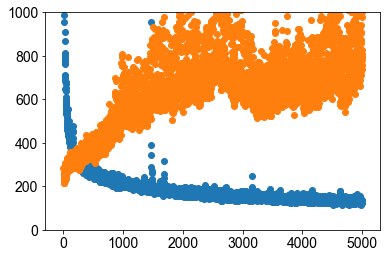

In [98]:
plt.scatter(list(range(5000)),self.logs['loss_train'][:5000])
plt.scatter(list(range(5000)),self.logs['loss_valid'][:5000])
plt.ylim(0,1000)

In [104]:
        xnorm = normalize(nmfX.fit_transform(X))#scalerX.fit_transform(X)
        ynorm = normalize(nmfY.fit_transform(X))#np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=30
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/9, Loss:   71.9989, rec_loss:   71.9958, KL_loss:    0.0032
Epoch 00/1000 Batch 0009/9, Loss:   39.7928, rec_loss:   39.7488, KL_loss:    0.0440
Epoch 01/1000 Batch 0000/9, Loss:   57.6025, rec_loss:   49.4917, KL_loss:    8.1108
Epoch 01/1000 Batch 0009/9, Loss:   53.7380, rec_loss:   53.6888, KL_loss:    0.0492
Epoch 02/1000 Batch 0000/9, Loss:   60.9088, rec_loss:   60.8641, KL_loss:    0.0447
Epoch 02/1000 Batch 0009/9, Loss:   43.5217, rec_loss:   43.4611, KL_loss:    0.0606
Epoch 03/1000 Batch 0000/9, Loss:   30.0590, rec_loss:   30.0025, KL_loss:    0.0565
Epoch 03/1000 Batch 0009/9, Loss:   89.3586, rec_loss:   89.2937, KL_loss:    0.0650
Epoch 04/1000 Batch 0000/9, Loss:   50.1347, rec_loss:   50.0707, KL_loss:    0.0640
Epoch 04/1000 Batch 0009/9, Loss:   30.6583, rec_loss:   30.5768, KL_loss:    0.0815
Epoch 05/1000 Batch 0000/9, Loss:   48.967

Epoch 49/1000 Batch 0009/9, Loss:   23.7012, rec_loss:   23.5655, KL_loss:    0.1357
Epoch 50/1000 Batch 0000/9, Loss:   15.9683, rec_loss:   15.8552, KL_loss:    0.1131
Epoch 50/1000 Batch 0009/9, Loss:   13.5525, rec_loss:   13.4321, KL_loss:    0.1204
Epoch 51/1000 Batch 0000/9, Loss:   20.2429, rec_loss:   20.1240, KL_loss:    0.1190
Epoch 51/1000 Batch 0009/9, Loss:   31.3639, rec_loss:   31.2475, KL_loss:    0.1164
Epoch 52/1000 Batch 0000/9, Loss:   29.4029, rec_loss:   29.2752, KL_loss:    0.1277
Epoch 52/1000 Batch 0009/9, Loss:   15.6124, rec_loss:   15.4857, KL_loss:    0.1267
Epoch 53/1000 Batch 0000/9, Loss:   20.9848, rec_loss:   20.8683, KL_loss:    0.1165
Epoch 53/1000 Batch 0009/9, Loss:   27.5667, rec_loss:   27.4411, KL_loss:    0.1256
Epoch 54/1000 Batch 0000/9, Loss:   15.2331, rec_loss:   15.1170, KL_loss:    0.1161
Epoch 54/1000 Batch 0009/9, Loss:   45.2249, rec_loss:   45.0966, KL_loss:    0.1283
Epoch 55/1000 Batch 0000/9, Loss:   26.1659, rec_loss:   26.0422,

Epoch 99/1000 Batch 0009/9, Loss:   32.7563, rec_loss:   32.6295, KL_loss:    0.1268
Epoch 100/1000 Batch 0000/9, Loss:   13.6695, rec_loss:   13.5539, KL_loss:    0.1156
Epoch 100/1000 Batch 0009/9, Loss:   25.3973, rec_loss:   25.2687, KL_loss:    0.1286
Epoch 101/1000 Batch 0000/9, Loss:   15.2610, rec_loss:   15.1265, KL_loss:    0.1345
Epoch 101/1000 Batch 0009/9, Loss:   22.1490, rec_loss:   22.0228, KL_loss:    0.1262
Epoch 102/1000 Batch 0000/9, Loss:   15.1690, rec_loss:   15.0424, KL_loss:    0.1265
Epoch 102/1000 Batch 0009/9, Loss:   29.2312, rec_loss:   29.0953, KL_loss:    0.1359
Epoch 103/1000 Batch 0000/9, Loss:    9.4929, rec_loss:    9.3617, KL_loss:    0.1313
Epoch 103/1000 Batch 0009/9, Loss:   14.3549, rec_loss:   14.2334, KL_loss:    0.1216
Epoch 104/1000 Batch 0000/9, Loss:   24.7350, rec_loss:   24.6126, KL_loss:    0.1224
Epoch 104/1000 Batch 0009/9, Loss:   27.0971, rec_loss:   26.9632, KL_loss:    0.1340
Epoch 105/1000 Batch 0000/9, Loss:   20.0719, rec_loss:

Epoch 147/1000 Batch 0009/9, Loss:   17.5665, rec_loss:   17.4400, KL_loss:    0.1265
Epoch 148/1000 Batch 0000/9, Loss:   22.1978, rec_loss:   22.0740, KL_loss:    0.1238
Epoch 148/1000 Batch 0009/9, Loss:   35.2070, rec_loss:   35.0708, KL_loss:    0.1362
Epoch 149/1000 Batch 0000/9, Loss:   16.9366, rec_loss:   16.7986, KL_loss:    0.1380
Epoch 149/1000 Batch 0009/9, Loss:   19.5222, rec_loss:   19.3978, KL_loss:    0.1244
Epoch 150/1000 Batch 0000/9, Loss:   23.0440, rec_loss:   22.9176, KL_loss:    0.1264
Epoch 150/1000 Batch 0009/9, Loss:   20.2247, rec_loss:   20.1057, KL_loss:    0.1191
Epoch 151/1000 Batch 0000/9, Loss:   26.3234, rec_loss:   26.2016, KL_loss:    0.1218
Epoch 151/1000 Batch 0009/9, Loss:   22.4227, rec_loss:   22.3066, KL_loss:    0.1162
Epoch 152/1000 Batch 0000/9, Loss:   11.0960, rec_loss:   10.9773, KL_loss:    0.1188
Epoch 152/1000 Batch 0009/9, Loss:   17.4372, rec_loss:   17.3181, KL_loss:    0.1191
Epoch 153/1000 Batch 0000/9, Loss:   21.5186, rec_loss

Epoch 195/1000 Batch 0009/9, Loss:   14.9857, rec_loss:   14.8565, KL_loss:    0.1292
Epoch 196/1000 Batch 0000/9, Loss:   31.3939, rec_loss:   31.2675, KL_loss:    0.1264
Epoch 196/1000 Batch 0009/9, Loss:   11.4415, rec_loss:   11.3154, KL_loss:    0.1260
Epoch 197/1000 Batch 0000/9, Loss:   19.9252, rec_loss:   19.8120, KL_loss:    0.1132
Epoch 197/1000 Batch 0009/9, Loss:   13.8523, rec_loss:   13.7118, KL_loss:    0.1404
Epoch 198/1000 Batch 0000/9, Loss:   21.5497, rec_loss:   21.4148, KL_loss:    0.1349
Epoch 198/1000 Batch 0009/9, Loss:   20.6967, rec_loss:   20.5656, KL_loss:    0.1311
Epoch 199/1000 Batch 0000/9, Loss:   14.4129, rec_loss:   14.2824, KL_loss:    0.1306
Epoch 199/1000 Batch 0009/9, Loss:   13.9780, rec_loss:   13.8517, KL_loss:    0.1263
Epoch 200/1000 Batch 0000/9, Loss:   16.8269, rec_loss:   16.7017, KL_loss:    0.1251
Epoch 200/1000 Batch 0009/9, Loss:   20.1019, rec_loss:   19.9725, KL_loss:    0.1293
Epoch 201/1000 Batch 0000/9, Loss:   33.0585, rec_loss

Epoch 243/1000 Batch 0009/9, Loss:   23.5907, rec_loss:   23.4570, KL_loss:    0.1337
Epoch 244/1000 Batch 0000/9, Loss:   11.0427, rec_loss:   10.9196, KL_loss:    0.1231
Epoch 244/1000 Batch 0009/9, Loss:   20.1422, rec_loss:   20.0076, KL_loss:    0.1345
Epoch 245/1000 Batch 0000/9, Loss:   19.2853, rec_loss:   19.1469, KL_loss:    0.1384
Epoch 245/1000 Batch 0009/9, Loss:    9.7767, rec_loss:    9.6378, KL_loss:    0.1388
Epoch 246/1000 Batch 0000/9, Loss:   14.1179, rec_loss:   13.9842, KL_loss:    0.1337
Epoch 246/1000 Batch 0009/9, Loss:   14.8017, rec_loss:   14.6587, KL_loss:    0.1430
Epoch 247/1000 Batch 0000/9, Loss:   29.9726, rec_loss:   29.8350, KL_loss:    0.1376
Epoch 247/1000 Batch 0009/9, Loss:   15.3146, rec_loss:   15.1805, KL_loss:    0.1342
Epoch 248/1000 Batch 0000/9, Loss:   24.6107, rec_loss:   24.4884, KL_loss:    0.1223
Epoch 248/1000 Batch 0009/9, Loss:   25.2897, rec_loss:   25.1579, KL_loss:    0.1319
Epoch 249/1000 Batch 0000/9, Loss:   26.8479, rec_loss

Epoch 291/1000 Batch 0009/9, Loss:   22.3788, rec_loss:   22.2459, KL_loss:    0.1329
Epoch 292/1000 Batch 0000/9, Loss:   16.9026, rec_loss:   16.7739, KL_loss:    0.1286
Epoch 292/1000 Batch 0009/9, Loss:   16.3453, rec_loss:   16.2085, KL_loss:    0.1368
Epoch 293/1000 Batch 0000/9, Loss:   11.1865, rec_loss:   11.0465, KL_loss:    0.1400
Epoch 293/1000 Batch 0009/9, Loss:   15.3836, rec_loss:   15.2504, KL_loss:    0.1332
Epoch 294/1000 Batch 0000/9, Loss:   13.5731, rec_loss:   13.4472, KL_loss:    0.1260
Epoch 294/1000 Batch 0009/9, Loss:   36.1783, rec_loss:   36.0490, KL_loss:    0.1293
Epoch 295/1000 Batch 0000/9, Loss:   19.1320, rec_loss:   18.9946, KL_loss:    0.1374
Epoch 295/1000 Batch 0009/9, Loss:   22.2669, rec_loss:   22.1301, KL_loss:    0.1368
Epoch 296/1000 Batch 0000/9, Loss:   24.1287, rec_loss:   23.9975, KL_loss:    0.1312
Epoch 296/1000 Batch 0009/9, Loss:    9.8194, rec_loss:    9.6829, KL_loss:    0.1364
Epoch 297/1000 Batch 0000/9, Loss:   25.6453, rec_loss

Epoch 339/1000 Batch 0009/9, Loss:   14.9570, rec_loss:   14.8316, KL_loss:    0.1254
Epoch 340/1000 Batch 0000/9, Loss:   29.2215, rec_loss:   29.0929, KL_loss:    0.1285
Epoch 340/1000 Batch 0009/9, Loss:   22.8757, rec_loss:   22.7385, KL_loss:    0.1372
Epoch 341/1000 Batch 0000/9, Loss:   24.9326, rec_loss:   24.7872, KL_loss:    0.1454
Epoch 341/1000 Batch 0009/9, Loss:   24.5039, rec_loss:   24.3767, KL_loss:    0.1272
Epoch 342/1000 Batch 0000/9, Loss:   12.1110, rec_loss:   11.9817, KL_loss:    0.1294
Epoch 342/1000 Batch 0009/9, Loss:   23.5855, rec_loss:   23.4639, KL_loss:    0.1216
Epoch 343/1000 Batch 0000/9, Loss:   17.7301, rec_loss:   17.5986, KL_loss:    0.1315
Epoch 343/1000 Batch 0009/9, Loss:   10.0784, rec_loss:    9.9336, KL_loss:    0.1448
Epoch 344/1000 Batch 0000/9, Loss:    7.5354, rec_loss:    7.4132, KL_loss:    0.1222
Epoch 344/1000 Batch 0009/9, Loss:   20.5331, rec_loss:   20.4030, KL_loss:    0.1300
Epoch 345/1000 Batch 0000/9, Loss:   20.7050, rec_loss

Epoch 387/1000 Batch 0009/9, Loss:   34.7767, rec_loss:   34.6336, KL_loss:    0.1431
Epoch 388/1000 Batch 0000/9, Loss:    6.1330, rec_loss:    5.9994, KL_loss:    0.1336
Epoch 388/1000 Batch 0009/9, Loss:   31.7937, rec_loss:   31.6678, KL_loss:    0.1258
Epoch 389/1000 Batch 0000/9, Loss:   16.3303, rec_loss:   16.1946, KL_loss:    0.1357
Epoch 389/1000 Batch 0009/9, Loss:   20.3259, rec_loss:   20.1946, KL_loss:    0.1312
Epoch 390/1000 Batch 0000/9, Loss:   17.0720, rec_loss:   16.9428, KL_loss:    0.1292
Epoch 390/1000 Batch 0009/9, Loss:   18.4527, rec_loss:   18.2962, KL_loss:    0.1566
Epoch 391/1000 Batch 0000/9, Loss:   14.5786, rec_loss:   14.4475, KL_loss:    0.1311
Epoch 391/1000 Batch 0009/9, Loss:   14.4312, rec_loss:   14.2988, KL_loss:    0.1323
Epoch 392/1000 Batch 0000/9, Loss:   26.7947, rec_loss:   26.6415, KL_loss:    0.1532
Epoch 392/1000 Batch 0009/9, Loss:   14.5575, rec_loss:   14.4395, KL_loss:    0.1180
Epoch 393/1000 Batch 0000/9, Loss:   25.0667, rec_loss

Epoch 435/1000 Batch 0009/9, Loss:   26.2154, rec_loss:   26.0820, KL_loss:    0.1334
Epoch 436/1000 Batch 0000/9, Loss:   10.7352, rec_loss:   10.5907, KL_loss:    0.1445
Epoch 436/1000 Batch 0009/9, Loss:   20.4029, rec_loss:   20.2624, KL_loss:    0.1406
Epoch 437/1000 Batch 0000/9, Loss:   20.0783, rec_loss:   19.9417, KL_loss:    0.1366
Epoch 437/1000 Batch 0009/9, Loss:   32.9562, rec_loss:   32.8195, KL_loss:    0.1367
Epoch 438/1000 Batch 0000/9, Loss:   20.4150, rec_loss:   20.2788, KL_loss:    0.1362
Epoch 438/1000 Batch 0009/9, Loss:   12.6403, rec_loss:   12.5065, KL_loss:    0.1338
Epoch 439/1000 Batch 0000/9, Loss:   15.0862, rec_loss:   14.9471, KL_loss:    0.1390
Epoch 439/1000 Batch 0009/9, Loss:   21.8047, rec_loss:   21.6482, KL_loss:    0.1566
Epoch 440/1000 Batch 0000/9, Loss:    8.7628, rec_loss:    8.6256, KL_loss:    0.1372
Epoch 440/1000 Batch 0009/9, Loss:   10.6164, rec_loss:   10.4740, KL_loss:    0.1424
Epoch 441/1000 Batch 0000/9, Loss:    6.0522, rec_loss

Epoch 483/1000 Batch 0009/9, Loss:   19.3712, rec_loss:   19.2310, KL_loss:    0.1403
Epoch 484/1000 Batch 0000/9, Loss:   21.3407, rec_loss:   21.1802, KL_loss:    0.1606
Epoch 484/1000 Batch 0009/9, Loss:   28.3459, rec_loss:   28.2062, KL_loss:    0.1397
Epoch 485/1000 Batch 0000/9, Loss:    7.8679, rec_loss:    7.7380, KL_loss:    0.1300
Epoch 485/1000 Batch 0009/9, Loss:   14.6924, rec_loss:   14.5419, KL_loss:    0.1504
Epoch 486/1000 Batch 0000/9, Loss:   14.6726, rec_loss:   14.5443, KL_loss:    0.1283
Epoch 486/1000 Batch 0009/9, Loss:   10.5600, rec_loss:   10.4218, KL_loss:    0.1382
Epoch 487/1000 Batch 0000/9, Loss:    7.6341, rec_loss:    7.5034, KL_loss:    0.1307
Epoch 487/1000 Batch 0009/9, Loss:    7.2619, rec_loss:    7.1203, KL_loss:    0.1415
Epoch 488/1000 Batch 0000/9, Loss:   14.2887, rec_loss:   14.1487, KL_loss:    0.1400
Epoch 488/1000 Batch 0009/9, Loss:   37.6877, rec_loss:   37.5521, KL_loss:    0.1355
Epoch 489/1000 Batch 0000/9, Loss:   14.2638, rec_loss

Epoch 531/1000 Batch 0009/9, Loss:   14.0623, rec_loss:   13.9065, KL_loss:    0.1558
Epoch 532/1000 Batch 0000/9, Loss:   12.4629, rec_loss:   12.3227, KL_loss:    0.1402
Epoch 532/1000 Batch 0009/9, Loss:   12.5633, rec_loss:   12.4053, KL_loss:    0.1581
Epoch 533/1000 Batch 0000/9, Loss:   29.4416, rec_loss:   29.3020, KL_loss:    0.1396
Epoch 533/1000 Batch 0009/9, Loss:   10.1802, rec_loss:   10.0133, KL_loss:    0.1669
Epoch 534/1000 Batch 0000/9, Loss:   15.8678, rec_loss:   15.7115, KL_loss:    0.1563
Epoch 534/1000 Batch 0009/9, Loss:   16.9663, rec_loss:   16.8019, KL_loss:    0.1644
Epoch 535/1000 Batch 0000/9, Loss:   20.8720, rec_loss:   20.7164, KL_loss:    0.1556
Epoch 535/1000 Batch 0009/9, Loss:   28.0979, rec_loss:   27.9480, KL_loss:    0.1499
Epoch 536/1000 Batch 0000/9, Loss:   14.7915, rec_loss:   14.6261, KL_loss:    0.1654
Epoch 536/1000 Batch 0009/9, Loss:   23.8858, rec_loss:   23.7283, KL_loss:    0.1575
Epoch 537/1000 Batch 0000/9, Loss:   19.3518, rec_loss

Epoch 579/1000 Batch 0009/9, Loss:   19.6289, rec_loss:   19.4893, KL_loss:    0.1397
Epoch 580/1000 Batch 0000/9, Loss:   12.2830, rec_loss:   12.1287, KL_loss:    0.1543
Epoch 580/1000 Batch 0009/9, Loss:   20.3151, rec_loss:   20.1778, KL_loss:    0.1373
Epoch 581/1000 Batch 0000/9, Loss:   13.2997, rec_loss:   13.1693, KL_loss:    0.1304
Epoch 581/1000 Batch 0009/9, Loss:   18.8326, rec_loss:   18.6888, KL_loss:    0.1438
Epoch 582/1000 Batch 0000/9, Loss:    9.7796, rec_loss:    9.6025, KL_loss:    0.1770
Epoch 582/1000 Batch 0009/9, Loss:    9.9621, rec_loss:    9.8280, KL_loss:    0.1340
Epoch 583/1000 Batch 0000/9, Loss:   16.6325, rec_loss:   16.4927, KL_loss:    0.1398
Epoch 583/1000 Batch 0009/9, Loss:   16.3943, rec_loss:   16.2511, KL_loss:    0.1432
Epoch 584/1000 Batch 0000/9, Loss:   18.9467, rec_loss:   18.8141, KL_loss:    0.1326
Epoch 584/1000 Batch 0009/9, Loss:   15.3827, rec_loss:   15.2099, KL_loss:    0.1728
Epoch 585/1000 Batch 0000/9, Loss:   14.5624, rec_loss

Epoch 627/1000 Batch 0009/9, Loss:   12.3343, rec_loss:   12.2065, KL_loss:    0.1278
Epoch 628/1000 Batch 0000/9, Loss:   12.3364, rec_loss:   12.2022, KL_loss:    0.1342
Epoch 628/1000 Batch 0009/9, Loss:    8.9986, rec_loss:    8.8564, KL_loss:    0.1423
Epoch 629/1000 Batch 0000/9, Loss:   17.8062, rec_loss:   17.6728, KL_loss:    0.1334
Epoch 629/1000 Batch 0009/9, Loss:   13.8007, rec_loss:   13.6498, KL_loss:    0.1510
Epoch 630/1000 Batch 0000/9, Loss:    7.9916, rec_loss:    7.8472, KL_loss:    0.1444
Epoch 630/1000 Batch 0009/9, Loss:   13.6305, rec_loss:   13.4939, KL_loss:    0.1367
Epoch 631/1000 Batch 0000/9, Loss:   15.4572, rec_loss:   15.3051, KL_loss:    0.1520
Epoch 631/1000 Batch 0009/9, Loss:    9.1577, rec_loss:    9.0170, KL_loss:    0.1407
Epoch 632/1000 Batch 0000/9, Loss:   20.9725, rec_loss:   20.8379, KL_loss:    0.1346
Epoch 632/1000 Batch 0009/9, Loss:   19.2827, rec_loss:   19.1487, KL_loss:    0.1340
Epoch 633/1000 Batch 0000/9, Loss:   21.0077, rec_loss

Epoch 675/1000 Batch 0009/9, Loss:   10.2317, rec_loss:   10.0913, KL_loss:    0.1404
Epoch 676/1000 Batch 0000/9, Loss:   20.7758, rec_loss:   20.6355, KL_loss:    0.1403
Epoch 676/1000 Batch 0009/9, Loss:    9.9866, rec_loss:    9.8426, KL_loss:    0.1440
Epoch 677/1000 Batch 0000/9, Loss:   14.4869, rec_loss:   14.3471, KL_loss:    0.1398
Epoch 677/1000 Batch 0009/9, Loss:   11.2560, rec_loss:   11.1155, KL_loss:    0.1406
Epoch 678/1000 Batch 0000/9, Loss:    9.6663, rec_loss:    9.5107, KL_loss:    0.1555
Epoch 678/1000 Batch 0009/9, Loss:   19.0995, rec_loss:   18.9597, KL_loss:    0.1398
Epoch 679/1000 Batch 0000/9, Loss:   32.0262, rec_loss:   31.8804, KL_loss:    0.1458
Epoch 679/1000 Batch 0009/9, Loss:   17.2232, rec_loss:   17.0713, KL_loss:    0.1520
Epoch 680/1000 Batch 0000/9, Loss:   16.7226, rec_loss:   16.5763, KL_loss:    0.1464
Epoch 680/1000 Batch 0009/9, Loss:   24.2316, rec_loss:   24.0876, KL_loss:    0.1440
Epoch 681/1000 Batch 0000/9, Loss:   17.2408, rec_loss

Epoch 723/1000 Batch 0009/9, Loss:   12.3424, rec_loss:   12.1706, KL_loss:    0.1718
Epoch 724/1000 Batch 0000/9, Loss:   12.4496, rec_loss:   12.2882, KL_loss:    0.1614
Epoch 724/1000 Batch 0009/9, Loss:   14.3777, rec_loss:   14.2325, KL_loss:    0.1452
Epoch 725/1000 Batch 0000/9, Loss:   16.3836, rec_loss:   16.2336, KL_loss:    0.1500
Epoch 725/1000 Batch 0009/9, Loss:   20.8105, rec_loss:   20.6649, KL_loss:    0.1457
Epoch 726/1000 Batch 0000/9, Loss:   18.9045, rec_loss:   18.7577, KL_loss:    0.1468
Epoch 726/1000 Batch 0009/9, Loss:   30.2421, rec_loss:   30.1008, KL_loss:    0.1412
Epoch 727/1000 Batch 0000/9, Loss:   10.0217, rec_loss:    9.8810, KL_loss:    0.1407
Epoch 727/1000 Batch 0009/9, Loss:   21.7799, rec_loss:   21.6330, KL_loss:    0.1468
Epoch 728/1000 Batch 0000/9, Loss:   10.5324, rec_loss:   10.3854, KL_loss:    0.1469
Epoch 728/1000 Batch 0009/9, Loss:   10.0088, rec_loss:    9.8662, KL_loss:    0.1426
Epoch 729/1000 Batch 0000/9, Loss:   15.7727, rec_loss

Epoch 771/1000 Batch 0009/9, Loss:   22.5335, rec_loss:   22.3762, KL_loss:    0.1572
Epoch 772/1000 Batch 0000/9, Loss:   12.2055, rec_loss:   12.0376, KL_loss:    0.1679
Epoch 772/1000 Batch 0009/9, Loss:   22.3306, rec_loss:   22.1762, KL_loss:    0.1544
Epoch 773/1000 Batch 0000/9, Loss:   23.9543, rec_loss:   23.8002, KL_loss:    0.1541
Epoch 773/1000 Batch 0009/9, Loss:   17.0554, rec_loss:   16.9130, KL_loss:    0.1424
Epoch 774/1000 Batch 0000/9, Loss:   21.2234, rec_loss:   21.0659, KL_loss:    0.1575
Epoch 774/1000 Batch 0009/9, Loss:    7.6713, rec_loss:    7.5237, KL_loss:    0.1476
Epoch 775/1000 Batch 0000/9, Loss:   14.8719, rec_loss:   14.7315, KL_loss:    0.1404
Epoch 775/1000 Batch 0009/9, Loss:   26.4277, rec_loss:   26.2699, KL_loss:    0.1578
Epoch 776/1000 Batch 0000/9, Loss:   20.3446, rec_loss:   20.1967, KL_loss:    0.1478
Epoch 776/1000 Batch 0009/9, Loss:   19.3186, rec_loss:   19.1700, KL_loss:    0.1486
Epoch 777/1000 Batch 0000/9, Loss:   18.3020, rec_loss

Epoch 819/1000 Batch 0009/9, Loss:   11.1976, rec_loss:   11.0673, KL_loss:    0.1303
Epoch 820/1000 Batch 0000/9, Loss:   16.2836, rec_loss:   16.1411, KL_loss:    0.1426
Epoch 820/1000 Batch 0009/9, Loss:   18.3416, rec_loss:   18.1884, KL_loss:    0.1532
Epoch 821/1000 Batch 0000/9, Loss:   17.1616, rec_loss:   17.0240, KL_loss:    0.1376
Epoch 821/1000 Batch 0009/9, Loss:   18.6696, rec_loss:   18.5248, KL_loss:    0.1448
Epoch 822/1000 Batch 0000/9, Loss:   12.5685, rec_loss:   12.4249, KL_loss:    0.1436
Epoch 822/1000 Batch 0009/9, Loss:   13.4106, rec_loss:   13.2596, KL_loss:    0.1510
Epoch 823/1000 Batch 0000/9, Loss:   15.2569, rec_loss:   15.1099, KL_loss:    0.1470
Epoch 823/1000 Batch 0009/9, Loss:   15.7528, rec_loss:   15.5852, KL_loss:    0.1675
Epoch 824/1000 Batch 0000/9, Loss:   18.5200, rec_loss:   18.3818, KL_loss:    0.1382
Epoch 824/1000 Batch 0009/9, Loss:   27.1811, rec_loss:   27.0198, KL_loss:    0.1613
Epoch 825/1000 Batch 0000/9, Loss:   19.0294, rec_loss

Epoch 868/1000 Batch 0009/9, Loss:    8.8686, rec_loss:    8.7072, KL_loss:    0.1613
Epoch 869/1000 Batch 0000/9, Loss:   23.7624, rec_loss:   23.6006, KL_loss:    0.1618
Epoch 869/1000 Batch 0009/9, Loss:    6.2911, rec_loss:    6.1386, KL_loss:    0.1525
Epoch 870/1000 Batch 0000/9, Loss:    9.6206, rec_loss:    9.4763, KL_loss:    0.1443
Epoch 870/1000 Batch 0009/9, Loss:   14.0081, rec_loss:   13.8756, KL_loss:    0.1325
Epoch 871/1000 Batch 0000/9, Loss:   12.1315, rec_loss:   11.9941, KL_loss:    0.1375
Epoch 871/1000 Batch 0009/9, Loss:   18.8571, rec_loss:   18.7210, KL_loss:    0.1362
Epoch 872/1000 Batch 0000/9, Loss:   22.1236, rec_loss:   21.9812, KL_loss:    0.1424
Epoch 872/1000 Batch 0009/9, Loss:    6.4589, rec_loss:    6.3110, KL_loss:    0.1479
Epoch 873/1000 Batch 0000/9, Loss:    7.2811, rec_loss:    7.1260, KL_loss:    0.1551
Epoch 873/1000 Batch 0009/9, Loss:    9.5476, rec_loss:    9.3818, KL_loss:    0.1658
Epoch 874/1000 Batch 0000/9, Loss:   13.9240, rec_loss

Epoch 916/1000 Batch 0009/9, Loss:   14.1027, rec_loss:   13.9572, KL_loss:    0.1455
Epoch 917/1000 Batch 0000/9, Loss:   16.9156, rec_loss:   16.7567, KL_loss:    0.1589
Epoch 917/1000 Batch 0009/9, Loss:   18.6758, rec_loss:   18.5363, KL_loss:    0.1395
Epoch 918/1000 Batch 0000/9, Loss:   11.2624, rec_loss:   11.1191, KL_loss:    0.1433
Epoch 918/1000 Batch 0009/9, Loss:   15.1551, rec_loss:   14.9997, KL_loss:    0.1555
Epoch 919/1000 Batch 0000/9, Loss:   31.8790, rec_loss:   31.7437, KL_loss:    0.1353
Epoch 919/1000 Batch 0009/9, Loss:   15.6077, rec_loss:   15.4810, KL_loss:    0.1267
Epoch 920/1000 Batch 0000/9, Loss:   11.6641, rec_loss:   11.5165, KL_loss:    0.1475
Epoch 920/1000 Batch 0009/9, Loss:   10.3354, rec_loss:   10.1896, KL_loss:    0.1458
Epoch 921/1000 Batch 0000/9, Loss:   10.9232, rec_loss:   10.7668, KL_loss:    0.1563
Epoch 921/1000 Batch 0009/9, Loss:   18.4049, rec_loss:   18.2383, KL_loss:    0.1666
Epoch 922/1000 Batch 0000/9, Loss:   17.9311, rec_loss

Epoch 965/1000 Batch 0009/9, Loss:   10.8911, rec_loss:   10.7390, KL_loss:    0.1521
Epoch 966/1000 Batch 0000/9, Loss:   27.6119, rec_loss:   27.4535, KL_loss:    0.1584
Epoch 966/1000 Batch 0009/9, Loss:   31.4599, rec_loss:   31.3208, KL_loss:    0.1392
Epoch 967/1000 Batch 0000/9, Loss:   14.5414, rec_loss:   14.3842, KL_loss:    0.1572
Epoch 967/1000 Batch 0009/9, Loss:    9.5763, rec_loss:    9.4239, KL_loss:    0.1525
Epoch 968/1000 Batch 0000/9, Loss:   10.1318, rec_loss:    9.9901, KL_loss:    0.1417
Epoch 968/1000 Batch 0009/9, Loss:   21.9568, rec_loss:   21.7868, KL_loss:    0.1699
Epoch 969/1000 Batch 0000/9, Loss:   18.9289, rec_loss:   18.7730, KL_loss:    0.1559
Epoch 969/1000 Batch 0009/9, Loss:   20.1643, rec_loss:   20.0194, KL_loss:    0.1450
Epoch 970/1000 Batch 0000/9, Loss:   14.3425, rec_loss:   14.1935, KL_loss:    0.1490
Epoch 970/1000 Batch 0009/9, Loss:   22.5420, rec_loss:   22.3984, KL_loss:    0.1436
Epoch 971/1000 Batch 0000/9, Loss:    9.2493, rec_loss

(0, 100)

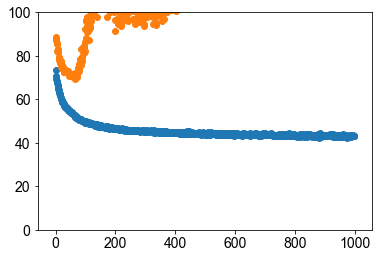

In [109]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [107]:
        xnorm = scalerX.fit_transform(X)
        ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=20
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/14, Loss:   74.2203, rec_loss:   74.2174, KL_loss:    0.0030
Epoch 00/1000 Batch 0014/14, Loss:   66.4953, rec_loss:   66.4924, KL_loss:    0.0029
Epoch 01/1000 Batch 0000/14, Loss:   57.3964, rec_loss:   57.3937, KL_loss:    0.0026
Epoch 01/1000 Batch 0014/14, Loss:   57.0316, rec_loss:   57.0289, KL_loss:    0.0027
Epoch 02/1000 Batch 0000/14, Loss:   61.7871, rec_loss:   61.7842, KL_loss:    0.0030
Epoch 02/1000 Batch 0014/14, Loss:   64.7460, rec_loss:   64.7429, KL_loss:    0.0031
Epoch 03/1000 Batch 0000/14, Loss:   71.1961, rec_loss:   71.1929, KL_loss:    0.0031
Epoch 03/1000 Batch 0014/14, Loss:   53.5910, rec_loss:   53.5880, KL_loss:    0.0030
Epoch 04/1000 Batch 0000/14, Loss:   67.0900, rec_loss:   67.0858, KL_loss:    0.0042
Epoch 04/1000 Batch 0014/14, Loss:   68.4472, rec_loss:   68.4437, KL_loss:    0.0034
Epoch 05/1000 Batch 0000/14, Loss

Epoch 47/1000 Batch 0014/14, Loss:   46.4719, rec_loss:   46.4374, KL_loss:    0.0345
Epoch 48/1000 Batch 0000/14, Loss:   73.1308, rec_loss:   73.0932, KL_loss:    0.0375
Epoch 48/1000 Batch 0014/14, Loss:   62.8717, rec_loss:   62.8411, KL_loss:    0.0305
Epoch 49/1000 Batch 0000/14, Loss:   36.6548, rec_loss:   36.6200, KL_loss:    0.0348
Epoch 49/1000 Batch 0014/14, Loss:   43.4267, rec_loss:   43.3952, KL_loss:    0.0315
Epoch 50/1000 Batch 0000/14, Loss:   46.0393, rec_loss:   46.0068, KL_loss:    0.0324
Epoch 50/1000 Batch 0014/14, Loss:   39.6236, rec_loss:   39.5898, KL_loss:    0.0338
Epoch 51/1000 Batch 0000/14, Loss:   33.6600, rec_loss:   33.6243, KL_loss:    0.0357
Epoch 51/1000 Batch 0014/14, Loss:   46.4012, rec_loss:   46.3660, KL_loss:    0.0352
Epoch 52/1000 Batch 0000/14, Loss:   49.3025, rec_loss:   49.2740, KL_loss:    0.0285
Epoch 52/1000 Batch 0014/14, Loss:   56.9720, rec_loss:   56.9372, KL_loss:    0.0348
Epoch 53/1000 Batch 0000/14, Loss:   49.4269, rec_loss

Epoch 96/1000 Batch 0014/14, Loss:   45.3230, rec_loss:   45.2687, KL_loss:    0.0543
Epoch 97/1000 Batch 0000/14, Loss:   54.0358, rec_loss:   53.9828, KL_loss:    0.0530
Epoch 97/1000 Batch 0014/14, Loss:   27.8255, rec_loss:   27.7649, KL_loss:    0.0605
Epoch 98/1000 Batch 0000/14, Loss:   26.6395, rec_loss:   26.5788, KL_loss:    0.0607
Epoch 98/1000 Batch 0014/14, Loss:   42.3678, rec_loss:   42.3096, KL_loss:    0.0582
Epoch 99/1000 Batch 0000/14, Loss:   33.8253, rec_loss:   33.7627, KL_loss:    0.0626
Epoch 99/1000 Batch 0014/14, Loss:   53.1860, rec_loss:   53.1254, KL_loss:    0.0606
Epoch 100/1000 Batch 0000/14, Loss:   51.6483, rec_loss:   51.5890, KL_loss:    0.0592
Epoch 100/1000 Batch 0014/14, Loss:   42.2182, rec_loss:   42.1603, KL_loss:    0.0579
Epoch 101/1000 Batch 0000/14, Loss:   53.5737, rec_loss:   53.5172, KL_loss:    0.0565
Epoch 101/1000 Batch 0014/14, Loss:   41.7904, rec_loss:   41.7287, KL_loss:    0.0617
Epoch 102/1000 Batch 0000/14, Loss:   52.7267, rec

Epoch 144/1000 Batch 0014/14, Loss:   42.2813, rec_loss:   42.2114, KL_loss:    0.0699
Epoch 145/1000 Batch 0000/14, Loss:   37.7646, rec_loss:   37.7000, KL_loss:    0.0647
Epoch 145/1000 Batch 0014/14, Loss:   52.2174, rec_loss:   52.1527, KL_loss:    0.0648
Epoch 146/1000 Batch 0000/14, Loss:   40.1328, rec_loss:   40.0625, KL_loss:    0.0704
Epoch 146/1000 Batch 0014/14, Loss:   46.6331, rec_loss:   46.5669, KL_loss:    0.0662
Epoch 147/1000 Batch 0000/14, Loss:   47.0048, rec_loss:   46.9347, KL_loss:    0.0701
Epoch 147/1000 Batch 0014/14, Loss:   40.8634, rec_loss:   40.7939, KL_loss:    0.0695
Epoch 148/1000 Batch 0000/14, Loss:   45.3408, rec_loss:   45.2724, KL_loss:    0.0683
Epoch 148/1000 Batch 0014/14, Loss:   41.3267, rec_loss:   41.2579, KL_loss:    0.0688
Epoch 149/1000 Batch 0000/14, Loss:   54.0649, rec_loss:   53.9960, KL_loss:    0.0689
Epoch 149/1000 Batch 0014/14, Loss:   50.7343, rec_loss:   50.6670, KL_loss:    0.0673
Epoch 150/1000 Batch 0000/14, Loss:   57.89

Epoch 192/1000 Batch 0014/14, Loss:   40.3485, rec_loss:   40.2767, KL_loss:    0.0718
Epoch 193/1000 Batch 0000/14, Loss:   34.0046, rec_loss:   33.9285, KL_loss:    0.0761
Epoch 193/1000 Batch 0014/14, Loss:   37.3499, rec_loss:   37.2727, KL_loss:    0.0772
Epoch 194/1000 Batch 0000/14, Loss:   38.8944, rec_loss:   38.8184, KL_loss:    0.0760
Epoch 194/1000 Batch 0014/14, Loss:   46.7715, rec_loss:   46.6993, KL_loss:    0.0722
Epoch 195/1000 Batch 0000/14, Loss:   48.5946, rec_loss:   48.5199, KL_loss:    0.0748
Epoch 195/1000 Batch 0014/14, Loss:   35.1429, rec_loss:   35.0685, KL_loss:    0.0744
Epoch 196/1000 Batch 0000/14, Loss:   46.8864, rec_loss:   46.8137, KL_loss:    0.0727
Epoch 196/1000 Batch 0014/14, Loss:   46.4778, rec_loss:   46.4028, KL_loss:    0.0750
Epoch 197/1000 Batch 0000/14, Loss:   50.5804, rec_loss:   50.5103, KL_loss:    0.0701
Epoch 197/1000 Batch 0014/14, Loss:   50.4822, rec_loss:   50.4116, KL_loss:    0.0707
Epoch 198/1000 Batch 0000/14, Loss:   44.76

Epoch 240/1000 Batch 0014/14, Loss:   46.9426, rec_loss:   46.8677, KL_loss:    0.0749
Epoch 241/1000 Batch 0000/14, Loss:   35.4836, rec_loss:   35.4053, KL_loss:    0.0783
Epoch 241/1000 Batch 0014/14, Loss:   47.3048, rec_loss:   47.2285, KL_loss:    0.0763
Epoch 242/1000 Batch 0000/14, Loss:   36.6469, rec_loss:   36.5716, KL_loss:    0.0754
Epoch 242/1000 Batch 0014/14, Loss:   37.8586, rec_loss:   37.7822, KL_loss:    0.0763
Epoch 243/1000 Batch 0000/14, Loss:   46.7864, rec_loss:   46.7122, KL_loss:    0.0742
Epoch 243/1000 Batch 0014/14, Loss:   48.0209, rec_loss:   47.9423, KL_loss:    0.0785
Epoch 244/1000 Batch 0000/14, Loss:   43.8267, rec_loss:   43.7487, KL_loss:    0.0780
Epoch 244/1000 Batch 0014/14, Loss:   52.0705, rec_loss:   51.9966, KL_loss:    0.0739
Epoch 245/1000 Batch 0000/14, Loss:   47.9277, rec_loss:   47.8473, KL_loss:    0.0804
Epoch 245/1000 Batch 0014/14, Loss:   48.1597, rec_loss:   48.0824, KL_loss:    0.0773
Epoch 246/1000 Batch 0000/14, Loss:   31.88

Epoch 288/1000 Batch 0014/14, Loss:   41.9361, rec_loss:   41.8531, KL_loss:    0.0831
Epoch 289/1000 Batch 0000/14, Loss:   40.1625, rec_loss:   40.0838, KL_loss:    0.0788
Epoch 289/1000 Batch 0014/14, Loss:   36.1891, rec_loss:   36.1039, KL_loss:    0.0852
Epoch 290/1000 Batch 0000/14, Loss:   45.9875, rec_loss:   45.9090, KL_loss:    0.0786
Epoch 290/1000 Batch 0014/14, Loss:   61.2639, rec_loss:   61.1867, KL_loss:    0.0772
Epoch 291/1000 Batch 0000/14, Loss:   37.2989, rec_loss:   37.2149, KL_loss:    0.0840
Epoch 291/1000 Batch 0014/14, Loss:   39.3914, rec_loss:   39.3056, KL_loss:    0.0858
Epoch 292/1000 Batch 0000/14, Loss:   42.8500, rec_loss:   42.7690, KL_loss:    0.0810
Epoch 292/1000 Batch 0014/14, Loss:   41.4060, rec_loss:   41.3254, KL_loss:    0.0806
Epoch 293/1000 Batch 0000/14, Loss:   46.6340, rec_loss:   46.5474, KL_loss:    0.0866
Epoch 293/1000 Batch 0014/14, Loss:   56.1661, rec_loss:   56.0877, KL_loss:    0.0784
Epoch 294/1000 Batch 0000/14, Loss:   33.45

Epoch 336/1000 Batch 0014/14, Loss:   34.1325, rec_loss:   34.0475, KL_loss:    0.0851
Epoch 337/1000 Batch 0000/14, Loss:   34.1897, rec_loss:   34.1020, KL_loss:    0.0877
Epoch 337/1000 Batch 0014/14, Loss:   38.1395, rec_loss:   38.0575, KL_loss:    0.0820
Epoch 338/1000 Batch 0000/14, Loss:   37.7971, rec_loss:   37.7116, KL_loss:    0.0855
Epoch 338/1000 Batch 0014/14, Loss:   43.4417, rec_loss:   43.3523, KL_loss:    0.0894
Epoch 339/1000 Batch 0000/14, Loss:   39.4875, rec_loss:   39.4030, KL_loss:    0.0845
Epoch 339/1000 Batch 0014/14, Loss:   47.1531, rec_loss:   47.0662, KL_loss:    0.0869
Epoch 340/1000 Batch 0000/14, Loss:   23.5957, rec_loss:   23.5111, KL_loss:    0.0845
Epoch 340/1000 Batch 0014/14, Loss:   28.3762, rec_loss:   28.2923, KL_loss:    0.0839
Epoch 341/1000 Batch 0000/14, Loss:   40.0313, rec_loss:   39.9412, KL_loss:    0.0901
Epoch 341/1000 Batch 0014/14, Loss:   57.0872, rec_loss:   57.0031, KL_loss:    0.0841
Epoch 342/1000 Batch 0000/14, Loss:   39.78

Epoch 384/1000 Batch 0014/14, Loss:   44.9529, rec_loss:   44.8703, KL_loss:    0.0826
Epoch 385/1000 Batch 0000/14, Loss:   31.3814, rec_loss:   31.2962, KL_loss:    0.0853
Epoch 385/1000 Batch 0014/14, Loss:   38.2047, rec_loss:   38.1205, KL_loss:    0.0842
Epoch 386/1000 Batch 0000/14, Loss:   36.4582, rec_loss:   36.3681, KL_loss:    0.0901
Epoch 386/1000 Batch 0014/14, Loss:   35.6084, rec_loss:   35.5197, KL_loss:    0.0887
Epoch 387/1000 Batch 0000/14, Loss:   29.8412, rec_loss:   29.7574, KL_loss:    0.0838
Epoch 387/1000 Batch 0014/14, Loss:   34.0145, rec_loss:   33.9291, KL_loss:    0.0855
Epoch 388/1000 Batch 0000/14, Loss:   34.3373, rec_loss:   34.2518, KL_loss:    0.0855
Epoch 388/1000 Batch 0014/14, Loss:   39.6403, rec_loss:   39.5564, KL_loss:    0.0839
Epoch 389/1000 Batch 0000/14, Loss:   34.7967, rec_loss:   34.7092, KL_loss:    0.0875
Epoch 389/1000 Batch 0014/14, Loss:   33.4506, rec_loss:   33.3627, KL_loss:    0.0878
Epoch 390/1000 Batch 0000/14, Loss:   29.66

Epoch 432/1000 Batch 0014/14, Loss:   42.5430, rec_loss:   42.4567, KL_loss:    0.0863
Epoch 433/1000 Batch 0000/14, Loss:   45.0017, rec_loss:   44.9184, KL_loss:    0.0833
Epoch 433/1000 Batch 0014/14, Loss:   27.5769, rec_loss:   27.4844, KL_loss:    0.0925
Epoch 434/1000 Batch 0000/14, Loss:   45.3730, rec_loss:   45.2891, KL_loss:    0.0839
Epoch 434/1000 Batch 0014/14, Loss:   34.9257, rec_loss:   34.8378, KL_loss:    0.0879
Epoch 435/1000 Batch 0000/14, Loss:   27.4476, rec_loss:   27.3627, KL_loss:    0.0849
Epoch 435/1000 Batch 0014/14, Loss:   49.8419, rec_loss:   49.7591, KL_loss:    0.0828
Epoch 436/1000 Batch 0000/14, Loss:   32.1537, rec_loss:   32.0714, KL_loss:    0.0823
Epoch 436/1000 Batch 0014/14, Loss:   39.9285, rec_loss:   39.8400, KL_loss:    0.0884
Epoch 437/1000 Batch 0000/14, Loss:   32.1091, rec_loss:   32.0242, KL_loss:    0.0849
Epoch 437/1000 Batch 0014/14, Loss:   62.2709, rec_loss:   62.1873, KL_loss:    0.0836
Epoch 438/1000 Batch 0000/14, Loss:   42.46

Epoch 480/1000 Batch 0014/14, Loss:   51.9324, rec_loss:   51.8474, KL_loss:    0.0850
Epoch 481/1000 Batch 0000/14, Loss:   40.2677, rec_loss:   40.1757, KL_loss:    0.0920
Epoch 481/1000 Batch 0014/14, Loss:   43.9907, rec_loss:   43.9105, KL_loss:    0.0802
Epoch 482/1000 Batch 0000/14, Loss:   35.6670, rec_loss:   35.5745, KL_loss:    0.0925
Epoch 482/1000 Batch 0014/14, Loss:   43.9789, rec_loss:   43.8961, KL_loss:    0.0828
Epoch 483/1000 Batch 0000/14, Loss:   37.9276, rec_loss:   37.8371, KL_loss:    0.0906
Epoch 483/1000 Batch 0014/14, Loss:   42.0298, rec_loss:   41.9458, KL_loss:    0.0839
Epoch 484/1000 Batch 0000/14, Loss:   64.0919, rec_loss:   64.0098, KL_loss:    0.0821
Epoch 484/1000 Batch 0014/14, Loss:   43.5944, rec_loss:   43.5092, KL_loss:    0.0852
Epoch 485/1000 Batch 0000/14, Loss:   36.6604, rec_loss:   36.5741, KL_loss:    0.0863
Epoch 485/1000 Batch 0014/14, Loss:   35.0972, rec_loss:   35.0095, KL_loss:    0.0877
Epoch 486/1000 Batch 0000/14, Loss:   37.27

Epoch 528/1000 Batch 0014/14, Loss:   51.6264, rec_loss:   51.5437, KL_loss:    0.0827
Epoch 529/1000 Batch 0000/14, Loss:   54.0682, rec_loss:   53.9869, KL_loss:    0.0813
Epoch 529/1000 Batch 0014/14, Loss:   35.8376, rec_loss:   35.7506, KL_loss:    0.0870
Epoch 530/1000 Batch 0000/14, Loss:   60.2489, rec_loss:   60.1658, KL_loss:    0.0831
Epoch 530/1000 Batch 0014/14, Loss:   38.4095, rec_loss:   38.3226, KL_loss:    0.0869
Epoch 531/1000 Batch 0000/14, Loss:   47.0505, rec_loss:   46.9671, KL_loss:    0.0835
Epoch 531/1000 Batch 0014/14, Loss:   41.7806, rec_loss:   41.6963, KL_loss:    0.0844
Epoch 532/1000 Batch 0000/14, Loss:   57.1204, rec_loss:   57.0361, KL_loss:    0.0843
Epoch 532/1000 Batch 0014/14, Loss:   46.7808, rec_loss:   46.6956, KL_loss:    0.0852
Epoch 533/1000 Batch 0000/14, Loss:   62.9253, rec_loss:   62.8374, KL_loss:    0.0879
Epoch 533/1000 Batch 0014/14, Loss:   35.5512, rec_loss:   35.4607, KL_loss:    0.0906
Epoch 534/1000 Batch 0000/14, Loss:   33.57

Epoch 576/1000 Batch 0014/14, Loss:   31.2193, rec_loss:   31.1287, KL_loss:    0.0906
Epoch 577/1000 Batch 0000/14, Loss:   33.6798, rec_loss:   33.5898, KL_loss:    0.0899
Epoch 577/1000 Batch 0014/14, Loss:   44.8553, rec_loss:   44.7709, KL_loss:    0.0844
Epoch 578/1000 Batch 0000/14, Loss:   33.5629, rec_loss:   33.4740, KL_loss:    0.0889
Epoch 578/1000 Batch 0014/14, Loss:   29.0479, rec_loss:   28.9630, KL_loss:    0.0848
Epoch 579/1000 Batch 0000/14, Loss:   36.8664, rec_loss:   36.7813, KL_loss:    0.0851
Epoch 579/1000 Batch 0014/14, Loss:   39.8192, rec_loss:   39.7238, KL_loss:    0.0955
Epoch 580/1000 Batch 0000/14, Loss:   37.6231, rec_loss:   37.5355, KL_loss:    0.0876
Epoch 580/1000 Batch 0014/14, Loss:   47.7652, rec_loss:   47.6764, KL_loss:    0.0888
Epoch 581/1000 Batch 0000/14, Loss:   43.4212, rec_loss:   43.3372, KL_loss:    0.0839
Epoch 581/1000 Batch 0014/14, Loss:   45.4054, rec_loss:   45.3147, KL_loss:    0.0907
Epoch 582/1000 Batch 0000/14, Loss:   43.39

Epoch 624/1000 Batch 0014/14, Loss:   26.7461, rec_loss:   26.6594, KL_loss:    0.0867
Epoch 625/1000 Batch 0000/14, Loss:   30.5462, rec_loss:   30.4631, KL_loss:    0.0832
Epoch 625/1000 Batch 0014/14, Loss:   34.7836, rec_loss:   34.6977, KL_loss:    0.0859
Epoch 626/1000 Batch 0000/14, Loss:   30.5830, rec_loss:   30.4973, KL_loss:    0.0856
Epoch 626/1000 Batch 0014/14, Loss:   38.5301, rec_loss:   38.4389, KL_loss:    0.0912
Epoch 627/1000 Batch 0000/14, Loss:   38.0585, rec_loss:   37.9715, KL_loss:    0.0870
Epoch 627/1000 Batch 0014/14, Loss:   36.3782, rec_loss:   36.2900, KL_loss:    0.0883
Epoch 628/1000 Batch 0000/14, Loss:   40.7679, rec_loss:   40.6857, KL_loss:    0.0822
Epoch 628/1000 Batch 0014/14, Loss:   37.0151, rec_loss:   36.9242, KL_loss:    0.0909
Epoch 629/1000 Batch 0000/14, Loss:   39.7078, rec_loss:   39.6192, KL_loss:    0.0886
Epoch 629/1000 Batch 0014/14, Loss:   44.0062, rec_loss:   43.9231, KL_loss:    0.0832
Epoch 630/1000 Batch 0000/14, Loss:   44.27

Epoch 672/1000 Batch 0014/14, Loss:   40.4480, rec_loss:   40.3688, KL_loss:    0.0792
Epoch 673/1000 Batch 0000/14, Loss:   50.8505, rec_loss:   50.7656, KL_loss:    0.0848
Epoch 673/1000 Batch 0014/14, Loss:   43.2402, rec_loss:   43.1547, KL_loss:    0.0855
Epoch 674/1000 Batch 0000/14, Loss:   41.8855, rec_loss:   41.7961, KL_loss:    0.0894
Epoch 674/1000 Batch 0014/14, Loss:   38.7444, rec_loss:   38.6520, KL_loss:    0.0925
Epoch 675/1000 Batch 0000/14, Loss:   52.3879, rec_loss:   52.3021, KL_loss:    0.0857
Epoch 675/1000 Batch 0014/14, Loss:   36.9110, rec_loss:   36.8279, KL_loss:    0.0830
Epoch 676/1000 Batch 0000/14, Loss:   50.2407, rec_loss:   50.1517, KL_loss:    0.0891
Epoch 676/1000 Batch 0014/14, Loss:   40.0991, rec_loss:   40.0120, KL_loss:    0.0871
Epoch 677/1000 Batch 0000/14, Loss:   53.3111, rec_loss:   53.2215, KL_loss:    0.0896
Epoch 677/1000 Batch 0014/14, Loss:   57.8683, rec_loss:   57.7774, KL_loss:    0.0909
Epoch 678/1000 Batch 0000/14, Loss:   52.54

Epoch 720/1000 Batch 0014/14, Loss:   49.0155, rec_loss:   48.9295, KL_loss:    0.0860
Epoch 721/1000 Batch 0000/14, Loss:   51.7912, rec_loss:   51.7087, KL_loss:    0.0825
Epoch 721/1000 Batch 0014/14, Loss:   46.2194, rec_loss:   46.1357, KL_loss:    0.0837
Epoch 722/1000 Batch 0000/14, Loss:   46.1918, rec_loss:   46.1014, KL_loss:    0.0904
Epoch 722/1000 Batch 0014/14, Loss:   24.8281, rec_loss:   24.7332, KL_loss:    0.0949
Epoch 723/1000 Batch 0000/14, Loss:   39.5950, rec_loss:   39.5112, KL_loss:    0.0839
Epoch 723/1000 Batch 0014/14, Loss:   42.6223, rec_loss:   42.5360, KL_loss:    0.0863
Epoch 724/1000 Batch 0000/14, Loss:   27.1406, rec_loss:   27.0508, KL_loss:    0.0898
Epoch 724/1000 Batch 0014/14, Loss:   47.0104, rec_loss:   46.9234, KL_loss:    0.0870
Epoch 725/1000 Batch 0000/14, Loss:   51.7088, rec_loss:   51.6206, KL_loss:    0.0882
Epoch 725/1000 Batch 0014/14, Loss:   44.2467, rec_loss:   44.1584, KL_loss:    0.0883
Epoch 726/1000 Batch 0000/14, Loss:   26.89

Epoch 768/1000 Batch 0014/14, Loss:   53.4279, rec_loss:   53.3427, KL_loss:    0.0852
Epoch 769/1000 Batch 0000/14, Loss:   50.8516, rec_loss:   50.7702, KL_loss:    0.0814
Epoch 769/1000 Batch 0014/14, Loss:   29.0604, rec_loss:   28.9689, KL_loss:    0.0915
Epoch 770/1000 Batch 0000/14, Loss:   55.5019, rec_loss:   55.4184, KL_loss:    0.0835
Epoch 770/1000 Batch 0014/14, Loss:   43.7310, rec_loss:   43.6483, KL_loss:    0.0827
Epoch 771/1000 Batch 0000/14, Loss:   71.0511, rec_loss:   70.9681, KL_loss:    0.0830
Epoch 771/1000 Batch 0014/14, Loss:   38.8968, rec_loss:   38.8107, KL_loss:    0.0861
Epoch 772/1000 Batch 0000/14, Loss:   28.9996, rec_loss:   28.9118, KL_loss:    0.0878
Epoch 772/1000 Batch 0014/14, Loss:   47.4042, rec_loss:   47.3157, KL_loss:    0.0885
Epoch 773/1000 Batch 0000/14, Loss:   37.9242, rec_loss:   37.8300, KL_loss:    0.0943
Epoch 773/1000 Batch 0014/14, Loss:   52.0196, rec_loss:   51.9342, KL_loss:    0.0854
Epoch 774/1000 Batch 0000/14, Loss:   34.53

Epoch 816/1000 Batch 0014/14, Loss:   32.9279, rec_loss:   32.8361, KL_loss:    0.0918
Epoch 817/1000 Batch 0000/14, Loss:   37.8361, rec_loss:   37.7444, KL_loss:    0.0917
Epoch 817/1000 Batch 0014/14, Loss:   43.9260, rec_loss:   43.8352, KL_loss:    0.0908
Epoch 818/1000 Batch 0000/14, Loss:   61.2772, rec_loss:   61.1890, KL_loss:    0.0882
Epoch 818/1000 Batch 0014/14, Loss:   30.8878, rec_loss:   30.8049, KL_loss:    0.0829
Epoch 819/1000 Batch 0000/14, Loss:   32.1077, rec_loss:   32.0149, KL_loss:    0.0927
Epoch 819/1000 Batch 0014/14, Loss:   29.2683, rec_loss:   29.1738, KL_loss:    0.0945
Epoch 820/1000 Batch 0000/14, Loss:   44.3992, rec_loss:   44.3089, KL_loss:    0.0902
Epoch 820/1000 Batch 0014/14, Loss:   30.2078, rec_loss:   30.1195, KL_loss:    0.0883
Epoch 821/1000 Batch 0000/14, Loss:   45.0892, rec_loss:   45.0018, KL_loss:    0.0875
Epoch 821/1000 Batch 0014/14, Loss:   37.2567, rec_loss:   37.1678, KL_loss:    0.0889
Epoch 822/1000 Batch 0000/14, Loss:   68.48

Epoch 864/1000 Batch 0014/14, Loss:   51.8956, rec_loss:   51.8109, KL_loss:    0.0846
Epoch 865/1000 Batch 0000/14, Loss:   35.7458, rec_loss:   35.6567, KL_loss:    0.0891
Epoch 865/1000 Batch 0014/14, Loss:   30.7945, rec_loss:   30.7057, KL_loss:    0.0888
Epoch 866/1000 Batch 0000/14, Loss:   44.0958, rec_loss:   44.0061, KL_loss:    0.0897
Epoch 866/1000 Batch 0014/14, Loss:   32.4731, rec_loss:   32.3825, KL_loss:    0.0906
Epoch 867/1000 Batch 0000/14, Loss:   29.8814, rec_loss:   29.7940, KL_loss:    0.0874
Epoch 867/1000 Batch 0014/14, Loss:   46.9229, rec_loss:   46.8361, KL_loss:    0.0869
Epoch 868/1000 Batch 0000/14, Loss:   39.3765, rec_loss:   39.2843, KL_loss:    0.0922
Epoch 868/1000 Batch 0014/14, Loss:   51.2802, rec_loss:   51.1935, KL_loss:    0.0867
Epoch 869/1000 Batch 0000/14, Loss:   46.0215, rec_loss:   45.9365, KL_loss:    0.0851
Epoch 869/1000 Batch 0014/14, Loss:   56.9112, rec_loss:   56.8280, KL_loss:    0.0831
Epoch 870/1000 Batch 0000/14, Loss:   37.95

Epoch 912/1000 Batch 0014/14, Loss:   40.5820, rec_loss:   40.4872, KL_loss:    0.0948
Epoch 913/1000 Batch 0000/14, Loss:   51.0500, rec_loss:   50.9571, KL_loss:    0.0929
Epoch 913/1000 Batch 0014/14, Loss:   32.1222, rec_loss:   32.0287, KL_loss:    0.0935
Epoch 914/1000 Batch 0000/14, Loss:   36.8777, rec_loss:   36.7866, KL_loss:    0.0911
Epoch 914/1000 Batch 0014/14, Loss:   46.5719, rec_loss:   46.4873, KL_loss:    0.0847
Epoch 915/1000 Batch 0000/14, Loss:   43.7477, rec_loss:   43.6545, KL_loss:    0.0932
Epoch 915/1000 Batch 0014/14, Loss:   54.2565, rec_loss:   54.1667, KL_loss:    0.0898
Epoch 916/1000 Batch 0000/14, Loss:   41.7615, rec_loss:   41.6665, KL_loss:    0.0950
Epoch 916/1000 Batch 0014/14, Loss:   25.4466, rec_loss:   25.3448, KL_loss:    0.1018
Epoch 917/1000 Batch 0000/14, Loss:   38.4590, rec_loss:   38.3652, KL_loss:    0.0938
Epoch 917/1000 Batch 0014/14, Loss:   37.8147, rec_loss:   37.7276, KL_loss:    0.0870
Epoch 918/1000 Batch 0000/14, Loss:   35.68

Epoch 960/1000 Batch 0014/14, Loss:   41.1756, rec_loss:   41.0885, KL_loss:    0.0872
Epoch 961/1000 Batch 0000/14, Loss:   75.0741, rec_loss:   74.9927, KL_loss:    0.0814
Epoch 961/1000 Batch 0014/14, Loss:   31.3840, rec_loss:   31.2934, KL_loss:    0.0906
Epoch 962/1000 Batch 0000/14, Loss:   53.9690, rec_loss:   53.8830, KL_loss:    0.0860
Epoch 962/1000 Batch 0014/14, Loss:   35.6556, rec_loss:   35.5648, KL_loss:    0.0909
Epoch 963/1000 Batch 0000/14, Loss:   46.1669, rec_loss:   46.0744, KL_loss:    0.0925
Epoch 963/1000 Batch 0014/14, Loss:   64.8554, rec_loss:   64.7697, KL_loss:    0.0856
Epoch 964/1000 Batch 0000/14, Loss:   42.3556, rec_loss:   42.2650, KL_loss:    0.0906
Epoch 964/1000 Batch 0014/14, Loss:   31.3251, rec_loss:   31.2300, KL_loss:    0.0952
Epoch 965/1000 Batch 0000/14, Loss:   37.7384, rec_loss:   37.6473, KL_loss:    0.0912
Epoch 965/1000 Batch 0014/14, Loss:   26.0184, rec_loss:   25.9298, KL_loss:    0.0886
Epoch 966/1000 Batch 0000/14, Loss:   38.72

(0, 100)

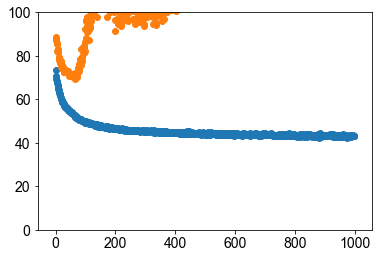

In [110]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [125]:
        xnorm = normalize(X_nmf)#scalerX.fit_transform(X)
        ynorm = normalize(Y_nmf)#np.asarray(scalerY.fit_transform(Y))
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/0, Loss:   68.7248, rec_loss:   68.7221, KL_loss:    0.0027
Epoch 01/1000 Batch 0000/0, Loss:   63.8698, rec_loss:   63.8636, KL_loss:    0.0063
Epoch 02/1000 Batch 0000/0, Loss:   61.6894, rec_loss:   61.6651, KL_loss:    0.0244
Epoch 03/1000 Batch 0000/0, Loss:   60.0559, rec_loss:   60.0081, KL_loss:    0.0478
Epoch 04/1000 Batch 0000/0, Loss:   58.8646, rec_loss:   58.8243, KL_loss:    0.0403
Epoch 05/1000 Batch 0000/0, Loss:   57.1945, rec_loss:   57.1077, KL_loss:    0.0868
Epoch 06/1000 Batch 0000/0, Loss:   55.8410, rec_loss:   55.7778, KL_loss:    0.0632
Epoch 07/1000 Batch 0000/0, Loss:   55.8673, rec_loss:   55.8257, KL_loss:    0.0415
Epoch 08/1000 Batch 0000/0, Loss:   54.4974, rec_loss:   54.4590, KL_loss:    0.0384
Epoch 09/1000 Batch 0000/0, Loss:   53.6629, rec_loss:   53.6213, KL_loss:    0.0416
Epoch 10/1000 Batch 0000/0, Loss:   52.667

Epoch 99/1000 Batch 0000/0, Loss:   38.6515, rec_loss:   38.5694, KL_loss:    0.0820
Epoch 100/1000 Batch 0000/0, Loss:   38.6802, rec_loss:   38.5983, KL_loss:    0.0819
Epoch 101/1000 Batch 0000/0, Loss:   38.5139, rec_loss:   38.4320, KL_loss:    0.0819
Epoch 102/1000 Batch 0000/0, Loss:   38.4429, rec_loss:   38.3609, KL_loss:    0.0819
Epoch 103/1000 Batch 0000/0, Loss:   38.3950, rec_loss:   38.3130, KL_loss:    0.0820
Epoch 104/1000 Batch 0000/0, Loss:   38.3514, rec_loss:   38.2694, KL_loss:    0.0820
Epoch 105/1000 Batch 0000/0, Loss:   38.2823, rec_loss:   38.2002, KL_loss:    0.0821
Epoch 106/1000 Batch 0000/0, Loss:   38.1437, rec_loss:   38.0615, KL_loss:    0.0822
Epoch 107/1000 Batch 0000/0, Loss:   38.1585, rec_loss:   38.0763, KL_loss:    0.0822
Epoch 108/1000 Batch 0000/0, Loss:   38.1227, rec_loss:   38.0403, KL_loss:    0.0824
Epoch 109/1000 Batch 0000/0, Loss:   38.0711, rec_loss:   37.9887, KL_loss:    0.0824
Epoch 110/1000 Batch 0000/0, Loss:   38.0566, rec_loss:

Epoch 195/1000 Batch 0000/0, Loss:   35.5034, rec_loss:   35.4058, KL_loss:    0.0976
Epoch 196/1000 Batch 0000/0, Loss:   35.3587, rec_loss:   35.2611, KL_loss:    0.0976
Epoch 197/1000 Batch 0000/0, Loss:   35.3267, rec_loss:   35.2290, KL_loss:    0.0977
Epoch 198/1000 Batch 0000/0, Loss:   35.2808, rec_loss:   35.1831, KL_loss:    0.0977
Epoch 199/1000 Batch 0000/0, Loss:   35.2227, rec_loss:   35.1249, KL_loss:    0.0978
Epoch 200/1000 Batch 0000/0, Loss:   35.2396, rec_loss:   35.1418, KL_loss:    0.0978
Epoch 201/1000 Batch 0000/0, Loss:   35.1462, rec_loss:   35.0484, KL_loss:    0.0978
Epoch 202/1000 Batch 0000/0, Loss:   35.1578, rec_loss:   35.0600, KL_loss:    0.0978
Epoch 203/1000 Batch 0000/0, Loss:   35.0800, rec_loss:   34.9821, KL_loss:    0.0979
Epoch 204/1000 Batch 0000/0, Loss:   35.1030, rec_loss:   35.0051, KL_loss:    0.0979
Epoch 205/1000 Batch 0000/0, Loss:   35.0452, rec_loss:   34.9473, KL_loss:    0.0980
Epoch 206/1000 Batch 0000/0, Loss:   35.0365, rec_loss

Epoch 296/1000 Batch 0000/0, Loss:   34.3790, rec_loss:   34.2726, KL_loss:    0.1064
Epoch 297/1000 Batch 0000/0, Loss:   33.8315, rec_loss:   33.7250, KL_loss:    0.1065
Epoch 298/1000 Batch 0000/0, Loss:   34.0666, rec_loss:   33.9601, KL_loss:    0.1065
Epoch 299/1000 Batch 0000/0, Loss:   34.3341, rec_loss:   34.2275, KL_loss:    0.1066
Epoch 300/1000 Batch 0000/0, Loss:   33.7844, rec_loss:   33.6777, KL_loss:    0.1067
Epoch 301/1000 Batch 0000/0, Loss:   34.1628, rec_loss:   34.0560, KL_loss:    0.1067
Epoch 302/1000 Batch 0000/0, Loss:   34.1143, rec_loss:   34.0076, KL_loss:    0.1068
Epoch 303/1000 Batch 0000/0, Loss:   33.8655, rec_loss:   33.7586, KL_loss:    0.1069
Epoch 304/1000 Batch 0000/0, Loss:   34.1797, rec_loss:   34.0728, KL_loss:    0.1070
Epoch 305/1000 Batch 0000/0, Loss:   33.8864, rec_loss:   33.7794, KL_loss:    0.1070
Epoch 306/1000 Batch 0000/0, Loss:   33.9938, rec_loss:   33.8867, KL_loss:    0.1071
Epoch 307/1000 Batch 0000/0, Loss:   33.9586, rec_loss

Epoch 392/1000 Batch 0000/0, Loss:   33.2202, rec_loss:   33.1081, KL_loss:    0.1122
Epoch 393/1000 Batch 0000/0, Loss:   33.0955, rec_loss:   32.9833, KL_loss:    0.1123
Epoch 394/1000 Batch 0000/0, Loss:   33.1530, rec_loss:   33.0406, KL_loss:    0.1123
Epoch 395/1000 Batch 0000/0, Loss:   33.2610, rec_loss:   33.1486, KL_loss:    0.1124
Epoch 396/1000 Batch 0000/0, Loss:   33.4350, rec_loss:   33.3226, KL_loss:    0.1124
Epoch 397/1000 Batch 0000/0, Loss:   33.5063, rec_loss:   33.3939, KL_loss:    0.1124
Epoch 398/1000 Batch 0000/0, Loss:   33.3529, rec_loss:   33.2404, KL_loss:    0.1125
Epoch 399/1000 Batch 0000/0, Loss:   33.1219, rec_loss:   33.0094, KL_loss:    0.1125
Epoch 400/1000 Batch 0000/0, Loss:   33.0044, rec_loss:   32.8918, KL_loss:    0.1126
Epoch 401/1000 Batch 0000/0, Loss:   33.0722, rec_loss:   32.9596, KL_loss:    0.1126
Epoch 402/1000 Batch 0000/0, Loss:   33.0891, rec_loss:   32.9765, KL_loss:    0.1126
Epoch 403/1000 Batch 0000/0, Loss:   33.0157, rec_loss

Epoch 488/1000 Batch 0000/0, Loss:   32.8388, rec_loss:   32.7241, KL_loss:    0.1147
Epoch 489/1000 Batch 0000/0, Loss:   32.5430, rec_loss:   32.4283, KL_loss:    0.1147
Epoch 490/1000 Batch 0000/0, Loss:   32.6614, rec_loss:   32.5466, KL_loss:    0.1148
Epoch 491/1000 Batch 0000/0, Loss:   32.6846, rec_loss:   32.5697, KL_loss:    0.1148
Epoch 492/1000 Batch 0000/0, Loss:   32.4695, rec_loss:   32.3546, KL_loss:    0.1148
Epoch 493/1000 Batch 0000/0, Loss:   32.6701, rec_loss:   32.5553, KL_loss:    0.1149
Epoch 494/1000 Batch 0000/0, Loss:   32.6880, rec_loss:   32.5731, KL_loss:    0.1149
Epoch 495/1000 Batch 0000/0, Loss:   32.5718, rec_loss:   32.4569, KL_loss:    0.1149
Epoch 496/1000 Batch 0000/0, Loss:   32.8920, rec_loss:   32.7770, KL_loss:    0.1150
Epoch 497/1000 Batch 0000/0, Loss:   32.8091, rec_loss:   32.6941, KL_loss:    0.1150
Epoch 498/1000 Batch 0000/0, Loss:   32.5415, rec_loss:   32.4265, KL_loss:    0.1150
Epoch 499/1000 Batch 0000/0, Loss:   32.6488, rec_loss

Epoch 584/1000 Batch 0000/0, Loss:   32.5039, rec_loss:   32.3881, KL_loss:    0.1158
Epoch 585/1000 Batch 0000/0, Loss:   33.5036, rec_loss:   33.3878, KL_loss:    0.1158
Epoch 586/1000 Batch 0000/0, Loss:   33.1290, rec_loss:   33.0131, KL_loss:    0.1159
Epoch 587/1000 Batch 0000/0, Loss:   32.8291, rec_loss:   32.7132, KL_loss:    0.1160
Epoch 588/1000 Batch 0000/0, Loss:   32.8928, rec_loss:   32.7769, KL_loss:    0.1159
Epoch 589/1000 Batch 0000/0, Loss:   32.5371, rec_loss:   32.4211, KL_loss:    0.1160
Epoch 590/1000 Batch 0000/0, Loss:   32.8225, rec_loss:   32.7065, KL_loss:    0.1160
Epoch 591/1000 Batch 0000/0, Loss:   32.5065, rec_loss:   32.3905, KL_loss:    0.1160
Epoch 592/1000 Batch 0000/0, Loss:   32.6789, rec_loss:   32.5631, KL_loss:    0.1158
Epoch 593/1000 Batch 0000/0, Loss:   32.4534, rec_loss:   32.3376, KL_loss:    0.1158
Epoch 594/1000 Batch 0000/0, Loss:   32.5080, rec_loss:   32.3923, KL_loss:    0.1157
Epoch 595/1000 Batch 0000/0, Loss:   32.3696, rec_loss

Epoch 680/1000 Batch 0000/0, Loss:   31.8345, rec_loss:   31.7185, KL_loss:    0.1161
Epoch 681/1000 Batch 0000/0, Loss:   31.8926, rec_loss:   31.7765, KL_loss:    0.1161
Epoch 682/1000 Batch 0000/0, Loss:   31.8351, rec_loss:   31.7191, KL_loss:    0.1161
Epoch 683/1000 Batch 0000/0, Loss:   31.7737, rec_loss:   31.6576, KL_loss:    0.1161
Epoch 684/1000 Batch 0000/0, Loss:   31.8375, rec_loss:   31.7214, KL_loss:    0.1161
Epoch 685/1000 Batch 0000/0, Loss:   31.8661, rec_loss:   31.7499, KL_loss:    0.1161
Epoch 686/1000 Batch 0000/0, Loss:   31.7251, rec_loss:   31.6090, KL_loss:    0.1162
Epoch 687/1000 Batch 0000/0, Loss:   31.7406, rec_loss:   31.6244, KL_loss:    0.1162
Epoch 688/1000 Batch 0000/0, Loss:   31.7516, rec_loss:   31.6355, KL_loss:    0.1162
Epoch 689/1000 Batch 0000/0, Loss:   31.7441, rec_loss:   31.6279, KL_loss:    0.1162
Epoch 690/1000 Batch 0000/0, Loss:   31.7338, rec_loss:   31.6176, KL_loss:    0.1162
Epoch 691/1000 Batch 0000/0, Loss:   31.7308, rec_loss

Epoch 776/1000 Batch 0000/0, Loss:   31.6304, rec_loss:   31.5133, KL_loss:    0.1171
Epoch 777/1000 Batch 0000/0, Loss:   31.5781, rec_loss:   31.4611, KL_loss:    0.1171
Epoch 778/1000 Batch 0000/0, Loss:   31.4226, rec_loss:   31.3055, KL_loss:    0.1171
Epoch 779/1000 Batch 0000/0, Loss:   31.3733, rec_loss:   31.2562, KL_loss:    0.1172
Epoch 780/1000 Batch 0000/0, Loss:   31.4784, rec_loss:   31.3613, KL_loss:    0.1172
Epoch 781/1000 Batch 0000/0, Loss:   31.5182, rec_loss:   31.4009, KL_loss:    0.1172
Epoch 782/1000 Batch 0000/0, Loss:   31.5282, rec_loss:   31.4108, KL_loss:    0.1173
Epoch 783/1000 Batch 0000/0, Loss:   31.7098, rec_loss:   31.5925, KL_loss:    0.1173
Epoch 784/1000 Batch 0000/0, Loss:   32.0502, rec_loss:   31.9328, KL_loss:    0.1174
Epoch 785/1000 Batch 0000/0, Loss:   32.7756, rec_loss:   32.6582, KL_loss:    0.1174
Epoch 786/1000 Batch 0000/0, Loss:   32.0345, rec_loss:   31.9171, KL_loss:    0.1174
Epoch 787/1000 Batch 0000/0, Loss:   31.6491, rec_loss

Epoch 877/1000 Batch 0000/0, Loss:   31.3319, rec_loss:   31.2148, KL_loss:    0.1171
Epoch 878/1000 Batch 0000/0, Loss:   31.5677, rec_loss:   31.4507, KL_loss:    0.1170
Epoch 879/1000 Batch 0000/0, Loss:   31.6195, rec_loss:   31.5025, KL_loss:    0.1170
Epoch 880/1000 Batch 0000/0, Loss:   31.7349, rec_loss:   31.6180, KL_loss:    0.1169
Epoch 881/1000 Batch 0000/0, Loss:   31.4006, rec_loss:   31.2837, KL_loss:    0.1169
Epoch 882/1000 Batch 0000/0, Loss:   31.2840, rec_loss:   31.1671, KL_loss:    0.1168
Epoch 883/1000 Batch 0000/0, Loss:   31.4058, rec_loss:   31.2889, KL_loss:    0.1168
Epoch 884/1000 Batch 0000/0, Loss:   31.4411, rec_loss:   31.3243, KL_loss:    0.1169
Epoch 885/1000 Batch 0000/0, Loss:   31.4555, rec_loss:   31.3387, KL_loss:    0.1168
Epoch 886/1000 Batch 0000/0, Loss:   31.2929, rec_loss:   31.1760, KL_loss:    0.1169
Epoch 887/1000 Batch 0000/0, Loss:   31.1638, rec_loss:   31.0468, KL_loss:    0.1169
Epoch 888/1000 Batch 0000/0, Loss:   31.1175, rec_loss

Epoch 978/1000 Batch 0000/0, Loss:   31.7723, rec_loss:   31.6542, KL_loss:    0.1181
Epoch 979/1000 Batch 0000/0, Loss:   31.1819, rec_loss:   31.0637, KL_loss:    0.1182
Epoch 980/1000 Batch 0000/0, Loss:   30.9747, rec_loss:   30.8565, KL_loss:    0.1182
Epoch 981/1000 Batch 0000/0, Loss:   31.1662, rec_loss:   31.0479, KL_loss:    0.1183
Epoch 982/1000 Batch 0000/0, Loss:   31.0704, rec_loss:   30.9522, KL_loss:    0.1183
Epoch 983/1000 Batch 0000/0, Loss:   30.9743, rec_loss:   30.8560, KL_loss:    0.1183
Epoch 984/1000 Batch 0000/0, Loss:   31.0191, rec_loss:   30.9007, KL_loss:    0.1184
Epoch 985/1000 Batch 0000/0, Loss:   31.0611, rec_loss:   30.9427, KL_loss:    0.1184
Epoch 986/1000 Batch 0000/0, Loss:   31.2760, rec_loss:   31.1575, KL_loss:    0.1185
Epoch 987/1000 Batch 0000/0, Loss:   31.5093, rec_loss:   31.3908, KL_loss:    0.1185
Epoch 988/1000 Batch 0000/0, Loss:   31.9403, rec_loss:   31.8217, KL_loss:    0.1186
Epoch 989/1000 Batch 0000/0, Loss:   31.7622, rec_loss

(0, 100)

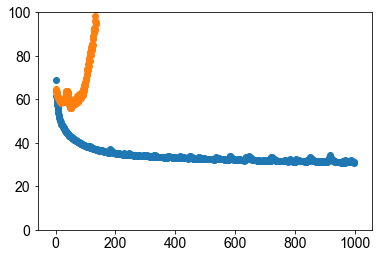

In [127]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [128]:
        xnorm = pcaX.fit_transform(normalize(X))#_nmf)
        #scalerX.fit_transform(X)
        ynorm = pcaY.fit_transform(normalize(Y))  
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        condition_key =0
        
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )#/ iteration)
            self.logs["rec_loss_train"].append(train_rec )#/ iteration)
            self.logs["KL_loss_train"].append(train_kl )#/ iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/0, Loss:  609.1266, rec_loss:  609.1237, KL_loss:    0.0029
Epoch 01/1000 Batch 0000/0, Loss:  597.0210, rec_loss:  597.0121, KL_loss:    0.0089
Epoch 02/1000 Batch 0000/0, Loss:  589.6700, rec_loss:  589.6608, KL_loss:    0.0092
Epoch 03/1000 Batch 0000/0, Loss:  588.1262, rec_loss:  588.1074, KL_loss:    0.0187
Epoch 04/1000 Batch 0000/0, Loss:  577.0223, rec_loss:  577.0042, KL_loss:    0.0181
Epoch 05/1000 Batch 0000/0, Loss:  567.5526, rec_loss:  567.5303, KL_loss:    0.0222
Epoch 06/1000 Batch 0000/0, Loss:  561.7658, rec_loss:  561.7410, KL_loss:    0.0248
Epoch 07/1000 Batch 0000/0, Loss:  549.6929, rec_loss:  549.6647, KL_loss:    0.0281
Epoch 08/1000 Batch 0000/0, Loss:  540.3240, rec_loss:  540.2947, KL_loss:    0.0293
Epoch 09/1000 Batch 0000/0, Loss:  531.6770, rec_loss:  531.6443, KL_loss:    0.0328
Epoch 10/1000 Batch 0000/0, Loss:  524.667

Epoch 100/1000 Batch 0000/0, Loss:  280.8696, rec_loss:  280.7594, KL_loss:    0.1102
Epoch 101/1000 Batch 0000/0, Loss:  279.4911, rec_loss:  279.3803, KL_loss:    0.1108
Epoch 102/1000 Batch 0000/0, Loss:  282.3911, rec_loss:  282.2796, KL_loss:    0.1114
Epoch 103/1000 Batch 0000/0, Loss:  281.1296, rec_loss:  281.0175, KL_loss:    0.1121
Epoch 104/1000 Batch 0000/0, Loss:  271.6602, rec_loss:  271.5475, KL_loss:    0.1127
Epoch 105/1000 Batch 0000/0, Loss:  272.6797, rec_loss:  272.5665, KL_loss:    0.1132
Epoch 106/1000 Batch 0000/0, Loss:  270.7803, rec_loss:  270.6666, KL_loss:    0.1137
Epoch 107/1000 Batch 0000/0, Loss:  265.8805, rec_loss:  265.7663, KL_loss:    0.1142
Epoch 108/1000 Batch 0000/0, Loss:  266.9383, rec_loss:  266.8236, KL_loss:    0.1147
Epoch 109/1000 Batch 0000/0, Loss:  261.9539, rec_loss:  261.8388, KL_loss:    0.1151
Epoch 110/1000 Batch 0000/0, Loss:  263.1593, rec_loss:  263.0436, KL_loss:    0.1156
Epoch 111/1000 Batch 0000/0, Loss:  266.8236, rec_loss

Epoch 196/1000 Batch 0000/0, Loss:  166.3383, rec_loss:  166.1934, KL_loss:    0.1449
Epoch 197/1000 Batch 0000/0, Loss:  172.5276, rec_loss:  172.3825, KL_loss:    0.1451
Epoch 198/1000 Batch 0000/0, Loss:  163.5887, rec_loss:  163.4433, KL_loss:    0.1454
Epoch 199/1000 Batch 0000/0, Loss:  163.3148, rec_loss:  163.1692, KL_loss:    0.1456
Epoch 200/1000 Batch 0000/0, Loss:  160.5591, rec_loss:  160.4131, KL_loss:    0.1459
Epoch 201/1000 Batch 0000/0, Loss:  165.0356, rec_loss:  164.8895, KL_loss:    0.1461
Epoch 202/1000 Batch 0000/0, Loss:  178.0605, rec_loss:  177.9140, KL_loss:    0.1465
Epoch 203/1000 Batch 0000/0, Loss:  176.2537, rec_loss:  176.1069, KL_loss:    0.1468
Epoch 204/1000 Batch 0000/0, Loss:  167.3007, rec_loss:  167.1536, KL_loss:    0.1471
Epoch 205/1000 Batch 0000/0, Loss:  164.2937, rec_loss:  164.1464, KL_loss:    0.1473
Epoch 206/1000 Batch 0000/0, Loss:  170.8338, rec_loss:  170.6864, KL_loss:    0.1475
Epoch 207/1000 Batch 0000/0, Loss:  174.3687, rec_loss

Epoch 292/1000 Batch 0000/0, Loss:  125.7742, rec_loss:  125.6133, KL_loss:    0.1610
Epoch 293/1000 Batch 0000/0, Loss:  126.0305, rec_loss:  125.8693, KL_loss:    0.1611
Epoch 294/1000 Batch 0000/0, Loss:  123.1894, rec_loss:  123.0282, KL_loss:    0.1613
Epoch 295/1000 Batch 0000/0, Loss:  121.3146, rec_loss:  121.1532, KL_loss:    0.1614
Epoch 296/1000 Batch 0000/0, Loss:  122.2856, rec_loss:  122.1240, KL_loss:    0.1616
Epoch 297/1000 Batch 0000/0, Loss:  123.3967, rec_loss:  123.2350, KL_loss:    0.1617
Epoch 298/1000 Batch 0000/0, Loss:  124.1341, rec_loss:  123.9722, KL_loss:    0.1619
Epoch 299/1000 Batch 0000/0, Loss:  125.0443, rec_loss:  124.8822, KL_loss:    0.1621
Epoch 300/1000 Batch 0000/0, Loss:  125.8769, rec_loss:  125.7147, KL_loss:    0.1622
Epoch 301/1000 Batch 0000/0, Loss:  123.2679, rec_loss:  123.1055, KL_loss:    0.1624
Epoch 302/1000 Batch 0000/0, Loss:  123.7795, rec_loss:  123.6170, KL_loss:    0.1625
Epoch 303/1000 Batch 0000/0, Loss:  122.1895, rec_loss

Epoch 388/1000 Batch 0000/0, Loss:  129.3954, rec_loss:  129.2243, KL_loss:    0.1711
Epoch 389/1000 Batch 0000/0, Loss:  124.0993, rec_loss:  123.9282, KL_loss:    0.1711
Epoch 390/1000 Batch 0000/0, Loss:  119.6273, rec_loss:  119.4562, KL_loss:    0.1711
Epoch 391/1000 Batch 0000/0, Loss:  119.6233, rec_loss:  119.4521, KL_loss:    0.1711
Epoch 392/1000 Batch 0000/0, Loss:  120.1804, rec_loss:  120.0092, KL_loss:    0.1711
Epoch 393/1000 Batch 0000/0, Loss:  112.0402, rec_loss:  111.8691, KL_loss:    0.1712
Epoch 394/1000 Batch 0000/0, Loss:  115.5204, rec_loss:  115.3492, KL_loss:    0.1712
Epoch 395/1000 Batch 0000/0, Loss:  111.9706, rec_loss:  111.7994, KL_loss:    0.1712
Epoch 396/1000 Batch 0000/0, Loss:  111.1936, rec_loss:  111.0224, KL_loss:    0.1712
Epoch 397/1000 Batch 0000/0, Loss:  108.6834, rec_loss:  108.5122, KL_loss:    0.1713
Epoch 398/1000 Batch 0000/0, Loss:  110.7644, rec_loss:  110.5931, KL_loss:    0.1713
Epoch 399/1000 Batch 0000/0, Loss:  105.1179, rec_loss

Epoch 484/1000 Batch 0000/0, Loss:   91.4373, rec_loss:   91.2598, KL_loss:    0.1775
Epoch 485/1000 Batch 0000/0, Loss:   90.8092, rec_loss:   90.6316, KL_loss:    0.1775
Epoch 486/1000 Batch 0000/0, Loss:   89.7589, rec_loss:   89.5814, KL_loss:    0.1776
Epoch 487/1000 Batch 0000/0, Loss:   90.0800, rec_loss:   89.9024, KL_loss:    0.1776
Epoch 488/1000 Batch 0000/0, Loss:   95.2994, rec_loss:   95.1217, KL_loss:    0.1777
Epoch 489/1000 Batch 0000/0, Loss:  103.3107, rec_loss:  103.1329, KL_loss:    0.1778
Epoch 490/1000 Batch 0000/0, Loss:   98.3003, rec_loss:   98.1225, KL_loss:    0.1778
Epoch 491/1000 Batch 0000/0, Loss:  100.1752, rec_loss:   99.9974, KL_loss:    0.1778
Epoch 492/1000 Batch 0000/0, Loss:   96.4241, rec_loss:   96.2462, KL_loss:    0.1779
Epoch 493/1000 Batch 0000/0, Loss:   93.7929, rec_loss:   93.6149, KL_loss:    0.1779
Epoch 494/1000 Batch 0000/0, Loss:   89.3725, rec_loss:   89.1946, KL_loss:    0.1780
Epoch 495/1000 Batch 0000/0, Loss:   92.2510, rec_loss

Epoch 580/1000 Batch 0000/0, Loss:   80.4691, rec_loss:   80.2877, KL_loss:    0.1814
Epoch 581/1000 Batch 0000/0, Loss:   82.9140, rec_loss:   82.7327, KL_loss:    0.1814
Epoch 582/1000 Batch 0000/0, Loss:   85.6193, rec_loss:   85.4380, KL_loss:    0.1813
Epoch 583/1000 Batch 0000/0, Loss:   81.3635, rec_loss:   81.1823, KL_loss:    0.1813
Epoch 584/1000 Batch 0000/0, Loss:   79.6872, rec_loss:   79.5060, KL_loss:    0.1813
Epoch 585/1000 Batch 0000/0, Loss:   77.4019, rec_loss:   77.2206, KL_loss:    0.1813
Epoch 586/1000 Batch 0000/0, Loss:   75.8622, rec_loss:   75.6809, KL_loss:    0.1813
Epoch 587/1000 Batch 0000/0, Loss:   76.0911, rec_loss:   75.9097, KL_loss:    0.1814
Epoch 588/1000 Batch 0000/0, Loss:   76.2256, rec_loss:   76.0442, KL_loss:    0.1814
Epoch 589/1000 Batch 0000/0, Loss:   78.8293, rec_loss:   78.6479, KL_loss:    0.1814
Epoch 590/1000 Batch 0000/0, Loss:   83.7507, rec_loss:   83.5692, KL_loss:    0.1815
Epoch 591/1000 Batch 0000/0, Loss:   90.7641, rec_loss

Epoch 676/1000 Batch 0000/0, Loss:   80.4582, rec_loss:   80.2757, KL_loss:    0.1825
Epoch 677/1000 Batch 0000/0, Loss:   79.3121, rec_loss:   79.1297, KL_loss:    0.1825
Epoch 678/1000 Batch 0000/0, Loss:   80.7061, rec_loss:   80.5236, KL_loss:    0.1825
Epoch 679/1000 Batch 0000/0, Loss:   77.2171, rec_loss:   77.0345, KL_loss:    0.1825
Epoch 680/1000 Batch 0000/0, Loss:   75.7938, rec_loss:   75.6112, KL_loss:    0.1826
Epoch 681/1000 Batch 0000/0, Loss:   78.1138, rec_loss:   77.9312, KL_loss:    0.1827
Epoch 682/1000 Batch 0000/0, Loss:   73.3382, rec_loss:   73.1554, KL_loss:    0.1827
Epoch 683/1000 Batch 0000/0, Loss:   73.1606, rec_loss:   72.9778, KL_loss:    0.1828
Epoch 684/1000 Batch 0000/0, Loss:   72.4284, rec_loss:   72.2456, KL_loss:    0.1828
Epoch 685/1000 Batch 0000/0, Loss:   74.1358, rec_loss:   73.9530, KL_loss:    0.1828
Epoch 686/1000 Batch 0000/0, Loss:   70.4604, rec_loss:   70.2776, KL_loss:    0.1828
Epoch 687/1000 Batch 0000/0, Loss:   70.6292, rec_loss

Epoch 772/1000 Batch 0000/0, Loss:   73.6143, rec_loss:   73.4294, KL_loss:    0.1849
Epoch 773/1000 Batch 0000/0, Loss:   71.2635, rec_loss:   71.0785, KL_loss:    0.1850
Epoch 774/1000 Batch 0000/0, Loss:   71.0208, rec_loss:   70.8357, KL_loss:    0.1850
Epoch 775/1000 Batch 0000/0, Loss:   66.3030, rec_loss:   66.1179, KL_loss:    0.1851
Epoch 776/1000 Batch 0000/0, Loss:   67.2573, rec_loss:   67.0721, KL_loss:    0.1852
Epoch 777/1000 Batch 0000/0, Loss:   69.8771, rec_loss:   69.6918, KL_loss:    0.1853
Epoch 778/1000 Batch 0000/0, Loss:   69.9332, rec_loss:   69.7478, KL_loss:    0.1854
Epoch 779/1000 Batch 0000/0, Loss:   68.6590, rec_loss:   68.4735, KL_loss:    0.1854
Epoch 780/1000 Batch 0000/0, Loss:   65.8964, rec_loss:   65.7109, KL_loss:    0.1855
Epoch 781/1000 Batch 0000/0, Loss:   66.7223, rec_loss:   66.5367, KL_loss:    0.1856
Epoch 782/1000 Batch 0000/0, Loss:   68.8151, rec_loss:   68.6296, KL_loss:    0.1856
Epoch 783/1000 Batch 0000/0, Loss:   67.0894, rec_loss

Epoch 873/1000 Batch 0000/0, Loss:   64.3299, rec_loss:   64.1428, KL_loss:    0.1871
Epoch 874/1000 Batch 0000/0, Loss:   65.2220, rec_loss:   65.0349, KL_loss:    0.1871
Epoch 875/1000 Batch 0000/0, Loss:   69.5507, rec_loss:   69.3635, KL_loss:    0.1872
Epoch 876/1000 Batch 0000/0, Loss:   68.6957, rec_loss:   68.5084, KL_loss:    0.1873
Epoch 877/1000 Batch 0000/0, Loss:   64.8778, rec_loss:   64.6904, KL_loss:    0.1874
Epoch 878/1000 Batch 0000/0, Loss:   64.5874, rec_loss:   64.4000, KL_loss:    0.1874
Epoch 879/1000 Batch 0000/0, Loss:   64.6911, rec_loss:   64.5036, KL_loss:    0.1875
Epoch 880/1000 Batch 0000/0, Loss:   64.2926, rec_loss:   64.1050, KL_loss:    0.1876
Epoch 881/1000 Batch 0000/0, Loss:   66.3092, rec_loss:   66.1215, KL_loss:    0.1877
Epoch 882/1000 Batch 0000/0, Loss:   66.7256, rec_loss:   66.5378, KL_loss:    0.1878
Epoch 883/1000 Batch 0000/0, Loss:   62.5315, rec_loss:   62.3436, KL_loss:    0.1879
Epoch 884/1000 Batch 0000/0, Loss:   60.6986, rec_loss

Epoch 973/1000 Batch 0000/0, Loss:   69.7509, rec_loss:   69.5607, KL_loss:    0.1902
Epoch 974/1000 Batch 0000/0, Loss:   69.8060, rec_loss:   69.6159, KL_loss:    0.1902
Epoch 975/1000 Batch 0000/0, Loss:   67.5089, rec_loss:   67.3188, KL_loss:    0.1901
Epoch 976/1000 Batch 0000/0, Loss:   67.3666, rec_loss:   67.1765, KL_loss:    0.1901
Epoch 977/1000 Batch 0000/0, Loss:   65.8689, rec_loss:   65.6788, KL_loss:    0.1901
Epoch 978/1000 Batch 0000/0, Loss:   64.2680, rec_loss:   64.0779, KL_loss:    0.1900
Epoch 979/1000 Batch 0000/0, Loss:   63.2756, rec_loss:   63.0857, KL_loss:    0.1900
Epoch 980/1000 Batch 0000/0, Loss:   61.4015, rec_loss:   61.2116, KL_loss:    0.1899
Epoch 981/1000 Batch 0000/0, Loss:   62.5708, rec_loss:   62.3810, KL_loss:    0.1899
Epoch 982/1000 Batch 0000/0, Loss:   61.8072, rec_loss:   61.6174, KL_loss:    0.1898
Epoch 983/1000 Batch 0000/0, Loss:   61.4781, rec_loss:   61.2883, KL_loss:    0.1898
Epoch 984/1000 Batch 0000/0, Loss:   62.7299, rec_loss

(0, 1000)

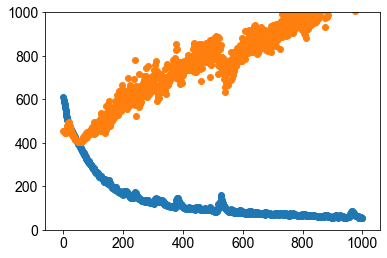

In [130]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,1000)

In [132]:
        #xnorm = scalerX.fit_transform(X)
        #ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=20
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/14, Loss:   93.0523, rec_loss:   93.0496, KL_loss:    0.0027
Epoch 00/1000 Batch 0014/14, Loss:   60.6256, rec_loss:   60.6228, KL_loss:    0.0028
Epoch 01/1000 Batch 0000/14, Loss:   78.6712, rec_loss:   78.6685, KL_loss:    0.0027
Epoch 01/1000 Batch 0014/14, Loss:   60.0381, rec_loss:   60.0351, KL_loss:    0.0030
Epoch 02/1000 Batch 0000/14, Loss:   67.9017, rec_loss:   67.8985, KL_loss:    0.0032
Epoch 02/1000 Batch 0014/14, Loss:   74.2743, rec_loss:   74.2711, KL_loss:    0.0032
Epoch 03/1000 Batch 0000/14, Loss:   48.3388, rec_loss:   48.3353, KL_loss:    0.0035
Epoch 03/1000 Batch 0014/14, Loss:   62.4519, rec_loss:   62.4483, KL_loss:    0.0036
Epoch 04/1000 Batch 0000/14, Loss:   67.4890, rec_loss:   67.4854, KL_loss:    0.0036
Epoch 04/1000 Batch 0014/14, Loss:   51.2954, rec_loss:   51.2917, KL_loss:    0.0038
Epoch 05/1000 Batch 0000/14, Loss

Epoch 48/1000 Batch 0000/14, Loss:   46.3021, rec_loss:   46.2687, KL_loss:    0.0334
Epoch 48/1000 Batch 0014/14, Loss:   33.1516, rec_loss:   33.1126, KL_loss:    0.0390
Epoch 49/1000 Batch 0000/14, Loss:   42.1045, rec_loss:   42.0654, KL_loss:    0.0392
Epoch 49/1000 Batch 0014/14, Loss:   49.8072, rec_loss:   49.7657, KL_loss:    0.0415
Epoch 50/1000 Batch 0000/14, Loss:   45.2352, rec_loss:   45.1985, KL_loss:    0.0367
Epoch 50/1000 Batch 0014/14, Loss:   40.3410, rec_loss:   40.3052, KL_loss:    0.0358
Epoch 51/1000 Batch 0000/14, Loss:   45.7856, rec_loss:   45.7497, KL_loss:    0.0359
Epoch 51/1000 Batch 0014/14, Loss:   60.2488, rec_loss:   60.2123, KL_loss:    0.0364
Epoch 52/1000 Batch 0000/14, Loss:   47.4942, rec_loss:   47.4538, KL_loss:    0.0404
Epoch 52/1000 Batch 0014/14, Loss:   55.4065, rec_loss:   55.3753, KL_loss:    0.0312
Epoch 53/1000 Batch 0000/14, Loss:   47.1451, rec_loss:   47.1034, KL_loss:    0.0418
Epoch 53/1000 Batch 0014/14, Loss:   44.8626, rec_loss

Epoch 96/1000 Batch 0014/14, Loss:   48.4223, rec_loss:   48.3610, KL_loss:    0.0612
Epoch 97/1000 Batch 0000/14, Loss:   30.9358, rec_loss:   30.8767, KL_loss:    0.0591
Epoch 97/1000 Batch 0014/14, Loss:   31.4013, rec_loss:   31.3375, KL_loss:    0.0638
Epoch 98/1000 Batch 0000/14, Loss:   48.9516, rec_loss:   48.8993, KL_loss:    0.0523
Epoch 98/1000 Batch 0014/14, Loss:   46.3138, rec_loss:   46.2524, KL_loss:    0.0614
Epoch 99/1000 Batch 0000/14, Loss:   51.3016, rec_loss:   51.2420, KL_loss:    0.0596
Epoch 99/1000 Batch 0014/14, Loss:   52.1011, rec_loss:   52.0393, KL_loss:    0.0618
Epoch 100/1000 Batch 0000/14, Loss:   38.4207, rec_loss:   38.3620, KL_loss:    0.0587
Epoch 100/1000 Batch 0014/14, Loss:   42.1975, rec_loss:   42.1351, KL_loss:    0.0624
Epoch 101/1000 Batch 0000/14, Loss:   40.0041, rec_loss:   39.9401, KL_loss:    0.0640
Epoch 101/1000 Batch 0014/14, Loss:   39.4009, rec_loss:   39.3382, KL_loss:    0.0627
Epoch 102/1000 Batch 0000/14, Loss:   45.5955, rec

Epoch 145/1000 Batch 0000/14, Loss:   57.2644, rec_loss:   57.1972, KL_loss:    0.0671
Epoch 145/1000 Batch 0014/14, Loss:   33.6547, rec_loss:   33.5855, KL_loss:    0.0692
Epoch 146/1000 Batch 0000/14, Loss:   41.9083, rec_loss:   41.8389, KL_loss:    0.0694
Epoch 146/1000 Batch 0014/14, Loss:   42.1691, rec_loss:   42.0998, KL_loss:    0.0693
Epoch 147/1000 Batch 0000/14, Loss:   40.9587, rec_loss:   40.8909, KL_loss:    0.0677
Epoch 147/1000 Batch 0014/14, Loss:   43.3559, rec_loss:   43.2831, KL_loss:    0.0728
Epoch 148/1000 Batch 0000/14, Loss:   38.3080, rec_loss:   38.2344, KL_loss:    0.0735
Epoch 148/1000 Batch 0014/14, Loss:   52.7170, rec_loss:   52.6461, KL_loss:    0.0708
Epoch 149/1000 Batch 0000/14, Loss:   53.9267, rec_loss:   53.8617, KL_loss:    0.0649
Epoch 149/1000 Batch 0014/14, Loss:   45.0471, rec_loss:   44.9763, KL_loss:    0.0708
Epoch 150/1000 Batch 0000/14, Loss:   48.6329, rec_loss:   48.5605, KL_loss:    0.0724
Epoch 150/1000 Batch 0014/14, Loss:   29.28

Epoch 193/1000 Batch 0014/14, Loss:   37.6743, rec_loss:   37.5990, KL_loss:    0.0752
Epoch 194/1000 Batch 0000/14, Loss:   40.7448, rec_loss:   40.6669, KL_loss:    0.0778
Epoch 194/1000 Batch 0014/14, Loss:   52.1843, rec_loss:   52.1092, KL_loss:    0.0751
Epoch 195/1000 Batch 0000/14, Loss:   40.5898, rec_loss:   40.5162, KL_loss:    0.0736
Epoch 195/1000 Batch 0014/14, Loss:   45.8464, rec_loss:   45.7718, KL_loss:    0.0745
Epoch 196/1000 Batch 0000/14, Loss:   31.2163, rec_loss:   31.1415, KL_loss:    0.0748
Epoch 196/1000 Batch 0014/14, Loss:   36.9170, rec_loss:   36.8377, KL_loss:    0.0792
Epoch 197/1000 Batch 0000/14, Loss:   38.0620, rec_loss:   37.9884, KL_loss:    0.0736
Epoch 197/1000 Batch 0014/14, Loss:   40.5109, rec_loss:   40.4333, KL_loss:    0.0776
Epoch 198/1000 Batch 0000/14, Loss:   53.2935, rec_loss:   53.2202, KL_loss:    0.0733
Epoch 198/1000 Batch 0014/14, Loss:   48.7524, rec_loss:   48.6809, KL_loss:    0.0715
Epoch 199/1000 Batch 0000/14, Loss:   41.76

Epoch 241/1000 Batch 0000/14, Loss:   62.4862, rec_loss:   62.4141, KL_loss:    0.0721
Epoch 241/1000 Batch 0014/14, Loss:   33.4990, rec_loss:   33.4174, KL_loss:    0.0816
Epoch 242/1000 Batch 0000/14, Loss:   51.4363, rec_loss:   51.3620, KL_loss:    0.0743
Epoch 242/1000 Batch 0014/14, Loss:   34.7278, rec_loss:   34.6495, KL_loss:    0.0783
Epoch 243/1000 Batch 0000/14, Loss:   48.4279, rec_loss:   48.3532, KL_loss:    0.0747
Epoch 243/1000 Batch 0014/14, Loss:   40.2404, rec_loss:   40.1657, KL_loss:    0.0747
Epoch 244/1000 Batch 0000/14, Loss:   44.1446, rec_loss:   44.0712, KL_loss:    0.0734
Epoch 244/1000 Batch 0014/14, Loss:   40.4578, rec_loss:   40.3771, KL_loss:    0.0807
Epoch 245/1000 Batch 0000/14, Loss:   32.2265, rec_loss:   32.1464, KL_loss:    0.0800
Epoch 245/1000 Batch 0014/14, Loss:   42.7245, rec_loss:   42.6459, KL_loss:    0.0786
Epoch 246/1000 Batch 0000/14, Loss:   55.9579, rec_loss:   55.8840, KL_loss:    0.0739
Epoch 246/1000 Batch 0014/14, Loss:   55.53

Epoch 291/1000 Batch 0000/14, Loss:   37.7024, rec_loss:   37.6197, KL_loss:    0.0826
Epoch 291/1000 Batch 0014/14, Loss:   47.2060, rec_loss:   47.1263, KL_loss:    0.0797
Epoch 292/1000 Batch 0000/14, Loss:   36.6417, rec_loss:   36.5591, KL_loss:    0.0825
Epoch 292/1000 Batch 0014/14, Loss:   34.3103, rec_loss:   34.2233, KL_loss:    0.0869
Epoch 293/1000 Batch 0000/14, Loss:   41.9700, rec_loss:   41.8903, KL_loss:    0.0798
Epoch 293/1000 Batch 0014/14, Loss:   43.2362, rec_loss:   43.1506, KL_loss:    0.0857
Epoch 294/1000 Batch 0000/14, Loss:   46.5241, rec_loss:   46.4463, KL_loss:    0.0777
Epoch 294/1000 Batch 0014/14, Loss:   32.3522, rec_loss:   32.2689, KL_loss:    0.0833
Epoch 295/1000 Batch 0000/14, Loss:   34.9388, rec_loss:   34.8599, KL_loss:    0.0789
Epoch 295/1000 Batch 0014/14, Loss:   35.0099, rec_loss:   34.9291, KL_loss:    0.0807
Epoch 296/1000 Batch 0000/14, Loss:   35.0451, rec_loss:   34.9668, KL_loss:    0.0783
Epoch 296/1000 Batch 0014/14, Loss:   63.96

Epoch 340/1000 Batch 0014/14, Loss:   38.9430, rec_loss:   38.8589, KL_loss:    0.0842
Epoch 341/1000 Batch 0000/14, Loss:   34.7508, rec_loss:   34.6675, KL_loss:    0.0833
Epoch 341/1000 Batch 0014/14, Loss:   41.3235, rec_loss:   41.2426, KL_loss:    0.0809
Epoch 342/1000 Batch 0000/14, Loss:   41.7117, rec_loss:   41.6256, KL_loss:    0.0860
Epoch 342/1000 Batch 0014/14, Loss:   37.7050, rec_loss:   37.6206, KL_loss:    0.0843
Epoch 343/1000 Batch 0000/14, Loss:   32.9952, rec_loss:   32.9112, KL_loss:    0.0840
Epoch 343/1000 Batch 0014/14, Loss:   56.6551, rec_loss:   56.5721, KL_loss:    0.0831
Epoch 344/1000 Batch 0000/14, Loss:   34.6300, rec_loss:   34.5471, KL_loss:    0.0829
Epoch 344/1000 Batch 0014/14, Loss:   39.8567, rec_loss:   39.7723, KL_loss:    0.0844
Epoch 345/1000 Batch 0000/14, Loss:   48.2474, rec_loss:   48.1665, KL_loss:    0.0809
Epoch 345/1000 Batch 0014/14, Loss:   34.3733, rec_loss:   34.2862, KL_loss:    0.0871
Epoch 346/1000 Batch 0000/14, Loss:   32.07

Epoch 389/1000 Batch 0000/14, Loss:   37.9168, rec_loss:   37.8345, KL_loss:    0.0822
Epoch 389/1000 Batch 0014/14, Loss:   27.0042, rec_loss:   26.9174, KL_loss:    0.0869
Epoch 390/1000 Batch 0000/14, Loss:   47.7668, rec_loss:   47.6801, KL_loss:    0.0867
Epoch 390/1000 Batch 0014/14, Loss:   46.1044, rec_loss:   46.0252, KL_loss:    0.0792
Epoch 391/1000 Batch 0000/14, Loss:   41.0879, rec_loss:   41.0045, KL_loss:    0.0834
Epoch 391/1000 Batch 0014/14, Loss:   38.6615, rec_loss:   38.5748, KL_loss:    0.0868
Epoch 392/1000 Batch 0000/14, Loss:   46.3118, rec_loss:   46.2244, KL_loss:    0.0874
Epoch 392/1000 Batch 0014/14, Loss:   36.6511, rec_loss:   36.5668, KL_loss:    0.0843
Epoch 393/1000 Batch 0000/14, Loss:   48.9269, rec_loss:   48.8417, KL_loss:    0.0852
Epoch 393/1000 Batch 0014/14, Loss:   38.6517, rec_loss:   38.5621, KL_loss:    0.0896
Epoch 394/1000 Batch 0000/14, Loss:   35.0483, rec_loss:   34.9591, KL_loss:    0.0893
Epoch 394/1000 Batch 0014/14, Loss:   40.08

Epoch 436/1000 Batch 0014/14, Loss:   39.5989, rec_loss:   39.5128, KL_loss:    0.0862
Epoch 437/1000 Batch 0000/14, Loss:   51.9641, rec_loss:   51.8762, KL_loss:    0.0879
Epoch 437/1000 Batch 0014/14, Loss:   41.0447, rec_loss:   40.9562, KL_loss:    0.0885
Epoch 438/1000 Batch 0000/14, Loss:   45.4983, rec_loss:   45.4139, KL_loss:    0.0844
Epoch 438/1000 Batch 0014/14, Loss:   56.9677, rec_loss:   56.8829, KL_loss:    0.0848
Epoch 439/1000 Batch 0000/14, Loss:   43.5472, rec_loss:   43.4628, KL_loss:    0.0844
Epoch 439/1000 Batch 0014/14, Loss:   42.4923, rec_loss:   42.4065, KL_loss:    0.0858
Epoch 440/1000 Batch 0000/14, Loss:   37.7683, rec_loss:   37.6831, KL_loss:    0.0851
Epoch 440/1000 Batch 0014/14, Loss:   30.1529, rec_loss:   30.0650, KL_loss:    0.0879
Epoch 441/1000 Batch 0000/14, Loss:   40.9697, rec_loss:   40.8872, KL_loss:    0.0826
Epoch 441/1000 Batch 0014/14, Loss:   33.9707, rec_loss:   33.8831, KL_loss:    0.0876
Epoch 442/1000 Batch 0000/14, Loss:   26.22

Epoch 484/1000 Batch 0014/14, Loss:   36.5703, rec_loss:   36.4830, KL_loss:    0.0873
Epoch 485/1000 Batch 0000/14, Loss:   36.8237, rec_loss:   36.7362, KL_loss:    0.0875
Epoch 485/1000 Batch 0014/14, Loss:   37.6021, rec_loss:   37.5144, KL_loss:    0.0877
Epoch 486/1000 Batch 0000/14, Loss:   27.2406, rec_loss:   27.1541, KL_loss:    0.0866
Epoch 486/1000 Batch 0014/14, Loss:   43.1603, rec_loss:   43.0781, KL_loss:    0.0822
Epoch 487/1000 Batch 0000/14, Loss:   56.2964, rec_loss:   56.2062, KL_loss:    0.0902
Epoch 487/1000 Batch 0014/14, Loss:   44.1905, rec_loss:   44.1006, KL_loss:    0.0899
Epoch 488/1000 Batch 0000/14, Loss:   49.6594, rec_loss:   49.5760, KL_loss:    0.0834
Epoch 488/1000 Batch 0014/14, Loss:   41.8294, rec_loss:   41.7425, KL_loss:    0.0869
Epoch 489/1000 Batch 0000/14, Loss:   31.9971, rec_loss:   31.9087, KL_loss:    0.0884
Epoch 489/1000 Batch 0014/14, Loss:   67.9705, rec_loss:   67.8858, KL_loss:    0.0846
Epoch 490/1000 Batch 0000/14, Loss:   35.84

Epoch 532/1000 Batch 0014/14, Loss:   38.5250, rec_loss:   38.4410, KL_loss:    0.0840
Epoch 533/1000 Batch 0000/14, Loss:   56.8079, rec_loss:   56.7223, KL_loss:    0.0856
Epoch 533/1000 Batch 0014/14, Loss:   31.3990, rec_loss:   31.3112, KL_loss:    0.0878
Epoch 534/1000 Batch 0000/14, Loss:   50.1842, rec_loss:   50.0977, KL_loss:    0.0865
Epoch 534/1000 Batch 0014/14, Loss:   46.6452, rec_loss:   46.5563, KL_loss:    0.0888
Epoch 535/1000 Batch 0000/14, Loss:   47.0572, rec_loss:   46.9721, KL_loss:    0.0851
Epoch 535/1000 Batch 0014/14, Loss:   28.2848, rec_loss:   28.2010, KL_loss:    0.0838
Epoch 536/1000 Batch 0000/14, Loss:   52.0731, rec_loss:   51.9893, KL_loss:    0.0838
Epoch 536/1000 Batch 0014/14, Loss:   57.6297, rec_loss:   57.5431, KL_loss:    0.0866
Epoch 537/1000 Batch 0000/14, Loss:   39.5506, rec_loss:   39.4628, KL_loss:    0.0877
Epoch 537/1000 Batch 0014/14, Loss:   45.1001, rec_loss:   45.0132, KL_loss:    0.0869
Epoch 538/1000 Batch 0000/14, Loss:   38.24

Epoch 580/1000 Batch 0014/14, Loss:   30.9388, rec_loss:   30.8518, KL_loss:    0.0870
Epoch 581/1000 Batch 0000/14, Loss:   36.9558, rec_loss:   36.8725, KL_loss:    0.0833
Epoch 581/1000 Batch 0014/14, Loss:   32.6647, rec_loss:   32.5774, KL_loss:    0.0873
Epoch 582/1000 Batch 0000/14, Loss:   40.8924, rec_loss:   40.8056, KL_loss:    0.0869
Epoch 582/1000 Batch 0014/14, Loss:   38.0567, rec_loss:   37.9633, KL_loss:    0.0934
Epoch 583/1000 Batch 0000/14, Loss:   26.4174, rec_loss:   26.3284, KL_loss:    0.0890
Epoch 583/1000 Batch 0014/14, Loss:   32.3009, rec_loss:   32.2150, KL_loss:    0.0858
Epoch 584/1000 Batch 0000/14, Loss:   33.2665, rec_loss:   33.1771, KL_loss:    0.0894
Epoch 584/1000 Batch 0014/14, Loss:   36.2162, rec_loss:   36.1263, KL_loss:    0.0899
Epoch 585/1000 Batch 0000/14, Loss:   36.1599, rec_loss:   36.0711, KL_loss:    0.0889
Epoch 585/1000 Batch 0014/14, Loss:   50.4301, rec_loss:   50.3431, KL_loss:    0.0870
Epoch 586/1000 Batch 0000/14, Loss:   49.59

Epoch 628/1000 Batch 0014/14, Loss:   33.5357, rec_loss:   33.4467, KL_loss:    0.0890
Epoch 629/1000 Batch 0000/14, Loss:   27.7408, rec_loss:   27.6500, KL_loss:    0.0908
Epoch 629/1000 Batch 0014/14, Loss:   30.6521, rec_loss:   30.5638, KL_loss:    0.0883
Epoch 630/1000 Batch 0000/14, Loss:   47.1039, rec_loss:   47.0185, KL_loss:    0.0854
Epoch 630/1000 Batch 0014/14, Loss:   42.1498, rec_loss:   42.0595, KL_loss:    0.0903
Epoch 631/1000 Batch 0000/14, Loss:   40.2899, rec_loss:   40.2012, KL_loss:    0.0888
Epoch 631/1000 Batch 0014/14, Loss:   39.2792, rec_loss:   39.1950, KL_loss:    0.0841
Epoch 632/1000 Batch 0000/14, Loss:   31.9726, rec_loss:   31.8855, KL_loss:    0.0870
Epoch 632/1000 Batch 0014/14, Loss:   44.7370, rec_loss:   44.6546, KL_loss:    0.0824
Epoch 633/1000 Batch 0000/14, Loss:   28.2233, rec_loss:   28.1338, KL_loss:    0.0894
Epoch 633/1000 Batch 0014/14, Loss:   33.2301, rec_loss:   33.1354, KL_loss:    0.0947
Epoch 634/1000 Batch 0000/14, Loss:   41.17

Epoch 676/1000 Batch 0014/14, Loss:   46.6869, rec_loss:   46.5960, KL_loss:    0.0909
Epoch 677/1000 Batch 0000/14, Loss:   31.5962, rec_loss:   31.5040, KL_loss:    0.0922
Epoch 677/1000 Batch 0014/14, Loss:   44.1901, rec_loss:   44.1019, KL_loss:    0.0882
Epoch 678/1000 Batch 0000/14, Loss:   40.5006, rec_loss:   40.4137, KL_loss:    0.0869
Epoch 678/1000 Batch 0014/14, Loss:   42.1678, rec_loss:   42.0796, KL_loss:    0.0882
Epoch 679/1000 Batch 0000/14, Loss:   47.2599, rec_loss:   47.1707, KL_loss:    0.0893
Epoch 679/1000 Batch 0014/14, Loss:   32.8177, rec_loss:   32.7324, KL_loss:    0.0853
Epoch 680/1000 Batch 0000/14, Loss:   33.9946, rec_loss:   33.9078, KL_loss:    0.0868
Epoch 680/1000 Batch 0014/14, Loss:   37.2969, rec_loss:   37.2077, KL_loss:    0.0891
Epoch 681/1000 Batch 0000/14, Loss:   44.4555, rec_loss:   44.3721, KL_loss:    0.0834
Epoch 681/1000 Batch 0014/14, Loss:   31.2946, rec_loss:   31.2029, KL_loss:    0.0918
Epoch 682/1000 Batch 0000/14, Loss:   36.15

Epoch 724/1000 Batch 0014/14, Loss:   42.8448, rec_loss:   42.7576, KL_loss:    0.0872
Epoch 725/1000 Batch 0000/14, Loss:   46.1903, rec_loss:   46.1063, KL_loss:    0.0840
Epoch 725/1000 Batch 0014/14, Loss:   37.9332, rec_loss:   37.8406, KL_loss:    0.0926
Epoch 726/1000 Batch 0000/14, Loss:   30.7501, rec_loss:   30.6592, KL_loss:    0.0908
Epoch 726/1000 Batch 0014/14, Loss:   48.9120, rec_loss:   48.8209, KL_loss:    0.0910
Epoch 727/1000 Batch 0000/14, Loss:   26.8228, rec_loss:   26.7344, KL_loss:    0.0884
Epoch 727/1000 Batch 0014/14, Loss:   33.8745, rec_loss:   33.7857, KL_loss:    0.0888
Epoch 728/1000 Batch 0000/14, Loss:   34.3648, rec_loss:   34.2784, KL_loss:    0.0864
Epoch 728/1000 Batch 0014/14, Loss:   29.0849, rec_loss:   28.9975, KL_loss:    0.0873
Epoch 729/1000 Batch 0000/14, Loss:   42.6004, rec_loss:   42.5117, KL_loss:    0.0887
Epoch 729/1000 Batch 0014/14, Loss:   33.8689, rec_loss:   33.7805, KL_loss:    0.0884
Epoch 730/1000 Batch 0000/14, Loss:   41.15

Epoch 773/1000 Batch 0000/14, Loss:   71.2010, rec_loss:   71.1197, KL_loss:    0.0813
Epoch 773/1000 Batch 0014/14, Loss:   37.9589, rec_loss:   37.8677, KL_loss:    0.0911
Epoch 774/1000 Batch 0000/14, Loss:   60.2413, rec_loss:   60.1540, KL_loss:    0.0873
Epoch 774/1000 Batch 0014/14, Loss:   50.4301, rec_loss:   50.3417, KL_loss:    0.0884
Epoch 775/1000 Batch 0000/14, Loss:   34.0916, rec_loss:   33.9969, KL_loss:    0.0947
Epoch 775/1000 Batch 0014/14, Loss:   32.2281, rec_loss:   32.1362, KL_loss:    0.0919
Epoch 776/1000 Batch 0000/14, Loss:   36.8291, rec_loss:   36.7390, KL_loss:    0.0901
Epoch 776/1000 Batch 0014/14, Loss:   34.9805, rec_loss:   34.8891, KL_loss:    0.0914
Epoch 777/1000 Batch 0000/14, Loss:   42.7612, rec_loss:   42.6734, KL_loss:    0.0878
Epoch 777/1000 Batch 0014/14, Loss:   26.5195, rec_loss:   26.4307, KL_loss:    0.0888
Epoch 778/1000 Batch 0000/14, Loss:   43.5338, rec_loss:   43.4414, KL_loss:    0.0924
Epoch 778/1000 Batch 0014/14, Loss:   35.97

Epoch 822/1000 Batch 0014/14, Loss:   49.6817, rec_loss:   49.5937, KL_loss:    0.0880
Epoch 823/1000 Batch 0000/14, Loss:   39.0120, rec_loss:   38.9281, KL_loss:    0.0839
Epoch 823/1000 Batch 0014/14, Loss:   59.2097, rec_loss:   59.1235, KL_loss:    0.0861
Epoch 824/1000 Batch 0000/14, Loss:   33.1978, rec_loss:   33.1063, KL_loss:    0.0916
Epoch 824/1000 Batch 0014/14, Loss:   43.3491, rec_loss:   43.2599, KL_loss:    0.0892
Epoch 825/1000 Batch 0000/14, Loss:   38.1654, rec_loss:   38.0780, KL_loss:    0.0873
Epoch 825/1000 Batch 0014/14, Loss:   32.0481, rec_loss:   31.9589, KL_loss:    0.0892
Epoch 826/1000 Batch 0000/14, Loss:   38.9107, rec_loss:   38.8213, KL_loss:    0.0894
Epoch 826/1000 Batch 0014/14, Loss:   53.6495, rec_loss:   53.5566, KL_loss:    0.0930
Epoch 827/1000 Batch 0000/14, Loss:   44.1658, rec_loss:   44.0802, KL_loss:    0.0855
Epoch 827/1000 Batch 0014/14, Loss:   38.8484, rec_loss:   38.7589, KL_loss:    0.0895
Epoch 828/1000 Batch 0000/14, Loss:   44.42

Epoch 870/1000 Batch 0014/14, Loss:   41.8788, rec_loss:   41.7894, KL_loss:    0.0894
Epoch 871/1000 Batch 0000/14, Loss:   32.2397, rec_loss:   32.1507, KL_loss:    0.0890
Epoch 871/1000 Batch 0014/14, Loss:   35.5286, rec_loss:   35.4443, KL_loss:    0.0843
Epoch 872/1000 Batch 0000/14, Loss:   43.4537, rec_loss:   43.3639, KL_loss:    0.0898
Epoch 872/1000 Batch 0014/14, Loss:   35.6506, rec_loss:   35.5608, KL_loss:    0.0898
Epoch 873/1000 Batch 0000/14, Loss:   37.6347, rec_loss:   37.5502, KL_loss:    0.0845
Epoch 873/1000 Batch 0014/14, Loss:   39.7589, rec_loss:   39.6683, KL_loss:    0.0906
Epoch 874/1000 Batch 0000/14, Loss:   42.8474, rec_loss:   42.7580, KL_loss:    0.0893
Epoch 874/1000 Batch 0014/14, Loss:   39.8241, rec_loss:   39.7367, KL_loss:    0.0874
Epoch 875/1000 Batch 0000/14, Loss:   36.6641, rec_loss:   36.5717, KL_loss:    0.0924
Epoch 875/1000 Batch 0014/14, Loss:   30.3687, rec_loss:   30.2764, KL_loss:    0.0923
Epoch 876/1000 Batch 0000/14, Loss:   44.00

Epoch 918/1000 Batch 0014/14, Loss:   31.0934, rec_loss:   31.0034, KL_loss:    0.0900
Epoch 919/1000 Batch 0000/14, Loss:   32.2164, rec_loss:   32.1211, KL_loss:    0.0953
Epoch 919/1000 Batch 0014/14, Loss:   21.8047, rec_loss:   21.7118, KL_loss:    0.0929
Epoch 920/1000 Batch 0000/14, Loss:   29.0446, rec_loss:   28.9509, KL_loss:    0.0936
Epoch 920/1000 Batch 0014/14, Loss:   38.3011, rec_loss:   38.2068, KL_loss:    0.0943
Epoch 921/1000 Batch 0000/14, Loss:   44.6183, rec_loss:   44.5257, KL_loss:    0.0926
Epoch 921/1000 Batch 0014/14, Loss:   36.7495, rec_loss:   36.6620, KL_loss:    0.0875
Epoch 922/1000 Batch 0000/14, Loss:   42.6311, rec_loss:   42.5433, KL_loss:    0.0878
Epoch 922/1000 Batch 0014/14, Loss:   24.6821, rec_loss:   24.5918, KL_loss:    0.0903
Epoch 923/1000 Batch 0000/14, Loss:   34.7688, rec_loss:   34.6824, KL_loss:    0.0864
Epoch 923/1000 Batch 0014/14, Loss:   29.8838, rec_loss:   29.7895, KL_loss:    0.0943
Epoch 924/1000 Batch 0000/14, Loss:   34.37

Epoch 967/1000 Batch 0000/14, Loss:   40.3020, rec_loss:   40.2115, KL_loss:    0.0905
Epoch 967/1000 Batch 0014/14, Loss:   33.2477, rec_loss:   33.1545, KL_loss:    0.0932
Epoch 968/1000 Batch 0000/14, Loss:   39.7892, rec_loss:   39.7009, KL_loss:    0.0883
Epoch 968/1000 Batch 0014/14, Loss:   33.4055, rec_loss:   33.3150, KL_loss:    0.0905
Epoch 969/1000 Batch 0000/14, Loss:   23.5398, rec_loss:   23.4496, KL_loss:    0.0902
Epoch 969/1000 Batch 0014/14, Loss:   48.1928, rec_loss:   48.1058, KL_loss:    0.0869
Epoch 970/1000 Batch 0000/14, Loss:   45.9945, rec_loss:   45.9006, KL_loss:    0.0939
Epoch 970/1000 Batch 0014/14, Loss:   41.1267, rec_loss:   41.0352, KL_loss:    0.0915
Epoch 971/1000 Batch 0000/14, Loss:   35.6393, rec_loss:   35.5476, KL_loss:    0.0917
Epoch 971/1000 Batch 0014/14, Loss:   55.7005, rec_loss:   55.6150, KL_loss:    0.0855
Epoch 972/1000 Batch 0000/14, Loss:   52.1927, rec_loss:   52.1072, KL_loss:    0.0855
Epoch 972/1000 Batch 0014/14, Loss:   60.67

(0, 100)

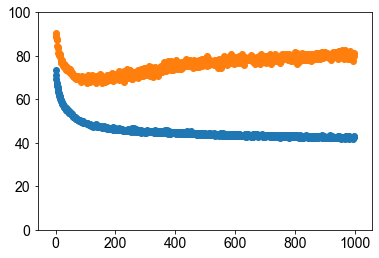

In [134]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [135]:
        #xnorm = scalerX.fit_transform(X)
        #ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[100], decoder_layer_sizes=[45], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=80
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 100]
decoder_layer_sizes [45]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/3, Loss:   75.8017, rec_loss:   75.7988, KL_loss:    0.0029
Epoch 00/1000 Batch 0003/3, Loss:   65.2408, rec_loss:   65.2382, KL_loss:    0.0026
Epoch 01/1000 Batch 0000/3, Loss:   65.0325, rec_loss:   65.0297, KL_loss:    0.0029
Epoch 01/1000 Batch 0003/3, Loss:   73.5771, rec_loss:   73.5742, KL_loss:    0.0029
Epoch 02/1000 Batch 0000/3, Loss:   65.5718, rec_loss:   65.5688, KL_loss:    0.0029
Epoch 02/1000 Batch 0003/3, Loss:   74.5298, rec_loss:   74.5269, KL_loss:    0.0029
Epoch 03/1000 Batch 0000/3, Loss:   64.4015, rec_loss:   64.3982, KL_loss:    0.0033
Epoch 03/1000 Batch 0003/3, Loss:   65.2995, rec_loss:   65.2963, KL_loss:    0.0032
Epoch 04/1000 Batch 0000/3, Loss:   71.5685, rec_loss:   71.5651, KL_loss:    0.0034
Epoch 04/1000 Batch 0003/3, Loss:   69.9677, rec_loss:   69.9642, KL_loss:    0.0034
Epoch 05/1000 Batch 0000/3, Loss:   71.0588

Epoch 50/1000 Batch 0003/3, Loss:   48.7724, rec_loss:   48.7506, KL_loss:    0.0218
Epoch 51/1000 Batch 0000/3, Loss:   51.0183, rec_loss:   50.9963, KL_loss:    0.0221
Epoch 51/1000 Batch 0003/3, Loss:   66.3154, rec_loss:   66.2914, KL_loss:    0.0240
Epoch 52/1000 Batch 0000/3, Loss:   60.1244, rec_loss:   60.1009, KL_loss:    0.0235
Epoch 52/1000 Batch 0003/3, Loss:   56.7383, rec_loss:   56.7172, KL_loss:    0.0211
Epoch 53/1000 Batch 0000/3, Loss:   46.3445, rec_loss:   46.3219, KL_loss:    0.0226
Epoch 53/1000 Batch 0003/3, Loss:   57.8820, rec_loss:   57.8602, KL_loss:    0.0218
Epoch 54/1000 Batch 0000/3, Loss:   60.8693, rec_loss:   60.8462, KL_loss:    0.0231
Epoch 54/1000 Batch 0003/3, Loss:   51.8473, rec_loss:   51.8224, KL_loss:    0.0249
Epoch 55/1000 Batch 0000/3, Loss:   56.8332, rec_loss:   56.8101, KL_loss:    0.0231
Epoch 55/1000 Batch 0003/3, Loss:   51.5062, rec_loss:   51.4830, KL_loss:    0.0232
Epoch 56/1000 Batch 0000/3, Loss:   56.1291, rec_loss:   56.1074,

Epoch 101/1000 Batch 0003/3, Loss:   59.8941, rec_loss:   59.8613, KL_loss:    0.0328
Epoch 102/1000 Batch 0000/3, Loss:   47.9605, rec_loss:   47.9255, KL_loss:    0.0350
Epoch 102/1000 Batch 0003/3, Loss:   55.3958, rec_loss:   55.3616, KL_loss:    0.0342
Epoch 103/1000 Batch 0000/3, Loss:   60.9809, rec_loss:   60.9480, KL_loss:    0.0329
Epoch 103/1000 Batch 0003/3, Loss:   50.6847, rec_loss:   50.6500, KL_loss:    0.0347
Epoch 104/1000 Batch 0000/3, Loss:   52.5540, rec_loss:   52.5215, KL_loss:    0.0325
Epoch 104/1000 Batch 0003/3, Loss:   48.8112, rec_loss:   48.7753, KL_loss:    0.0359
Epoch 105/1000 Batch 0000/3, Loss:   43.5724, rec_loss:   43.5377, KL_loss:    0.0348
Epoch 105/1000 Batch 0003/3, Loss:   53.8120, rec_loss:   53.7790, KL_loss:    0.0330
Epoch 106/1000 Batch 0000/3, Loss:   51.4638, rec_loss:   51.4296, KL_loss:    0.0342
Epoch 106/1000 Batch 0003/3, Loss:   53.4872, rec_loss:   53.4500, KL_loss:    0.0372
Epoch 107/1000 Batch 0000/3, Loss:   49.7703, rec_loss

Epoch 151/1000 Batch 0003/3, Loss:   53.1785, rec_loss:   53.1322, KL_loss:    0.0463
Epoch 152/1000 Batch 0000/3, Loss:   47.1493, rec_loss:   47.1002, KL_loss:    0.0492
Epoch 152/1000 Batch 0003/3, Loss:   46.7543, rec_loss:   46.7094, KL_loss:    0.0450
Epoch 153/1000 Batch 0000/3, Loss:   45.0741, rec_loss:   45.0283, KL_loss:    0.0458
Epoch 153/1000 Batch 0003/3, Loss:   42.1570, rec_loss:   42.1097, KL_loss:    0.0473
Epoch 154/1000 Batch 0000/3, Loss:   47.5454, rec_loss:   47.5004, KL_loss:    0.0450
Epoch 154/1000 Batch 0003/3, Loss:   41.3141, rec_loss:   41.2679, KL_loss:    0.0462
Epoch 155/1000 Batch 0000/3, Loss:   48.4015, rec_loss:   48.3578, KL_loss:    0.0436
Epoch 155/1000 Batch 0003/3, Loss:   46.0506, rec_loss:   46.0029, KL_loss:    0.0477
Epoch 156/1000 Batch 0000/3, Loss:   46.3054, rec_loss:   46.2613, KL_loss:    0.0441
Epoch 156/1000 Batch 0003/3, Loss:   56.6423, rec_loss:   56.5919, KL_loss:    0.0504
Epoch 157/1000 Batch 0000/3, Loss:   48.9422, rec_loss

Epoch 202/1000 Batch 0000/3, Loss:   37.6150, rec_loss:   37.5586, KL_loss:    0.0564
Epoch 202/1000 Batch 0003/3, Loss:   50.5196, rec_loss:   50.4676, KL_loss:    0.0520
Epoch 203/1000 Batch 0000/3, Loss:   44.0836, rec_loss:   44.0279, KL_loss:    0.0557
Epoch 203/1000 Batch 0003/3, Loss:   49.4570, rec_loss:   49.3997, KL_loss:    0.0573
Epoch 204/1000 Batch 0000/3, Loss:   47.4357, rec_loss:   47.3805, KL_loss:    0.0551
Epoch 204/1000 Batch 0003/3, Loss:   36.8562, rec_loss:   36.8002, KL_loss:    0.0560
Epoch 205/1000 Batch 0000/3, Loss:   48.8434, rec_loss:   48.7895, KL_loss:    0.0539
Epoch 205/1000 Batch 0003/3, Loss:   44.6571, rec_loss:   44.6038, KL_loss:    0.0533
Epoch 206/1000 Batch 0000/3, Loss:   41.4356, rec_loss:   41.3787, KL_loss:    0.0569
Epoch 206/1000 Batch 0003/3, Loss:   43.2664, rec_loss:   43.2090, KL_loss:    0.0574
Epoch 207/1000 Batch 0000/3, Loss:   48.9027, rec_loss:   48.8508, KL_loss:    0.0519
Epoch 207/1000 Batch 0003/3, Loss:   37.9223, rec_loss

Epoch 251/1000 Batch 0000/3, Loss:   41.9208, rec_loss:   41.8593, KL_loss:    0.0614
Epoch 251/1000 Batch 0003/3, Loss:   42.1185, rec_loss:   42.0607, KL_loss:    0.0578
Epoch 252/1000 Batch 0000/3, Loss:   45.8004, rec_loss:   45.7374, KL_loss:    0.0630
Epoch 252/1000 Batch 0003/3, Loss:   42.3779, rec_loss:   42.3158, KL_loss:    0.0621
Epoch 253/1000 Batch 0000/3, Loss:   43.0833, rec_loss:   43.0214, KL_loss:    0.0619
Epoch 253/1000 Batch 0003/3, Loss:   58.7781, rec_loss:   58.7155, KL_loss:    0.0626
Epoch 254/1000 Batch 0000/3, Loss:   48.8732, rec_loss:   48.8097, KL_loss:    0.0635
Epoch 254/1000 Batch 0003/3, Loss:   43.2087, rec_loss:   43.1491, KL_loss:    0.0596
Epoch 255/1000 Batch 0000/3, Loss:   47.4185, rec_loss:   47.3602, KL_loss:    0.0584
Epoch 255/1000 Batch 0003/3, Loss:   47.2823, rec_loss:   47.2186, KL_loss:    0.0637
Epoch 256/1000 Batch 0000/3, Loss:   50.3154, rec_loss:   50.2550, KL_loss:    0.0604
Epoch 256/1000 Batch 0003/3, Loss:   42.3273, rec_loss

Epoch 302/1000 Batch 0003/3, Loss:   42.5756, rec_loss:   42.5094, KL_loss:    0.0662
Epoch 303/1000 Batch 0000/3, Loss:   36.9868, rec_loss:   36.9199, KL_loss:    0.0669
Epoch 303/1000 Batch 0003/3, Loss:   47.5846, rec_loss:   47.5169, KL_loss:    0.0677
Epoch 304/1000 Batch 0000/3, Loss:   45.2886, rec_loss:   45.2233, KL_loss:    0.0653
Epoch 304/1000 Batch 0003/3, Loss:   36.8446, rec_loss:   36.7802, KL_loss:    0.0643
Epoch 305/1000 Batch 0000/3, Loss:   46.2637, rec_loss:   46.1970, KL_loss:    0.0667
Epoch 305/1000 Batch 0003/3, Loss:   45.5080, rec_loss:   45.4396, KL_loss:    0.0684
Epoch 306/1000 Batch 0000/3, Loss:   40.1228, rec_loss:   40.0548, KL_loss:    0.0680
Epoch 306/1000 Batch 0003/3, Loss:   57.0548, rec_loss:   56.9929, KL_loss:    0.0619
Epoch 307/1000 Batch 0000/3, Loss:   47.1447, rec_loss:   47.0750, KL_loss:    0.0698
Epoch 307/1000 Batch 0003/3, Loss:   53.2622, rec_loss:   53.2015, KL_loss:    0.0607
Epoch 308/1000 Batch 0000/3, Loss:   47.0353, rec_loss

Epoch 354/1000 Batch 0000/3, Loss:   42.0994, rec_loss:   42.0323, KL_loss:    0.0671
Epoch 354/1000 Batch 0003/3, Loss:   35.1370, rec_loss:   35.0658, KL_loss:    0.0713
Epoch 355/1000 Batch 0000/3, Loss:   47.3273, rec_loss:   47.2553, KL_loss:    0.0719
Epoch 355/1000 Batch 0003/3, Loss:   50.6019, rec_loss:   50.5285, KL_loss:    0.0735
Epoch 356/1000 Batch 0000/3, Loss:   40.5521, rec_loss:   40.4829, KL_loss:    0.0692
Epoch 356/1000 Batch 0003/3, Loss:   47.7844, rec_loss:   47.7099, KL_loss:    0.0745
Epoch 357/1000 Batch 0000/3, Loss:   49.1543, rec_loss:   49.0879, KL_loss:    0.0664
Epoch 357/1000 Batch 0003/3, Loss:   43.0044, rec_loss:   42.9259, KL_loss:    0.0786
Epoch 358/1000 Batch 0000/3, Loss:   45.7997, rec_loss:   45.7275, KL_loss:    0.0722
Epoch 358/1000 Batch 0003/3, Loss:   43.9287, rec_loss:   43.8580, KL_loss:    0.0707
Epoch 359/1000 Batch 0000/3, Loss:   39.9349, rec_loss:   39.8621, KL_loss:    0.0728
Epoch 359/1000 Batch 0003/3, Loss:   46.3537, rec_loss

Epoch 403/1000 Batch 0003/3, Loss:   38.8710, rec_loss:   38.7936, KL_loss:    0.0774
Epoch 404/1000 Batch 0000/3, Loss:   42.6267, rec_loss:   42.5537, KL_loss:    0.0729
Epoch 404/1000 Batch 0003/3, Loss:   46.5622, rec_loss:   46.4831, KL_loss:    0.0791
Epoch 405/1000 Batch 0000/3, Loss:   43.2164, rec_loss:   43.1416, KL_loss:    0.0747
Epoch 405/1000 Batch 0003/3, Loss:   42.0537, rec_loss:   41.9801, KL_loss:    0.0736
Epoch 406/1000 Batch 0000/3, Loss:   38.2798, rec_loss:   38.2003, KL_loss:    0.0795
Epoch 406/1000 Batch 0003/3, Loss:   45.3288, rec_loss:   45.2580, KL_loss:    0.0708
Epoch 407/1000 Batch 0000/3, Loss:   36.8891, rec_loss:   36.8142, KL_loss:    0.0750
Epoch 407/1000 Batch 0003/3, Loss:   46.0320, rec_loss:   45.9575, KL_loss:    0.0745
Epoch 408/1000 Batch 0000/3, Loss:   45.2034, rec_loss:   45.1294, KL_loss:    0.0739
Epoch 408/1000 Batch 0003/3, Loss:   53.8272, rec_loss:   53.7555, KL_loss:    0.0718
Epoch 409/1000 Batch 0000/3, Loss:   44.6081, rec_loss

Epoch 452/1000 Batch 0000/3, Loss:   42.6582, rec_loss:   42.5813, KL_loss:    0.0769
Epoch 452/1000 Batch 0003/3, Loss:   33.2217, rec_loss:   33.1432, KL_loss:    0.0786
Epoch 453/1000 Batch 0000/3, Loss:   39.4620, rec_loss:   39.3847, KL_loss:    0.0773
Epoch 453/1000 Batch 0003/3, Loss:   46.9401, rec_loss:   46.8620, KL_loss:    0.0780
Epoch 454/1000 Batch 0000/3, Loss:   43.3147, rec_loss:   43.2383, KL_loss:    0.0764
Epoch 454/1000 Batch 0003/3, Loss:   45.4686, rec_loss:   45.3911, KL_loss:    0.0775
Epoch 455/1000 Batch 0000/3, Loss:   39.4526, rec_loss:   39.3781, KL_loss:    0.0745
Epoch 455/1000 Batch 0003/3, Loss:   50.7655, rec_loss:   50.6850, KL_loss:    0.0805
Epoch 456/1000 Batch 0000/3, Loss:   43.6594, rec_loss:   43.5817, KL_loss:    0.0776
Epoch 456/1000 Batch 0003/3, Loss:   36.9479, rec_loss:   36.8681, KL_loss:    0.0798
Epoch 457/1000 Batch 0000/3, Loss:   37.6752, rec_loss:   37.5938, KL_loss:    0.0815
Epoch 457/1000 Batch 0003/3, Loss:   48.1020, rec_loss

Epoch 501/1000 Batch 0003/3, Loss:   48.1455, rec_loss:   48.0659, KL_loss:    0.0796
Epoch 502/1000 Batch 0000/3, Loss:   42.6774, rec_loss:   42.5989, KL_loss:    0.0785
Epoch 502/1000 Batch 0003/3, Loss:   49.7855, rec_loss:   49.7084, KL_loss:    0.0771
Epoch 503/1000 Batch 0000/3, Loss:   42.1237, rec_loss:   42.0469, KL_loss:    0.0768
Epoch 503/1000 Batch 0003/3, Loss:   43.8555, rec_loss:   43.7756, KL_loss:    0.0799
Epoch 504/1000 Batch 0000/3, Loss:   40.9818, rec_loss:   40.9024, KL_loss:    0.0794
Epoch 504/1000 Batch 0003/3, Loss:   45.0050, rec_loss:   44.9245, KL_loss:    0.0805
Epoch 505/1000 Batch 0000/3, Loss:   48.9635, rec_loss:   48.8874, KL_loss:    0.0761
Epoch 505/1000 Batch 0003/3, Loss:   43.8637, rec_loss:   43.7791, KL_loss:    0.0846
Epoch 506/1000 Batch 0000/3, Loss:   41.7886, rec_loss:   41.7111, KL_loss:    0.0775
Epoch 506/1000 Batch 0003/3, Loss:   44.3587, rec_loss:   44.2765, KL_loss:    0.0822
Epoch 507/1000 Batch 0000/3, Loss:   48.8091, rec_loss

Epoch 550/1000 Batch 0003/3, Loss:   40.7193, rec_loss:   40.6367, KL_loss:    0.0826
Epoch 551/1000 Batch 0000/3, Loss:   33.7164, rec_loss:   33.6287, KL_loss:    0.0877
Epoch 551/1000 Batch 0003/3, Loss:   46.9088, rec_loss:   46.8274, KL_loss:    0.0814
Epoch 552/1000 Batch 0000/3, Loss:   40.8251, rec_loss:   40.7451, KL_loss:    0.0800
Epoch 552/1000 Batch 0003/3, Loss:   42.8414, rec_loss:   42.7545, KL_loss:    0.0869
Epoch 553/1000 Batch 0000/3, Loss:   40.8521, rec_loss:   40.7697, KL_loss:    0.0824
Epoch 553/1000 Batch 0003/3, Loss:   43.7488, rec_loss:   43.6639, KL_loss:    0.0850
Epoch 554/1000 Batch 0000/3, Loss:   49.0894, rec_loss:   49.0099, KL_loss:    0.0794
Epoch 554/1000 Batch 0003/3, Loss:   39.8826, rec_loss:   39.7991, KL_loss:    0.0834
Epoch 555/1000 Batch 0000/3, Loss:   44.1595, rec_loss:   44.0774, KL_loss:    0.0821
Epoch 555/1000 Batch 0003/3, Loss:   36.9222, rec_loss:   36.8369, KL_loss:    0.0853
Epoch 556/1000 Batch 0000/3, Loss:   42.0538, rec_loss

Epoch 598/1000 Batch 0003/3, Loss:   36.0756, rec_loss:   35.9905, KL_loss:    0.0851
Epoch 599/1000 Batch 0000/3, Loss:   39.0581, rec_loss:   38.9743, KL_loss:    0.0838
Epoch 599/1000 Batch 0003/3, Loss:   47.8169, rec_loss:   47.7310, KL_loss:    0.0859
Epoch 600/1000 Batch 0000/3, Loss:   48.4395, rec_loss:   48.3564, KL_loss:    0.0831
Epoch 600/1000 Batch 0003/3, Loss:   36.7165, rec_loss:   36.6305, KL_loss:    0.0860
Epoch 601/1000 Batch 0000/3, Loss:   41.3335, rec_loss:   41.2470, KL_loss:    0.0865
Epoch 601/1000 Batch 0003/3, Loss:   38.8975, rec_loss:   38.8134, KL_loss:    0.0841
Epoch 602/1000 Batch 0000/3, Loss:   36.9798, rec_loss:   36.8934, KL_loss:    0.0864
Epoch 602/1000 Batch 0003/3, Loss:   34.6930, rec_loss:   34.6051, KL_loss:    0.0878
Epoch 603/1000 Batch 0000/3, Loss:   38.0866, rec_loss:   37.9991, KL_loss:    0.0875
Epoch 603/1000 Batch 0003/3, Loss:   39.4547, rec_loss:   39.3703, KL_loss:    0.0844
Epoch 604/1000 Batch 0000/3, Loss:   43.0753, rec_loss

Epoch 647/1000 Batch 0000/3, Loss:   43.8434, rec_loss:   43.7583, KL_loss:    0.0851
Epoch 647/1000 Batch 0003/3, Loss:   42.0762, rec_loss:   41.9872, KL_loss:    0.0890
Epoch 648/1000 Batch 0000/3, Loss:   38.6968, rec_loss:   38.6101, KL_loss:    0.0867
Epoch 648/1000 Batch 0003/3, Loss:   46.1352, rec_loss:   46.0490, KL_loss:    0.0862
Epoch 649/1000 Batch 0000/3, Loss:   39.1458, rec_loss:   39.0572, KL_loss:    0.0886
Epoch 649/1000 Batch 0003/3, Loss:   42.9387, rec_loss:   42.8558, KL_loss:    0.0829
Epoch 650/1000 Batch 0000/3, Loss:   45.0208, rec_loss:   44.9332, KL_loss:    0.0876
Epoch 650/1000 Batch 0003/3, Loss:   42.8055, rec_loss:   42.7166, KL_loss:    0.0889
Epoch 651/1000 Batch 0000/3, Loss:   46.6257, rec_loss:   46.5434, KL_loss:    0.0823
Epoch 651/1000 Batch 0003/3, Loss:   38.7787, rec_loss:   38.6902, KL_loss:    0.0885
Epoch 652/1000 Batch 0000/3, Loss:   41.8404, rec_loss:   41.7501, KL_loss:    0.0903
Epoch 652/1000 Batch 0003/3, Loss:   41.8358, rec_loss

Epoch 695/1000 Batch 0000/3, Loss:   36.8326, rec_loss:   36.7411, KL_loss:    0.0915
Epoch 695/1000 Batch 0003/3, Loss:   35.6254, rec_loss:   35.5351, KL_loss:    0.0903
Epoch 696/1000 Batch 0000/3, Loss:   42.7157, rec_loss:   42.6264, KL_loss:    0.0894
Epoch 696/1000 Batch 0003/3, Loss:   42.4155, rec_loss:   42.3286, KL_loss:    0.0869
Epoch 697/1000 Batch 0000/3, Loss:   48.6660, rec_loss:   48.5795, KL_loss:    0.0864
Epoch 697/1000 Batch 0003/3, Loss:   41.0085, rec_loss:   40.9183, KL_loss:    0.0902
Epoch 698/1000 Batch 0000/3, Loss:   34.2713, rec_loss:   34.1802, KL_loss:    0.0912
Epoch 698/1000 Batch 0003/3, Loss:   45.6305, rec_loss:   45.5409, KL_loss:    0.0896
Epoch 699/1000 Batch 0000/3, Loss:   41.7246, rec_loss:   41.6330, KL_loss:    0.0916
Epoch 699/1000 Batch 0003/3, Loss:   39.6513, rec_loss:   39.5629, KL_loss:    0.0885
Epoch 700/1000 Batch 0000/3, Loss:   42.3324, rec_loss:   42.2422, KL_loss:    0.0902
Epoch 700/1000 Batch 0003/3, Loss:   43.9149, rec_loss

Epoch 745/1000 Batch 0000/3, Loss:   41.4222, rec_loss:   41.3323, KL_loss:    0.0899
Epoch 745/1000 Batch 0003/3, Loss:   46.5797, rec_loss:   46.4920, KL_loss:    0.0877
Epoch 746/1000 Batch 0000/3, Loss:   43.8674, rec_loss:   43.7786, KL_loss:    0.0888
Epoch 746/1000 Batch 0003/3, Loss:   43.6761, rec_loss:   43.5877, KL_loss:    0.0883
Epoch 747/1000 Batch 0000/3, Loss:   38.1284, rec_loss:   38.0425, KL_loss:    0.0860
Epoch 747/1000 Batch 0003/3, Loss:   45.6428, rec_loss:   45.5530, KL_loss:    0.0897
Epoch 748/1000 Batch 0000/3, Loss:   38.6266, rec_loss:   38.5350, KL_loss:    0.0916
Epoch 748/1000 Batch 0003/3, Loss:   38.3786, rec_loss:   38.2884, KL_loss:    0.0902
Epoch 749/1000 Batch 0000/3, Loss:   45.0882, rec_loss:   44.9989, KL_loss:    0.0893
Epoch 749/1000 Batch 0003/3, Loss:   44.8548, rec_loss:   44.7632, KL_loss:    0.0916
Epoch 750/1000 Batch 0000/3, Loss:   39.6096, rec_loss:   39.5179, KL_loss:    0.0917
Epoch 750/1000 Batch 0003/3, Loss:   40.2546, rec_loss

Epoch 793/1000 Batch 0003/3, Loss:   38.3602, rec_loss:   38.2662, KL_loss:    0.0941
Epoch 794/1000 Batch 0000/3, Loss:   43.6459, rec_loss:   43.5551, KL_loss:    0.0908
Epoch 794/1000 Batch 0003/3, Loss:   44.0186, rec_loss:   43.9282, KL_loss:    0.0904
Epoch 795/1000 Batch 0000/3, Loss:   35.2070, rec_loss:   35.1142, KL_loss:    0.0928
Epoch 795/1000 Batch 0003/3, Loss:   43.7499, rec_loss:   43.6575, KL_loss:    0.0924
Epoch 796/1000 Batch 0000/3, Loss:   35.3573, rec_loss:   35.2623, KL_loss:    0.0951
Epoch 796/1000 Batch 0003/3, Loss:   50.5884, rec_loss:   50.4976, KL_loss:    0.0908
Epoch 797/1000 Batch 0000/3, Loss:   40.7458, rec_loss:   40.6524, KL_loss:    0.0934
Epoch 797/1000 Batch 0003/3, Loss:   37.5016, rec_loss:   37.4073, KL_loss:    0.0942
Epoch 798/1000 Batch 0000/3, Loss:   40.2243, rec_loss:   40.1322, KL_loss:    0.0921
Epoch 798/1000 Batch 0003/3, Loss:   38.4224, rec_loss:   38.3355, KL_loss:    0.0869
Epoch 799/1000 Batch 0000/3, Loss:   41.3876, rec_loss

Epoch 842/1000 Batch 0000/3, Loss:   41.9496, rec_loss:   41.8531, KL_loss:    0.0965
Epoch 842/1000 Batch 0003/3, Loss:   38.5271, rec_loss:   38.4392, KL_loss:    0.0879
Epoch 843/1000 Batch 0000/3, Loss:   32.9747, rec_loss:   32.8792, KL_loss:    0.0956
Epoch 843/1000 Batch 0003/3, Loss:   42.3343, rec_loss:   42.2460, KL_loss:    0.0883
Epoch 844/1000 Batch 0000/3, Loss:   41.8504, rec_loss:   41.7529, KL_loss:    0.0975
Epoch 844/1000 Batch 0003/3, Loss:   45.0864, rec_loss:   44.9958, KL_loss:    0.0906
Epoch 845/1000 Batch 0000/3, Loss:   38.4359, rec_loss:   38.3361, KL_loss:    0.0998
Epoch 845/1000 Batch 0003/3, Loss:   33.5653, rec_loss:   33.4733, KL_loss:    0.0920
Epoch 846/1000 Batch 0000/3, Loss:   42.9938, rec_loss:   42.9015, KL_loss:    0.0923
Epoch 846/1000 Batch 0003/3, Loss:   48.6099, rec_loss:   48.5204, KL_loss:    0.0894
Epoch 847/1000 Batch 0000/3, Loss:   45.8700, rec_loss:   45.7787, KL_loss:    0.0912
Epoch 847/1000 Batch 0003/3, Loss:   42.1496, rec_loss

Epoch 890/1000 Batch 0000/3, Loss:   32.1921, rec_loss:   32.0944, KL_loss:    0.0977
Epoch 890/1000 Batch 0003/3, Loss:   49.2767, rec_loss:   49.1857, KL_loss:    0.0910
Epoch 891/1000 Batch 0000/3, Loss:   45.3016, rec_loss:   45.2074, KL_loss:    0.0942
Epoch 891/1000 Batch 0003/3, Loss:   38.5443, rec_loss:   38.4466, KL_loss:    0.0976
Epoch 892/1000 Batch 0000/3, Loss:   39.6102, rec_loss:   39.5139, KL_loss:    0.0964
Epoch 892/1000 Batch 0003/3, Loss:   52.9750, rec_loss:   52.8881, KL_loss:    0.0868
Epoch 893/1000 Batch 0000/3, Loss:   37.1438, rec_loss:   37.0469, KL_loss:    0.0968
Epoch 893/1000 Batch 0003/3, Loss:   47.1356, rec_loss:   47.0402, KL_loss:    0.0954
Epoch 894/1000 Batch 0000/3, Loss:   35.4389, rec_loss:   35.3413, KL_loss:    0.0975
Epoch 894/1000 Batch 0003/3, Loss:   47.9655, rec_loss:   47.8766, KL_loss:    0.0889
Epoch 895/1000 Batch 0000/3, Loss:   37.3601, rec_loss:   37.2631, KL_loss:    0.0970
Epoch 895/1000 Batch 0003/3, Loss:   44.2753, rec_loss

Epoch 940/1000 Batch 0000/3, Loss:   43.4142, rec_loss:   43.3168, KL_loss:    0.0974
Epoch 940/1000 Batch 0003/3, Loss:   47.9557, rec_loss:   47.8591, KL_loss:    0.0966
Epoch 941/1000 Batch 0000/3, Loss:   39.4724, rec_loss:   39.3755, KL_loss:    0.0969
Epoch 941/1000 Batch 0003/3, Loss:   34.9659, rec_loss:   34.8657, KL_loss:    0.1002
Epoch 942/1000 Batch 0000/3, Loss:   37.7763, rec_loss:   37.6796, KL_loss:    0.0967
Epoch 942/1000 Batch 0003/3, Loss:   43.9224, rec_loss:   43.8288, KL_loss:    0.0936
Epoch 943/1000 Batch 0000/3, Loss:   45.4417, rec_loss:   45.3482, KL_loss:    0.0935
Epoch 943/1000 Batch 0003/3, Loss:   38.8300, rec_loss:   38.7315, KL_loss:    0.0985
Epoch 944/1000 Batch 0000/3, Loss:   44.8647, rec_loss:   44.7709, KL_loss:    0.0938
Epoch 944/1000 Batch 0003/3, Loss:   44.8601, rec_loss:   44.7615, KL_loss:    0.0986
Epoch 945/1000 Batch 0000/3, Loss:   34.1733, rec_loss:   34.0760, KL_loss:    0.0973
Epoch 945/1000 Batch 0003/3, Loss:   45.4187, rec_loss

Epoch 988/1000 Batch 0003/3, Loss:   43.5461, rec_loss:   43.4487, KL_loss:    0.0974
Epoch 989/1000 Batch 0000/3, Loss:   41.4502, rec_loss:   41.3525, KL_loss:    0.0977
Epoch 989/1000 Batch 0003/3, Loss:   39.7986, rec_loss:   39.6974, KL_loss:    0.1012
Epoch 990/1000 Batch 0000/3, Loss:   42.0722, rec_loss:   41.9743, KL_loss:    0.0979
Epoch 990/1000 Batch 0003/3, Loss:   33.1999, rec_loss:   33.0996, KL_loss:    0.1003
Epoch 991/1000 Batch 0000/3, Loss:   40.0263, rec_loss:   39.9304, KL_loss:    0.0959
Epoch 991/1000 Batch 0003/3, Loss:   46.8641, rec_loss:   46.7655, KL_loss:    0.0987
Epoch 992/1000 Batch 0000/3, Loss:   41.2616, rec_loss:   41.1635, KL_loss:    0.0981
Epoch 992/1000 Batch 0003/3, Loss:   39.3318, rec_loss:   39.2323, KL_loss:    0.0995
Epoch 993/1000 Batch 0000/3, Loss:   40.0604, rec_loss:   39.9635, KL_loss:    0.0969
Epoch 993/1000 Batch 0003/3, Loss:   35.5560, rec_loss:   35.4555, KL_loss:    0.1005
Epoch 994/1000 Batch 0000/3, Loss:   42.1855, rec_loss

(0, 100)

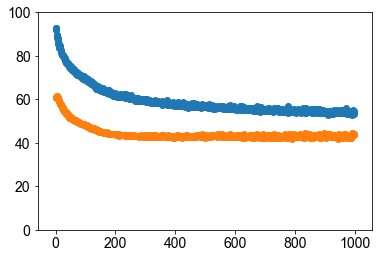

In [137]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [138]:
        #xnorm = scalerX.fit_transform(X)
        #ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[120], decoder_layer_sizes=[80], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=80
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss / iteration)
            self.logs["rec_loss_train"].append(train_rec / iteration)
            self.logs["KL_loss_train"].append(train_kl / iteration)
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 120]
decoder_layer_sizes [80]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/3, Loss:   69.6017, rec_loss:   69.5994, KL_loss:    0.0023
Epoch 00/1000 Batch 0003/3, Loss:   71.7986, rec_loss:   71.7963, KL_loss:    0.0022
Epoch 01/1000 Batch 0000/3, Loss:   67.7017, rec_loss:   67.6993, KL_loss:    0.0025
Epoch 01/1000 Batch 0003/3, Loss:   68.1605, rec_loss:   68.1582, KL_loss:    0.0022
Epoch 02/1000 Batch 0000/3, Loss:   66.4717, rec_loss:   66.4693, KL_loss:    0.0024
Epoch 02/1000 Batch 0003/3, Loss:   71.0233, rec_loss:   71.0207, KL_loss:    0.0026
Epoch 03/1000 Batch 0000/3, Loss:   63.5485, rec_loss:   63.5459, KL_loss:    0.0026
Epoch 03/1000 Batch 0003/3, Loss:   71.6618, rec_loss:   71.6590, KL_loss:    0.0027
Epoch 04/1000 Batch 0000/3, Loss:   68.4646, rec_loss:   68.4621, KL_loss:    0.0025
Epoch 04/1000 Batch 0003/3, Loss:   66.8415, rec_loss:   66.8387, KL_loss:    0.0028
Epoch 05/1000 Batch 0000/3, Loss:   64.8798

Epoch 50/1000 Batch 0000/3, Loss:   55.7309, rec_loss:   55.7066, KL_loss:    0.0243
Epoch 50/1000 Batch 0003/3, Loss:   52.9944, rec_loss:   52.9689, KL_loss:    0.0255
Epoch 51/1000 Batch 0000/3, Loss:   45.4756, rec_loss:   45.4503, KL_loss:    0.0253
Epoch 51/1000 Batch 0003/3, Loss:   54.2091, rec_loss:   54.1813, KL_loss:    0.0278
Epoch 52/1000 Batch 0000/3, Loss:   52.2524, rec_loss:   52.2270, KL_loss:    0.0254
Epoch 52/1000 Batch 0003/3, Loss:   54.3999, rec_loss:   54.3709, KL_loss:    0.0290
Epoch 53/1000 Batch 0000/3, Loss:   46.4107, rec_loss:   46.3824, KL_loss:    0.0282
Epoch 53/1000 Batch 0003/3, Loss:   54.8828, rec_loss:   54.8558, KL_loss:    0.0270
Epoch 54/1000 Batch 0000/3, Loss:   56.6631, rec_loss:   56.6346, KL_loss:    0.0284
Epoch 54/1000 Batch 0003/3, Loss:   56.1825, rec_loss:   56.1585, KL_loss:    0.0240
Epoch 55/1000 Batch 0000/3, Loss:   56.8608, rec_loss:   56.8326, KL_loss:    0.0282
Epoch 55/1000 Batch 0003/3, Loss:   54.7758, rec_loss:   54.7476,

Epoch 100/1000 Batch 0000/3, Loss:   54.9079, rec_loss:   54.8697, KL_loss:    0.0382
Epoch 100/1000 Batch 0003/3, Loss:   59.7252, rec_loss:   59.6871, KL_loss:    0.0381
Epoch 101/1000 Batch 0000/3, Loss:   54.8043, rec_loss:   54.7652, KL_loss:    0.0391
Epoch 101/1000 Batch 0003/3, Loss:   48.1683, rec_loss:   48.1267, KL_loss:    0.0416
Epoch 102/1000 Batch 0000/3, Loss:   48.7339, rec_loss:   48.6944, KL_loss:    0.0395
Epoch 102/1000 Batch 0003/3, Loss:   52.4623, rec_loss:   52.4233, KL_loss:    0.0390
Epoch 103/1000 Batch 0000/3, Loss:   58.4072, rec_loss:   58.3668, KL_loss:    0.0404
Epoch 103/1000 Batch 0003/3, Loss:   42.2303, rec_loss:   42.1880, KL_loss:    0.0423
Epoch 104/1000 Batch 0000/3, Loss:   45.3088, rec_loss:   45.2666, KL_loss:    0.0422
Epoch 104/1000 Batch 0003/3, Loss:   51.0920, rec_loss:   51.0537, KL_loss:    0.0383
Epoch 105/1000 Batch 0000/3, Loss:   59.7523, rec_loss:   59.7155, KL_loss:    0.0368
Epoch 105/1000 Batch 0003/3, Loss:   45.1706, rec_loss

Epoch 149/1000 Batch 0003/3, Loss:   40.1180, rec_loss:   40.0658, KL_loss:    0.0522
Epoch 150/1000 Batch 0000/3, Loss:   44.7869, rec_loss:   44.7358, KL_loss:    0.0511
Epoch 150/1000 Batch 0003/3, Loss:   52.0361, rec_loss:   51.9839, KL_loss:    0.0522
Epoch 151/1000 Batch 0000/3, Loss:   51.7368, rec_loss:   51.6890, KL_loss:    0.0479
Epoch 151/1000 Batch 0003/3, Loss:   50.5035, rec_loss:   50.4520, KL_loss:    0.0514
Epoch 152/1000 Batch 0000/3, Loss:   43.6003, rec_loss:   43.5473, KL_loss:    0.0530
Epoch 152/1000 Batch 0003/3, Loss:   51.6467, rec_loss:   51.5959, KL_loss:    0.0509
Epoch 153/1000 Batch 0000/3, Loss:   41.1647, rec_loss:   41.1090, KL_loss:    0.0557
Epoch 153/1000 Batch 0003/3, Loss:   52.6185, rec_loss:   52.5661, KL_loss:    0.0524
Epoch 154/1000 Batch 0000/3, Loss:   46.5487, rec_loss:   46.4943, KL_loss:    0.0543
Epoch 154/1000 Batch 0003/3, Loss:   45.0541, rec_loss:   45.0017, KL_loss:    0.0524
Epoch 155/1000 Batch 0000/3, Loss:   49.4831, rec_loss

Epoch 198/1000 Batch 0003/3, Loss:   41.7566, rec_loss:   41.6963, KL_loss:    0.0604
Epoch 199/1000 Batch 0000/3, Loss:   54.2832, rec_loss:   54.2280, KL_loss:    0.0551
Epoch 199/1000 Batch 0003/3, Loss:   46.7438, rec_loss:   46.6840, KL_loss:    0.0599
Epoch 200/1000 Batch 0000/3, Loss:   51.4828, rec_loss:   51.4210, KL_loss:    0.0619
Epoch 200/1000 Batch 0003/3, Loss:   37.9764, rec_loss:   37.9164, KL_loss:    0.0600
Epoch 201/1000 Batch 0000/3, Loss:   54.5444, rec_loss:   54.4839, KL_loss:    0.0605
Epoch 201/1000 Batch 0003/3, Loss:   42.0237, rec_loss:   41.9632, KL_loss:    0.0604
Epoch 202/1000 Batch 0000/3, Loss:   40.3754, rec_loss:   40.3115, KL_loss:    0.0639
Epoch 202/1000 Batch 0003/3, Loss:   48.3413, rec_loss:   48.2837, KL_loss:    0.0576
Epoch 203/1000 Batch 0000/3, Loss:   45.7128, rec_loss:   45.6490, KL_loss:    0.0638
Epoch 203/1000 Batch 0003/3, Loss:   51.0717, rec_loss:   51.0110, KL_loss:    0.0607
Epoch 204/1000 Batch 0000/3, Loss:   43.6297, rec_loss

Epoch 248/1000 Batch 0000/3, Loss:   42.5846, rec_loss:   42.5212, KL_loss:    0.0634
Epoch 248/1000 Batch 0003/3, Loss:   56.3454, rec_loss:   56.2819, KL_loss:    0.0635
Epoch 249/1000 Batch 0000/3, Loss:   47.6485, rec_loss:   47.5864, KL_loss:    0.0622
Epoch 249/1000 Batch 0003/3, Loss:   41.8893, rec_loss:   41.8220, KL_loss:    0.0673
Epoch 250/1000 Batch 0000/3, Loss:   38.0879, rec_loss:   38.0216, KL_loss:    0.0663
Epoch 250/1000 Batch 0003/3, Loss:   49.5413, rec_loss:   49.4755, KL_loss:    0.0658
Epoch 251/1000 Batch 0000/3, Loss:   41.9746, rec_loss:   41.9099, KL_loss:    0.0648
Epoch 251/1000 Batch 0003/3, Loss:   49.8523, rec_loss:   49.7887, KL_loss:    0.0637
Epoch 252/1000 Batch 0000/3, Loss:   44.0525, rec_loss:   43.9863, KL_loss:    0.0661
Epoch 252/1000 Batch 0003/3, Loss:   48.1084, rec_loss:   48.0400, KL_loss:    0.0684
Epoch 253/1000 Batch 0000/3, Loss:   42.4861, rec_loss:   42.4206, KL_loss:    0.0655
Epoch 253/1000 Batch 0003/3, Loss:   41.9947, rec_loss

Epoch 297/1000 Batch 0003/3, Loss:   46.2531, rec_loss:   46.1830, KL_loss:    0.0701
Epoch 298/1000 Batch 0000/3, Loss:   50.7833, rec_loss:   50.7166, KL_loss:    0.0667
Epoch 298/1000 Batch 0003/3, Loss:   35.5838, rec_loss:   35.5108, KL_loss:    0.0730
Epoch 299/1000 Batch 0000/3, Loss:   42.5518, rec_loss:   42.4832, KL_loss:    0.0686
Epoch 299/1000 Batch 0003/3, Loss:   44.6354, rec_loss:   44.5687, KL_loss:    0.0667
Epoch 300/1000 Batch 0000/3, Loss:   43.5782, rec_loss:   43.5111, KL_loss:    0.0671
Epoch 300/1000 Batch 0003/3, Loss:   50.3993, rec_loss:   50.3279, KL_loss:    0.0714
Epoch 301/1000 Batch 0000/3, Loss:   42.7414, rec_loss:   42.6710, KL_loss:    0.0704
Epoch 301/1000 Batch 0003/3, Loss:   45.5904, rec_loss:   45.5228, KL_loss:    0.0676
Epoch 302/1000 Batch 0000/3, Loss:   37.1724, rec_loss:   37.1039, KL_loss:    0.0685
Epoch 302/1000 Batch 0003/3, Loss:   49.8850, rec_loss:   49.8187, KL_loss:    0.0663
Epoch 303/1000 Batch 0000/3, Loss:   39.0323, rec_loss

Epoch 347/1000 Batch 0000/3, Loss:   39.3961, rec_loss:   39.3232, KL_loss:    0.0730
Epoch 347/1000 Batch 0003/3, Loss:   48.7633, rec_loss:   48.6919, KL_loss:    0.0714
Epoch 348/1000 Batch 0000/3, Loss:   41.7646, rec_loss:   41.6902, KL_loss:    0.0743
Epoch 348/1000 Batch 0003/3, Loss:   37.3751, rec_loss:   37.3027, KL_loss:    0.0724
Epoch 349/1000 Batch 0000/3, Loss:   44.1972, rec_loss:   44.1221, KL_loss:    0.0751
Epoch 349/1000 Batch 0003/3, Loss:   41.6295, rec_loss:   41.5613, KL_loss:    0.0681
Epoch 350/1000 Batch 0000/3, Loss:   44.5739, rec_loss:   44.5006, KL_loss:    0.0733
Epoch 350/1000 Batch 0003/3, Loss:   40.4758, rec_loss:   40.4028, KL_loss:    0.0729
Epoch 351/1000 Batch 0000/3, Loss:   35.6092, rec_loss:   35.5346, KL_loss:    0.0747
Epoch 351/1000 Batch 0003/3, Loss:   52.9771, rec_loss:   52.9040, KL_loss:    0.0731
Epoch 352/1000 Batch 0000/3, Loss:   40.9854, rec_loss:   40.9148, KL_loss:    0.0706
Epoch 352/1000 Batch 0003/3, Loss:   52.1974, rec_loss

Epoch 396/1000 Batch 0003/3, Loss:   43.2219, rec_loss:   43.1450, KL_loss:    0.0769
Epoch 397/1000 Batch 0000/3, Loss:   48.9726, rec_loss:   48.8977, KL_loss:    0.0749
Epoch 397/1000 Batch 0003/3, Loss:   40.5218, rec_loss:   40.4431, KL_loss:    0.0788
Epoch 398/1000 Batch 0000/3, Loss:   48.6043, rec_loss:   48.5329, KL_loss:    0.0714
Epoch 398/1000 Batch 0003/3, Loss:   40.8361, rec_loss:   40.7570, KL_loss:    0.0792
Epoch 399/1000 Batch 0000/3, Loss:   35.7637, rec_loss:   35.6845, KL_loss:    0.0792
Epoch 399/1000 Batch 0003/3, Loss:   41.5305, rec_loss:   41.4542, KL_loss:    0.0762
Epoch 400/1000 Batch 0000/3, Loss:   53.9139, rec_loss:   53.8405, KL_loss:    0.0733
Epoch 400/1000 Batch 0003/3, Loss:   42.6308, rec_loss:   42.5588, KL_loss:    0.0720
Epoch 401/1000 Batch 0000/3, Loss:   36.6719, rec_loss:   36.5960, KL_loss:    0.0759
Epoch 401/1000 Batch 0003/3, Loss:   43.7980, rec_loss:   43.7190, KL_loss:    0.0791
Epoch 402/1000 Batch 0000/3, Loss:   49.9054, rec_loss

Epoch 444/1000 Batch 0003/3, Loss:   45.1198, rec_loss:   45.0400, KL_loss:    0.0798
Epoch 445/1000 Batch 0000/3, Loss:   43.6618, rec_loss:   43.5807, KL_loss:    0.0811
Epoch 445/1000 Batch 0003/3, Loss:   37.5270, rec_loss:   37.4433, KL_loss:    0.0838
Epoch 446/1000 Batch 0000/3, Loss:   44.8775, rec_loss:   44.8025, KL_loss:    0.0750
Epoch 446/1000 Batch 0003/3, Loss:   45.6630, rec_loss:   45.5833, KL_loss:    0.0797
Epoch 447/1000 Batch 0000/3, Loss:   43.9176, rec_loss:   43.8411, KL_loss:    0.0765
Epoch 447/1000 Batch 0003/3, Loss:   36.8742, rec_loss:   36.7930, KL_loss:    0.0812
Epoch 448/1000 Batch 0000/3, Loss:   36.1050, rec_loss:   36.0247, KL_loss:    0.0803
Epoch 448/1000 Batch 0003/3, Loss:   41.1457, rec_loss:   41.0678, KL_loss:    0.0779
Epoch 449/1000 Batch 0000/3, Loss:   36.9273, rec_loss:   36.8469, KL_loss:    0.0804
Epoch 449/1000 Batch 0003/3, Loss:   48.2812, rec_loss:   48.2037, KL_loss:    0.0774
Epoch 450/1000 Batch 0000/3, Loss:   49.3874, rec_loss

Epoch 496/1000 Batch 0003/3, Loss:   43.3720, rec_loss:   43.2877, KL_loss:    0.0842
Epoch 497/1000 Batch 0000/3, Loss:   31.7056, rec_loss:   31.6249, KL_loss:    0.0808
Epoch 497/1000 Batch 0003/3, Loss:   46.2571, rec_loss:   46.1766, KL_loss:    0.0805
Epoch 498/1000 Batch 0000/3, Loss:   43.4614, rec_loss:   43.3773, KL_loss:    0.0842
Epoch 498/1000 Batch 0003/3, Loss:   38.6747, rec_loss:   38.5904, KL_loss:    0.0843
Epoch 499/1000 Batch 0000/3, Loss:   37.2994, rec_loss:   37.2140, KL_loss:    0.0854
Epoch 499/1000 Batch 0003/3, Loss:   60.5219, rec_loss:   60.4489, KL_loss:    0.0730
Epoch 500/1000 Batch 0000/3, Loss:   42.8695, rec_loss:   42.7906, KL_loss:    0.0789
Epoch 500/1000 Batch 0003/3, Loss:   41.6737, rec_loss:   41.5907, KL_loss:    0.0829
Epoch 501/1000 Batch 0000/3, Loss:   42.0803, rec_loss:   42.0006, KL_loss:    0.0797
Epoch 501/1000 Batch 0003/3, Loss:   45.0530, rec_loss:   44.9707, KL_loss:    0.0822
Epoch 502/1000 Batch 0000/3, Loss:   36.9839, rec_loss

Epoch 546/1000 Batch 0000/3, Loss:   47.4854, rec_loss:   47.4027, KL_loss:    0.0827
Epoch 546/1000 Batch 0003/3, Loss:   40.8086, rec_loss:   40.7245, KL_loss:    0.0841
Epoch 547/1000 Batch 0000/3, Loss:   38.6080, rec_loss:   38.5251, KL_loss:    0.0829
Epoch 547/1000 Batch 0003/3, Loss:   48.7592, rec_loss:   48.6728, KL_loss:    0.0865
Epoch 548/1000 Batch 0000/3, Loss:   48.1473, rec_loss:   48.0604, KL_loss:    0.0869
Epoch 548/1000 Batch 0003/3, Loss:   39.5844, rec_loss:   39.4973, KL_loss:    0.0870
Epoch 549/1000 Batch 0000/3, Loss:   48.5767, rec_loss:   48.4952, KL_loss:    0.0815
Epoch 549/1000 Batch 0003/3, Loss:   30.6793, rec_loss:   30.5889, KL_loss:    0.0904
Epoch 550/1000 Batch 0000/3, Loss:   46.2678, rec_loss:   46.1858, KL_loss:    0.0820
Epoch 550/1000 Batch 0003/3, Loss:   37.6096, rec_loss:   37.5241, KL_loss:    0.0855
Epoch 551/1000 Batch 0000/3, Loss:   44.7626, rec_loss:   44.6781, KL_loss:    0.0845
Epoch 551/1000 Batch 0003/3, Loss:   51.1098, rec_loss

Epoch 595/1000 Batch 0000/3, Loss:   43.2278, rec_loss:   43.1403, KL_loss:    0.0875
Epoch 595/1000 Batch 0003/3, Loss:   41.6827, rec_loss:   41.5961, KL_loss:    0.0866
Epoch 596/1000 Batch 0000/3, Loss:   38.0100, rec_loss:   37.9227, KL_loss:    0.0873
Epoch 596/1000 Batch 0003/3, Loss:   40.9852, rec_loss:   40.8953, KL_loss:    0.0898
Epoch 597/1000 Batch 0000/3, Loss:   37.2450, rec_loss:   37.1566, KL_loss:    0.0884
Epoch 597/1000 Batch 0003/3, Loss:   50.5062, rec_loss:   50.4200, KL_loss:    0.0862
Epoch 598/1000 Batch 0000/3, Loss:   30.7578, rec_loss:   30.6643, KL_loss:    0.0934
Epoch 598/1000 Batch 0003/3, Loss:   47.4473, rec_loss:   47.3604, KL_loss:    0.0869
Epoch 599/1000 Batch 0000/3, Loss:   40.2453, rec_loss:   40.1567, KL_loss:    0.0886
Epoch 599/1000 Batch 0003/3, Loss:   44.1167, rec_loss:   44.0282, KL_loss:    0.0885
Epoch 600/1000 Batch 0000/3, Loss:   41.0625, rec_loss:   40.9741, KL_loss:    0.0885
Epoch 600/1000 Batch 0003/3, Loss:   43.6844, rec_loss

Epoch 644/1000 Batch 0000/3, Loss:   39.7310, rec_loss:   39.6356, KL_loss:    0.0954
Epoch 644/1000 Batch 0003/3, Loss:   40.2147, rec_loss:   40.1219, KL_loss:    0.0928
Epoch 645/1000 Batch 0000/3, Loss:   39.2592, rec_loss:   39.1696, KL_loss:    0.0896
Epoch 645/1000 Batch 0003/3, Loss:   39.8156, rec_loss:   39.7289, KL_loss:    0.0867
Epoch 646/1000 Batch 0000/3, Loss:   45.1161, rec_loss:   45.0257, KL_loss:    0.0904
Epoch 646/1000 Batch 0003/3, Loss:   37.6325, rec_loss:   37.5399, KL_loss:    0.0927
Epoch 647/1000 Batch 0000/3, Loss:   39.6771, rec_loss:   39.5860, KL_loss:    0.0911
Epoch 647/1000 Batch 0003/3, Loss:   49.7433, rec_loss:   49.6520, KL_loss:    0.0912
Epoch 648/1000 Batch 0000/3, Loss:   42.7391, rec_loss:   42.6475, KL_loss:    0.0916
Epoch 648/1000 Batch 0003/3, Loss:   31.4830, rec_loss:   31.3869, KL_loss:    0.0960
Epoch 649/1000 Batch 0000/3, Loss:   40.0240, rec_loss:   39.9339, KL_loss:    0.0901
Epoch 649/1000 Batch 0003/3, Loss:   44.1001, rec_loss

Epoch 693/1000 Batch 0003/3, Loss:   41.9580, rec_loss:   41.8701, KL_loss:    0.0880
Epoch 694/1000 Batch 0000/3, Loss:   40.9604, rec_loss:   40.8634, KL_loss:    0.0969
Epoch 694/1000 Batch 0003/3, Loss:   43.8070, rec_loss:   43.7150, KL_loss:    0.0921
Epoch 695/1000 Batch 0000/3, Loss:   39.7764, rec_loss:   39.6833, KL_loss:    0.0931
Epoch 695/1000 Batch 0003/3, Loss:   40.4378, rec_loss:   40.3451, KL_loss:    0.0928
Epoch 696/1000 Batch 0000/3, Loss:   36.6298, rec_loss:   36.5352, KL_loss:    0.0946
Epoch 696/1000 Batch 0003/3, Loss:   37.9940, rec_loss:   37.9019, KL_loss:    0.0921
Epoch 697/1000 Batch 0000/3, Loss:   48.9711, rec_loss:   48.8861, KL_loss:    0.0850
Epoch 697/1000 Batch 0003/3, Loss:   37.8788, rec_loss:   37.7857, KL_loss:    0.0931
Epoch 698/1000 Batch 0000/3, Loss:   39.0763, rec_loss:   38.9851, KL_loss:    0.0912
Epoch 698/1000 Batch 0003/3, Loss:   37.3036, rec_loss:   37.2065, KL_loss:    0.0971
Epoch 699/1000 Batch 0000/3, Loss:   40.4082, rec_loss

Epoch 742/1000 Batch 0000/3, Loss:   34.0504, rec_loss:   33.9566, KL_loss:    0.0938
Epoch 742/1000 Batch 0003/3, Loss:   42.0721, rec_loss:   41.9813, KL_loss:    0.0908
Epoch 743/1000 Batch 0000/3, Loss:   33.9197, rec_loss:   33.8226, KL_loss:    0.0971
Epoch 743/1000 Batch 0003/3, Loss:   46.1307, rec_loss:   46.0409, KL_loss:    0.0898
Epoch 744/1000 Batch 0000/3, Loss:   36.2237, rec_loss:   36.1278, KL_loss:    0.0959
Epoch 744/1000 Batch 0003/3, Loss:   53.1669, rec_loss:   53.0751, KL_loss:    0.0918
Epoch 745/1000 Batch 0000/3, Loss:   42.0662, rec_loss:   41.9734, KL_loss:    0.0928
Epoch 745/1000 Batch 0003/3, Loss:   49.3799, rec_loss:   49.2894, KL_loss:    0.0905
Epoch 746/1000 Batch 0000/3, Loss:   45.4621, rec_loss:   45.3676, KL_loss:    0.0945
Epoch 746/1000 Batch 0003/3, Loss:   30.2664, rec_loss:   30.1648, KL_loss:    0.1015
Epoch 747/1000 Batch 0000/3, Loss:   45.6688, rec_loss:   45.5761, KL_loss:    0.0927
Epoch 747/1000 Batch 0003/3, Loss:   36.7453, rec_loss

Epoch 791/1000 Batch 0003/3, Loss:   43.5030, rec_loss:   43.4096, KL_loss:    0.0934
Epoch 792/1000 Batch 0000/3, Loss:   41.1269, rec_loss:   41.0303, KL_loss:    0.0966
Epoch 792/1000 Batch 0003/3, Loss:   41.5518, rec_loss:   41.4544, KL_loss:    0.0974
Epoch 793/1000 Batch 0000/3, Loss:   49.4882, rec_loss:   49.3911, KL_loss:    0.0971
Epoch 793/1000 Batch 0003/3, Loss:   37.6421, rec_loss:   37.5469, KL_loss:    0.0952
Epoch 794/1000 Batch 0000/3, Loss:   41.4894, rec_loss:   41.3940, KL_loss:    0.0954
Epoch 794/1000 Batch 0003/3, Loss:   39.0577, rec_loss:   38.9632, KL_loss:    0.0945
Epoch 795/1000 Batch 0000/3, Loss:   39.1400, rec_loss:   39.0430, KL_loss:    0.0971
Epoch 795/1000 Batch 0003/3, Loss:   39.9107, rec_loss:   39.8125, KL_loss:    0.0982
Epoch 796/1000 Batch 0000/3, Loss:   42.2313, rec_loss:   42.1358, KL_loss:    0.0955
Epoch 796/1000 Batch 0003/3, Loss:   41.6316, rec_loss:   41.5349, KL_loss:    0.0967
Epoch 797/1000 Batch 0000/3, Loss:   37.0861, rec_loss

Epoch 840/1000 Batch 0003/3, Loss:   33.9874, rec_loss:   33.8897, KL_loss:    0.0977
Epoch 841/1000 Batch 0000/3, Loss:   32.0434, rec_loss:   31.9412, KL_loss:    0.1022
Epoch 841/1000 Batch 0003/3, Loss:   46.3852, rec_loss:   46.2839, KL_loss:    0.1013
Epoch 842/1000 Batch 0000/3, Loss:   43.1642, rec_loss:   43.0704, KL_loss:    0.0938
Epoch 842/1000 Batch 0003/3, Loss:   36.7129, rec_loss:   36.6144, KL_loss:    0.0985
Epoch 843/1000 Batch 0000/3, Loss:   44.8685, rec_loss:   44.7682, KL_loss:    0.1003
Epoch 843/1000 Batch 0003/3, Loss:   39.2722, rec_loss:   39.1777, KL_loss:    0.0945
Epoch 844/1000 Batch 0000/3, Loss:   36.4617, rec_loss:   36.3592, KL_loss:    0.1025
Epoch 844/1000 Batch 0003/3, Loss:   46.6911, rec_loss:   46.5908, KL_loss:    0.1003
Epoch 845/1000 Batch 0000/3, Loss:   46.3456, rec_loss:   46.2520, KL_loss:    0.0937
Epoch 845/1000 Batch 0003/3, Loss:   40.4907, rec_loss:   40.3927, KL_loss:    0.0980
Epoch 846/1000 Batch 0000/3, Loss:   42.3468, rec_loss

Epoch 889/1000 Batch 0000/3, Loss:   40.2174, rec_loss:   40.1184, KL_loss:    0.0990
Epoch 889/1000 Batch 0003/3, Loss:   38.2800, rec_loss:   38.1770, KL_loss:    0.1030
Epoch 890/1000 Batch 0000/3, Loss:   40.1143, rec_loss:   40.0122, KL_loss:    0.1022
Epoch 890/1000 Batch 0003/3, Loss:   45.3150, rec_loss:   45.2192, KL_loss:    0.0958
Epoch 891/1000 Batch 0000/3, Loss:   42.3544, rec_loss:   42.2569, KL_loss:    0.0975
Epoch 891/1000 Batch 0003/3, Loss:   36.9185, rec_loss:   36.8206, KL_loss:    0.0979
Epoch 892/1000 Batch 0000/3, Loss:   38.3443, rec_loss:   38.2469, KL_loss:    0.0974
Epoch 892/1000 Batch 0003/3, Loss:   46.4664, rec_loss:   46.3696, KL_loss:    0.0968
Epoch 893/1000 Batch 0000/3, Loss:   44.4242, rec_loss:   44.3243, KL_loss:    0.0999
Epoch 893/1000 Batch 0003/3, Loss:   41.5785, rec_loss:   41.4776, KL_loss:    0.1008
Epoch 894/1000 Batch 0000/3, Loss:   37.7022, rec_loss:   37.6015, KL_loss:    0.1006
Epoch 894/1000 Batch 0003/3, Loss:   37.4584, rec_loss

Epoch 938/1000 Batch 0000/3, Loss:   39.3077, rec_loss:   39.2046, KL_loss:    0.1030
Epoch 938/1000 Batch 0003/3, Loss:   37.4700, rec_loss:   37.3670, KL_loss:    0.1030
Epoch 939/1000 Batch 0000/3, Loss:   33.8490, rec_loss:   33.7478, KL_loss:    0.1012
Epoch 939/1000 Batch 0003/3, Loss:   43.6950, rec_loss:   43.5990, KL_loss:    0.0960
Epoch 940/1000 Batch 0000/3, Loss:   38.4993, rec_loss:   38.3985, KL_loss:    0.1008
Epoch 940/1000 Batch 0003/3, Loss:   37.2413, rec_loss:   37.1398, KL_loss:    0.1014
Epoch 941/1000 Batch 0000/3, Loss:   36.2417, rec_loss:   36.1434, KL_loss:    0.0983
Epoch 941/1000 Batch 0003/3, Loss:   47.5303, rec_loss:   47.4294, KL_loss:    0.1009
Epoch 942/1000 Batch 0000/3, Loss:   38.7203, rec_loss:   38.6222, KL_loss:    0.0981
Epoch 942/1000 Batch 0003/3, Loss:   40.3315, rec_loss:   40.2300, KL_loss:    0.1015
Epoch 943/1000 Batch 0000/3, Loss:   47.0229, rec_loss:   46.9231, KL_loss:    0.0998
Epoch 943/1000 Batch 0003/3, Loss:   34.2670, rec_loss

Epoch 987/1000 Batch 0003/3, Loss:   35.2574, rec_loss:   35.1483, KL_loss:    0.1090
Epoch 988/1000 Batch 0000/3, Loss:   34.7157, rec_loss:   34.6123, KL_loss:    0.1034
Epoch 988/1000 Batch 0003/3, Loss:   45.9517, rec_loss:   45.8542, KL_loss:    0.0975
Epoch 989/1000 Batch 0000/3, Loss:   39.3490, rec_loss:   39.2453, KL_loss:    0.1037
Epoch 989/1000 Batch 0003/3, Loss:   39.4689, rec_loss:   39.3737, KL_loss:    0.0952
Epoch 990/1000 Batch 0000/3, Loss:   39.8006, rec_loss:   39.6964, KL_loss:    0.1042
Epoch 990/1000 Batch 0003/3, Loss:   39.6568, rec_loss:   39.5551, KL_loss:    0.1017
Epoch 991/1000 Batch 0000/3, Loss:   32.4864, rec_loss:   32.3814, KL_loss:    0.1050
Epoch 991/1000 Batch 0003/3, Loss:   36.4256, rec_loss:   36.3236, KL_loss:    0.1020
Epoch 992/1000 Batch 0000/3, Loss:   43.8983, rec_loss:   43.7971, KL_loss:    0.1012
Epoch 992/1000 Batch 0003/3, Loss:   37.7852, rec_loss:   37.6806, KL_loss:    0.1046
Epoch 993/1000 Batch 0000/3, Loss:   34.2130, rec_loss

(0, 100)

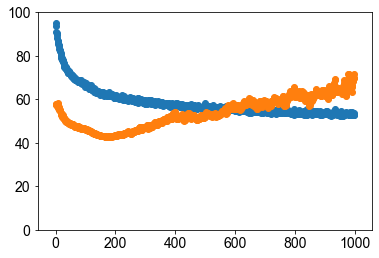

In [139]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [141]:
        #xnorm = scalerX.fit_transform(X)
        #ynorm = np.asarray(scalerY.fit_transform(Y))
        X_pca = nmfX.fit_transform(X)
        Y_pca = nmfY.fit_transform(Y)     
        xnorm = scalerX.fit_transform(X_pca)
        ynorm = np.asarray(scalerY.fit_transform(Y_pca))
        
        an = anndata.AnnData(xnorm)
        an.Y= ynorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[180], decoder_layer_sizes=[150], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-4
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)


            #if epoch % self.val_check == 0 and epoch != 0:
            #print("Epoch {:02d}, Loss_valid: {:9.4f}, rec_loss_valid: {:9.4f}, KL_loss_valid: {:9.4f}".format(
            #    epoch, valid_loss, valid_rec, valid_kl))
            #self.model.eval()

encoder_layer_sizes [20, 180]
decoder_layer_sizes [150]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/0, Loss:   71.6105, rec_loss:   71.6078, KL_loss:    0.0027
Epoch 01/1000 Batch 0000/0, Loss:   70.1289, rec_loss:   70.1262, KL_loss:    0.0027
Epoch 02/1000 Batch 0000/0, Loss:   68.8372, rec_loss:   68.8345, KL_loss:    0.0027
Epoch 03/1000 Batch 0000/0, Loss:   68.0050, rec_loss:   68.0022, KL_loss:    0.0028
Epoch 04/1000 Batch 0000/0, Loss:   67.5078, rec_loss:   67.5050, KL_loss:    0.0028
Epoch 05/1000 Batch 0000/0, Loss:   66.5982, rec_loss:   66.5953, KL_loss:    0.0029
Epoch 06/1000 Batch 0000/0, Loss:   66.2891, rec_loss:   66.2861, KL_loss:    0.0030
Epoch 07/1000 Batch 0000/0, Loss:   65.8123, rec_loss:   65.8092, KL_loss:    0.0031
Epoch 08/1000 Batch 0000/0, Loss:   65.8073, rec_loss:   65.8041, KL_loss:    0.0033
Epoch 09/1000 Batch 0000/0, Loss:   65.2870, rec_loss:   65.2836, KL_loss:    0.0034
Epoch 10/1000 Batch 0000/0, Loss:   64.362

Epoch 99/1000 Batch 0000/0, Loss:   51.3144, rec_loss:   51.2856, KL_loss:    0.0288
Epoch 100/1000 Batch 0000/0, Loss:   51.4766, rec_loss:   51.4476, KL_loss:    0.0290
Epoch 101/1000 Batch 0000/0, Loss:   51.2084, rec_loss:   51.1792, KL_loss:    0.0292
Epoch 102/1000 Batch 0000/0, Loss:   51.1954, rec_loss:   51.1660, KL_loss:    0.0295
Epoch 103/1000 Batch 0000/0, Loss:   51.0622, rec_loss:   51.0325, KL_loss:    0.0297
Epoch 104/1000 Batch 0000/0, Loss:   50.8807, rec_loss:   50.8508, KL_loss:    0.0299
Epoch 105/1000 Batch 0000/0, Loss:   51.1241, rec_loss:   51.0941, KL_loss:    0.0301
Epoch 106/1000 Batch 0000/0, Loss:   50.8611, rec_loss:   50.8308, KL_loss:    0.0303
Epoch 107/1000 Batch 0000/0, Loss:   51.0102, rec_loss:   50.9797, KL_loss:    0.0305
Epoch 108/1000 Batch 0000/0, Loss:   50.8761, rec_loss:   50.8454, KL_loss:    0.0307
Epoch 109/1000 Batch 0000/0, Loss:   50.9531, rec_loss:   50.9223, KL_loss:    0.0309
Epoch 110/1000 Batch 0000/0, Loss:   50.9007, rec_loss:

Epoch 198/1000 Batch 0000/0, Loss:   47.5668, rec_loss:   47.5250, KL_loss:    0.0418
Epoch 199/1000 Batch 0000/0, Loss:   47.5280, rec_loss:   47.4861, KL_loss:    0.0419
Epoch 200/1000 Batch 0000/0, Loss:   47.4920, rec_loss:   47.4499, KL_loss:    0.0420
Epoch 201/1000 Batch 0000/0, Loss:   47.3961, rec_loss:   47.3540, KL_loss:    0.0421
Epoch 202/1000 Batch 0000/0, Loss:   47.5415, rec_loss:   47.4992, KL_loss:    0.0423
Epoch 203/1000 Batch 0000/0, Loss:   47.3329, rec_loss:   47.2905, KL_loss:    0.0424
Epoch 204/1000 Batch 0000/0, Loss:   47.3158, rec_loss:   47.2733, KL_loss:    0.0425
Epoch 205/1000 Batch 0000/0, Loss:   47.1830, rec_loss:   47.1403, KL_loss:    0.0427
Epoch 206/1000 Batch 0000/0, Loss:   47.1527, rec_loss:   47.1099, KL_loss:    0.0428
Epoch 207/1000 Batch 0000/0, Loss:   47.1202, rec_loss:   47.0772, KL_loss:    0.0429
Epoch 208/1000 Batch 0000/0, Loss:   47.0833, rec_loss:   47.0403, KL_loss:    0.0431
Epoch 209/1000 Batch 0000/0, Loss:   47.0302, rec_loss

Epoch 296/1000 Batch 0000/0, Loss:   44.3025, rec_loss:   44.2467, KL_loss:    0.0557
Epoch 297/1000 Batch 0000/0, Loss:   44.3537, rec_loss:   44.2979, KL_loss:    0.0559
Epoch 298/1000 Batch 0000/0, Loss:   44.3380, rec_loss:   44.2820, KL_loss:    0.0560
Epoch 299/1000 Batch 0000/0, Loss:   44.3834, rec_loss:   44.3272, KL_loss:    0.0561
Epoch 300/1000 Batch 0000/0, Loss:   44.2391, rec_loss:   44.1829, KL_loss:    0.0563
Epoch 301/1000 Batch 0000/0, Loss:   44.1336, rec_loss:   44.0772, KL_loss:    0.0564
Epoch 302/1000 Batch 0000/0, Loss:   44.2791, rec_loss:   44.2225, KL_loss:    0.0565
Epoch 303/1000 Batch 0000/0, Loss:   44.2297, rec_loss:   44.1730, KL_loss:    0.0567
Epoch 304/1000 Batch 0000/0, Loss:   44.0828, rec_loss:   44.0260, KL_loss:    0.0568
Epoch 305/1000 Batch 0000/0, Loss:   44.1207, rec_loss:   44.0637, KL_loss:    0.0570
Epoch 306/1000 Batch 0000/0, Loss:   44.1344, rec_loss:   44.0773, KL_loss:    0.0571
Epoch 307/1000 Batch 0000/0, Loss:   44.1363, rec_loss

Epoch 394/1000 Batch 0000/0, Loss:   42.2187, rec_loss:   42.1552, KL_loss:    0.0636
Epoch 395/1000 Batch 0000/0, Loss:   42.0298, rec_loss:   41.9662, KL_loss:    0.0636
Epoch 396/1000 Batch 0000/0, Loss:   42.1021, rec_loss:   42.0385, KL_loss:    0.0636
Epoch 397/1000 Batch 0000/0, Loss:   42.0260, rec_loss:   41.9623, KL_loss:    0.0637
Epoch 398/1000 Batch 0000/0, Loss:   42.1210, rec_loss:   42.0573, KL_loss:    0.0637
Epoch 399/1000 Batch 0000/0, Loss:   41.9991, rec_loss:   41.9354, KL_loss:    0.0637
Epoch 400/1000 Batch 0000/0, Loss:   41.8952, rec_loss:   41.8314, KL_loss:    0.0638
Epoch 401/1000 Batch 0000/0, Loss:   41.9002, rec_loss:   41.8364, KL_loss:    0.0638
Epoch 402/1000 Batch 0000/0, Loss:   41.9020, rec_loss:   41.8382, KL_loss:    0.0638
Epoch 403/1000 Batch 0000/0, Loss:   41.9294, rec_loss:   41.8656, KL_loss:    0.0638
Epoch 404/1000 Batch 0000/0, Loss:   41.9025, rec_loss:   41.8387, KL_loss:    0.0638
Epoch 405/1000 Batch 0000/0, Loss:   41.8674, rec_loss

Epoch 492/1000 Batch 0000/0, Loss:   40.2133, rec_loss:   40.1468, KL_loss:    0.0665
Epoch 493/1000 Batch 0000/0, Loss:   40.1984, rec_loss:   40.1318, KL_loss:    0.0666
Epoch 494/1000 Batch 0000/0, Loss:   40.1316, rec_loss:   40.0651, KL_loss:    0.0666
Epoch 495/1000 Batch 0000/0, Loss:   40.1266, rec_loss:   40.0600, KL_loss:    0.0666
Epoch 496/1000 Batch 0000/0, Loss:   40.1793, rec_loss:   40.1126, KL_loss:    0.0667
Epoch 497/1000 Batch 0000/0, Loss:   40.0984, rec_loss:   40.0317, KL_loss:    0.0667
Epoch 498/1000 Batch 0000/0, Loss:   40.1372, rec_loss:   40.0705, KL_loss:    0.0668
Epoch 499/1000 Batch 0000/0, Loss:   40.1003, rec_loss:   40.0335, KL_loss:    0.0668
Epoch 500/1000 Batch 0000/0, Loss:   40.0097, rec_loss:   39.9428, KL_loss:    0.0668
Epoch 501/1000 Batch 0000/0, Loss:   40.0394, rec_loss:   39.9725, KL_loss:    0.0669
Epoch 502/1000 Batch 0000/0, Loss:   40.0181, rec_loss:   39.9512, KL_loss:    0.0669
Epoch 503/1000 Batch 0000/0, Loss:   40.0145, rec_loss

Epoch 590/1000 Batch 0000/0, Loss:   38.6233, rec_loss:   38.5500, KL_loss:    0.0734
Epoch 591/1000 Batch 0000/0, Loss:   38.7056, rec_loss:   38.6321, KL_loss:    0.0734
Epoch 592/1000 Batch 0000/0, Loss:   38.6426, rec_loss:   38.5691, KL_loss:    0.0735
Epoch 593/1000 Batch 0000/0, Loss:   38.5968, rec_loss:   38.5232, KL_loss:    0.0736
Epoch 594/1000 Batch 0000/0, Loss:   38.5876, rec_loss:   38.5139, KL_loss:    0.0737
Epoch 595/1000 Batch 0000/0, Loss:   38.6007, rec_loss:   38.5269, KL_loss:    0.0738
Epoch 596/1000 Batch 0000/0, Loss:   38.5963, rec_loss:   38.5225, KL_loss:    0.0739
Epoch 597/1000 Batch 0000/0, Loss:   38.5490, rec_loss:   38.4751, KL_loss:    0.0739
Epoch 598/1000 Batch 0000/0, Loss:   38.5695, rec_loss:   38.4955, KL_loss:    0.0740
Epoch 599/1000 Batch 0000/0, Loss:   38.4997, rec_loss:   38.4256, KL_loss:    0.0741
Epoch 600/1000 Batch 0000/0, Loss:   38.4770, rec_loss:   38.4029, KL_loss:    0.0742
Epoch 601/1000 Batch 0000/0, Loss:   38.5266, rec_loss

Epoch 686/1000 Batch 0000/0, Loss:   37.2741, rec_loss:   37.1929, KL_loss:    0.0812
Epoch 687/1000 Batch 0000/0, Loss:   37.2958, rec_loss:   37.2144, KL_loss:    0.0813
Epoch 688/1000 Batch 0000/0, Loss:   37.1998, rec_loss:   37.1184, KL_loss:    0.0814
Epoch 689/1000 Batch 0000/0, Loss:   37.2817, rec_loss:   37.2002, KL_loss:    0.0815
Epoch 690/1000 Batch 0000/0, Loss:   37.2360, rec_loss:   37.1544, KL_loss:    0.0816
Epoch 691/1000 Batch 0000/0, Loss:   37.1950, rec_loss:   37.1133, KL_loss:    0.0817
Epoch 692/1000 Batch 0000/0, Loss:   37.2084, rec_loss:   37.1265, KL_loss:    0.0818
Epoch 693/1000 Batch 0000/0, Loss:   37.1681, rec_loss:   37.0861, KL_loss:    0.0819
Epoch 694/1000 Batch 0000/0, Loss:   37.1418, rec_loss:   37.0598, KL_loss:    0.0820
Epoch 695/1000 Batch 0000/0, Loss:   37.1479, rec_loss:   37.0658, KL_loss:    0.0821
Epoch 696/1000 Batch 0000/0, Loss:   37.1360, rec_loss:   37.0538, KL_loss:    0.0822
Epoch 697/1000 Batch 0000/0, Loss:   37.0438, rec_loss

Epoch 782/1000 Batch 0000/0, Loss:   36.1586, rec_loss:   36.0690, KL_loss:    0.0896
Epoch 783/1000 Batch 0000/0, Loss:   36.1079, rec_loss:   36.0182, KL_loss:    0.0897
Epoch 784/1000 Batch 0000/0, Loss:   36.0837, rec_loss:   35.9939, KL_loss:    0.0898
Epoch 785/1000 Batch 0000/0, Loss:   36.0818, rec_loss:   35.9919, KL_loss:    0.0899
Epoch 786/1000 Batch 0000/0, Loss:   36.0846, rec_loss:   35.9947, KL_loss:    0.0900
Epoch 787/1000 Batch 0000/0, Loss:   36.0643, rec_loss:   35.9742, KL_loss:    0.0901
Epoch 788/1000 Batch 0000/0, Loss:   36.0562, rec_loss:   35.9661, KL_loss:    0.0901
Epoch 789/1000 Batch 0000/0, Loss:   36.0297, rec_loss:   35.9395, KL_loss:    0.0902
Epoch 790/1000 Batch 0000/0, Loss:   36.0312, rec_loss:   35.9409, KL_loss:    0.0903
Epoch 791/1000 Batch 0000/0, Loss:   35.9852, rec_loss:   35.8948, KL_loss:    0.0904
Epoch 792/1000 Batch 0000/0, Loss:   36.0019, rec_loss:   35.9114, KL_loss:    0.0905
Epoch 793/1000 Batch 0000/0, Loss:   35.9976, rec_loss

Epoch 878/1000 Batch 0000/0, Loss:   35.3357, rec_loss:   35.2385, KL_loss:    0.0972
Epoch 879/1000 Batch 0000/0, Loss:   35.3135, rec_loss:   35.2162, KL_loss:    0.0973
Epoch 880/1000 Batch 0000/0, Loss:   35.3081, rec_loss:   35.2107, KL_loss:    0.0974
Epoch 881/1000 Batch 0000/0, Loss:   35.3093, rec_loss:   35.2119, KL_loss:    0.0974
Epoch 882/1000 Batch 0000/0, Loss:   35.2718, rec_loss:   35.1742, KL_loss:    0.0975
Epoch 883/1000 Batch 0000/0, Loss:   35.3108, rec_loss:   35.2132, KL_loss:    0.0976
Epoch 884/1000 Batch 0000/0, Loss:   35.2851, rec_loss:   35.1874, KL_loss:    0.0977
Epoch 885/1000 Batch 0000/0, Loss:   35.2952, rec_loss:   35.1975, KL_loss:    0.0977
Epoch 886/1000 Batch 0000/0, Loss:   35.2659, rec_loss:   35.1681, KL_loss:    0.0978
Epoch 887/1000 Batch 0000/0, Loss:   35.3016, rec_loss:   35.2037, KL_loss:    0.0979
Epoch 888/1000 Batch 0000/0, Loss:   35.2653, rec_loss:   35.1674, KL_loss:    0.0980
Epoch 889/1000 Batch 0000/0, Loss:   35.2103, rec_loss

Epoch 975/1000 Batch 0000/0, Loss:   34.8505, rec_loss:   34.7468, KL_loss:    0.1037
Epoch 976/1000 Batch 0000/0, Loss:   34.8824, rec_loss:   34.7786, KL_loss:    0.1038
Epoch 977/1000 Batch 0000/0, Loss:   34.8579, rec_loss:   34.7540, KL_loss:    0.1039
Epoch 978/1000 Batch 0000/0, Loss:   34.8694, rec_loss:   34.7655, KL_loss:    0.1039
Epoch 979/1000 Batch 0000/0, Loss:   34.8641, rec_loss:   34.7601, KL_loss:    0.1040
Epoch 980/1000 Batch 0000/0, Loss:   34.8114, rec_loss:   34.7074, KL_loss:    0.1041
Epoch 981/1000 Batch 0000/0, Loss:   34.8289, rec_loss:   34.7248, KL_loss:    0.1041
Epoch 982/1000 Batch 0000/0, Loss:   34.8278, rec_loss:   34.7236, KL_loss:    0.1042
Epoch 983/1000 Batch 0000/0, Loss:   34.8378, rec_loss:   34.7335, KL_loss:    0.1042
Epoch 984/1000 Batch 0000/0, Loss:   34.8117, rec_loss:   34.7074, KL_loss:    0.1043
Epoch 985/1000 Batch 0000/0, Loss:   34.8289, rec_loss:   34.7246, KL_loss:    0.1043
Epoch 986/1000 Batch 0000/0, Loss:   34.8252, rec_loss

(0, 100)

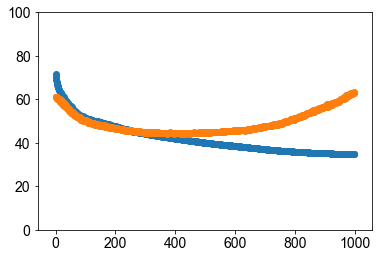

In [142]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [143]:
def normalize_variance(x):
    keep = np.where(np.linalg.norm(x, axis = 0) != 0)[0]
    
    x = x[:,keep]
    return((x)/ np.var(x, axis = 0)**(0.5))


In [144]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        

In [155]:
        an = anndata.AnnData(xnmfnorm)
        an.Y= ynmfnorm
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate = 0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        batch_size=300
        trainer.n_workers=0
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()
        
        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)



encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/0, Loss:   69.3045, rec_loss:   69.3016, KL_loss:    0.0029
Epoch 01/1000 Batch 0000/0, Loss:   64.8133, rec_loss:   64.8066, KL_loss:    0.0067
Epoch 02/1000 Batch 0000/0, Loss:   64.4351, rec_loss:   64.4136, KL_loss:    0.0215
Epoch 03/1000 Batch 0000/0, Loss:   61.2140, rec_loss:   61.1279, KL_loss:    0.0861
Epoch 04/1000 Batch 0000/0, Loss:   62.3028, rec_loss:   62.1063, KL_loss:    0.1965
Epoch 05/1000 Batch 0000/0, Loss:   60.5177, rec_loss:   60.3765, KL_loss:    0.1412
Epoch 06/1000 Batch 0000/0, Loss:   61.6803, rec_loss:   61.5887, KL_loss:    0.0916
Epoch 07/1000 Batch 0000/0, Loss:   59.8840, rec_loss:   59.8420, KL_loss:    0.0420
Epoch 08/1000 Batch 0000/0, Loss:   58.8109, rec_loss:   58.7741, KL_loss:    0.0368
Epoch 09/1000 Batch 0000/0, Loss:   57.2698, rec_loss:   57.2369, KL_loss:    0.0329
Epoch 10/1000 Batch 0000/0, Loss:   56.641

KeyboardInterrupt: 

In [152]:
376*.8

300.8

(0, 100)

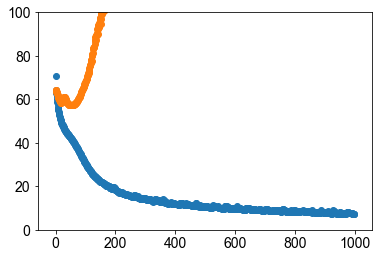

In [147]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [157]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[250], decoder_layer_sizes=[180], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 1000
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_rec += reconstruction_loss.item()
                train_kl += kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 250]
decoder_layer_sizes [180]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/1000 Batch 0000/0, Loss:   31.7850, rec_loss:   31.7820, KL_loss:    0.0030
Epoch 01/1000 Batch 0000/0, Loss:   30.3380, rec_loss:   30.3330, KL_loss:    0.0050
Epoch 02/1000 Batch 0000/0, Loss:   28.9510, rec_loss:   28.9437, KL_loss:    0.0073
Epoch 03/1000 Batch 0000/0, Loss:   28.5049, rec_loss:   28.4939, KL_loss:    0.0110
Epoch 04/1000 Batch 0000/0, Loss:   27.3698, rec_loss:   27.3567, KL_loss:    0.0130
Epoch 05/1000 Batch 0000/0, Loss:   26.4957, rec_loss:   26.4804, KL_loss:    0.0154
Epoch 06/1000 Batch 0000/0, Loss:   25.6958, rec_loss:   25.6774, KL_loss:    0.0184
Epoch 07/1000 Batch 0000/0, Loss:   25.0075, rec_loss:   24.9856, KL_loss:    0.0219
Epoch 08/1000 Batch 0000/0, Loss:   24.3188, rec_loss:   24.2932, KL_loss:    0.0255
Epoch 09/1000 Batch 0000/0, Loss:   23.7190, rec_loss:   23.6897, KL_loss:    0.0293
Epoch 10/1000 Batch 0000/0, Loss:   23.118

Epoch 101/1000 Batch 0000/0, Loss:   12.0039, rec_loss:   11.9261, KL_loss:    0.0778
Epoch 102/1000 Batch 0000/0, Loss:   11.8991, rec_loss:   11.8208, KL_loss:    0.0783
Epoch 103/1000 Batch 0000/0, Loss:   11.8093, rec_loss:   11.7304, KL_loss:    0.0788
Epoch 104/1000 Batch 0000/0, Loss:   11.7139, rec_loss:   11.6345, KL_loss:    0.0793
Epoch 105/1000 Batch 0000/0, Loss:   11.6902, rec_loss:   11.6105, KL_loss:    0.0797
Epoch 106/1000 Batch 0000/0, Loss:   11.5987, rec_loss:   11.5184, KL_loss:    0.0803
Epoch 107/1000 Batch 0000/0, Loss:   11.5502, rec_loss:   11.4693, KL_loss:    0.0809
Epoch 108/1000 Batch 0000/0, Loss:   11.4014, rec_loss:   11.3199, KL_loss:    0.0814
Epoch 109/1000 Batch 0000/0, Loss:   11.3581, rec_loss:   11.2761, KL_loss:    0.0819
Epoch 110/1000 Batch 0000/0, Loss:   11.3140, rec_loss:   11.2315, KL_loss:    0.0825
Epoch 111/1000 Batch 0000/0, Loss:   11.2360, rec_loss:   11.1531, KL_loss:    0.0829
Epoch 112/1000 Batch 0000/0, Loss:   11.1452, rec_loss

Epoch 197/1000 Batch 0000/0, Loss:    7.4308, rec_loss:    7.3245, KL_loss:    0.1063
Epoch 198/1000 Batch 0000/0, Loss:    7.3262, rec_loss:    7.2197, KL_loss:    0.1065
Epoch 199/1000 Batch 0000/0, Loss:    7.3805, rec_loss:    7.2738, KL_loss:    0.1067
Epoch 200/1000 Batch 0000/0, Loss:    7.3900, rec_loss:    7.2831, KL_loss:    0.1069
Epoch 201/1000 Batch 0000/0, Loss:    7.3607, rec_loss:    7.2537, KL_loss:    0.1070
Epoch 202/1000 Batch 0000/0, Loss:    7.3253, rec_loss:    7.2181, KL_loss:    0.1072
Epoch 203/1000 Batch 0000/0, Loss:    7.2134, rec_loss:    7.1060, KL_loss:    0.1074
Epoch 204/1000 Batch 0000/0, Loss:    7.2036, rec_loss:    7.0960, KL_loss:    0.1075
Epoch 205/1000 Batch 0000/0, Loss:    7.1427, rec_loss:    7.0350, KL_loss:    0.1077
Epoch 206/1000 Batch 0000/0, Loss:    7.0291, rec_loss:    6.9213, KL_loss:    0.1078
Epoch 207/1000 Batch 0000/0, Loss:    7.0499, rec_loss:    6.9419, KL_loss:    0.1080
Epoch 208/1000 Batch 0000/0, Loss:    6.9937, rec_loss

Epoch 298/1000 Batch 0000/0, Loss:    5.8180, rec_loss:    5.7025, KL_loss:    0.1155
Epoch 299/1000 Batch 0000/0, Loss:    5.6825, rec_loss:    5.5669, KL_loss:    0.1156
Epoch 300/1000 Batch 0000/0, Loss:    5.7703, rec_loss:    5.6546, KL_loss:    0.1157
Epoch 301/1000 Batch 0000/0, Loss:    5.7485, rec_loss:    5.6328, KL_loss:    0.1157
Epoch 302/1000 Batch 0000/0, Loss:    5.5839, rec_loss:    5.4681, KL_loss:    0.1158
Epoch 303/1000 Batch 0000/0, Loss:    5.6863, rec_loss:    5.5705, KL_loss:    0.1158
Epoch 304/1000 Batch 0000/0, Loss:    5.5808, rec_loss:    5.4650, KL_loss:    0.1159
Epoch 305/1000 Batch 0000/0, Loss:    5.6597, rec_loss:    5.5438, KL_loss:    0.1159
Epoch 306/1000 Batch 0000/0, Loss:    5.5775, rec_loss:    5.4616, KL_loss:    0.1159
Epoch 307/1000 Batch 0000/0, Loss:    5.6197, rec_loss:    5.5037, KL_loss:    0.1159
Epoch 308/1000 Batch 0000/0, Loss:    5.7610, rec_loss:    5.6450, KL_loss:    0.1160
Epoch 309/1000 Batch 0000/0, Loss:    5.6225, rec_loss

Epoch 394/1000 Batch 0000/0, Loss:    4.5487, rec_loss:    4.4289, KL_loss:    0.1198
Epoch 395/1000 Batch 0000/0, Loss:    4.4656, rec_loss:    4.3458, KL_loss:    0.1199
Epoch 396/1000 Batch 0000/0, Loss:    4.6185, rec_loss:    4.4986, KL_loss:    0.1199
Epoch 397/1000 Batch 0000/0, Loss:    4.7948, rec_loss:    4.6748, KL_loss:    0.1200
Epoch 398/1000 Batch 0000/0, Loss:    4.8039, rec_loss:    4.6838, KL_loss:    0.1201
Epoch 399/1000 Batch 0000/0, Loss:    4.7193, rec_loss:    4.5992, KL_loss:    0.1201
Epoch 400/1000 Batch 0000/0, Loss:    4.7513, rec_loss:    4.6312, KL_loss:    0.1202
Epoch 401/1000 Batch 0000/0, Loss:    4.7634, rec_loss:    4.6432, KL_loss:    0.1202
Epoch 402/1000 Batch 0000/0, Loss:    4.9083, rec_loss:    4.7880, KL_loss:    0.1203
Epoch 403/1000 Batch 0000/0, Loss:    4.8238, rec_loss:    4.7035, KL_loss:    0.1203
Epoch 404/1000 Batch 0000/0, Loss:    4.6328, rec_loss:    4.5124, KL_loss:    0.1204
Epoch 405/1000 Batch 0000/0, Loss:    4.4750, rec_loss

Epoch 490/1000 Batch 0000/0, Loss:    4.1368, rec_loss:    4.0145, KL_loss:    0.1223
Epoch 491/1000 Batch 0000/0, Loss:    4.1313, rec_loss:    4.0090, KL_loss:    0.1223
Epoch 492/1000 Batch 0000/0, Loss:    4.0283, rec_loss:    3.9060, KL_loss:    0.1224
Epoch 493/1000 Batch 0000/0, Loss:    3.9687, rec_loss:    3.8464, KL_loss:    0.1224
Epoch 494/1000 Batch 0000/0, Loss:    3.9382, rec_loss:    3.8158, KL_loss:    0.1224
Epoch 495/1000 Batch 0000/0, Loss:    3.9659, rec_loss:    3.8436, KL_loss:    0.1223
Epoch 496/1000 Batch 0000/0, Loss:    4.0582, rec_loss:    3.9359, KL_loss:    0.1223
Epoch 497/1000 Batch 0000/0, Loss:    4.0873, rec_loss:    3.9650, KL_loss:    0.1223
Epoch 498/1000 Batch 0000/0, Loss:    3.9989, rec_loss:    3.8766, KL_loss:    0.1223
Epoch 499/1000 Batch 0000/0, Loss:    3.9586, rec_loss:    3.8363, KL_loss:    0.1223
Epoch 500/1000 Batch 0000/0, Loss:    3.9907, rec_loss:    3.8683, KL_loss:    0.1224
Epoch 501/1000 Batch 0000/0, Loss:    4.0454, rec_loss

Epoch 591/1000 Batch 0000/0, Loss:    3.6549, rec_loss:    3.5318, KL_loss:    0.1231
Epoch 592/1000 Batch 0000/0, Loss:    3.6766, rec_loss:    3.5535, KL_loss:    0.1231
Epoch 593/1000 Batch 0000/0, Loss:    3.6469, rec_loss:    3.5238, KL_loss:    0.1231
Epoch 594/1000 Batch 0000/0, Loss:    3.6277, rec_loss:    3.5045, KL_loss:    0.1231
Epoch 595/1000 Batch 0000/0, Loss:    3.6328, rec_loss:    3.5097, KL_loss:    0.1231
Epoch 596/1000 Batch 0000/0, Loss:    3.6646, rec_loss:    3.5415, KL_loss:    0.1231
Epoch 597/1000 Batch 0000/0, Loss:    3.7396, rec_loss:    3.6164, KL_loss:    0.1232
Epoch 598/1000 Batch 0000/0, Loss:    3.6731, rec_loss:    3.5499, KL_loss:    0.1232
Epoch 599/1000 Batch 0000/0, Loss:    3.5645, rec_loss:    3.4412, KL_loss:    0.1232
Epoch 600/1000 Batch 0000/0, Loss:    3.4484, rec_loss:    3.3251, KL_loss:    0.1233
Epoch 601/1000 Batch 0000/0, Loss:    3.4475, rec_loss:    3.3242, KL_loss:    0.1233
Epoch 602/1000 Batch 0000/0, Loss:    3.4903, rec_loss

Epoch 690/1000 Batch 0000/0, Loss:    4.0505, rec_loss:    3.9291, KL_loss:    0.1214
Epoch 691/1000 Batch 0000/0, Loss:    3.9654, rec_loss:    3.8442, KL_loss:    0.1212
Epoch 692/1000 Batch 0000/0, Loss:    3.9289, rec_loss:    3.8078, KL_loss:    0.1211
Epoch 693/1000 Batch 0000/0, Loss:    3.8707, rec_loss:    3.7498, KL_loss:    0.1210
Epoch 694/1000 Batch 0000/0, Loss:    3.7780, rec_loss:    3.6571, KL_loss:    0.1209
Epoch 695/1000 Batch 0000/0, Loss:    3.7249, rec_loss:    3.6042, KL_loss:    0.1208
Epoch 696/1000 Batch 0000/0, Loss:    3.6708, rec_loss:    3.5501, KL_loss:    0.1207
Epoch 697/1000 Batch 0000/0, Loss:    3.6168, rec_loss:    3.4962, KL_loss:    0.1206
Epoch 698/1000 Batch 0000/0, Loss:    3.5966, rec_loss:    3.4760, KL_loss:    0.1205
Epoch 699/1000 Batch 0000/0, Loss:    3.5358, rec_loss:    3.4153, KL_loss:    0.1205
Epoch 700/1000 Batch 0000/0, Loss:    3.4888, rec_loss:    3.3683, KL_loss:    0.1204
Epoch 701/1000 Batch 0000/0, Loss:    3.4721, rec_loss

Epoch 790/1000 Batch 0000/0, Loss:    3.2049, rec_loss:    3.0815, KL_loss:    0.1233
Epoch 791/1000 Batch 0000/0, Loss:    3.1664, rec_loss:    3.0431, KL_loss:    0.1234
Epoch 792/1000 Batch 0000/0, Loss:    2.9922, rec_loss:    2.8688, KL_loss:    0.1234
Epoch 793/1000 Batch 0000/0, Loss:    3.0700, rec_loss:    2.9465, KL_loss:    0.1235
Epoch 794/1000 Batch 0000/0, Loss:    3.1164, rec_loss:    2.9928, KL_loss:    0.1235
Epoch 795/1000 Batch 0000/0, Loss:    3.0664, rec_loss:    2.9428, KL_loss:    0.1236
Epoch 796/1000 Batch 0000/0, Loss:    2.9654, rec_loss:    2.8417, KL_loss:    0.1237
Epoch 797/1000 Batch 0000/0, Loss:    2.9444, rec_loss:    2.8207, KL_loss:    0.1237
Epoch 798/1000 Batch 0000/0, Loss:    3.0982, rec_loss:    2.9745, KL_loss:    0.1237
Epoch 799/1000 Batch 0000/0, Loss:    3.2306, rec_loss:    3.1069, KL_loss:    0.1237
Epoch 800/1000 Batch 0000/0, Loss:    3.1070, rec_loss:    2.9833, KL_loss:    0.1237
Epoch 801/1000 Batch 0000/0, Loss:    3.0015, rec_loss

Epoch 888/1000 Batch 0000/0, Loss:    3.0657, rec_loss:    2.9415, KL_loss:    0.1242
Epoch 889/1000 Batch 0000/0, Loss:    3.0427, rec_loss:    2.9184, KL_loss:    0.1243
Epoch 890/1000 Batch 0000/0, Loss:    2.9763, rec_loss:    2.8520, KL_loss:    0.1243
Epoch 891/1000 Batch 0000/0, Loss:    2.9162, rec_loss:    2.7919, KL_loss:    0.1243
Epoch 892/1000 Batch 0000/0, Loss:    2.9016, rec_loss:    2.7774, KL_loss:    0.1243
Epoch 893/1000 Batch 0000/0, Loss:    2.8825, rec_loss:    2.7582, KL_loss:    0.1243
Epoch 894/1000 Batch 0000/0, Loss:    2.9095, rec_loss:    2.7853, KL_loss:    0.1243
Epoch 895/1000 Batch 0000/0, Loss:    2.9035, rec_loss:    2.7792, KL_loss:    0.1243
Epoch 896/1000 Batch 0000/0, Loss:    2.8877, rec_loss:    2.7634, KL_loss:    0.1243
Epoch 897/1000 Batch 0000/0, Loss:    2.8467, rec_loss:    2.7225, KL_loss:    0.1243
Epoch 898/1000 Batch 0000/0, Loss:    2.9200, rec_loss:    2.7957, KL_loss:    0.1243
Epoch 899/1000 Batch 0000/0, Loss:    2.8623, rec_loss

Epoch 986/1000 Batch 0000/0, Loss:    2.7689, rec_loss:    2.6452, KL_loss:    0.1238
Epoch 987/1000 Batch 0000/0, Loss:    2.8939, rec_loss:    2.7701, KL_loss:    0.1238
Epoch 988/1000 Batch 0000/0, Loss:    2.8166, rec_loss:    2.6928, KL_loss:    0.1238
Epoch 989/1000 Batch 0000/0, Loss:    2.7900, rec_loss:    2.6662, KL_loss:    0.1238
Epoch 990/1000 Batch 0000/0, Loss:    2.7506, rec_loss:    2.6267, KL_loss:    0.1239
Epoch 991/1000 Batch 0000/0, Loss:    2.8851, rec_loss:    2.7612, KL_loss:    0.1239
Epoch 992/1000 Batch 0000/0, Loss:    2.9995, rec_loss:    2.8756, KL_loss:    0.1240
Epoch 993/1000 Batch 0000/0, Loss:    2.8329, rec_loss:    2.7089, KL_loss:    0.1240
Epoch 994/1000 Batch 0000/0, Loss:    2.8108, rec_loss:    2.6867, KL_loss:    0.1241
Epoch 995/1000 Batch 0000/0, Loss:    2.7826, rec_loss:    2.6585, KL_loss:    0.1241
Epoch 996/1000 Batch 0000/0, Loss:    2.7052, rec_loss:    2.5811, KL_loss:    0.1242
Epoch 997/1000 Batch 0000/0, Loss:    2.6369, rec_loss

(0, 100)

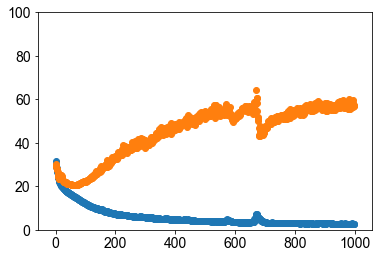

In [158]:
plt.scatter(list(range(1000)),self.logs['loss_train'][:1000])
plt.scatter(list(range(1000)),self.logs['loss_valid'][:1000])
plt.ylim(0,100)

In [176]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())

        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =20,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[50], decoder_layer_sizes=[50], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        
        lr = 5e-3
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 500
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                train_rec = reconstruction_loss.item()
                train_kl = kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 50]
decoder_layer_sizes [50]
latent dim 20
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/500 Batch 0000/0, Loss:   31.1626, rec_loss:   31.1599, KL_loss:    0.0026
Epoch 01/500 Batch 0000/0, Loss:   30.4051, rec_loss:   30.4021, KL_loss:    0.0029
Epoch 02/500 Batch 0000/0, Loss:   29.2555, rec_loss:   29.2522, KL_loss:    0.0033
Epoch 03/500 Batch 0000/0, Loss:   29.3140, rec_loss:   29.3102, KL_loss:    0.0038
Epoch 04/500 Batch 0000/0, Loss:   28.5335, rec_loss:   28.5292, KL_loss:    0.0044
Epoch 05/500 Batch 0000/0, Loss:   28.5633, rec_loss:   28.5581, KL_loss:    0.0052
Epoch 06/500 Batch 0000/0, Loss:   28.1418, rec_loss:   28.1354, KL_loss:    0.0063
Epoch 07/500 Batch 0000/0, Loss:   27.8436, rec_loss:   27.8360, KL_loss:    0.0075
Epoch 08/500 Batch 0000/0, Loss:   27.8033, rec_loss:   27.7946, KL_loss:    0.0087
Epoch 09/500 Batch 0000/0, Loss:   27.1512, rec_loss:   27.1428, KL_loss:    0.0084
Epoch 10/500 Batch 0000/0, Loss:   27.2058, rec_loss: 

Epoch 103/500 Batch 0000/0, Loss:   16.5730, rec_loss:   16.5151, KL_loss:    0.0579
Epoch 104/500 Batch 0000/0, Loss:   16.5032, rec_loss:   16.4453, KL_loss:    0.0580
Epoch 105/500 Batch 0000/0, Loss:   16.4579, rec_loss:   16.3999, KL_loss:    0.0580
Epoch 106/500 Batch 0000/0, Loss:   16.3908, rec_loss:   16.3328, KL_loss:    0.0581
Epoch 107/500 Batch 0000/0, Loss:   16.2800, rec_loss:   16.2218, KL_loss:    0.0581
Epoch 108/500 Batch 0000/0, Loss:   16.2672, rec_loss:   16.2090, KL_loss:    0.0582
Epoch 109/500 Batch 0000/0, Loss:   16.1508, rec_loss:   16.0925, KL_loss:    0.0583
Epoch 110/500 Batch 0000/0, Loss:   16.1720, rec_loss:   16.1136, KL_loss:    0.0584
Epoch 111/500 Batch 0000/0, Loss:   16.1229, rec_loss:   16.0644, KL_loss:    0.0585
Epoch 112/500 Batch 0000/0, Loss:   16.0181, rec_loss:   15.9595, KL_loss:    0.0586
Epoch 113/500 Batch 0000/0, Loss:   15.9341, rec_loss:   15.8753, KL_loss:    0.0587
Epoch 114/500 Batch 0000/0, Loss:   15.8851, rec_loss:   15.8263,

Epoch 204/500 Batch 0000/0, Loss:   11.3019, rec_loss:   11.2200, KL_loss:    0.0820
Epoch 205/500 Batch 0000/0, Loss:   11.2455, rec_loss:   11.1632, KL_loss:    0.0822
Epoch 206/500 Batch 0000/0, Loss:   11.2170, rec_loss:   11.1346, KL_loss:    0.0825
Epoch 207/500 Batch 0000/0, Loss:   11.1927, rec_loss:   11.1100, KL_loss:    0.0827
Epoch 208/500 Batch 0000/0, Loss:   11.1286, rec_loss:   11.0456, KL_loss:    0.0830
Epoch 209/500 Batch 0000/0, Loss:   11.1098, rec_loss:   11.0266, KL_loss:    0.0832
Epoch 210/500 Batch 0000/0, Loss:   11.1453, rec_loss:   11.0619, KL_loss:    0.0835
Epoch 211/500 Batch 0000/0, Loss:   11.1063, rec_loss:   11.0226, KL_loss:    0.0837
Epoch 212/500 Batch 0000/0, Loss:   11.0754, rec_loss:   10.9915, KL_loss:    0.0840
Epoch 213/500 Batch 0000/0, Loss:   10.9992, rec_loss:   10.9151, KL_loss:    0.0842
Epoch 214/500 Batch 0000/0, Loss:   10.9928, rec_loss:   10.9084, KL_loss:    0.0844
Epoch 215/500 Batch 0000/0, Loss:   10.8626, rec_loss:   10.7780,

Epoch 303/500 Batch 0000/0, Loss:    8.8418, rec_loss:    8.7415, KL_loss:    0.1003
Epoch 304/500 Batch 0000/0, Loss:    8.8084, rec_loss:    8.7080, KL_loss:    0.1004
Epoch 305/500 Batch 0000/0, Loss:    8.8125, rec_loss:    8.7119, KL_loss:    0.1006
Epoch 306/500 Batch 0000/0, Loss:    8.7401, rec_loss:    8.6394, KL_loss:    0.1007
Epoch 307/500 Batch 0000/0, Loss:    8.7653, rec_loss:    8.6644, KL_loss:    0.1008
Epoch 308/500 Batch 0000/0, Loss:    8.7916, rec_loss:    8.6907, KL_loss:    0.1009
Epoch 309/500 Batch 0000/0, Loss:    8.7883, rec_loss:    8.6872, KL_loss:    0.1011
Epoch 310/500 Batch 0000/0, Loss:    8.7469, rec_loss:    8.6457, KL_loss:    0.1012
Epoch 311/500 Batch 0000/0, Loss:    8.7255, rec_loss:    8.6241, KL_loss:    0.1013
Epoch 312/500 Batch 0000/0, Loss:    8.7257, rec_loss:    8.6242, KL_loss:    0.1015
Epoch 313/500 Batch 0000/0, Loss:    8.6823, rec_loss:    8.5807, KL_loss:    0.1016
Epoch 314/500 Batch 0000/0, Loss:    8.6845, rec_loss:    8.5828,

Epoch 407/500 Batch 0000/0, Loss:    7.8166, rec_loss:    7.7068, KL_loss:    0.1098
Epoch 408/500 Batch 0000/0, Loss:    7.8310, rec_loss:    7.7211, KL_loss:    0.1098
Epoch 409/500 Batch 0000/0, Loss:    7.8244, rec_loss:    7.7145, KL_loss:    0.1099
Epoch 410/500 Batch 0000/0, Loss:    7.8694, rec_loss:    7.7594, KL_loss:    0.1100
Epoch 411/500 Batch 0000/0, Loss:    7.8685, rec_loss:    7.7585, KL_loss:    0.1101
Epoch 412/500 Batch 0000/0, Loss:    7.8388, rec_loss:    7.7287, KL_loss:    0.1101
Epoch 413/500 Batch 0000/0, Loss:    7.7596, rec_loss:    7.6494, KL_loss:    0.1102
Epoch 414/500 Batch 0000/0, Loss:    7.7891, rec_loss:    7.6789, KL_loss:    0.1102
Epoch 415/500 Batch 0000/0, Loss:    7.7696, rec_loss:    7.6594, KL_loss:    0.1103
Epoch 416/500 Batch 0000/0, Loss:    7.8109, rec_loss:    7.7006, KL_loss:    0.1103
Epoch 417/500 Batch 0000/0, Loss:    7.7272, rec_loss:    7.6168, KL_loss:    0.1104
Epoch 418/500 Batch 0000/0, Loss:    7.7489, rec_loss:    7.6384,

(0, 100)

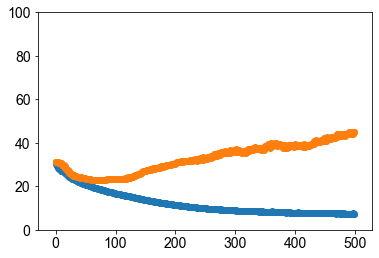

In [177]:
plt.scatter(list(range(500)),self.logs['loss_train'][:500])
plt.scatter(list(range(500)),self.logs['loss_valid'][:500])
plt.ylim(0,100)

In [192]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        pcaX = TruncatedSVD(n_components=20)
        pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())


        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        
        lr = 5e-3
        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[50], decoder_layer_sizes=[20], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        

        
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 500
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                train_rec = reconstruction_loss.item()
                train_kl = kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 50]
decoder_layer_sizes [20]
latent dim 10
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/500 Batch 0000/0, Loss:   32.7079, rec_loss:   32.7068, KL_loss:    0.0011
Epoch 01/500 Batch 0000/0, Loss:   31.8071, rec_loss:   31.8059, KL_loss:    0.0013
Epoch 02/500 Batch 0000/0, Loss:   31.1023, rec_loss:   31.1008, KL_loss:    0.0015
Epoch 03/500 Batch 0000/0, Loss:   30.3469, rec_loss:   30.3452, KL_loss:    0.0017
Epoch 04/500 Batch 0000/0, Loss:   30.1445, rec_loss:   30.1425, KL_loss:    0.0019
Epoch 05/500 Batch 0000/0, Loss:   29.6429, rec_loss:   29.6407, KL_loss:    0.0022
Epoch 06/500 Batch 0000/0, Loss:   29.4440, rec_loss:   29.4415, KL_loss:    0.0025
Epoch 07/500 Batch 0000/0, Loss:   29.3853, rec_loss:   29.3824, KL_loss:    0.0028
Epoch 08/500 Batch 0000/0, Loss:   29.0577, rec_loss:   29.0546, KL_loss:    0.0032
Epoch 09/500 Batch 0000/0, Loss:   28.8488, rec_loss:   28.8454, KL_loss:    0.0035
Epoch 10/500 Batch 0000/0, Loss:   28.5923, rec_loss: 

Epoch 104/500 Batch 0000/0, Loss:   18.1142, rec_loss:   18.0825, KL_loss:    0.0317
Epoch 105/500 Batch 0000/0, Loss:   17.9773, rec_loss:   17.9456, KL_loss:    0.0317
Epoch 106/500 Batch 0000/0, Loss:   18.0030, rec_loss:   17.9713, KL_loss:    0.0317
Epoch 107/500 Batch 0000/0, Loss:   17.8880, rec_loss:   17.8563, KL_loss:    0.0316
Epoch 108/500 Batch 0000/0, Loss:   17.7897, rec_loss:   17.7581, KL_loss:    0.0316
Epoch 109/500 Batch 0000/0, Loss:   17.7457, rec_loss:   17.7141, KL_loss:    0.0316
Epoch 110/500 Batch 0000/0, Loss:   17.6831, rec_loss:   17.6515, KL_loss:    0.0316
Epoch 111/500 Batch 0000/0, Loss:   17.6296, rec_loss:   17.5980, KL_loss:    0.0316
Epoch 112/500 Batch 0000/0, Loss:   17.5489, rec_loss:   17.5173, KL_loss:    0.0316
Epoch 113/500 Batch 0000/0, Loss:   17.4979, rec_loss:   17.4663, KL_loss:    0.0316
Epoch 114/500 Batch 0000/0, Loss:   17.4088, rec_loss:   17.3772, KL_loss:    0.0316
Epoch 115/500 Batch 0000/0, Loss:   17.4010, rec_loss:   17.3693,

Epoch 208/500 Batch 0000/0, Loss:   13.7026, rec_loss:   13.6575, KL_loss:    0.0451
Epoch 209/500 Batch 0000/0, Loss:   13.6756, rec_loss:   13.6303, KL_loss:    0.0453
Epoch 210/500 Batch 0000/0, Loss:   13.6461, rec_loss:   13.6007, KL_loss:    0.0454
Epoch 211/500 Batch 0000/0, Loss:   13.5921, rec_loss:   13.5465, KL_loss:    0.0456
Epoch 212/500 Batch 0000/0, Loss:   13.6096, rec_loss:   13.5639, KL_loss:    0.0457
Epoch 213/500 Batch 0000/0, Loss:   13.5593, rec_loss:   13.5134, KL_loss:    0.0459
Epoch 214/500 Batch 0000/0, Loss:   13.5470, rec_loss:   13.5009, KL_loss:    0.0460
Epoch 215/500 Batch 0000/0, Loss:   13.5253, rec_loss:   13.4791, KL_loss:    0.0462
Epoch 216/500 Batch 0000/0, Loss:   13.5495, rec_loss:   13.5032, KL_loss:    0.0463
Epoch 217/500 Batch 0000/0, Loss:   13.4616, rec_loss:   13.4151, KL_loss:    0.0464
Epoch 218/500 Batch 0000/0, Loss:   13.4919, rec_loss:   13.4453, KL_loss:    0.0466
Epoch 219/500 Batch 0000/0, Loss:   13.4044, rec_loss:   13.3577,

Epoch 306/500 Batch 0000/0, Loss:   12.2362, rec_loss:   12.1812, KL_loss:    0.0550
Epoch 307/500 Batch 0000/0, Loss:   12.2891, rec_loss:   12.2341, KL_loss:    0.0551
Epoch 308/500 Batch 0000/0, Loss:   12.2231, rec_loss:   12.1680, KL_loss:    0.0551
Epoch 309/500 Batch 0000/0, Loss:   12.2147, rec_loss:   12.1595, KL_loss:    0.0552
Epoch 310/500 Batch 0000/0, Loss:   12.1625, rec_loss:   12.1073, KL_loss:    0.0553
Epoch 311/500 Batch 0000/0, Loss:   12.2143, rec_loss:   12.1589, KL_loss:    0.0553
Epoch 312/500 Batch 0000/0, Loss:   12.1994, rec_loss:   12.1440, KL_loss:    0.0554
Epoch 313/500 Batch 0000/0, Loss:   12.2160, rec_loss:   12.1606, KL_loss:    0.0554
Epoch 314/500 Batch 0000/0, Loss:   12.1787, rec_loss:   12.1232, KL_loss:    0.0555
Epoch 315/500 Batch 0000/0, Loss:   12.1630, rec_loss:   12.1075, KL_loss:    0.0556
Epoch 316/500 Batch 0000/0, Loss:   12.1435, rec_loss:   12.0879, KL_loss:    0.0556
Epoch 317/500 Batch 0000/0, Loss:   12.1808, rec_loss:   12.1251,

Epoch 410/500 Batch 0000/0, Loss:   11.5164, rec_loss:   11.4568, KL_loss:    0.0596
Epoch 411/500 Batch 0000/0, Loss:   11.4565, rec_loss:   11.3969, KL_loss:    0.0596
Epoch 412/500 Batch 0000/0, Loss:   11.5027, rec_loss:   11.4430, KL_loss:    0.0596
Epoch 413/500 Batch 0000/0, Loss:   11.4938, rec_loss:   11.4342, KL_loss:    0.0597
Epoch 414/500 Batch 0000/0, Loss:   11.4427, rec_loss:   11.3830, KL_loss:    0.0597
Epoch 415/500 Batch 0000/0, Loss:   11.4613, rec_loss:   11.4016, KL_loss:    0.0597
Epoch 416/500 Batch 0000/0, Loss:   11.5388, rec_loss:   11.4790, KL_loss:    0.0598
Epoch 417/500 Batch 0000/0, Loss:   11.5443, rec_loss:   11.4845, KL_loss:    0.0598
Epoch 418/500 Batch 0000/0, Loss:   11.5221, rec_loss:   11.4622, KL_loss:    0.0598
Epoch 419/500 Batch 0000/0, Loss:   11.5473, rec_loss:   11.4874, KL_loss:    0.0599
Epoch 420/500 Batch 0000/0, Loss:   11.4962, rec_loss:   11.4363, KL_loss:    0.0599
Epoch 421/500 Batch 0000/0, Loss:   11.4855, rec_loss:   11.4256,

(0, 100)

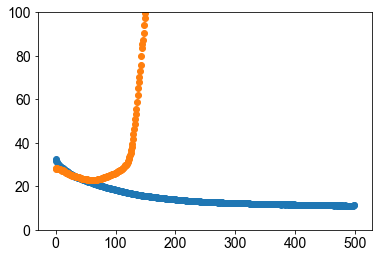

In [193]:
plt.scatter(list(range(500)),self.logs['loss_train'][:500])
plt.scatter(list(range(500)),self.logs['loss_valid'][:500])
plt.ylim(0,100)

In [219]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        #pcaX = TruncatedSVD(n_components=20)
        #pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())


        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        
        lr = 5e-3
        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[30], decoder_layer_sizes=[10], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        

        
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 500
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                train_rec = reconstruction_loss.item()
                train_kl = kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 30]
decoder_layer_sizes [10]
latent dim 10
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/500 Batch 0000/0, Loss:   32.8368, rec_loss:   32.8355, KL_loss:    0.0013
Epoch 01/500 Batch 0000/0, Loss:   32.4213, rec_loss:   32.4200, KL_loss:    0.0013
Epoch 02/500 Batch 0000/0, Loss:   31.8386, rec_loss:   31.8372, KL_loss:    0.0014
Epoch 03/500 Batch 0000/0, Loss:   31.5993, rec_loss:   31.5979, KL_loss:    0.0014
Epoch 04/500 Batch 0000/0, Loss:   31.3557, rec_loss:   31.3542, KL_loss:    0.0015
Epoch 05/500 Batch 0000/0, Loss:   31.3764, rec_loss:   31.3749, KL_loss:    0.0016
Epoch 06/500 Batch 0000/0, Loss:   30.5867, rec_loss:   30.5851, KL_loss:    0.0017
Epoch 07/500 Batch 0000/0, Loss:   30.5973, rec_loss:   30.5955, KL_loss:    0.0018
Epoch 08/500 Batch 0000/0, Loss:   29.9241, rec_loss:   29.9221, KL_loss:    0.0020
Epoch 09/500 Batch 0000/0, Loss:   29.9384, rec_loss:   29.9363, KL_loss:    0.0021
Epoch 10/500 Batch 0000/0, Loss:   29.6183, rec_loss: 

Epoch 100/500 Batch 0000/0, Loss:   21.8103, rec_loss:   21.7863, KL_loss:    0.0241
Epoch 101/500 Batch 0000/0, Loss:   21.7585, rec_loss:   21.7342, KL_loss:    0.0242
Epoch 102/500 Batch 0000/0, Loss:   21.6833, rec_loss:   21.6589, KL_loss:    0.0244
Epoch 103/500 Batch 0000/0, Loss:   21.6338, rec_loss:   21.6092, KL_loss:    0.0246
Epoch 104/500 Batch 0000/0, Loss:   21.6059, rec_loss:   21.5811, KL_loss:    0.0248
Epoch 105/500 Batch 0000/0, Loss:   21.4569, rec_loss:   21.4318, KL_loss:    0.0250
Epoch 106/500 Batch 0000/0, Loss:   21.4290, rec_loss:   21.4038, KL_loss:    0.0252
Epoch 107/500 Batch 0000/0, Loss:   21.3679, rec_loss:   21.3424, KL_loss:    0.0254
Epoch 108/500 Batch 0000/0, Loss:   21.2713, rec_loss:   21.2457, KL_loss:    0.0256
Epoch 109/500 Batch 0000/0, Loss:   21.2359, rec_loss:   21.2101, KL_loss:    0.0258
Epoch 110/500 Batch 0000/0, Loss:   21.1774, rec_loss:   21.1514, KL_loss:    0.0260
Epoch 111/500 Batch 0000/0, Loss:   21.1301, rec_loss:   21.1039,

Epoch 201/500 Batch 0000/0, Loss:   17.8532, rec_loss:   17.8175, KL_loss:    0.0357
Epoch 202/500 Batch 0000/0, Loss:   17.8338, rec_loss:   17.7980, KL_loss:    0.0358
Epoch 203/500 Batch 0000/0, Loss:   17.8400, rec_loss:   17.8041, KL_loss:    0.0359
Epoch 204/500 Batch 0000/0, Loss:   17.8037, rec_loss:   17.7677, KL_loss:    0.0361
Epoch 205/500 Batch 0000/0, Loss:   17.7929, rec_loss:   17.7567, KL_loss:    0.0362
Epoch 206/500 Batch 0000/0, Loss:   17.7285, rec_loss:   17.6922, KL_loss:    0.0363
Epoch 207/500 Batch 0000/0, Loss:   17.7564, rec_loss:   17.7200, KL_loss:    0.0364
Epoch 208/500 Batch 0000/0, Loss:   17.7517, rec_loss:   17.7152, KL_loss:    0.0366
Epoch 209/500 Batch 0000/0, Loss:   17.7141, rec_loss:   17.6774, KL_loss:    0.0367
Epoch 210/500 Batch 0000/0, Loss:   17.7228, rec_loss:   17.6860, KL_loss:    0.0368
Epoch 211/500 Batch 0000/0, Loss:   17.6972, rec_loss:   17.6603, KL_loss:    0.0369
Epoch 212/500 Batch 0000/0, Loss:   17.6401, rec_loss:   17.6030,

Epoch 305/500 Batch 0000/0, Loss:   16.6293, rec_loss:   16.5847, KL_loss:    0.0446
Epoch 306/500 Batch 0000/0, Loss:   16.6214, rec_loss:   16.5768, KL_loss:    0.0446
Epoch 307/500 Batch 0000/0, Loss:   16.6095, rec_loss:   16.5648, KL_loss:    0.0447
Epoch 308/500 Batch 0000/0, Loss:   16.6168, rec_loss:   16.5720, KL_loss:    0.0448
Epoch 309/500 Batch 0000/0, Loss:   16.5966, rec_loss:   16.5518, KL_loss:    0.0449
Epoch 310/500 Batch 0000/0, Loss:   16.5679, rec_loss:   16.5230, KL_loss:    0.0449
Epoch 311/500 Batch 0000/0, Loss:   16.5792, rec_loss:   16.5341, KL_loss:    0.0450
Epoch 312/500 Batch 0000/0, Loss:   16.5491, rec_loss:   16.5040, KL_loss:    0.0451
Epoch 313/500 Batch 0000/0, Loss:   16.5438, rec_loss:   16.4987, KL_loss:    0.0452
Epoch 314/500 Batch 0000/0, Loss:   16.5503, rec_loss:   16.5051, KL_loss:    0.0452
Epoch 315/500 Batch 0000/0, Loss:   16.5337, rec_loss:   16.4885, KL_loss:    0.0453
Epoch 316/500 Batch 0000/0, Loss:   16.5513, rec_loss:   16.5059,

Epoch 409/500 Batch 0000/0, Loss:   16.0669, rec_loss:   16.0164, KL_loss:    0.0505
Epoch 410/500 Batch 0000/0, Loss:   16.0574, rec_loss:   16.0069, KL_loss:    0.0505
Epoch 411/500 Batch 0000/0, Loss:   16.0785, rec_loss:   16.0279, KL_loss:    0.0505
Epoch 412/500 Batch 0000/0, Loss:   16.0590, rec_loss:   16.0084, KL_loss:    0.0506
Epoch 413/500 Batch 0000/0, Loss:   16.0660, rec_loss:   16.0154, KL_loss:    0.0506
Epoch 414/500 Batch 0000/0, Loss:   16.0512, rec_loss:   16.0005, KL_loss:    0.0506
Epoch 415/500 Batch 0000/0, Loss:   16.0534, rec_loss:   16.0027, KL_loss:    0.0507
Epoch 416/500 Batch 0000/0, Loss:   16.0505, rec_loss:   15.9998, KL_loss:    0.0507
Epoch 417/500 Batch 0000/0, Loss:   16.0437, rec_loss:   15.9930, KL_loss:    0.0507
Epoch 418/500 Batch 0000/0, Loss:   16.0499, rec_loss:   15.9992, KL_loss:    0.0508
Epoch 419/500 Batch 0000/0, Loss:   16.0554, rec_loss:   16.0046, KL_loss:    0.0508
Epoch 420/500 Batch 0000/0, Loss:   16.0113, rec_loss:   15.9604,

(0, 100)

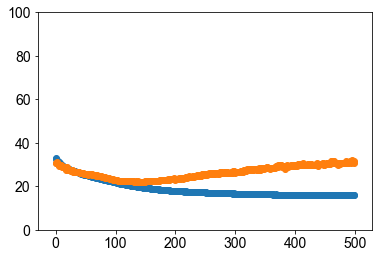

In [220]:
plt.scatter(list(range(500)),self.logs['loss_train'][:500])
plt.scatter(list(range(500)),self.logs['loss_valid'][:500])
plt.ylim(0,100)

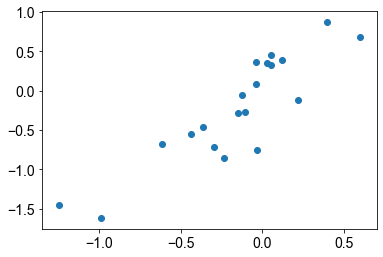

In [225]:
plt.scatter(recon_x.detach().numpy()[2], y.detach().numpy()[2])

In [229]:
def normalize_truncate_variance(x):
    keep = np.where(np.var(x, axis = 0) > 1e-6)[0]
    
    x = x[:,keep]
    return((x)/ np.var(x, axis = 0)**(0.5))


In [230]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        #pcaX = TruncatedSVD(n_components=20)
        #pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        X_nmf = nmfX.fit_transform(normalize_truncate_variance(X))
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(normalize_truncate_variance(Y))
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())


        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        
        lr = 5e-3
        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[30], decoder_layer_sizes=[10], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        

        
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 500
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                train_rec = reconstruction_loss.item()
                train_kl = kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 30]
decoder_layer_sizes [10]
latent dim 10
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/500 Batch 0000/0, Loss:   32.2247, rec_loss:   32.2229, KL_loss:    0.0019
Epoch 01/500 Batch 0000/0, Loss:   32.0331, rec_loss:   32.0311, KL_loss:    0.0021
Epoch 02/500 Batch 0000/0, Loss:   31.4043, rec_loss:   31.4024, KL_loss:    0.0019
Epoch 03/500 Batch 0000/0, Loss:   31.2202, rec_loss:   31.2181, KL_loss:    0.0020
Epoch 04/500 Batch 0000/0, Loss:   31.2445, rec_loss:   31.2421, KL_loss:    0.0023
Epoch 05/500 Batch 0000/0, Loss:   30.5382, rec_loss:   30.5354, KL_loss:    0.0028
Epoch 06/500 Batch 0000/0, Loss:   30.0825, rec_loss:   30.0792, KL_loss:    0.0033
Epoch 07/500 Batch 0000/0, Loss:   30.0569, rec_loss:   30.0529, KL_loss:    0.0040
Epoch 08/500 Batch 0000/0, Loss:   29.8214, rec_loss:   29.8165, KL_loss:    0.0049
Epoch 09/500 Batch 0000/0, Loss:   29.7693, rec_loss:   29.7624, KL_loss:    0.0068
Epoch 10/500 Batch 0000/0, Loss:   29.0945, rec_loss: 

Epoch 99/500 Batch 0000/0, Loss:   27.7323, rec_loss:   27.7084, KL_loss:    0.0239
Epoch 100/500 Batch 0000/0, Loss:   27.7065, rec_loss:   27.6826, KL_loss:    0.0239
Epoch 101/500 Batch 0000/0, Loss:   27.7187, rec_loss:   27.6947, KL_loss:    0.0239
Epoch 102/500 Batch 0000/0, Loss:   27.6783, rec_loss:   27.6544, KL_loss:    0.0239
Epoch 103/500 Batch 0000/0, Loss:   27.6478, rec_loss:   27.6239, KL_loss:    0.0239
Epoch 104/500 Batch 0000/0, Loss:   27.6954, rec_loss:   27.6715, KL_loss:    0.0239
Epoch 105/500 Batch 0000/0, Loss:   27.6550, rec_loss:   27.6310, KL_loss:    0.0239
Epoch 106/500 Batch 0000/0, Loss:   27.6568, rec_loss:   27.6329, KL_loss:    0.0239
Epoch 107/500 Batch 0000/0, Loss:   27.6470, rec_loss:   27.6231, KL_loss:    0.0239
Epoch 108/500 Batch 0000/0, Loss:   27.6523, rec_loss:   27.6285, KL_loss:    0.0238
Epoch 109/500 Batch 0000/0, Loss:   27.6366, rec_loss:   27.6129, KL_loss:    0.0238
Epoch 110/500 Batch 0000/0, Loss:   27.6450, rec_loss:   27.6213, 

Epoch 196/500 Batch 0000/0, Loss:   27.1127, rec_loss:   27.0911, KL_loss:    0.0215
Epoch 197/500 Batch 0000/0, Loss:   27.1292, rec_loss:   27.1077, KL_loss:    0.0215
Epoch 198/500 Batch 0000/0, Loss:   27.0743, rec_loss:   27.0525, KL_loss:    0.0219
Epoch 199/500 Batch 0000/0, Loss:   27.0991, rec_loss:   27.0770, KL_loss:    0.0221
Epoch 200/500 Batch 0000/0, Loss:   27.0534, rec_loss:   27.0315, KL_loss:    0.0219
Epoch 201/500 Batch 0000/0, Loss:   27.0985, rec_loss:   27.0769, KL_loss:    0.0216
Epoch 202/500 Batch 0000/0, Loss:   27.0737, rec_loss:   27.0523, KL_loss:    0.0214
Epoch 203/500 Batch 0000/0, Loss:   27.0654, rec_loss:   27.0440, KL_loss:    0.0214
Epoch 204/500 Batch 0000/0, Loss:   27.0319, rec_loss:   27.0106, KL_loss:    0.0213
Epoch 205/500 Batch 0000/0, Loss:   27.0531, rec_loss:   27.0319, KL_loss:    0.0211
Epoch 206/500 Batch 0000/0, Loss:   27.0429, rec_loss:   27.0219, KL_loss:    0.0210
Epoch 207/500 Batch 0000/0, Loss:   27.0446, rec_loss:   27.0236,

Epoch 296/500 Batch 0000/0, Loss:   26.4272, rec_loss:   26.4035, KL_loss:    0.0237
Epoch 297/500 Batch 0000/0, Loss:   26.4356, rec_loss:   26.4118, KL_loss:    0.0238
Epoch 298/500 Batch 0000/0, Loss:   26.4371, rec_loss:   26.4132, KL_loss:    0.0239
Epoch 299/500 Batch 0000/0, Loss:   26.4602, rec_loss:   26.4363, KL_loss:    0.0239
Epoch 300/500 Batch 0000/0, Loss:   26.4557, rec_loss:   26.4317, KL_loss:    0.0241
Epoch 301/500 Batch 0000/0, Loss:   26.4375, rec_loss:   26.4134, KL_loss:    0.0242
Epoch 302/500 Batch 0000/0, Loss:   26.4485, rec_loss:   26.4242, KL_loss:    0.0243
Epoch 303/500 Batch 0000/0, Loss:   26.4439, rec_loss:   26.4195, KL_loss:    0.0244
Epoch 304/500 Batch 0000/0, Loss:   26.4606, rec_loss:   26.4361, KL_loss:    0.0245
Epoch 305/500 Batch 0000/0, Loss:   26.4608, rec_loss:   26.4362, KL_loss:    0.0246
Epoch 306/500 Batch 0000/0, Loss:   26.4447, rec_loss:   26.4200, KL_loss:    0.0247
Epoch 307/500 Batch 0000/0, Loss:   26.4415, rec_loss:   26.4167,

Epoch 395/500 Batch 0000/0, Loss:   26.3071, rec_loss:   26.2808, KL_loss:    0.0263
Epoch 396/500 Batch 0000/0, Loss:   26.3400, rec_loss:   26.3138, KL_loss:    0.0262
Epoch 397/500 Batch 0000/0, Loss:   26.3016, rec_loss:   26.2754, KL_loss:    0.0262
Epoch 398/500 Batch 0000/0, Loss:   26.3224, rec_loss:   26.2961, KL_loss:    0.0262
Epoch 399/500 Batch 0000/0, Loss:   26.3003, rec_loss:   26.2741, KL_loss:    0.0262
Epoch 400/500 Batch 0000/0, Loss:   26.3216, rec_loss:   26.2954, KL_loss:    0.0262
Epoch 401/500 Batch 0000/0, Loss:   26.3194, rec_loss:   26.2932, KL_loss:    0.0262
Epoch 402/500 Batch 0000/0, Loss:   26.2892, rec_loss:   26.2629, KL_loss:    0.0262
Epoch 403/500 Batch 0000/0, Loss:   26.3190, rec_loss:   26.2928, KL_loss:    0.0262
Epoch 404/500 Batch 0000/0, Loss:   26.3032, rec_loss:   26.2769, KL_loss:    0.0262
Epoch 405/500 Batch 0000/0, Loss:   26.2931, rec_loss:   26.2669, KL_loss:    0.0262
Epoch 406/500 Batch 0000/0, Loss:   26.3060, rec_loss:   26.2798,

Epoch 492/500 Batch 0000/0, Loss:   26.1984, rec_loss:   26.1679, KL_loss:    0.0305
Epoch 493/500 Batch 0000/0, Loss:   26.1981, rec_loss:   26.1676, KL_loss:    0.0305
Epoch 494/500 Batch 0000/0, Loss:   26.2034, rec_loss:   26.1728, KL_loss:    0.0306
Epoch 495/500 Batch 0000/0, Loss:   26.2102, rec_loss:   26.1796, KL_loss:    0.0306
Epoch 496/500 Batch 0000/0, Loss:   26.1940, rec_loss:   26.1634, KL_loss:    0.0306
Epoch 497/500 Batch 0000/0, Loss:   26.2090, rec_loss:   26.1784, KL_loss:    0.0306
Epoch 498/500 Batch 0000/0, Loss:   26.2121, rec_loss:   26.1815, KL_loss:    0.0307
Epoch 499/500 Batch 0000/0, Loss:   26.2003, rec_loss:   26.1696, KL_loss:    0.0307


(0, 100)

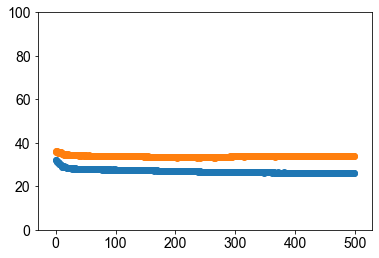

In [231]:
plt.scatter(list(range(500)),self.logs['loss_train'][:500])
plt.scatter(list(range(500)),self.logs['loss_valid'][:500])
plt.ylim(0,100)

In [234]:
        #fixed normalize
        nmfX = NMF(n_components=20)
        nmfY = NMF(n_components=60)
        #pcaX = TruncatedSVD(n_components=20)
        #pcaY = TruncatedSVD(n_components=120)
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        
        X = msvds[315].reg_inj_vcount_norm[exp_toinclude]
        Y = msvds[315].reg_proj_vcount_norm_renorm[exp_toinclude]
        #X_norm = X/ np.expand_dims(np.linalg.norm(X, axis = 1),1)

        Xnt = normalize_truncate_variance(X)
        Ynt = normalize_truncate_variance(Y)
        X_nmf = nmfX.fit_transform(X)
        X_pca = pcaX.fit_transform(X)
        Y_pca = pcaY.fit_transform(Y)
        Y_nmf = nmfY.fit_transform(Y)
        #print(pcaX.explained_variance_ratio_.sum())
        #print(pcaY.explained_variance_ratio_.sum())
        #print(((X- Xrec)**2).sum() , (X**2).sum())
        #print(((Y- Yrec)**2).sum() , (Y**2).sum())
        #print(pcaY.explained_variance_ratio_.sum())


        
        #xnorm = normalize(X)#_nmf)
        #scalerX.fit_transform(X)
        #ynorm = normalize(Y)#_nmf)#np.asarray(scalerY.fit_transform(Y))
        #xpcanorm = np.asarray(scalerX.fit_transform(X_pca))
        #ypcanorm = np.asarray(scalerY.fit_transform(Y_pca))        
        xnmfnorm = np.asarray(scalerX.fit_transform(X_nmf))
        ynmfnorm = np.asarray(scalerY.fit_transform(Y_nmf))
        
        
        
        
        
        an = anndata.AnnData(xnmfnorm)
        an.Y= pcaX.fit_transform(ynmfnorm)
        an.obs= pd.DataFrame(np.ones(an.Y.shape[0]))
        n_conditions = len(np.unique(an.obs))
        
        
        
        condition_key =0
        output_dim = an.Y.shape[1]
        input_dim = an.X.shape[1]
        
        lr = 5e-3
        n_epochs = 100
        niter =5000
        batch_size=300#50
        
        model = CVAE(input_dim,output_dim, num_classes=n_conditions,latent_dim =10,dr_rate=0.,
                    output_activation='linear', encoder_layer_sizes=[120], decoder_layer_sizes=[120], use_mmd=False, beta=1, alpha = .001)
        
        trainer = Trainer(model, an, condition_key=condition_key)        

        
        trainer.n_workers=0
        
        self = trainer
        self.train_frac = .8
        train_adata, validation_adata = train_test_split(self.adata, self.train_frac)
        data_set_train = CustomDatasetFromAdataRegression(train_adata, self.condition_key)
        data_set_valid = CustomDatasetFromAdataRegression(validation_adata, self.condition_key)
        self.model.label_encoder = data_set_train.get_label_ecnoder()
        dataset_train, dataset_valid = self.make_dataset()
        
        data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=self.n_workers)
        data_loader_valid = torch.utils.data.DataLoader(dataset=dataset_valid,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=self.n_workers)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)#self.lr)
        self.logs = defaultdict(list)
        self.model.train()



        n_epochs = 500
        for epoch in range(n_epochs):
            train_loss = 0
            train_rec = 0
            train_kl = 0
            for iteration, (x, y,l) in enumerate(data_loader_train):
                x, y,l = x.to(self.device), y.to(self.device), l.to(self.device)

                recon_x, mean, log_var = self.model(x, y,l)

                loss, reconstruction_loss, kl_loss = MSE_kl(recon_x.float(), y.float(), mean, log_var, self.model.alpha)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = loss.item()
                train_rec = reconstruction_loss.item()
                train_kl = kl_loss.item()
                if iteration % self.print_loss == 0 or iteration == len(data_loader_train) - 1:
                    print(
                        "Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss: {:9.4f}, rec_loss: {:9.4f}, KL_loss: {:9.4f}".format(
                            epoch, n_epochs, iteration, len(data_loader_train) - 1,
                            loss.item(), reconstruction_loss.item(), kl_loss.item()))
            self.logs['loss_train'].append(train_loss )
            self.logs["rec_loss_train"].append(train_rec )
            self.logs["KL_loss_train"].append(train_kl )
            valid_loss, valid_rec, valid_kl = self.validate(data_loader_valid,use_mmd = False)
            self.logs['loss_valid'].append(valid_loss)
            self.logs["rec_loss_valid"].append(valid_rec)
            self.logs["KL_loss_valid"].append(valid_kl)

encoder_layer_sizes [20, 120]
decoder_layer_sizes [120]
latent dim 10
1 ncls
0.0 dr_rate
True ubn
False udr
Epoch 00/500 Batch 0000/0, Loss:   42.4710, rec_loss:   42.4691, KL_loss:    0.0020
Epoch 01/500 Batch 0000/0, Loss:   40.0343, rec_loss:   40.0319, KL_loss:    0.0024
Epoch 02/500 Batch 0000/0, Loss:   38.9008, rec_loss:   38.8972, KL_loss:    0.0036
Epoch 03/500 Batch 0000/0, Loss:   38.3148, rec_loss:   38.3094, KL_loss:    0.0053
Epoch 04/500 Batch 0000/0, Loss:   37.8722, rec_loss:   37.8646, KL_loss:    0.0076
Epoch 05/500 Batch 0000/0, Loss:   37.3944, rec_loss:   37.3841, KL_loss:    0.0103
Epoch 06/500 Batch 0000/0, Loss:   36.9035, rec_loss:   36.8925, KL_loss:    0.0110
Epoch 07/500 Batch 0000/0, Loss:   36.2754, rec_loss:   36.2638, KL_loss:    0.0116
Epoch 08/500 Batch 0000/0, Loss:   35.5145, rec_loss:   35.5018, KL_loss:    0.0127
Epoch 09/500 Batch 0000/0, Loss:   35.1037, rec_loss:   35.0896, KL_loss:    0.0141
Epoch 10/500 Batch 0000/0, Loss:   34.4436, rec_loss

Epoch 98/500 Batch 0000/0, Loss:   23.7120, rec_loss:   23.6703, KL_loss:    0.0417
Epoch 99/500 Batch 0000/0, Loss:   23.6832, rec_loss:   23.6416, KL_loss:    0.0416
Epoch 100/500 Batch 0000/0, Loss:   23.6051, rec_loss:   23.5636, KL_loss:    0.0415
Epoch 101/500 Batch 0000/0, Loss:   23.5911, rec_loss:   23.5496, KL_loss:    0.0415
Epoch 102/500 Batch 0000/0, Loss:   23.5584, rec_loss:   23.5170, KL_loss:    0.0414
Epoch 103/500 Batch 0000/0, Loss:   23.5366, rec_loss:   23.4953, KL_loss:    0.0414
Epoch 104/500 Batch 0000/0, Loss:   23.4587, rec_loss:   23.4174, KL_loss:    0.0413
Epoch 105/500 Batch 0000/0, Loss:   23.4190, rec_loss:   23.3777, KL_loss:    0.0413
Epoch 106/500 Batch 0000/0, Loss:   23.4252, rec_loss:   23.3840, KL_loss:    0.0412
Epoch 107/500 Batch 0000/0, Loss:   23.3715, rec_loss:   23.3303, KL_loss:    0.0412
Epoch 108/500 Batch 0000/0, Loss:   23.3084, rec_loss:   23.2672, KL_loss:    0.0412
Epoch 109/500 Batch 0000/0, Loss:   23.2909, rec_loss:   23.2498, K

Epoch 196/500 Batch 0000/0, Loss:   20.7945, rec_loss:   20.7459, KL_loss:    0.0486
Epoch 197/500 Batch 0000/0, Loss:   20.7478, rec_loss:   20.6991, KL_loss:    0.0486
Epoch 198/500 Batch 0000/0, Loss:   20.7192, rec_loss:   20.6705, KL_loss:    0.0487
Epoch 199/500 Batch 0000/0, Loss:   20.7314, rec_loss:   20.6827, KL_loss:    0.0488
Epoch 200/500 Batch 0000/0, Loss:   20.7705, rec_loss:   20.7216, KL_loss:    0.0489
Epoch 201/500 Batch 0000/0, Loss:   20.7744, rec_loss:   20.7255, KL_loss:    0.0489
Epoch 202/500 Batch 0000/0, Loss:   20.8408, rec_loss:   20.7918, KL_loss:    0.0490
Epoch 203/500 Batch 0000/0, Loss:   20.7535, rec_loss:   20.7044, KL_loss:    0.0491
Epoch 204/500 Batch 0000/0, Loss:   20.7397, rec_loss:   20.6906, KL_loss:    0.0492
Epoch 205/500 Batch 0000/0, Loss:   20.6944, rec_loss:   20.6451, KL_loss:    0.0493
Epoch 206/500 Batch 0000/0, Loss:   20.6791, rec_loss:   20.6298, KL_loss:    0.0494
Epoch 207/500 Batch 0000/0, Loss:   20.6370, rec_loss:   20.5875,

Epoch 294/500 Batch 0000/0, Loss:   20.2434, rec_loss:   20.1880, KL_loss:    0.0554
Epoch 295/500 Batch 0000/0, Loss:   20.0868, rec_loss:   20.0314, KL_loss:    0.0554
Epoch 296/500 Batch 0000/0, Loss:   20.0228, rec_loss:   19.9674, KL_loss:    0.0554
Epoch 297/500 Batch 0000/0, Loss:   19.9708, rec_loss:   19.9153, KL_loss:    0.0555
Epoch 298/500 Batch 0000/0, Loss:   19.8997, rec_loss:   19.8442, KL_loss:    0.0555
Epoch 299/500 Batch 0000/0, Loss:   19.9656, rec_loss:   19.9100, KL_loss:    0.0555
Epoch 300/500 Batch 0000/0, Loss:   19.8876, rec_loss:   19.8320, KL_loss:    0.0555
Epoch 301/500 Batch 0000/0, Loss:   19.8419, rec_loss:   19.7863, KL_loss:    0.0556
Epoch 302/500 Batch 0000/0, Loss:   19.8669, rec_loss:   19.8114, KL_loss:    0.0556
Epoch 303/500 Batch 0000/0, Loss:   19.7835, rec_loss:   19.7280, KL_loss:    0.0556
Epoch 304/500 Batch 0000/0, Loss:   19.7901, rec_loss:   19.7345, KL_loss:    0.0556
Epoch 305/500 Batch 0000/0, Loss:   19.7619, rec_loss:   19.7063,

Epoch 391/500 Batch 0000/0, Loss:   19.9572, rec_loss:   19.8980, KL_loss:    0.0592
Epoch 392/500 Batch 0000/0, Loss:   19.7862, rec_loss:   19.7270, KL_loss:    0.0592
Epoch 393/500 Batch 0000/0, Loss:   19.8176, rec_loss:   19.7584, KL_loss:    0.0592
Epoch 394/500 Batch 0000/0, Loss:   19.7246, rec_loss:   19.6655, KL_loss:    0.0592
Epoch 395/500 Batch 0000/0, Loss:   19.6439, rec_loss:   19.5848, KL_loss:    0.0591
Epoch 396/500 Batch 0000/0, Loss:   19.6482, rec_loss:   19.5891, KL_loss:    0.0591
Epoch 397/500 Batch 0000/0, Loss:   19.5242, rec_loss:   19.4651, KL_loss:    0.0591
Epoch 398/500 Batch 0000/0, Loss:   19.5277, rec_loss:   19.4686, KL_loss:    0.0591
Epoch 399/500 Batch 0000/0, Loss:   19.4537, rec_loss:   19.3947, KL_loss:    0.0590
Epoch 400/500 Batch 0000/0, Loss:   19.4374, rec_loss:   19.3784, KL_loss:    0.0590
Epoch 401/500 Batch 0000/0, Loss:   19.4091, rec_loss:   19.3502, KL_loss:    0.0589
Epoch 402/500 Batch 0000/0, Loss:   19.3471, rec_loss:   19.2882,

Epoch 489/500 Batch 0000/0, Loss:   19.1976, rec_loss:   19.1361, KL_loss:    0.0615
Epoch 490/500 Batch 0000/0, Loss:   19.1818, rec_loss:   19.1203, KL_loss:    0.0615
Epoch 491/500 Batch 0000/0, Loss:   19.1234, rec_loss:   19.0619, KL_loss:    0.0615
Epoch 492/500 Batch 0000/0, Loss:   19.0899, rec_loss:   19.0284, KL_loss:    0.0615
Epoch 493/500 Batch 0000/0, Loss:   19.0488, rec_loss:   18.9873, KL_loss:    0.0615
Epoch 494/500 Batch 0000/0, Loss:   19.0142, rec_loss:   18.9527, KL_loss:    0.0615
Epoch 495/500 Batch 0000/0, Loss:   18.9632, rec_loss:   18.9016, KL_loss:    0.0615
Epoch 496/500 Batch 0000/0, Loss:   18.9191, rec_loss:   18.8576, KL_loss:    0.0615
Epoch 497/500 Batch 0000/0, Loss:   18.9111, rec_loss:   18.8496, KL_loss:    0.0615
Epoch 498/500 Batch 0000/0, Loss:   18.9051, rec_loss:   18.8437, KL_loss:    0.0615
Epoch 499/500 Batch 0000/0, Loss:   18.8492, rec_loss:   18.7877, KL_loss:    0.0614


(0, 100)

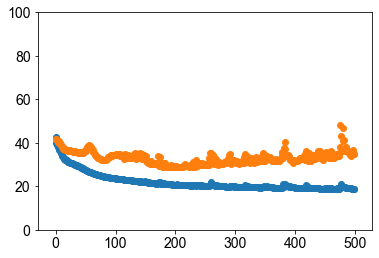

In [235]:
plt.scatter(list(range(500)),self.logs['loss_train'][:500])
plt.scatter(list(range(500)),self.logs['loss_valid'][:500])
plt.ylim(0,100)

In [ ]:
#makes more sense to nmf before normalization, since we dont care about small values